In [1]:
import gym
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
from gym import error, spaces, utils
from gym.utils import seeding
import time
import os
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Dropout, concatenate
from keras.layers import Concatenate,Conv2D,BatchNormalization,MaxPooling2D
from keras.optimizers import Adam
from keras import initializers

C:\Users\SERVER\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\SERVER\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SERVER\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SERVER\Anaconda3\lib\site-packages\tensorflow\python\framew

In [3]:
class BikeEnv(gym.Env):
    
    def __init__(self):
        p.connect(p.GUI)
        p.setRealTimeSimulation(1)
        p.resetDebugVisualizerCamera(cameraDistance=10, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.55,-0.35,0.2])
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Dict({
            'sensor' : spaces.Box(np.array([-1000]*10), np.array([1000]*10)),
            'image'  : spaces.Box(low=0, high=1, shape=(64, 64))
        }) 
        
        self.timestep = 1./240.
        self.stp = 0
        
    def step(self, action):
        #print("i=%d" % self.stp)
        self.stp+=1
        #print("time = " , time.time()-self.time)
     
        if (action == 0):
            self.speed = self.speed + 1
        if (action == 1):
            self.speed = self.speed - 1 
        if (action == 2):
            self.speed = self.speed  
        if (action == 3):
            self.steer = self.steer - 1 
        if (action == 4):
            self.steer = self.steer + 1
        if (action == 5):
            self.steer = self.steer 
            
              
        self.applyAction([self.speed,self.steer])

        #p.setRealTimeSimulation(1)
        time.sleep(.5)
        #p.setRealTimeSimulation(0)
        
        state = p.getLinkState(self.pid,0)[0]
        if state[2] <= 0.5 or  state[2] >= 2 or abs(self.speed)>3 or abs(self.steer)>4:
            reward = -10
            done = True
        else :
            #reward = math.sqrt((self.origin[0]-state[0])**2+(self.origin[1]-state[1])**2)
            reward = state[0] - self.origin[0]
            #reward = 1
            done = False
        self.origin = state 
        
        velocity = p.getBaseVelocity(self.pid)
        img = self.getImage()
        observation = {'sensor':list(self.getObservation()) + list(velocity[0])+list(velocity[1]),
                       'image': img}
        
        info = {'x':'','y':'','z':''}
        #print("Step: ",self.stp)
        #xx = time.time()
        #print("Time: ",xx-self.tttt)
        #self.tttt = xx
        #print("Action: ",action)
        #print("Reward: ",reward)
        #self.stp +=1
        return observation, reward, done, info
            
    def applyAction(self, motorCommands):
        targetVelocity = motorCommands[0] * self.speedMultiplier
        #print("targetVelocity")
        #print(targetVelocity)
        steeringAngle = motorCommands[1] * self.steeringMultiplier
        #print("steeringAngle")
        #print(steeringAngle)


        for motor in self.motorizedwheels:
            p.setJointMotorControl2(self.pid,
                                    motor,
                                    p.VELOCITY_CONTROL,
                                    targetVelocity=targetVelocity,
                                    force=self.maxForce)
        for steer in self.steeringLinks:
            p.setJointMotorControl2(self.pid,
                                    steer,
                                    p.POSITION_CONTROL,
                                    targetPosition=steeringAngle)

    def reset(self):
        #print("Reset")
        #print("setp:",self.stp)
        self.stp = 0

        p.resetSimulation()

        urdfRootPath = pybullet_data.getDataPath()
        planeUid = p.loadURDF(os.path.join(urdfRootPath,"plane.urdf"), basePosition=[0,0,0])
        
        
        for i in range(np.random.randint(1,20)):
            p.loadURDF(os.path.join(urdfRootPath, "sphere2.urdf"),basePosition=[
                np.random.randint(15,35),
                np.random.randint(-3,3),
               0.5
           ])
     
        self.pid = p.loadURDF(os.path.join(urdfRootPath, "bicycle/bike.urdf"),basePosition=[0,0,1])     
           
        
        self.origin = p.getLinkState(self.pid,0)[0]
        p.setGravity(0,0,-10)
        for wheel in range(p.getNumJoints(self.pid)):
            p.setJointMotorControl2(self.pid,
                                    wheel,
                                    p.VELOCITY_CONTROL,
                                    targetVelocity=0,
                                    force=0)

        self.steeringLinks = [0]
        self.maxForce = 20
        self.nMotors = 2
        self.motorizedwheels = [1, 2]
        self.speedMultiplier = 10.
        self.steeringMultiplier = 0.5
        
        self.speed = 0 
        self.steer = 0

        velocity = p.getBaseVelocity(self.pid)
        img = self.getImage()
        observation = {'sensor': list(self.getObservation()) + list(velocity[0])+list(velocity[1]),
                       'image': img}
        

        p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,1)
        
        return observation
        
    
    def getImage(self):
        img = env.render()
        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_NEAREST )
        img = img[:,:,2]
        #img =img.reshape((128,128))
        img = np.asarray(img, dtype='float32')
        img /= 255.0
        return img
        
    def getObservationDimension(self):
        return len(self.getObservation())
    
    def getObservation(self):
        observation = []
        pos, orn = p.getBasePositionAndOrientation(self.pid)

        #observation.extend(list(pos))
        observation.extend(list(orn))
        return observation
        
    def render(self, mode='rgb_array'):
        pos, orn = p.getBasePositionAndOrientation(self.pid)
      
        view_matrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[pos[0]+11.3,pos[1],pos[2]],
                                                            distance=10,
                                                            yaw=-90 ,
                                                            pitch=0,
                                                            roll=0,
                                                            upAxisIndex=2)
        proj_matrix = p.computeProjectionMatrixFOV(fov=60,
                                                     aspect=float(960) /720,
                                                     nearVal=0.1,
                                                     farVal=100.0)
        (_, _, px, _, _) = p.getCameraImage(width=64,
                                              height=64,
                                              viewMatrix=view_matrix,
                                              projectionMatrix=proj_matrix,
                                              renderer=p.ER_BULLET_HARDWARE_OPENGL)

        rgb_array = np.array(px, dtype=np.uint8)
        rgb_array = np.reshape(rgb_array, (64,64, 4))

        rgb_array = rgb_array[:, :, :3]
        return rgb_array

    def close(self):
        p.disconnect()

In [4]:
class iDQNAgent:
    def __init__(self, env, action_space, episodes=500 , memory_size = 50000):
        self.env = env
        self.memory = []
        self.memory_size = memory_size
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = self.epsilon_min / self.epsilon
        self.epsilon_decay = self.epsilon_decay ** (1. / float(episodes))
        
        n_outputs = action_space.n
        
        self.q_model = self.build_model(n_outputs)
        self.q_model.compile(loss='mse' , optimizer=Adam())
        
        self.target_q_model = self.build_model(n_outputs)
        
        self.update_weights()
        self.replay_counter = 0
        
        ####################################################
    def create_mlp(self):
        inputs = Input(shape=self.env.observation_space['sensor'].shape)
        x = Dense(16, activation='relu')(inputs)
        #x = Dense(nb_actions, activation='linear')(x)
        model = Model(inputs, x)
        return model
    
    def create_cnn(self):
        inputShape = (64, 64,1)
        inputs = Input(shape=inputShape,name='image')
        x = Conv2D(32, (5, 5), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Conv2D(64, (5, 5), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)

        model = Model(inputs, x)
        return model
    
    def build_model(self, n_outputs):
        mlp = self.create_mlp()
        cnn = self.create_cnn()
        combinedInput = concatenate([mlp.output, cnn.output])
        x = Dense(n_outputs, activation="linear")(combinedInput)
        model = Model(inputs=[mlp.input, cnn.input], outputs=x)
        model.summary()
        return model
    
        #####################################################
    def act(self , state):

        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        sensor = state['sensor']
        sensor = np.asarray(sensor)
        sensor = np.reshape(sensor, (-1,10))
        image = state['image']
        image = np.reshape(image, (-1,64,64,1))
        q_values = self.q_model.predict([sensor,image])
        action = np.argmax(q_values[0])
        return action
    
        ######################################################
    def remember(self, state, action, reward , next_state , done):
        item = (state , action , reward , next_state ,done)
        if len(self.memory) > self.memory_size :
            self.memory.pop(0)
        self.memory.append(item)
        
        #######################################################
    def get_target_q_value(self, next_sensor,next_image, reward , double):
        if double :
            action = np.argmax(self.q_model.predict([next_sensor,next_image]))
            q_value = self.target_q_model.predict([next_sensor,next_image])[0][action]
        else :
            q_value = np.amax(self.target_q_model.predict([next_sensor,next_image])[0])
        
        q_value *= self.gamma
        q_value += reward
        return q_value
    
        ########################################################
    def replay(self , batch_size):
        sars_batch = random.sample(self.memory , batch_size)
       
        sensor_batch , image_batch , q_value_batch = [] , [] ,[]
        for state, action, reward, next_state, done in sars_batch:
            sensor = state['sensor']
            sensor = np.asarray(sensor)
            sensor = np.reshape(sensor, (-1,10))
            image = state['image']
            image =  np.asarray(image)
            image = np.reshape(image, (-1,64,64,1))
            
            q_values = self.q_model.predict([sensor, image])
            
            next_sensor = next_state['sensor']
            next_sensor = np.asarray(next_sensor)
            next_sensor = np.reshape(next_sensor, (-1,10))
            next_image = next_state['image']
            next_image =  np.asarray(next_image)
            next_image = np.reshape(next_image, (-1,64,64,1))
            q_value = self.get_target_q_value(next_sensor,next_image, reward, False)
            # ??????????
            q_values[0][action] = reward if done else q_value
            
            sensor_batch.append(sensor)
            image_batch.append(image)
            q_value_batch.append(q_values[0])
            
        sensor_batch = np.asarray(sensor_batch)
        sensor_batch = np.reshape(sensor_batch, (batch_size,10))
        image_batch = np.asarray(image_batch)
        image_batch = np.reshape(image_batch, (batch_size,64,64,1))
        hist = self.q_model.fit([sensor_batch ,image_batch ] , 
                             np.array(q_value_batch),
                             batch_size = batch_size,
                            epochs = 1,
                            verbose = 0)

        self.update_epsilon()
            
        if self.replay_counter % 10 == 0:
            self.update_weights()
                
        self.replay_counter += 1
        
        return hist.history['loss'][0]
       
       ######################################################

       ######################################################
    def update_epsilon(self):
            if self.epsilon > self.epsilon_min :
                self.epsilon *= self.epsilon_decay
        ########################################################
    def update_weights(self):
            self.target_q_model.set_weights(self.q_model.get_weights())
            

In [5]:
env = BikeEnv()
np.random.seed(123)
env.seed(123)

C:\Users\SERVER\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
episode_count = 50000
batch_size = 64

In [7]:
agent = iDQNAgent(env ,env.action_space, episode_count)





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   1664        image[0][0]                      
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 64, 64, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 64)   0           activation_2[0][0]               
__________________________________________________________________________________________________
flatte

In [8]:
all_rewards = []
all_losses =  []
loss = 0
for episode in range(episode_count):
    state = env.reset()
    done = False
    total_reward = 0

    while not done :
        action = agent.act(state)
        next_state , reward , done , _ = env.step(action)
        agent.remember(state , action , reward , next_state , done)
        state = next_state
        total_reward += reward
    
    if len(agent.memory) >= batch_size:
        loss = agent.replay(batch_size)
        all_losses.append(loss)
        
    print("episode {} reward {} loss {}".format(episode , total_reward, loss))
    all_rewards.append(total_reward)

episode 0 reward -7.650659400100317 loss 0
episode 1 reward -7.700369762915367 loss 0
episode 2 reward -7.737049193275348 loss 0
episode 3 reward -9.99867053620561 loss 0
episode 4 reward -7.676061978352768 loss 0
episode 5 reward -10.573573597788636 loss 0
episode 6 reward -10.003733131004504 loss 0
episode 7 reward -10.003165084203458 loss 0
episode 8 reward -10.016825051514815 loss 0
episode 9 reward -10.003733138315805 loss 0
episode 10 reward -9.456986366514665 loss 0
episode 11 reward -10.001056165538904 loss 0
episode 12 reward -7.6623291622535765 loss 0
episode 13 reward -7.650659400100317 loss 0
episode 14 reward -7.670156795457991 loss 0
episode 15 reward -10.557424332105272 loss 0
episode 16 reward -7.679389782492626 loss 0
episode 17 reward -10.003733138935974 loss 0
episode 18 reward -7.697570702907937 loss 0
episode 19 reward -10.003733138315805 loss 0
episode 20 reward -12.194349855119908 loss 0
episode 21 reward -9.560908399332668 loss 5.643303871154785
episode 22 rewar

episode 140 reward -7.6671990288857375 loss 0.8053953647613525
episode 141 reward -7.683762116173045 loss 0.828654408454895
episode 142 reward -10.00373309613759 loss 0.6924337148666382
episode 143 reward -12.435158714149146 loss 0.6336376667022705
episode 144 reward -9.99869776410579 loss 0.6431072950363159
episode 145 reward -10.404529557405779 loss 0.704908013343811
episode 146 reward -10.00373309613759 loss 0.7484608292579651
episode 147 reward -10.557374323005666 loss 0.6144164204597473
episode 148 reward -9.471878525272952 loss 0.5682663321495056
episode 149 reward -10.391912178596899 loss 0.7201530933380127
episode 150 reward -7.888702371501575 loss 0.7694975733757019
episode 151 reward -9.579244329434953 loss 0.6526641845703125
episode 152 reward -10.003737872927038 loss 0.6976258754730225
episode 153 reward -12.447293186984277 loss 0.6465434432029724
episode 154 reward -7.683762116173045 loss 0.6958415508270264
episode 155 reward -9.447579590234705 loss 0.6105411648750305
epis

episode 271 reward -10.00373309613759 loss 0.26819223165512085
episode 272 reward -7.677104267215858 loss 0.2540515959262848
episode 273 reward -10.032275379918543 loss 0.30160385370254517
episode 274 reward -10.003733117396635 loss 0.21133838593959808
episode 275 reward -10.017006305442605 loss 0.29625582695007324
episode 276 reward -10.557424331907752 loss 0.17184141278266907
episode 277 reward -10.017233071588343 loss 0.20401683449745178
episode 278 reward -10.001067162021814 loss 0.20169059932231903
episode 279 reward -8.569037802459444 loss 0.19945776462554932
episode 280 reward -9.571004310293644 loss 0.2525068521499634
episode 281 reward -8.73561230627824 loss 0.18048840761184692
episode 282 reward -10.563120390570237 loss 0.1880713552236557
episode 283 reward -9.461652266436017 loss 0.2569888234138489
episode 284 reward -10.167023166878247 loss 0.22136855125427246
episode 285 reward -10.00355864033006 loss 0.3297721743583679
episode 286 reward -7.72654144574118 loss 0.214543327

episode 401 reward -10.03339251706229 loss 0.16319583356380463
episode 402 reward -7.724526061517908 loss 0.20075838267803192
episode 403 reward -9.451951704480976 loss 0.1723940372467041
episode 404 reward -9.443480357935458 loss 0.1405840516090393
episode 405 reward -12.5455247072784 loss 0.19919061660766602
episode 406 reward -10.016230760134109 loss 0.18542051315307617
episode 407 reward -9.998910102063476 loss 0.21929925680160522
episode 408 reward -9.858197655472317 loss 0.1775435209274292
episode 409 reward -12.44921215098699 loss 0.22609645128250122
episode 410 reward -9.461627184511347 loss 0.14717631042003632
episode 411 reward -11.555133636072458 loss 0.16702361404895782
episode 412 reward -10.018627186854037 loss 0.1467311978340149
episode 413 reward -6.005932486461001 loss 0.1654304563999176
episode 414 reward -11.539620778532047 loss 0.19133326411247253
episode 415 reward -10.136240125973963 loss 0.158755362033844
episode 416 reward -12.430594570078124 loss 0.169004589319

episode 531 reward -7.914606312790953 loss 0.17912158370018005
episode 532 reward -10.016813109701925 loss 0.2698250412940979
episode 533 reward -7.656420100092327 loss 0.1695515662431717
episode 534 reward -10.391463059411706 loss 0.17213711142539978
episode 535 reward -10.003667590216226 loss 0.18751917779445648
episode 536 reward -7.667198276572494 loss 0.148855060338974
episode 537 reward -10.387250874846453 loss 0.2001534104347229
episode 538 reward -10.003143221029267 loss 0.183344304561615
episode 539 reward -10.003702313837433 loss 0.2282787710428238
episode 540 reward -9.998648959576798 loss 0.2832040786743164
episode 541 reward -7.919537014619705 loss 0.13712510466575623
episode 542 reward -10.000953110744307 loss 0.15329453349113464
episode 543 reward -8.588513796922706 loss 0.13145898282527924
episode 544 reward -10.00373309613759 loss 0.12252078950405121
episode 545 reward -10.390306319828339 loss 0.17058780789375305
episode 546 reward -10.611267094433927 loss 0.2071327120

episode 661 reward -12.42894533809902 loss 0.0932435691356659
episode 662 reward -8.565801645159066 loss 0.22284606099128723
episode 663 reward -7.873657965844535 loss 0.11034321039915085
episode 664 reward -15.47032696038126 loss 0.16435368359088898
episode 665 reward -8.566611560335728 loss 0.1818220317363739
episode 666 reward -10.000762606986498 loss 0.1405923068523407
episode 667 reward -9.4638714518847 loss 0.1331639587879181
episode 668 reward -7.629539851757474 loss 0.1906181275844574
episode 669 reward -10.398235303954579 loss 0.16733498871326447
episode 670 reward -10.135938929906999 loss 0.1407759189605713
episode 671 reward -10.003733138315805 loss 0.19553625583648682
episode 672 reward -9.443739896541226 loss 0.1459277719259262
episode 673 reward -10.00373313267018 loss 0.24121803045272827
episode 674 reward -7.767398137978475 loss 0.12918806076049805
episode 675 reward -10.003733138935974 loss 0.1384209394454956
episode 676 reward -8.531617566159543 loss 0.130530327558517

episode 791 reward -12.199911066468893 loss 0.191231369972229
episode 792 reward -10.003733090366307 loss 0.12925386428833008
episode 793 reward -9.569161389901147 loss 0.11606050282716751
episode 794 reward -9.998795573446616 loss 0.20922479033470154
episode 795 reward -7.838942464704643 loss 0.09686213731765747
episode 796 reward -10.557424331907752 loss 0.14850834012031555
episode 797 reward -10.016339591031873 loss 0.16752175986766815
episode 798 reward -15.447235144159137 loss 0.1996004283428192
episode 799 reward -9.561913426605148 loss 0.14419421553611755
episode 800 reward -9.470969216093168 loss 0.12275813519954681
episode 801 reward -9.463794509928023 loss 0.13685260713100433
episode 802 reward -9.9988675372086 loss 0.13923205435276031
episode 803 reward -10.003694035030009 loss 0.1599057912826538
episode 804 reward -15.636745232315345 loss 0.18152298033237457
episode 805 reward -10.381008083103202 loss 0.0940764993429184
episode 806 reward -10.003733131004504 loss 0.15708571

episode 921 reward -9.463845296041116 loss 0.1679147183895111
episode 922 reward -7.688069346198695 loss 0.1894344985485077
episode 923 reward -12.42921163364409 loss 0.22480523586273193
episode 924 reward -11.62196389579026 loss 0.20994001626968384
episode 925 reward -7.7610824671927 loss 0.13703468441963196
episode 926 reward -7.70903441440587 loss 0.15471862256526947
episode 927 reward -10.017021555179562 loss 0.13814425468444824
episode 928 reward -12.384329284751814 loss 0.1445658951997757
episode 929 reward -7.8550871166544605 loss 0.09784327447414398
episode 930 reward -10.001190485790463 loss 0.12689247727394104
episode 931 reward -8.58483681076649 loss 0.11816175282001495
episode 932 reward -12.269384706710856 loss 0.16778725385665894
episode 933 reward -8.758747727015404 loss 0.18015040457248688
episode 934 reward -7.641555098182121 loss 0.2165122628211975
episode 935 reward -10.00301065575272 loss 0.2796620726585388
episode 936 reward -12.197444347782387 loss 0.1501740217208

episode 1051 reward -10.003699616438213 loss 0.1174856573343277
episode 1052 reward -10.001042556860344 loss 0.20669957995414734
episode 1053 reward -7.703337790459642 loss 0.1247999370098114
episode 1054 reward -9.444707071067194 loss 0.19604842364788055
episode 1055 reward -7.7601098239737105 loss 0.1412481963634491
episode 1056 reward -10.000299161727963 loss 0.1961941421031952
episode 1057 reward -10.017220769947954 loss 0.3333856761455536
episode 1058 reward -10.003143516869823 loss 0.25472813844680786
episode 1059 reward -10.00373311695673 loss 0.21139301359653473
episode 1060 reward -9.469874759086045 loss 0.3130025267601013
episode 1061 reward -10.001019407125845 loss 0.16506251692771912
episode 1062 reward -7.696110607463966 loss 0.12535105645656586
episode 1063 reward -9.436875018588252 loss 0.25689929723739624
episode 1064 reward -11.845369707218227 loss 0.11727090924978256
episode 1065 reward -10.002925561128658 loss 0.25435590744018555
episode 1066 reward -9.46505983603975

episode 1179 reward -10.016635988974963 loss 0.10561756044626236
episode 1180 reward -10.003282552492845 loss 0.13452385365962982
episode 1181 reward -10.564735844494397 loss 0.22121569514274597
episode 1182 reward -8.564857663860783 loss 0.1499587595462799
episode 1183 reward -10.003652980076895 loss 0.2227100133895874
episode 1184 reward -10.003733131004504 loss 0.10084950923919678
episode 1185 reward -7.816086966559631 loss 0.18043500185012817
episode 1186 reward -9.998801081227242 loss 0.2519470453262329
episode 1187 reward -8.61191582994349 loss 0.16805917024612427
episode 1188 reward -10.391914419405026 loss 0.10216346383094788
episode 1189 reward -10.017360508301524 loss 0.14824753999710083
episode 1190 reward -7.6948306198393315 loss 0.14232581853866577
episode 1191 reward -12.429269305910502 loss 0.15134838223457336
episode 1192 reward -12.4472787771086 loss 0.2590717375278473
episode 1193 reward -10.38410622645328 loss 0.1259121149778366
episode 1194 reward -12.43424041906693

episode 1307 reward -7.6671990288857375 loss 0.12000004947185516
episode 1308 reward -10.016784363819 loss 0.16227999329566956
episode 1309 reward -10.000714307639328 loss 0.10865107923746109
episode 1310 reward -10.383855916952463 loss 0.23530806601047516
episode 1311 reward -10.017475240471411 loss 0.1247706189751625
episode 1312 reward -10.003723498372445 loss 0.14732219278812408
episode 1313 reward -10.003733131004504 loss 0.11146368086338043
episode 1314 reward -10.139175898639193 loss 0.1580582559108734
episode 1315 reward -12.467044418199658 loss 0.13420303165912628
episode 1316 reward -9.998648959576817 loss 0.09636169672012329
episode 1317 reward -12.533749274443826 loss 0.10604850202798843
episode 1318 reward -12.612798088133484 loss 0.12906944751739502
episode 1319 reward -7.731867364383534 loss 0.1794928014278412
episode 1320 reward -10.000971201810714 loss 0.0979287400841713
episode 1321 reward -7.860633799399584 loss 0.1683875173330307
episode 1322 reward -7.6122341457108

episode 1435 reward -10.001188311975417 loss 0.10626243054866791
episode 1436 reward -10.01634133006808 loss 0.13195575773715973
episode 1437 reward -7.853418940895688 loss 0.2317996621131897
episode 1438 reward -12.464379356452586 loss 0.07151982933282852
episode 1439 reward -15.436693344621919 loss 0.11761099845170975
episode 1440 reward -8.600825439615384 loss 0.16498562693595886
episode 1441 reward -11.551211074185824 loss 0.14699827134609222
episode 1442 reward -10.000714307639328 loss 0.24538834393024445
episode 1443 reward -10.017993677303688 loss 0.08059853315353394
episode 1444 reward -9.573067822504065 loss 0.08775840699672699
episode 1445 reward -10.512728721974309 loss 0.14917053282260895
episode 1446 reward -7.7117593425138455 loss 0.08333609998226166
episode 1447 reward -12.447293186984277 loss 0.10019250214099884
episode 1448 reward -10.384084733183148 loss 0.08917587995529175
episode 1449 reward -12.417894515533698 loss 0.1554427295923233
episode 1450 reward -10.5750560

episode 1563 reward -10.018468678602344 loss 0.08487392961978912
episode 1564 reward -10.017020795872678 loss 0.09863577783107758
episode 1565 reward -10.477543241756457 loss 0.06845247745513916
episode 1566 reward -7.720839017530654 loss 0.07050146162509918
episode 1567 reward -7.651485886260297 loss 0.053743936121463776
episode 1568 reward -12.48435797233666 loss 0.06654723733663559
episode 1569 reward -7.847679562595699 loss 0.09736835956573486
episode 1570 reward -10.001088198009096 loss 0.059424739331007004
episode 1571 reward -10.018598134992233 loss 0.07421492785215378
episode 1572 reward -8.553671703867536 loss 0.19319063425064087
episode 1573 reward -10.003638871529459 loss 0.0674542784690857
episode 1574 reward -10.01659665093326 loss 0.10521901398897171
episode 1575 reward -8.650011109669585 loss 0.1566857099533081
episode 1576 reward -10.017220157757299 loss 0.14149589836597443
episode 1577 reward -9.449714505229904 loss 0.0934695452451706
episode 1578 reward -8.57280362502

episode 1691 reward -9.567539387722082 loss 0.09865354001522064
episode 1692 reward -9.466642977974116 loss 0.05439833551645279
episode 1693 reward -11.566735133074607 loss 0.045702219009399414
episode 1694 reward -9.998795935664301 loss 0.06122815981507301
episode 1695 reward -7.888702371501575 loss 0.05821609124541283
episode 1696 reward -7.7359450943392325 loss 0.0653839185833931
episode 1697 reward -9.470969216091863 loss 0.08234989643096924
episode 1698 reward -12.212873453874025 loss 0.11731982976198196
episode 1699 reward -10.016549627541512 loss 0.09215536713600159
episode 1700 reward -12.176493328736512 loss 0.0834030956029892
episode 1701 reward -10.002935732339553 loss 0.06225230172276497
episode 1702 reward -7.668358934103143 loss 0.08896195888519287
episode 1703 reward -12.401272431602369 loss 0.07035315036773682
episode 1704 reward -15.494404809491677 loss 0.08412377536296844
episode 1705 reward -10.003733138315805 loss 0.14383956789970398
episode 1706 reward -11.56897771

episode 1819 reward -10.000714307639328 loss 0.06050115078687668
episode 1820 reward -7.771786271987773 loss 0.06744581460952759
episode 1821 reward -9.998870029714205 loss 0.07072342187166214
episode 1822 reward -12.42894533809902 loss 0.04808497801423073
episode 1823 reward -10.033022421252067 loss 0.032169975340366364
episode 1824 reward -12.180322997485913 loss 0.037169910967350006
episode 1825 reward -12.450238216001733 loss 0.04112600162625313
episode 1826 reward -9.569161382250666 loss 0.137105330824852
episode 1827 reward -10.563958531126636 loss 0.0676141232252121
episode 1828 reward -12.519495852728486 loss 0.05335154011845589
episode 1829 reward -10.002567719967454 loss 0.04914116486907005
episode 1830 reward -7.59581052749731 loss 0.04325193166732788
episode 1831 reward -10.573573593363585 loss 0.06159861385822296
episode 1832 reward -10.00373311695673 loss 0.07819174230098724
episode 1833 reward -7.633872715282631 loss 0.04852528125047684
episode 1834 reward -10.0037331383

episode 1947 reward -10.003733131004504 loss 0.23542533814907074
episode 1948 reward -12.199911066468893 loss 0.04331379383802414
episode 1949 reward -9.443840819274376 loss 0.11698663979768753
episode 1950 reward -7.729533102618383 loss 0.0601353757083416
episode 1951 reward -10.017218460576718 loss 0.03454885631799698
episode 1952 reward -7.815581618335159 loss 0.08143507689237595
episode 1953 reward -12.16355418652299 loss 0.05028529465198517
episode 1954 reward -10.557374323137532 loss 0.052929576486349106
episode 1955 reward -10.002975910644091 loss 0.14022377133369446
episode 1956 reward -9.998733424833308 loss 0.07091844081878662
episode 1957 reward -8.508711552625005 loss 0.054913491010665894
episode 1958 reward -7.817322911617202 loss 0.03036123886704445
episode 1959 reward -7.633872715282631 loss 0.0421736054122448
episode 1960 reward -12.499470948062624 loss 0.09550238400697708
episode 1961 reward -10.00373311695673 loss 0.04032096266746521
episode 1962 reward -10.4069248580

episode 2074 reward -10.016635988974963 loss 0.06018470227718353
episode 2075 reward -10.016732448067282 loss 0.05139100179076195
episode 2076 reward -10.129796443132246 loss 0.1145251989364624
episode 2077 reward -9.998580411303665 loss 0.08087058365345001
episode 2078 reward -9.453350826324758 loss 0.029322633519768715
episode 2079 reward -7.780625339922958 loss 0.222671777009964
episode 2080 reward -12.456151798781645 loss 0.06981639564037323
episode 2081 reward -11.551209214715549 loss 0.03047822043299675
episode 2082 reward -12.535960859652619 loss 0.030516833066940308
episode 2083 reward -9.455567703406164 loss 0.03879520669579506
episode 2084 reward -9.460922262139537 loss 0.020095838233828545
episode 2085 reward -12.630633311700945 loss 0.11202685534954071
episode 2086 reward -7.754177216822486 loss 0.04084867238998413
episode 2087 reward -12.395679432394214 loss 0.04575240984559059
episode 2088 reward -9.448946981215206 loss 0.050777703523635864
episode 2089 reward -10.0031651

episode 2201 reward -9.446224297560272 loss 0.03357789292931557
episode 2202 reward -9.454465281717143 loss 0.051866237074136734
episode 2203 reward -7.643466959395716 loss 0.14748027920722961
episode 2204 reward -10.002937543925661 loss 0.035162344574928284
episode 2205 reward -7.707565414405396 loss 0.040109336376190186
episode 2206 reward -10.003444875334466 loss 0.062342848628759384
episode 2207 reward -10.017468816934525 loss 0.04215811565518379
episode 2208 reward -12.166726993330034 loss 0.0762941762804985
episode 2209 reward -9.471878525303183 loss 0.03676231950521469
episode 2210 reward -10.017020795872678 loss 0.08202245086431503
episode 2211 reward -9.998800598734727 loss 0.03299468755722046
episode 2212 reward -10.000690818192833 loss 0.03532283753156662
episode 2213 reward -8.568298490415243 loss 0.048607587814331055
episode 2214 reward -10.390351501300144 loss 0.09982003271579742
episode 2215 reward -9.436875018578542 loss 0.14335152506828308
episode 2216 reward -10.00297

episode 2329 reward -10.000714307639328 loss 0.04687425494194031
episode 2330 reward -10.575354093851676 loss 0.0662553608417511
episode 2331 reward -12.44567171421954 loss 0.03151316195726395
episode 2332 reward -9.998836173501772 loss 0.055585749447345734
episode 2333 reward -7.659323773669399 loss 0.03771228343248367
episode 2334 reward -10.001142942330265 loss 0.058268819004297256
episode 2335 reward -10.003733138315805 loss 0.06195295974612236
episode 2336 reward -10.001088198009096 loss 0.06247783452272415
episode 2337 reward -10.017424361517488 loss 0.03718453645706177
episode 2338 reward -9.574582925146727 loss 0.13165976107120514
episode 2339 reward -8.59571664460222 loss 0.07111413776874542
episode 2340 reward -15.464588481921254 loss 0.03441117703914642
episode 2341 reward -7.7532681981617575 loss 0.12160208821296692
episode 2342 reward -7.770611789432417 loss 0.028102584183216095
episode 2343 reward -10.002960267553807 loss 0.05022580921649933
episode 2344 reward -10.133403

episode 2456 reward -10.398232271318077 loss 0.03150903061032295
episode 2457 reward -9.562732116759827 loss 0.05416824296116829
episode 2458 reward -10.017021555179511 loss 0.02071593701839447
episode 2459 reward -7.692646294973078 loss 0.027702301740646362
episode 2460 reward -7.698348152168705 loss 0.031930722296237946
episode 2461 reward -10.003741020843904 loss 0.031047116965055466
episode 2462 reward -12.42894533809902 loss 0.04046166315674782
episode 2463 reward -9.454465281717143 loss 0.032708726823329926
episode 2464 reward -12.401272431602369 loss 0.07067806273698807
episode 2465 reward -10.00373309613759 loss 0.12943318486213684
episode 2466 reward -10.001170563637288 loss 0.029947804287075996
episode 2467 reward -9.998931953225966 loss 0.03508494049310684
episode 2468 reward -7.887523622117393 loss 0.12571009993553162
episode 2469 reward -7.753778545188518 loss 0.09274138510227203
episode 2470 reward -10.001190212236153 loss 0.06962353736162186
episode 2471 reward -8.623394

episode 2583 reward -10.002790279495487 loss 0.02505466341972351
episode 2584 reward -7.605334249370126 loss 0.14895235002040863
episode 2585 reward -10.003733138315805 loss 0.10253895074129105
episode 2586 reward -9.454465281711654 loss 0.04513626545667648
episode 2587 reward -9.998791828217037 loss 0.0427040196955204
episode 2588 reward -7.847679562595699 loss 0.059641748666763306
episode 2589 reward -9.998872567239015 loss 0.074631467461586
episode 2590 reward -7.697570702907937 loss 0.02837837114930153
episode 2591 reward -7.7124080747879304 loss 0.03673727065324783
episode 2592 reward -10.577654471816505 loss 0.1421617865562439
episode 2593 reward -10.00373313267018 loss 0.031247133389115334
episode 2594 reward -11.564030494604168 loss 0.03366341441869736
episode 2595 reward -9.907067501681292 loss 0.04615209251642227
episode 2596 reward -10.016784363819 loss 0.03047405555844307
episode 2597 reward -7.8924659571112965 loss 0.0221850648522377
episode 2598 reward -9.576366170602205 

episode 2710 reward -7.771855529568931 loss 0.024598870426416397
episode 2711 reward -10.01728328089693 loss 0.1056121215224266
episode 2712 reward -11.572766338505115 loss 0.031953856348991394
episode 2713 reward -9.43232123401812 loss 0.019890161231160164
episode 2714 reward -7.709778251169618 loss 0.08765757083892822
episode 2715 reward -10.003567148813266 loss 0.019255148246884346
episode 2716 reward -9.455367859386623 loss 0.10646028071641922
episode 2717 reward -7.679389782492626 loss 0.026764508336782455
episode 2718 reward -10.5469052167184 loss 0.018940359354019165
episode 2719 reward -10.017751506383913 loss 0.02582857944071293
episode 2720 reward -9.998811443945472 loss 0.04642314463853836
episode 2721 reward -7.713019693619447 loss 0.03060850128531456
episode 2722 reward -9.470969216119181 loss 0.035479918122291565
episode 2723 reward -10.132123710729527 loss 0.036572523415088654
episode 2724 reward -9.455567703406164 loss 0.03187604621052742
episode 2725 reward -10.0184125

episode 2837 reward -7.683762116173045 loss 0.09929398447275162
episode 2838 reward -7.683762116173045 loss 0.08272519707679749
episode 2839 reward -15.364941066849596 loss 0.052606090903282166
episode 2840 reward -7.703337790459642 loss 0.05525036156177521
episode 2841 reward -10.003733138935974 loss 0.042316876351833344
episode 2842 reward -7.86752309071135 loss 0.02552226185798645
episode 2843 reward -10.016080687205013 loss 0.02629096433520317
episode 2844 reward -7.766858538785554 loss 0.03550141304731369
episode 2845 reward -10.032908973829066 loss 0.04714949429035187
episode 2846 reward -7.745416720928171 loss 0.03304982930421829
episode 2847 reward -9.552025001270888 loss 0.030803866684436798
episode 2848 reward -7.720860233726734 loss 0.020313940942287445
episode 2849 reward -10.003684027621189 loss 0.1314793825149536
episode 2850 reward -10.549337021353317 loss 0.04131914675235748
episode 2851 reward -11.543558775449782 loss 0.029514506459236145
episode 2852 reward -7.6760619

episode 2965 reward -10.016784363819 loss 0.024621102958917618
episode 2966 reward -10.016825051514815 loss 0.03547209873795509
episode 2967 reward -9.573909682244837 loss 0.03618331998586655
episode 2968 reward -7.8559940179774115 loss 0.03852831944823265
episode 2969 reward -10.017020795872678 loss 0.025693057104945183
episode 2970 reward -7.727988938933579 loss 0.027435842901468277
episode 2971 reward -10.003733138935974 loss 0.02870475873351097
episode 2972 reward -12.412240144715195 loss 0.09488777816295624
episode 2973 reward -12.581191158007396 loss 0.03374408930540085
episode 2974 reward -7.645134950151094 loss 0.030705276876688004
episode 2975 reward -7.671421044809074 loss 0.0347772017121315
episode 2976 reward -9.46274866849221 loss 0.03037188947200775
episode 2977 reward -9.56555834434894 loss 0.02432595193386078
episode 2978 reward -9.90703101911841 loss 0.03518640249967575
episode 2979 reward -10.575056576624723 loss 0.02045179158449173
episode 2980 reward -6.042670874294

episode 3092 reward -10.557198389615852 loss 0.03944815695285797
episode 3093 reward -10.001142942330265 loss 0.0493704192340374
episode 3094 reward -12.405194535776504 loss 0.013909546658396721
episode 3095 reward -11.54954739536403 loss 0.020171701908111572
episode 3096 reward -10.155190960922694 loss 0.03949858248233795
episode 3097 reward -12.44567171421954 loss 0.022244025021791458
episode 3098 reward -10.00373313267018 loss 0.030205179005861282
episode 3099 reward -7.634459034249212 loss 0.05824550241231918
episode 3100 reward -10.00373311695673 loss 0.023653320968151093
episode 3101 reward -10.017178928902458 loss 0.10754811763763428
episode 3102 reward -10.00119845102019 loss 0.010453229770064354
episode 3103 reward -10.001051894792552 loss 0.010077623650431633
episode 3104 reward -10.003733138315805 loss 0.02647678181529045
episode 3105 reward -10.38410622645328 loss 0.023493049666285515
episode 3106 reward -10.003720515150608 loss 0.018269771710038185
episode 3107 reward -10.

episode 3219 reward -7.576191552327607 loss 0.08864720165729523
episode 3220 reward -10.575056576624723 loss 0.030442222952842712
episode 3221 reward -7.827746321270688 loss 0.043540406972169876
episode 3222 reward -10.002982116607217 loss 0.09314760565757751
episode 3223 reward -7.622323853204385 loss 0.018873456865549088
episode 3224 reward -9.441666648756247 loss 0.09408990293741226
episode 3225 reward -10.001019407125845 loss 0.02174498699605465
episode 3226 reward -7.689171076201662 loss 0.018046732991933823
episode 3227 reward -10.00295242490919 loss 0.04130909964442253
episode 3228 reward -7.720273576971652 loss 0.026883289217948914
episode 3229 reward -10.018926577847578 loss 0.01649758219718933
episode 3230 reward -11.971259855498287 loss 0.02481265179812908
episode 3231 reward -7.842801399188952 loss 0.01675926148891449
episode 3232 reward -10.002966511211449 loss 0.022290369495749474
episode 3233 reward -9.998910102063476 loss 0.02208499051630497
episode 3234 reward -7.69264

episode 3346 reward -10.016364472216798 loss 0.020953025668859482
episode 3347 reward -10.00361236541832 loss 0.031416840851306915
episode 3348 reward -9.443840819274376 loss 0.015036774799227715
episode 3349 reward -10.00065045811666 loss 0.14790652692317963
episode 3350 reward -8.614613658174843 loss 0.06692550331354141
episode 3351 reward -9.998871246949644 loss 0.04864252358675003
episode 3352 reward -11.526260168147303 loss 0.042414579540491104
episode 3353 reward -10.033390093899543 loss 0.020975261926651
episode 3354 reward -9.550122200517766 loss 0.016581401228904724
episode 3355 reward -7.73972602030427 loss 0.024166129529476166
episode 3356 reward -9.448452609828003 loss 0.01545137818902731
episode 3357 reward -9.448946981215206 loss 0.016448941081762314
episode 3358 reward -10.560066115280836 loss 0.027789216488599777
episode 3359 reward -9.469874759086045 loss 0.013197645545005798
episode 3360 reward -7.7532681981617575 loss 0.015483047813177109
episode 3361 reward -12.4372

episode 3473 reward -8.723726980748197 loss 0.031923308968544006
episode 3474 reward -7.718878873423957 loss 0.03722868114709854
episode 3475 reward -9.456587290461638 loss 0.04865594953298569
episode 3476 reward -9.46384529604714 loss 0.07612615823745728
episode 3477 reward -11.514410238873058 loss 0.11965496093034744
episode 3478 reward -12.447426836678455 loss 0.023651650175452232
episode 3479 reward -7.713139321089226 loss 0.06457830965518951
episode 3480 reward -10.016226483956359 loss 0.0654582604765892
episode 3481 reward -7.709778251169618 loss 0.02292265184223652
episode 3482 reward -11.561550110298763 loss 0.046921949833631516
episode 3483 reward -9.998800598734727 loss 0.051912158727645874
episode 3484 reward -9.998939330723518 loss 0.036473579704761505
episode 3485 reward -7.692646294973078 loss 0.021473336964845657
episode 3486 reward -10.001156454144164 loss 0.0826956033706665
episode 3487 reward -9.461652266436017 loss 0.042774420231580734
episode 3488 reward -10.0037331

episode 3600 reward -10.018412593405738 loss 0.010719282552599907
episode 3601 reward -8.325248283102933 loss 0.03412462770938873
episode 3602 reward -10.032176797105356 loss 0.014195977710187435
episode 3603 reward -11.863771468564265 loss 0.02101188525557518
episode 3604 reward -11.570924144789885 loss 0.053564757108688354
episode 3605 reward -7.728952566084224 loss 0.05835919827222824
episode 3606 reward -9.453350826333713 loss 0.031017102301120758
episode 3607 reward -10.003707499299662 loss 0.014588946476578712
episode 3608 reward -10.130797389680735 loss 0.014689100906252861
episode 3609 reward -12.185527353199731 loss 0.08923950791358948
episode 3610 reward -10.0169932897271 loss 0.023485075682401657
episode 3611 reward -9.447445833414424 loss 0.04196670278906822
episode 3612 reward -12.1864010268664 loss 0.022893883287906647
episode 3613 reward -7.670344230785043 loss 0.04120931401848793
episode 3614 reward -5.218475576585985 loss 0.06206192821264267
episode 3615 reward -12.466

episode 3727 reward -7.685803640649711 loss 0.03604939579963684
episode 3728 reward -10.016957104821696 loss 0.05508408322930336
episode 3729 reward -10.015668533256228 loss 0.013490360230207443
episode 3730 reward -7.8924659571112965 loss 0.0307216364890337
episode 3731 reward -7.828723232963976 loss 0.05653148517012596
episode 3732 reward -10.00363007767386 loss 0.020096823573112488
episode 3733 reward -10.001133709023476 loss 0.021887382492423058
episode 3734 reward -10.033392517062293 loss 0.029150377959012985
episode 3735 reward -9.998771485584676 loss 0.02928803488612175
episode 3736 reward -9.448946981215206 loss 0.02504725567996502
episode 3737 reward -7.737049193275348 loss 0.06580904126167297
episode 3738 reward -7.6671990288857375 loss 0.021353647112846375
episode 3739 reward -9.55738646635573 loss 0.05419759452342987
episode 3740 reward -9.998820481012059 loss 0.025174826383590698
episode 3741 reward -7.664372434526239 loss 0.025560354813933372
episode 3742 reward -12.43229

episode 3854 reward -9.450329524119061 loss 0.08061842620372772
episode 3855 reward -10.00069782084487 loss 0.0260961651802063
episode 3856 reward -7.821094035550656 loss 0.012243391945958138
episode 3857 reward -10.001001719864862 loss 0.04883595556020737
episode 3858 reward -10.00373311695673 loss 0.03289408981800079
episode 3859 reward -7.7532681981617575 loss 0.025428947061300278
episode 3860 reward -10.003733131004504 loss 0.023620780557394028
episode 3861 reward -10.003733138315805 loss 0.02406424842774868
episode 3862 reward -9.998910102063558 loss 0.031010091304779053
episode 3863 reward -11.810222255214763 loss 0.06586103141307831
episode 3864 reward -7.698348152168705 loss 0.05330640822649002
episode 3865 reward -9.556517265097218 loss 0.05695468187332153
episode 3866 reward -10.00104546888796 loss 0.023094799369573593
episode 3867 reward -7.66713431904154 loss 0.02497350424528122
episode 3868 reward -9.458451428434557 loss 0.01572277769446373
episode 3869 reward -12.15908177

episode 3981 reward -10.003733138315805 loss 0.01613565906882286
episode 3982 reward -7.7697205982573525 loss 0.015766479074954987
episode 3983 reward -10.001041939160363 loss 0.10456308722496033
episode 3984 reward -10.385643160280962 loss 0.026763824746012688
episode 3985 reward -7.741878356166538 loss 0.04575261473655701
episode 3986 reward -9.568039330588544 loss 0.010800663381814957
episode 3987 reward -7.653691531342207 loss 0.02690361812710762
episode 3988 reward -7.711902023348997 loss 0.020312264561653137
episode 3989 reward -9.566288759235833 loss 0.07371550053358078
episode 3990 reward -8.575976776989073 loss 0.01107298955321312
episode 3991 reward -7.665811945500733 loss 0.025084080174565315
episode 3992 reward -10.001166991363124 loss 0.05227149650454521
episode 3993 reward -7.772781610414052 loss 0.009144293144345284
episode 3994 reward -12.418426219254231 loss 0.026890818029642105
episode 3995 reward -9.441315726033267 loss 0.015580912120640278
episode 3996 reward -10.55

episode 4108 reward -9.465162016395892 loss 0.012829281389713287
episode 4109 reward -11.632728159845781 loss 0.02370336465537548
episode 4110 reward -8.662882811804085 loss 0.06515523046255112
episode 4111 reward -10.003347566450438 loss 0.010010523721575737
episode 4112 reward -7.683762116173045 loss 0.02723073400557041
episode 4113 reward -7.612234145710813 loss 0.05267497897148132
episode 4114 reward -9.516901590838742 loss 0.01487005315721035
episode 4115 reward -10.002389704580782 loss 0.01263046357780695
episode 4116 reward -7.827562018165763 loss 0.015478595159947872
episode 4117 reward -12.213666878480247 loss 0.04063595458865166
episode 4118 reward -9.45698636651606 loss 0.01898173615336418
episode 4119 reward -9.431338874156207 loss 0.012071662582457066
episode 4120 reward -12.479073121009971 loss 0.026331119239330292
episode 4121 reward -7.766932547621376 loss 0.024557456374168396
episode 4122 reward -7.767352590445751 loss 0.025560667738318443
episode 4123 reward -10.00373

episode 4235 reward -10.574559927897111 loss 0.009988261386752129
episode 4236 reward -6.05749955766726 loss 0.039400987327098846
episode 4237 reward -10.003522006405852 loss 0.023506786674261093
episode 4238 reward -7.819641230606805 loss 0.02699766866862774
episode 4239 reward -10.565503160175238 loss 0.040050819516181946
episode 4240 reward -10.016784363819 loss 0.0719587430357933
episode 4241 reward -8.582701731564821 loss 0.03176296129822731
episode 4242 reward -7.862828289158274 loss 0.018489044159650803
episode 4243 reward -7.71271185851781 loss 0.07178941369056702
episode 4244 reward -10.016403527959001 loss 0.028711579740047455
episode 4245 reward -7.6948493659986275 loss 0.017235668376088142
episode 4246 reward -7.682146585473955 loss 0.07405627518892288
episode 4247 reward -9.998648959576817 loss 0.012760395184159279
episode 4248 reward -7.67579077058957 loss 0.04315798357129097
episode 4249 reward -7.6958870996112285 loss 0.012391936033964157
episode 4250 reward -7.72495218

episode 4362 reward -10.00024354295571 loss 0.013271805830299854
episode 4363 reward -7.677287003075859 loss 0.02286045253276825
episode 4364 reward -7.718996599174147 loss 0.030952228233218193
episode 4365 reward -9.450329524119061 loss 0.03564714640378952
episode 4366 reward -8.578457108782784 loss 0.018257495015859604
episode 4367 reward -7.652615109952638 loss 0.04327821359038353
episode 4368 reward -9.447445833414424 loss 0.015073600225150585
episode 4369 reward -10.00069782084487 loss 0.029465053230524063
episode 4370 reward -7.699375109184254 loss 0.029161464422941208
episode 4371 reward -7.493245756412503 loss 0.06581418216228485
episode 4372 reward -10.018627186854037 loss 0.0810004398226738
episode 4373 reward -7.832339926234814 loss 0.02995225042104721
episode 4374 reward -10.016571840843547 loss 0.08303513377904892
episode 4375 reward -6.0149911519353845 loss 0.028583776205778122
episode 4376 reward -7.888702371501575 loss 0.031785305589437485
episode 4377 reward -7.6618453

episode 4489 reward -10.017021555179532 loss 0.014585203491151333
episode 4490 reward -7.824316733452325 loss 0.042878247797489166
episode 4491 reward -7.732133438274152 loss 0.01648774929344654
episode 4492 reward -10.003733138935974 loss 0.07375352084636688
episode 4493 reward -7.777855549022345 loss 0.017210474237799644
episode 4494 reward -10.388674910666504 loss 0.01694270223379135
episode 4495 reward -10.000698486855233 loss 0.01604965515434742
episode 4496 reward -10.386931007322291 loss 0.06734738498926163
episode 4497 reward -10.002582530785928 loss 0.08672817051410675
episode 4498 reward -7.607789841370847 loss 0.036185793578624725
episode 4499 reward -11.86930629705061 loss 0.030998431146144867
episode 4500 reward -8.608035899638113 loss 0.01154763251543045
episode 4501 reward -7.797744571325794 loss 0.038098860532045364
episode 4502 reward -7.683143065799549 loss 0.014614935033023357
episode 4503 reward -8.57425142214474 loss 0.012640926986932755
episode 4504 reward -11.569

episode 4616 reward -10.001003183190004 loss 0.030869191512465477
episode 4617 reward -10.573573602174534 loss 0.01471585500985384
episode 4618 reward -12.417339710134275 loss 0.02117862179875374
episode 4619 reward -8.607952986173178 loss 0.024358317255973816
episode 4620 reward -10.001050604124032 loss 0.06046244129538536
episode 4621 reward -10.167976125857713 loss 0.011900009587407112
episode 4622 reward -9.546718619957677 loss 0.03294834867119789
episode 4623 reward -7.688472656725153 loss 0.08548177033662796
episode 4624 reward -11.606916141684515 loss 0.028383994475007057
episode 4625 reward -10.003733138935974 loss 0.036890748888254166
episode 4626 reward -7.7532681981617575 loss 0.017996767535805702
episode 4627 reward -7.9111017024675565 loss 0.02355654537677765
episode 4628 reward -6.106337127173541 loss 0.016303066164255142
episode 4629 reward -12.561322113852494 loss 0.04509103670716286
episode 4630 reward -9.99839227081345 loss 0.026802051812410355
episode 4631 reward -11

episode 4743 reward -10.585099046418414 loss 0.02158680371940136
episode 4744 reward -12.612798088133484 loss 0.01717105135321617
episode 4745 reward -10.003733138315805 loss 0.010434482246637344
episode 4746 reward -10.018946222146095 loss 0.02079663798213005
episode 4747 reward -8.55266572885332 loss 0.03412220627069473
episode 4748 reward -9.567173835401533 loss 0.024256162345409393
episode 4749 reward -11.560744804004996 loss 0.012374954298138618
episode 4750 reward -7.802674273299024 loss 0.011564628221094608
episode 4751 reward -9.471878525279049 loss 0.01513685192912817
episode 4752 reward -8.009248410707459 loss 0.016753818839788437
episode 4753 reward -7.672407735197756 loss 0.10453611612319946
episode 4754 reward -11.889987834155452 loss 0.06274299323558807
episode 4755 reward -7.695360711288032 loss 0.016805045306682587
episode 4756 reward -7.83462427360733 loss 0.030057596042752266
episode 4757 reward -10.018200288391778 loss 0.034011658281087875
episode 4758 reward -10.001

episode 4870 reward -9.578705709580108 loss 0.03540462255477905
episode 4871 reward -7.842801399188952 loss 0.08696433901786804
episode 4872 reward -11.570149688635443 loss 0.034357842057943344
episode 4873 reward -7.833686322746727 loss 0.0754816010594368
episode 4874 reward -11.859682766908723 loss 0.02236422337591648
episode 4875 reward -12.4363749414292 loss 0.010855000466108322
episode 4876 reward -9.471878525279049 loss 0.028941331431269646
episode 4877 reward -7.758333884209765 loss 0.018165327608585358
episode 4878 reward -12.413874871550068 loss 0.01444190088659525
episode 4879 reward -9.46274866849221 loss 0.01693704165518284
episode 4880 reward -10.001142942330265 loss 0.059896890074014664
episode 4881 reward -15.442402950182508 loss 0.016478586941957474
episode 4882 reward -10.017441010854801 loss 0.05003199726343155
episode 4883 reward -7.701667968416633 loss 0.07461366802453995
episode 4884 reward -6.01320895256893 loss 0.03910752013325691
episode 4885 reward -9.442113352

episode 4997 reward -7.715996902650286 loss 0.020746421068906784
episode 4998 reward -10.00373311695673 loss 0.037634603679180145
episode 4999 reward -7.686127633697788 loss 0.06050640344619751
episode 5000 reward -12.380585612472903 loss 0.03938944265246391
episode 5001 reward -12.42911418279707 loss 0.022523920983076096
episode 5002 reward -7.705180170850483 loss 0.024502847343683243
episode 5003 reward -12.413731555631337 loss 0.038723550736904144
episode 5004 reward -7.618328378509096 loss 0.018543444573879242
episode 5005 reward -11.560744804004996 loss 0.018959680572152138
episode 5006 reward -7.7949381592324105 loss 0.06482990086078644
episode 5007 reward -7.7532681981617575 loss 0.021400513127446175
episode 5008 reward -11.555994622022018 loss 0.029822323471307755
episode 5009 reward -10.00373313267018 loss 0.02872781828045845
episode 5010 reward -10.563120390570237 loss 0.023382054641842842
episode 5011 reward -10.00299450234705 loss 0.022281046956777573
episode 5012 reward -7

episode 5124 reward -10.133549131695183 loss 0.014739761129021645
episode 5125 reward -9.451682780628479 loss 0.027052752673625946
episode 5126 reward -10.017233071588333 loss 0.06563340127468109
episode 5127 reward -11.830024660829638 loss 0.015995098277926445
episode 5128 reward -10.003733131004504 loss 0.09711103141307831
episode 5129 reward -12.681034112948286 loss 0.025082752108573914
episode 5130 reward -10.018412593405738 loss 0.029927488416433334
episode 5131 reward -10.016767735780093 loss 0.020722635090351105
episode 5132 reward -10.003594465856148 loss 0.02613717131316662
episode 5133 reward -15.415959746005266 loss 0.021511754021048546
episode 5134 reward -7.747515252377041 loss 0.018032554537057877
episode 5135 reward -9.458464469740658 loss 0.02707074210047722
episode 5136 reward -7.695903866453428 loss 0.015721140429377556
episode 5137 reward -7.8419793723145865 loss 0.019259769469499588
episode 5138 reward -5.994760331770808 loss 0.03148709982633591
episode 5139 reward 

episode 5251 reward -8.565601862528618 loss 0.032647375017404556
episode 5252 reward -10.001142942330265 loss 0.00946112908422947
episode 5253 reward -10.001123349660212 loss 0.030565163120627403
episode 5254 reward -8.600260518274233 loss 0.02593250200152397
episode 5255 reward -12.22615357548996 loss 0.01833505742251873
episode 5256 reward -11.549867676934252 loss 0.04010295867919922
episode 5257 reward -7.7956095099509435 loss 0.04122694209218025
episode 5258 reward -9.57600455890394 loss 0.060220785439014435
episode 5259 reward -7.7806818165775455 loss 0.018118122592568398
episode 5260 reward -10.557374323137532 loss 0.018671011552214622
episode 5261 reward -10.003703376132734 loss 0.016467789188027382
episode 5262 reward -10.016756072366777 loss 0.020188240334391594
episode 5263 reward -9.440866462339478 loss 0.02052690088748932
episode 5264 reward -10.001065240256402 loss 0.0632123202085495
episode 5265 reward -7.914606312790953 loss 0.03693843632936478
episode 5266 reward -10.00

episode 5378 reward -7.898418055113425 loss 0.0240464024245739
episode 5379 reward -9.9988319419493 loss 0.036442749202251434
episode 5380 reward -7.704053771991367 loss 0.021407607942819595
episode 5381 reward -9.9988319419493 loss 0.048810575157403946
episode 5382 reward -9.471156834434623 loss 0.022166293114423752
episode 5383 reward -10.019241052886843 loss 0.02892269194126129
episode 5384 reward -9.443840819274376 loss 0.0814618319272995
episode 5385 reward -8.58432606706252 loss 0.01353231631219387
episode 5386 reward -7.569055185462741 loss 0.022487010806798935
episode 5387 reward -9.566308611021247 loss 0.032350748777389526
episode 5388 reward -7.8727377604086115 loss 0.02432648465037346
episode 5389 reward -10.00042640765156 loss 0.06617068499326706
episode 5390 reward -7.683762116173045 loss 0.02180844359099865
episode 5391 reward -12.5616430082161 loss 0.021559476852416992
episode 5392 reward -6.119257070900149 loss 0.030798103660345078
episode 5393 reward -10.56548129791717

episode 5505 reward -10.003733131004504 loss 0.019382189959287643
episode 5506 reward -7.746339788895876 loss 0.040904588997364044
episode 5507 reward -7.832138174697429 loss 0.027135249227285385
episode 5508 reward -7.702647295805374 loss 0.019474368542432785
episode 5509 reward -7.70903441440587 loss 0.02299720048904419
episode 5510 reward -10.003730792225856 loss 0.01896877959370613
episode 5511 reward -9.99885056622934 loss 0.03867718204855919
episode 5512 reward -7.885392251946461 loss 0.044184520840644836
episode 5513 reward -7.732133438274152 loss 0.04789131134748459
episode 5514 reward -10.385448055851148 loss 0.02128717675805092
episode 5515 reward -10.003733131004504 loss 0.06488332152366638
episode 5516 reward -8.58483681076649 loss 0.056862879544496536
episode 5517 reward -10.00086086807159 loss 0.03073589690029621
episode 5518 reward -7.647371375624512 loss 0.04341362789273262
episode 5519 reward -12.540321388099386 loss 0.02054920420050621
episode 5520 reward -10.00373313

episode 5632 reward -7.721363680879667 loss 0.022846441715955734
episode 5633 reward -10.018843927462978 loss 0.015200004912912846
episode 5634 reward -10.018627186854037 loss 0.013044650666415691
episode 5635 reward -9.58590645402517 loss 0.05398093909025192
episode 5636 reward -7.886570779243875 loss 0.034070439636707306
episode 5637 reward -7.779042790178389 loss 0.016253050416707993
episode 5638 reward -7.617060192913253 loss 0.02281247451901436
episode 5639 reward -7.703926501470548 loss 0.043642621487379074
episode 5640 reward -11.808953644571186 loss 0.010863742791116238
episode 5641 reward -7.70903441440587 loss 0.020672738552093506
episode 5642 reward -10.016635988974963 loss 0.04067716747522354
episode 5643 reward -9.9988319419493 loss 0.015465383417904377
episode 5644 reward -10.002890387395379 loss 0.04518643766641617
episode 5645 reward -9.458464470742326 loss 0.01612350344657898
episode 5646 reward -7.742435745870256 loss 0.03538808599114418
episode 5647 reward -10.017016

episode 5759 reward -10.00373309613759 loss 0.04938448220491409
episode 5760 reward -9.443840819274376 loss 0.011345067992806435
episode 5761 reward -12.46341703319986 loss 0.014735102653503418
episode 5762 reward -7.6039218014428975 loss 0.013281960971653461
episode 5763 reward -7.760281497797937 loss 0.009733855724334717
episode 5764 reward -9.477607205727054 loss 0.01688988320529461
episode 5765 reward -10.573580031176988 loss 0.013944897800683975
episode 5766 reward -8.615202730011971 loss 0.04129709303379059
episode 5767 reward -10.561108762771344 loss 0.02608450874686241
episode 5768 reward -8.63722592557844 loss 0.014292078092694283
episode 5769 reward -10.01949665536379 loss 0.0445285327732563
episode 5770 reward -7.716438296145064 loss 0.035591207444667816
episode 5771 reward -9.46870837064733 loss 0.05222741886973381
episode 5772 reward -7.747168078172164 loss 0.017784180119633675
episode 5773 reward -10.000859316080858 loss 0.042394354939460754
episode 5774 reward -7.7440749

episode 5886 reward -10.00373313267018 loss 0.04877932369709015
episode 5887 reward -7.694423400042011 loss 0.04314858466386795
episode 5888 reward -10.00373313267018 loss 0.016813702881336212
episode 5889 reward -7.711970646332068 loss 0.028401050716638565
episode 5890 reward -9.57043115864191 loss 0.0173291377723217
episode 5891 reward -9.448452609828003 loss 0.026456747204065323
episode 5892 reward -10.000496874787101 loss 0.019088037312030792
episode 5893 reward -7.66464319750785 loss 0.048777930438518524
episode 5894 reward -9.554444160050952 loss 0.0826113298535347
episode 5895 reward -7.886865189194994 loss 0.048872046172618866
episode 5896 reward -10.003733138315805 loss 0.03758951276540756
episode 5897 reward -10.002730180807479 loss 0.03142727538943291
episode 5898 reward -10.017993677303688 loss 0.028998970985412598
episode 5899 reward -10.003675388930423 loss 0.05511656031012535
episode 5900 reward -8.039405286520195 loss 0.014018166810274124
episode 5901 reward -9.45698636

episode 6013 reward -10.032766750009264 loss 0.013629068620502949
episode 6014 reward -10.019238005327956 loss 0.05609055608510971
episode 6015 reward -10.575081289203915 loss 0.011810864321887493
episode 6016 reward -7.749079822153028 loss 0.03934363275766373
episode 6017 reward -10.002248117162432 loss 0.010982544161379337
episode 6018 reward -7.7956095099509435 loss 0.01496934611350298
episode 6019 reward -10.01659665093326 loss 0.028555449098348618
episode 6020 reward -10.018200288391778 loss 0.01851343922317028
episode 6021 reward -9.45846446952929 loss 0.016877077519893646
episode 6022 reward -9.5735729490198 loss 0.018255047500133514
episode 6023 reward -10.033397385986277 loss 0.02608995884656906
episode 6024 reward -12.571481159206195 loss 0.04431876540184021
episode 6025 reward -9.998777767893088 loss 0.02116062305867672
episode 6026 reward -7.711314686796568 loss 0.056600235402584076
episode 6027 reward -7.711369936902776 loss 0.047247983515262604
episode 6028 reward -7.6820

episode 6140 reward -7.671421044809074 loss 0.05984048545360565
episode 6141 reward -7.7806818165775455 loss 0.0318060964345932
episode 6142 reward -15.384218150420994 loss 0.022502897307276726
episode 6143 reward -10.003733117396635 loss 0.03902720659971237
episode 6144 reward -6.228239629871303 loss 0.03641059994697571
episode 6145 reward -11.838291757131284 loss 0.019759424030780792
episode 6146 reward -7.7697205982573525 loss 0.02777734398841858
episode 6147 reward -10.548998168271538 loss 0.011683827266097069
episode 6148 reward -10.001137333005108 loss 0.03567234426736832
episode 6149 reward -10.017993677303688 loss 0.014417855069041252
episode 6150 reward -10.017020795872678 loss 0.019607672467827797
episode 6151 reward -7.675296448056423 loss 0.05502403527498245
episode 6152 reward -10.555034560721959 loss 0.005331759341061115
episode 6153 reward -10.017993677303688 loss 0.009766686707735062
episode 6154 reward -7.679389782492626 loss 0.04443945735692978
episode 6155 reward -10

episode 6267 reward -10.019746948828049 loss 0.020920846611261368
episode 6268 reward -7.818583172826572 loss 0.048220664262771606
episode 6269 reward -7.703829331196448 loss 0.009613137692213058
episode 6270 reward -9.556889379697575 loss 0.015908412635326385
episode 6271 reward -8.60984235623794 loss 0.05396255850791931
episode 6272 reward -9.453350826333713 loss 0.029273949563503265
episode 6273 reward -10.031036270590242 loss 0.01655857264995575
episode 6274 reward -9.571811658524016 loss 0.02462559938430786
episode 6275 reward -10.575056576624723 loss 0.006639269180595875
episode 6276 reward -8.629459473746387 loss 0.015352217480540276
episode 6277 reward -7.7124080747879304 loss 0.017483651638031006
episode 6278 reward -8.576083956593942 loss 0.014579994603991508
episode 6279 reward -7.823335190641607 loss 0.022556710988283157
episode 6280 reward -7.7204346206556895 loss 0.01397758163511753
episode 6281 reward -7.809928851558422 loss 0.04933963716030121
episode 6282 reward -9.998

episode 6394 reward -9.469874901740907 loss 0.05291541665792465
episode 6395 reward -7.7204346206556895 loss 0.017750073224306107
episode 6396 reward -9.469884523090688 loss 0.03353148698806763
episode 6397 reward -7.744074959497713 loss 0.01071854680776596
episode 6398 reward -9.573025316856265 loss 0.016902636736631393
episode 6399 reward -7.717366397154345 loss 0.033477600663900375
episode 6400 reward -7.695183873843728 loss 0.02028561383485794
episode 6401 reward -11.62196389579026 loss 0.03164628893136978
episode 6402 reward -9.440940662235459 loss 0.038548704236745834
episode 6403 reward -9.57947898279124 loss 0.04464934766292572
episode 6404 reward -6.260279784251626 loss 0.02556125447154045
episode 6405 reward -6.166967854030145 loss 0.01207713969051838
episode 6406 reward -8.598406842924067 loss 0.06241685897111893
episode 6407 reward -10.003733138935974 loss 0.014801938086748123
episode 6408 reward -12.39736539552826 loss 0.01824570819735527
episode 6409 reward -7.69026674165

episode 6521 reward -10.140186749881343 loss 0.025248179212212563
episode 6522 reward -9.448946981215206 loss 0.013903372921049595
episode 6523 reward -7.701271244809129 loss 0.011870533227920532
episode 6524 reward -7.719646203470233 loss 0.039901770651340485
episode 6525 reward -7.694106328737862 loss 0.025527995079755783
episode 6526 reward -7.7956095099509435 loss 0.06011195853352547
episode 6527 reward -12.253738329242708 loss 0.0281594917178154
episode 6528 reward -7.910338166794459 loss 0.03811649605631828
episode 6529 reward -7.683762116173045 loss 0.04256758093833923
episode 6530 reward -7.63501607216959 loss 0.050971224904060364
episode 6531 reward -10.000652628988338 loss 0.017175845801830292
episode 6532 reward -11.951736491663073 loss 0.044414639472961426
episode 6533 reward -9.452263898781506 loss 0.07379254698753357
episode 6534 reward -10.016831265644123 loss 0.03286128118634224
episode 6535 reward -7.865056483348178 loss 0.02531077340245247
episode 6536 reward -5.99761

episode 6648 reward -5.976043487125187 loss 0.029514262452721596
episode 6649 reward -10.003567148813266 loss 0.014269283972680569
episode 6650 reward -7.741878356166538 loss 0.028085455298423767
episode 6651 reward -7.683762116173045 loss 0.023731935769319534
episode 6652 reward -7.719087428247225 loss 0.0267874076962471
episode 6653 reward -9.462033514066215 loss 0.020238492637872696
episode 6654 reward -9.474864830094875 loss 0.04583321139216423
episode 6655 reward -7.904652117759013 loss 0.04423050582408905
episode 6656 reward -7.9053500400965735 loss 0.035965994000434875
episode 6657 reward -7.918331092977579 loss 0.037099435925483704
episode 6658 reward -7.725445150599833 loss 0.061797771602869034
episode 6659 reward -6.101288168136333 loss 0.01617918536067009
episode 6660 reward -8.620138945092545 loss 0.011381711810827255
episode 6661 reward -7.727588924116082 loss 0.061048105359077454
episode 6662 reward -7.8294385659260435 loss 0.014977723360061646
episode 6663 reward -10.556

episode 6775 reward -9.458464470742326 loss 0.021266434341669083
episode 6776 reward -7.744685037798396 loss 0.01929178275167942
episode 6777 reward -7.804507294125802 loss 0.7353267669677734
episode 6778 reward -9.998799050584406 loss 0.06495893001556396
episode 6779 reward -9.471502150804955 loss 0.06035197526216507
episode 6780 reward -9.579906559603529 loss 0.050559110939502716
episode 6781 reward -10.017146766127519 loss 0.06401298940181732
episode 6782 reward -7.6936674303673325 loss 0.10188489407300949
episode 6783 reward -12.402634626068641 loss 0.25511640310287476
episode 6784 reward -7.663353311451892 loss 0.05897752195596695
episode 6785 reward -10.003733131004504 loss 0.10332335531711578
episode 6786 reward -10.0342193075856 loss 0.08255092799663544
episode 6787 reward -10.00069782084487 loss 0.08259519934654236
episode 6788 reward -10.032903557599544 loss 0.08584979921579361
episode 6789 reward -7.644720922322994 loss 0.04660291597247124
episode 6790 reward -7.766309070367

episode 6902 reward -12.40302403246583 loss 0.015201477333903313
episode 6903 reward -9.455567703440408 loss 0.03256472945213318
episode 6904 reward -7.6939198509944 loss 0.031351324170827866
episode 6905 reward -7.710374656342685 loss 0.027001917362213135
episode 6906 reward -9.448946981215206 loss 0.04971097409725189
episode 6907 reward -10.032275379918543 loss 0.014463205821812153
episode 6908 reward -7.689353717605779 loss 0.04747661203145981
episode 6909 reward -7.633872715282631 loss 0.04891257360577583
episode 6910 reward -7.8258495745681635 loss 0.024696364998817444
episode 6911 reward -7.8352429954474925 loss 0.05671007186174393
episode 6912 reward -7.65447342244675 loss 0.025355303660035133
episode 6913 reward -7.886314633952834 loss 0.04590233415365219
episode 6914 reward -9.453350826333713 loss 0.04847490414977074
episode 6915 reward -9.470969216093168 loss 0.029088562354445457
episode 6916 reward -10.017441010854778 loss 0.022852052003145218
episode 6917 reward -7.74818535

episode 7029 reward -10.003604828607958 loss 0.017123069614171982
episode 7030 reward -9.461652266436017 loss 0.03006105311214924
episode 7031 reward -10.00373313267018 loss 0.01963166706264019
episode 7032 reward -7.7368394842126875 loss 0.03110172040760517
episode 7033 reward -9.556517265097218 loss 0.010985747911036015
episode 7034 reward -7.741878356166538 loss 0.01691388711333275
episode 7035 reward -7.752257083462828 loss 0.02181873843073845
episode 7036 reward -7.679389782492626 loss 0.037024836987257004
episode 7037 reward -9.4522056679676 loss 0.023973815143108368
episode 7038 reward -7.686467282061814 loss 0.010756096802651882
episode 7039 reward -7.629818428275728 loss 0.02405029721558094
episode 7040 reward -12.173206129261171 loss 0.022701291367411613
episode 7041 reward -7.6958870996112285 loss 0.027749178931117058
episode 7042 reward -7.687326774420585 loss 0.02493371069431305
episode 7043 reward -7.7124080747879304 loss 0.028168370947241783
episode 7044 reward -9.454460

episode 7156 reward -9.453350826333713 loss 0.011045416817069054
episode 7157 reward -10.003733131004504 loss 0.024400094524025917
episode 7158 reward -9.469874759086045 loss 0.015337556600570679
episode 7159 reward -11.547477377646432 loss 0.018259786069393158
episode 7160 reward -10.00373311695673 loss 0.025475461035966873
episode 7161 reward -7.842801399188952 loss 0.037914641201496124
episode 7162 reward -9.998857413029544 loss 0.020706431940197945
episode 7163 reward -7.701271244809129 loss 0.04215622320771217
episode 7164 reward -10.001050604124032 loss 0.031609803438186646
episode 7165 reward -7.839483324718781 loss 0.016544241458177567
episode 7166 reward -10.031169148115213 loss 0.02030254527926445
episode 7167 reward -10.00069782084487 loss 0.022561941295862198
episode 7168 reward -9.459787110227989 loss 0.01814870350062847
episode 7169 reward -6.13819156430268 loss 0.03508215397596359
episode 7170 reward -7.694526128701943 loss 0.02559749409556389
episode 7171 reward -7.8465

episode 7283 reward -7.704238914446041 loss 0.022750485688447952
episode 7284 reward -6.101326988739521 loss 0.013682659715414047
episode 7285 reward -6.229193206809175 loss 0.016595015302300453
episode 7286 reward -7.7483791018445505 loss 0.03216186910867691
episode 7287 reward -9.555510020125206 loss 0.016977623105049133
episode 7288 reward -8.580660902378142 loss 0.024373944848775864
episode 7289 reward -9.56572862490294 loss 0.02442975714802742
episode 7290 reward -11.560022027917917 loss 0.03314440697431564
episode 7291 reward -12.42894533809902 loss 0.02211383357644081
episode 7292 reward -10.000810890495375 loss 0.013467366807162762
episode 7293 reward -10.38261626647856 loss 0.02900245599448681
episode 7294 reward -9.998730078941286 loss 0.017961876466870308
episode 7295 reward -9.99890899461772 loss 0.015416579321026802
episode 7296 reward -9.447445833414424 loss 0.009193968959152699
episode 7297 reward -7.907006935568464 loss 0.023853566497564316
episode 7298 reward -8.589544

episode 7410 reward -10.034019123434895 loss 0.022235605865716934
episode 7411 reward -7.704536875152465 loss 0.07597348093986511
episode 7412 reward -11.564030494604168 loss 0.02394264191389084
episode 7413 reward -7.6972103815451725 loss 0.03414911776781082
episode 7414 reward -9.567173835401533 loss 0.027507804334163666
episode 7415 reward -7.741878356166538 loss 0.02356521040201187
episode 7416 reward -7.676280940096589 loss 0.0232382882386446
episode 7417 reward -7.776693627238808 loss 0.038897525519132614
episode 7418 reward -9.435518239933167 loss 0.017277853563427925
episode 7419 reward -10.001088198009096 loss 0.020367451012134552
episode 7420 reward -9.99883469527079 loss 0.016474224627017975
episode 7421 reward -9.460480591045883 loss 0.039607834070920944
episode 7422 reward -10.032272714092858 loss 0.024384167045354843
episode 7423 reward -10.400085370700323 loss 0.014689967967569828
episode 7424 reward -12.398510557675852 loss 0.017787978053092957
episode 7425 reward -7.72

episode 7537 reward -10.016513094959489 loss 0.05429358407855034
episode 7538 reward -7.692454374371369 loss 0.015916600823402405
episode 7539 reward -10.002867676368698 loss 0.011361723765730858
episode 7540 reward -9.435518239933167 loss 0.014876999892294407
episode 7541 reward -7.689171076201662 loss 0.015969648957252502
episode 7542 reward -7.685707181876583 loss 0.021542321890592575
episode 7543 reward -12.430594570078124 loss 0.03542380779981613
episode 7544 reward -9.56108966627939 loss 0.03348807990550995
episode 7545 reward -7.690266741652302 loss 0.014753671362996101
episode 7546 reward -7.683762116173045 loss 0.012101852335035801
episode 7547 reward -7.718109987943614 loss 0.01471066102385521
episode 7548 reward -10.003733131004504 loss 0.013481752946972847
episode 7549 reward -12.41546246649456 loss 0.02505476586520672
episode 7550 reward -7.9313261641468324 loss 0.06597302109003067
episode 7551 reward -10.549249111852603 loss 0.03669103980064392
episode 7552 reward -10.018

episode 7664 reward -10.583269098612373 loss 0.020204290747642517
episode 7665 reward -9.454465281717143 loss 0.023885004222393036
episode 7666 reward -9.447445833414424 loss 0.017694352194666862
episode 7667 reward -7.881173625758386 loss 0.023419179022312164
episode 7668 reward -9.560420225657118 loss 0.020205510780215263
episode 7669 reward -10.385643160280962 loss 0.028486033901572227
episode 7670 reward -8.552472251036688 loss 0.026392094790935516
episode 7671 reward -9.451682780628479 loss 0.03125065565109253
episode 7672 reward -7.641555098182121 loss 0.015162575989961624
episode 7673 reward -10.003902535457701 loss 0.009406876750290394
episode 7674 reward -10.017233071588343 loss 0.024652646854519844
episode 7675 reward -9.561840228886352 loss 0.029654432088136673
episode 7676 reward -10.003733138315805 loss 0.04058220237493515
episode 7677 reward -8.58002564695204 loss 0.0411241240799427
episode 7678 reward -11.581534224289186 loss 0.028551273047924042
episode 7679 reward -9.9

episode 7791 reward -11.569222247819226 loss 0.014090998098254204
episode 7792 reward -7.704511854759366 loss 0.02419693022966385
episode 7793 reward -7.650659400100317 loss 0.03772210329771042
episode 7794 reward -10.565503158002965 loss 0.021663425490260124
episode 7795 reward -7.7353292750163645 loss 0.045067183673381805
episode 7796 reward -9.458464469558187 loss 0.029672905802726746
episode 7797 reward -7.923409269395415 loss 0.040873073041439056
episode 7798 reward -15.350628243037526 loss 0.013271062634885311
episode 7799 reward -11.556437944302097 loss 0.025724733248353004
episode 7800 reward -10.015748921841068 loss 0.017378587275743484
episode 7801 reward -8.602537157407916 loss 0.025238025933504105
episode 7802 reward -7.750350140997589 loss 0.015969254076480865
episode 7803 reward -10.001129562589325 loss 0.018084192648530006
episode 7804 reward -10.000502681015448 loss 0.06006951257586479
episode 7805 reward -7.692251571907349 loss 0.020787665620446205
episode 7806 reward 

episode 7918 reward -9.47317496464531 loss 0.01002558320760727
episode 7919 reward -10.001088198009096 loss 0.017146117985248566
episode 7920 reward -10.016571840843547 loss 0.029453130438923836
episode 7921 reward -5.958022848211343 loss 0.030756978318095207
episode 7922 reward -10.017385317019063 loss 0.022790469229221344
episode 7923 reward -10.031658264861639 loss 0.019262775778770447
episode 7924 reward -7.685755601348512 loss 0.013241438195109367
episode 7925 reward -10.557424331991308 loss 0.04051214084029198
episode 7926 reward -12.51836412339949 loss 0.05183763802051544
episode 7927 reward -9.576004558575079 loss 0.059393737465143204
episode 7928 reward -9.476867345573147 loss 0.014300726354122162
episode 7929 reward -7.720875691403134 loss 0.01721329241991043
episode 7930 reward -7.661903514644653 loss 0.017837481573224068
episode 7931 reward -7.655382303669297 loss 0.018177656456828117
episode 7932 reward -8.623394960587039 loss 0.029767852276563644
episode 7933 reward -7.82

episode 8045 reward -8.593659802708153 loss 0.022165969014167786
episode 8046 reward -7.695183873843728 loss 0.021855222061276436
episode 8047 reward -10.001143508899958 loss 0.018698759377002716
episode 8048 reward -9.5595211138742 loss 0.013048451393842697
episode 8049 reward -10.003733138935974 loss 0.007668253965675831
episode 8050 reward -7.668358934103143 loss 0.01923561654984951
episode 8051 reward -9.445894698059261 loss 0.01772458106279373
episode 8052 reward -7.81263916921526 loss 0.03448230028152466
episode 8053 reward -7.714204492966717 loss 0.024479495361447334
episode 8054 reward -7.7681345696267865 loss 0.01988900825381279
episode 8055 reward -11.603652916242277 loss 0.013270396739244461
episode 8056 reward -7.678014485758325 loss 0.01764623448252678
episode 8057 reward -9.998795935664301 loss 0.01083607692271471
episode 8058 reward -7.6671990288857375 loss 0.011394115164875984
episode 8059 reward -11.589213104066893 loss 0.028562501072883606
episode 8060 reward -10.0322

episode 8172 reward -8.554507499717566 loss 0.023267339915037155
episode 8173 reward -10.00373313267018 loss 0.013138641603291035
episode 8174 reward -10.01916418773718 loss 0.034157998859882355
episode 8175 reward -7.650659400100317 loss 0.024655412882566452
episode 8176 reward -10.016784363819044 loss 0.018705788999795914
episode 8177 reward -10.386929404586565 loss 0.024215102195739746
episode 8178 reward -6.208497529480292 loss 0.04041218012571335
episode 8179 reward -10.003656010646216 loss 0.014152124524116516
episode 8180 reward -11.600377809021467 loss 0.015079270116984844
episode 8181 reward -9.571811658524016 loss 0.016106324270367622
episode 8182 reward -10.016549627541512 loss 0.03987690806388855
episode 8183 reward -8.553671703867536 loss 0.03264758363366127
episode 8184 reward -7.716118233550329 loss 0.017432378605008125
episode 8185 reward -9.998896728469388 loss 0.014394673518836498
episode 8186 reward -9.998730078941286 loss 0.0689801424741745
episode 8187 reward -9.46

episode 8299 reward -10.397707775312844 loss 0.014188043773174286
episode 8300 reward -9.455567703414994 loss 0.026396874338388443
episode 8301 reward -7.764108415119487 loss 0.03662789613008499
episode 8302 reward -9.998670536205607 loss 0.0640593096613884
episode 8303 reward -9.998792429274397 loss 0.013527223840355873
episode 8304 reward -12.135277307827339 loss 0.020370766520500183
episode 8305 reward -12.429711153491217 loss 0.02202555164694786
episode 8306 reward -9.453350826333713 loss 0.03809743374586105
episode 8307 reward -9.998860122006825 loss 0.01993711106479168
episode 8308 reward -11.540941218888127 loss 0.033287372440099716
episode 8309 reward -7.7204346206556895 loss 0.03933940827846527
episode 8310 reward -7.6336364574173246 loss 0.012171190232038498
episode 8311 reward -9.574199242697135 loss 0.022126780822873116
episode 8312 reward -12.499538885603956 loss 0.023185405880212784
episode 8313 reward -10.003733131004504 loss 0.027419574558734894
episode 8314 reward -9.9

episode 8426 reward -8.588479384351384 loss 0.05218224227428436
episode 8427 reward -7.6610033240424755 loss 0.021539686247706413
episode 8428 reward -7.6683124045269215 loss 0.02168683148920536
episode 8429 reward -9.56108966627939 loss 0.0224860031157732
episode 8430 reward -10.001082647694549 loss 0.019247043877840042
episode 8431 reward -7.8815325686827675 loss 0.016717517748475075
episode 8432 reward -7.703337790459642 loss 0.02134598419070244
episode 8433 reward -8.737887529593827 loss 0.01547311432659626
episode 8434 reward -6.031892171717223 loss 0.05615847557783127
episode 8435 reward -7.859582706945449 loss 0.032795049250125885
episode 8436 reward -9.454465281717143 loss 0.019723940640687943
episode 8437 reward -7.804465601787023 loss 0.019763536751270294
episode 8438 reward -9.43801116428154 loss 0.03957514464855194
episode 8439 reward -11.569042242075707 loss 0.03428157791495323
episode 8440 reward -7.720420068549238 loss 0.02026219293475151
episode 8441 reward -7.663604875

episode 8553 reward -7.885392251946461 loss 0.024408303201198578
episode 8554 reward -8.637863963541625 loss 0.012123830616474152
episode 8555 reward -7.691088875059656 loss 0.017025109380483627
episode 8556 reward -7.728952566084224 loss 0.011830706149339676
episode 8557 reward -10.003467729242772 loss 0.029673434793949127
episode 8558 reward -9.454465281717143 loss 0.041362762451171875
episode 8559 reward -7.930635359932799 loss 0.03957327455282211
episode 8560 reward -7.849775608814545 loss 0.03245711699128151
episode 8561 reward -10.399813316143653 loss 0.02798716351389885
episode 8562 reward -12.212704748752953 loss 0.008109018206596375
episode 8563 reward -7.682605040497136 loss 0.012057261541485786
episode 8564 reward -9.998870029714185 loss 0.04952069744467735
episode 8565 reward -7.681805753944356 loss 0.019678853452205658
episode 8566 reward -7.83675197003293 loss 0.019246088340878487
episode 8567 reward -10.017198872070509 loss 0.026324041187763214
episode 8568 reward -7.679

episode 8680 reward -6.120106477868324 loss 0.019504547119140625
episode 8681 reward -9.576111821383467 loss 0.01974266581237316
episode 8682 reward -9.458286381063862 loss 0.05508328974246979
episode 8683 reward -9.467830681443901 loss 0.033643923699855804
episode 8684 reward -9.998836173501772 loss 0.016833487898111343
episode 8685 reward -8.637863963541625 loss 0.036239560693502426
episode 8686 reward -7.849905291314732 loss 0.02368420735001564
episode 8687 reward -10.39822684626414 loss 0.047835834324359894
episode 8688 reward -7.8972673585413204 loss 0.023481467738747597
episode 8689 reward -9.452459449017269 loss 0.02574046701192856
episode 8690 reward -10.00301261451049 loss 0.02604185789823532
episode 8691 reward -9.457963227553778 loss 0.014458511024713516
episode 8692 reward -10.554664023703959 loss 0.01703762076795101
episode 8693 reward -5.997614816712517 loss 0.04012646526098251
episode 8694 reward -10.00366037824628 loss 0.050504375249147415
episode 8695 reward -8.6254188

episode 8807 reward -10.003586590082278 loss 0.014194300398230553
episode 8808 reward -11.585457996547703 loss 0.025002945214509964
episode 8809 reward -7.716519422236779 loss 0.01352732814848423
episode 8810 reward -6.11349548598472 loss 0.0306855496019125
episode 8811 reward -9.443840819274376 loss 0.016797402873635292
episode 8812 reward -7.6671990288857375 loss 0.03507442772388458
episode 8813 reward -9.455567703440408 loss 0.022156350314617157
episode 8814 reward -9.556453656706925 loss 0.014164970256388187
episode 8815 reward -10.00373311695673 loss 0.03406888246536255
episode 8816 reward -7.7315471517798455 loss 0.01976252906024456
episode 8817 reward -9.572517746533613 loss 0.02120760828256607
episode 8818 reward -10.003733138315805 loss 0.036543108522892
episode 8819 reward -7.772312918770205 loss 0.030348896980285645
episode 8820 reward -10.001131174962351 loss 0.020269757136702538
episode 8821 reward -8.574420419693148 loss 0.034319959580898285
episode 8822 reward -9.4555677

episode 8934 reward -10.002893444220252 loss 0.0323638953268528
episode 8935 reward -7.668831034471237 loss 0.040797971189022064
episode 8936 reward -10.00373311695673 loss 0.030480874702334404
episode 8937 reward -10.002989036150899 loss 0.02158263325691223
episode 8938 reward -10.003733138935974 loss 0.06527045369148254
episode 8939 reward -7.700643248860459 loss 0.008178146556019783
episode 8940 reward -10.584391940029988 loss 0.017616329714655876
episode 8941 reward -6.046053184636358 loss 0.02684962935745716
episode 8942 reward -7.6595824242216 loss 0.03180751949548721
episode 8943 reward -7.683762116173045 loss 0.02539673075079918
episode 8944 reward -7.697306473591743 loss 0.03224394470453262
episode 8945 reward -10.017405616982197 loss 0.016769833862781525
episode 8946 reward -7.581742163996612 loss 0.031233331188559532
episode 8947 reward -7.711730053653526 loss 0.014905762858688831
episode 8948 reward -7.7990234484576595 loss 0.05070657283067703
episode 8949 reward -10.000697

episode 9061 reward -10.016756072366777 loss 0.014039305970072746
episode 9062 reward -12.445671714219538 loss 0.005903230980038643
episode 9063 reward -9.43802596328877 loss 0.01502431370317936
episode 9064 reward -12.39736539552826 loss 0.015926219522953033
episode 9065 reward -10.003668793706144 loss 0.025240516290068626
episode 9066 reward -9.575499956982219 loss 0.015255142003297806
episode 9067 reward -7.675491990049769 loss 0.020472239702939987
episode 9068 reward -9.998938442263952 loss 0.02437434159219265
episode 9069 reward -7.866245754424452 loss 0.01261006947606802
episode 9070 reward -7.65824566029703 loss 0.04588708281517029
episode 9071 reward -11.617572519551224 loss 0.011470393277704716
episode 9072 reward -9.458077776403197 loss 0.01857083849608898
episode 9073 reward -10.003733138935974 loss 0.018645036965608597
episode 9074 reward -10.001041939160363 loss 0.02282770536839962
episode 9075 reward -9.47317496464531 loss 0.04018665850162506
episode 9076 reward -12.42577

episode 9188 reward -7.654778558758169 loss 0.012961400672793388
episode 9189 reward -9.447549378016799 loss 0.020340749993920326
episode 9190 reward -7.888921525009261 loss 0.02184801921248436
episode 9191 reward -10.111636772909737 loss 0.013255669735372066
episode 9192 reward -9.454465281717143 loss 0.029804447665810585
episode 9193 reward -9.998910102063558 loss 0.03150222823023796
episode 9194 reward -7.749079822153028 loss 0.04045650362968445
episode 9195 reward -9.451724980045594 loss 0.018516801297664642
episode 9196 reward -9.576111821383467 loss 0.011807980947196484
episode 9197 reward -7.731731546714877 loss 0.023958157747983932
episode 9198 reward -7.692004203495284 loss 0.027447741478681564
episode 9199 reward -7.734674354893741 loss 0.03765340894460678
episode 9200 reward -7.717144638334814 loss 0.007234102115035057
episode 9201 reward -7.694803743507771 loss 0.009359190240502357
episode 9202 reward -12.5768708563247 loss 0.019144196063280106
episode 9203 reward -9.998795

episode 9315 reward -9.448946981215206 loss 0.032036151736974716
episode 9316 reward -15.435073155669244 loss 0.026441803202033043
episode 9317 reward -10.001142942330265 loss 0.029818380251526833
episode 9318 reward -8.348581516529446 loss 0.02757539041340351
episode 9319 reward -7.718796854153841 loss 0.013738581910729408
episode 9320 reward -11.839814896665494 loss 0.018995104357600212
episode 9321 reward -7.936482810911103 loss 0.0075995740480721
episode 9322 reward -9.46507422080444 loss 0.03693575784564018
episode 9323 reward -7.866245754424452 loss 0.016827469691634178
episode 9324 reward -8.595290048727872 loss 0.005597262177616358
episode 9325 reward -9.454465281717143 loss 0.025259559974074364
episode 9326 reward -7.7532681981617575 loss 0.022954197600483894
episode 9327 reward -7.695839137148853 loss 0.031132303178310394
episode 9328 reward -7.748293211777332 loss 0.014296004548668861
episode 9329 reward -10.003733138315805 loss 0.04180453345179558
episode 9330 reward -7.687

episode 9442 reward -7.668754871377844 loss 0.007565721869468689
episode 9443 reward -12.429711153491217 loss 0.015954092144966125
episode 9444 reward -9.92111168911114 loss 0.053234897553920746
episode 9445 reward -9.45846446952929 loss 0.017976056784391403
episode 9446 reward -10.557374323137532 loss 0.015376326628029346
episode 9447 reward -6.224059003497555 loss 0.009461453184485435
episode 9448 reward -7.683526640803983 loss 0.021116552874445915
episode 9449 reward -7.703337790459642 loss 0.017496241256594658
episode 9450 reward -10.018728572267687 loss 0.026569515466690063
episode 9451 reward -7.753669216240894 loss 0.017437247559428215
episode 9452 reward -7.744074959497713 loss 0.012169123627245426
episode 9453 reward -7.612428757163954 loss 0.02003704197704792
episode 9454 reward -10.018412593405738 loss 0.018818449229002
episode 9455 reward -7.7286428042676585 loss 0.029619187116622925
episode 9456 reward -6.103575667399731 loss 0.007480240892618895
episode 9457 reward -12.44

episode 9569 reward -7.616138446008115 loss 0.02459520846605301
episode 9570 reward -12.471315707536837 loss 0.007470052223652601
episode 9571 reward -12.48289024883097 loss 0.05082588270306587
episode 9572 reward -9.443840819274376 loss 0.03432638198137283
episode 9573 reward -7.698827764067654 loss 0.02640700154006481
episode 9574 reward -7.6929112099003225 loss 0.028523797169327736
episode 9575 reward -10.575056576624723 loss 0.03600805625319481
episode 9576 reward -7.833245397610506 loss 0.05758168175816536
episode 9577 reward -9.474864829908212 loss 0.03170442581176758
episode 9578 reward -10.00373313267018 loss 0.022981571033596992
episode 9579 reward -9.57600455890394 loss 0.029216736555099487
episode 9580 reward -10.016958728557293 loss 0.019477378576993942
episode 9581 reward -7.679131341587329 loss 0.0331842415034771
episode 9582 reward -7.627174687961849 loss 0.030972439795732498
episode 9583 reward -9.465074588439073 loss 0.025500008836388588
episode 9584 reward -8.59695086

episode 9696 reward -7.868272355901064 loss 0.04017370939254761
episode 9697 reward -7.642937583838115 loss 0.02267763949930668
episode 9698 reward -7.860633799399584 loss 0.021537045016884804
episode 9699 reward -12.429553124926851 loss 0.02782285027205944
episode 9700 reward -7.767398137978475 loss 0.02062358148396015
episode 9701 reward -10.00069782084487 loss 0.027160122990608215
episode 9702 reward -8.58598218412805 loss 0.03987691551446915
episode 9703 reward -7.872411816980776 loss 0.01310226321220398
episode 9704 reward -9.45568562971428 loss 0.009395942091941833
episode 9705 reward -7.7532681981617575 loss 0.023823708295822144
episode 9706 reward -10.555034560721959 loss 0.010848899371922016
episode 9707 reward -10.5628332825438 loss 0.009627915918827057
episode 9708 reward -10.575056576624723 loss 0.01418533269315958
episode 9709 reward -15.436693344621919 loss 0.008580786176025867
episode 9710 reward -7.727484222900321 loss 0.04471006989479065
episode 9711 reward -9.46366764

episode 9823 reward -7.949131132364041 loss 0.027801889926195145
episode 9824 reward -7.731731546714877 loss 0.015278068371117115
episode 9825 reward -10.003733138315805 loss 0.023164495825767517
episode 9826 reward -7.737049193275348 loss 0.02700215019285679
episode 9827 reward -6.060561409530394 loss 0.01905982196331024
episode 9828 reward -9.471878525272952 loss 0.02145499736070633
episode 9829 reward -6.200900523205833 loss 0.006977352779358625
episode 9830 reward -7.732133438274152 loss 0.01693977601826191
episode 9831 reward -9.46507424799525 loss 0.01929221861064434
episode 9832 reward -7.7199780321479095 loss 0.010735539719462395
episode 9833 reward -10.003591801539853 loss 0.01926209032535553
episode 9834 reward -12.187037373070755 loss 0.011868501082062721
episode 9835 reward -10.032284714817003 loss 0.02338878996670246
episode 9836 reward -7.662841839589205 loss 0.02468574419617653
episode 9837 reward -7.609090202795743 loss 0.021287644281983376
episode 9838 reward -10.01884

episode 9950 reward -10.003733138315805 loss 0.02111050672829151
episode 9951 reward -8.577382716621553 loss 0.04087086021900177
episode 9952 reward -6.118610211976164 loss 0.007995731197297573
episode 9953 reward -8.607952986173178 loss 0.01811552420258522
episode 9954 reward -9.998871246949529 loss 0.020378410816192627
episode 9955 reward -11.80848164459541 loss 0.045324064791202545
episode 9956 reward -7.75290898133129 loss 0.06546370685100555
episode 9957 reward -9.46247745898215 loss 0.033730268478393555
episode 9958 reward -7.727588924116082 loss 0.019237959757447243
episode 9959 reward -10.003733131004504 loss 0.01487622782588005
episode 9960 reward -10.018627186854037 loss 0.023282907903194427
episode 9961 reward -11.560744804004996 loss 0.04452712833881378
episode 9962 reward -7.898418055113425 loss 0.007519185543060303
episode 9963 reward -7.7295319827567095 loss 0.03490616753697395
episode 9964 reward -8.701979091221357 loss 0.024925637990236282
episode 9965 reward -10.00275

episode 10076 reward -7.697291299212723 loss 0.01611178368330002
episode 10077 reward -7.6595824242216 loss 0.019823454320430756
episode 10078 reward -12.496959978964094 loss 0.026978377252817154
episode 10079 reward -10.57119740542458 loss 0.02759956568479538
episode 10080 reward -10.003733138935974 loss 0.023486662656068802
episode 10081 reward -12.41522401323024 loss 0.021286167204380035
episode 10082 reward -10.017218460576718 loss 0.029178574681282043
episode 10083 reward -7.6478886828664345 loss 0.02758263424038887
episode 10084 reward -7.642597494818162 loss 0.021724482998251915
episode 10085 reward -7.6882073336065915 loss 0.019604725763201714
episode 10086 reward -7.70903441440587 loss 0.032654955983161926
episode 10087 reward -10.003648054675129 loss 0.015521365217864513
episode 10088 reward -7.740152143141131 loss 0.006974230520427227
episode 10089 reward -9.448760805061125 loss 0.034024376422166824
episode 10090 reward -9.455567703414994 loss 0.03098703920841217
episode 100

episode 10201 reward -7.719992507357678 loss 0.012325712479650974
episode 10202 reward -8.652986338243466 loss 0.021757088601589203
episode 10203 reward -7.682146585473955 loss 0.02061680518090725
episode 10204 reward -8.602537157407916 loss 0.012608127668499947
episode 10205 reward -7.690098423472603 loss 0.013681555166840553
episode 10206 reward -7.695664897079949 loss 0.009922808967530727
episode 10207 reward -10.57679951934029 loss 0.01190403662621975
episode 10208 reward -7.6958870996112285 loss 0.035861797630786896
episode 10209 reward -10.0185740782252 loss 0.050177305936813354
episode 10210 reward -7.7532681981617575 loss 0.016150450333952904
episode 10211 reward -7.7040152087540985 loss 0.025974798947572708
episode 10212 reward -7.736660545716733 loss 0.024297676980495453
episode 10213 reward -10.127303232230666 loss 0.018391018733382225
episode 10214 reward -7.6955125663623525 loss 0.028506264090538025
episode 10215 reward -9.46274866849221 loss 0.017868999391794205
episode 1

episode 10326 reward -7.7532681981617575 loss 0.018004734069108963
episode 10327 reward -6.132947457980982 loss 0.021787701174616814
episode 10328 reward -9.471878525279049 loss 0.03302142396569252
episode 10329 reward -7.8733286492981245 loss 0.04078054428100586
episode 10330 reward -9.998685024977789 loss 0.02504885569214821
episode 10331 reward -15.466668984387915 loss 0.024714142084121704
episode 10332 reward -10.390220685529398 loss 0.015192128717899323
episode 10333 reward -10.00373311695673 loss 0.014198671095073223
episode 10334 reward -9.463877208370258 loss 0.005541466176509857
episode 10335 reward -9.46384529604714 loss 0.008659707382321358
episode 10336 reward -11.569222247819226 loss 0.053463052958250046
episode 10337 reward -7.816542990148566 loss 0.0340278297662735
episode 10338 reward -7.765082634902523 loss 0.010300712659955025
episode 10339 reward -9.450720219913883 loss 0.03732399642467499
episode 10340 reward -11.571993603076566 loss 0.009760528802871704
episode 103

episode 10451 reward -9.448946981215206 loss 0.04309245944023132
episode 10452 reward -8.533655576469634 loss 0.03102312982082367
episode 10453 reward -7.613622035913928 loss 0.014139192178845406
episode 10454 reward -7.709480771676109 loss 0.025721775367856026
episode 10455 reward -9.46384529604714 loss 0.026340218260884285
episode 10456 reward -9.940297619804463 loss 0.023184798657894135
episode 10457 reward -10.017182879815781 loss 0.017652206122875214
episode 10458 reward -9.473043199627881 loss 0.03389158844947815
episode 10459 reward -7.769512599275952 loss 0.02336929738521576
episode 10460 reward -8.569037802459444 loss 0.018625527620315552
episode 10461 reward -8.593123362355822 loss 0.027524461969733238
episode 10462 reward -11.572560577155834 loss 0.016170648857951164
episode 10463 reward -6.030479334435993 loss 0.006895637139678001
episode 10464 reward -10.001004123907624 loss 0.015154299326241016
episode 10465 reward -10.00304005972653 loss 0.014315885491669178
episode 1046

episode 10576 reward -7.734513380327272 loss 0.007164802402257919
episode 10577 reward -7.670917595989195 loss 0.0171183031052351
episode 10578 reward -7.711314686796568 loss 0.02644823119044304
episode 10579 reward -10.016218572502149 loss 0.029788589105010033
episode 10580 reward -6.069655441551195 loss 0.013577091507613659
episode 10581 reward -7.694435819207047 loss 0.013852566480636597
episode 10582 reward -7.880790376723017 loss 0.015911592170596123
episode 10583 reward -12.44567171421954 loss 0.009160879999399185
episode 10584 reward -9.453350826333713 loss 0.0340859517455101
episode 10585 reward -10.001170563637288 loss 0.040856435894966125
episode 10586 reward -9.998836173502028 loss 0.015658169984817505
episode 10587 reward -7.689502660254811 loss 0.03703131899237633
episode 10588 reward -10.016784363819 loss 0.021420687437057495
episode 10589 reward -9.571811658524016 loss 0.013641524128615856
episode 10590 reward -7.875665307160524 loss 0.009313135407865047
episode 10591 re

episode 10701 reward -10.001123539249104 loss 0.008787821978330612
episode 10702 reward -12.401272431602369 loss 0.018472615629434586
episode 10703 reward -7.6751299925244005 loss 0.018949024379253387
episode 10704 reward -11.841009431469018 loss 0.009194512851536274
episode 10705 reward -10.001040020629448 loss 0.006624214351177216
episode 10706 reward -10.032730215480345 loss 0.027171511203050613
episode 10707 reward -7.78305266415848 loss 0.025181744247674942
episode 10708 reward -10.018627186854037 loss 0.03505559265613556
episode 10709 reward -8.652986338243466 loss 0.04636627435684204
episode 10710 reward -7.735193024880205 loss 0.03994617611169815
episode 10711 reward -9.462622344106986 loss 0.012970147654414177
episode 10712 reward -7.709778251169618 loss 0.041237592697143555
episode 10713 reward -11.856386418493036 loss 0.008625023998320103
episode 10714 reward -12.452043046229885 loss 0.0159068051725626
episode 10715 reward -7.728952566084224 loss 0.03843553364276886
episode 

episode 10826 reward -10.003673219897037 loss 0.02553027682006359
episode 10827 reward -10.001086959750733 loss 0.017671316862106323
episode 10828 reward -6.086008364217762 loss 0.014802251011133194
episode 10829 reward -7.710374656342685 loss 0.029772037640213966
episode 10830 reward -10.643777799840622 loss 0.028152678161859512
episode 10831 reward -6.120106477868324 loss 0.02936650440096855
episode 10832 reward -10.003631818775347 loss 0.03116108477115631
episode 10833 reward -9.575499956976513 loss 0.01098799891769886
episode 10834 reward -7.731358359001465 loss 0.025429217144846916
episode 10835 reward -8.588489663766051 loss 0.02146056666970253
episode 10836 reward -8.57087829867276 loss 0.020073920488357544
episode 10837 reward -6.092148978273883 loss 0.042307741940021515
episode 10838 reward -7.667729000137024 loss 0.021193722262978554
episode 10839 reward -7.752018979605592 loss 0.03509494662284851
episode 10840 reward -8.6315550391322 loss 0.016383759677410126
episode 10841 r

episode 10951 reward -7.7532681981617575 loss 0.020242197439074516
episode 10952 reward -10.017020795872678 loss 0.011973433196544647
episode 10953 reward -10.003685065387431 loss 0.02567669376730919
episode 10954 reward -7.806602113047226 loss 0.019920917227864265
episode 10955 reward -10.565503160175238 loss 0.016190379858016968
episode 10956 reward -7.7061100423847995 loss 0.028507716953754425
episode 10957 reward -7.745416720928171 loss 0.01682518795132637
episode 10958 reward -6.018962120041468 loss 0.016645655035972595
episode 10959 reward -12.447293186984277 loss 0.017791366204619408
episode 10960 reward -7.639629414643003 loss 0.03811172395944595
episode 10961 reward -9.450329524119061 loss 0.008322600275278091
episode 10962 reward -7.712080537983978 loss 0.02049441821873188
episode 10963 reward -7.817602739354362 loss 0.03362211585044861
episode 10964 reward -7.679389782492626 loss 0.009464077651500702
episode 10965 reward -7.716480129217702 loss 0.018865305930376053
episode 1

episode 11076 reward -9.443840819274376 loss 0.025019776076078415
episode 11077 reward -8.560502522977357 loss 0.008987144567072392
episode 11078 reward -7.6714090321219786 loss 0.040269460529088974
episode 11079 reward -7.695183873843728 loss 0.033340416848659515
episode 11080 reward -7.70903441440587 loss 0.024252457544207573
episode 11081 reward -7.719992507357678 loss 0.03426405042409897
episode 11082 reward -7.812656111134823 loss 0.029482750222086906
episode 11083 reward -7.700369762915367 loss 0.041635215282440186
episode 11084 reward -7.711314686796568 loss 0.019989652559161186
episode 11085 reward -7.720273576971652 loss 0.022251127287745476
episode 11086 reward -7.786070625772361 loss 0.022469429299235344
episode 11087 reward -7.709480771676109 loss 0.012200807221233845
episode 11088 reward -7.7368394842126875 loss 0.018421141430735588
episode 11089 reward -7.748293211777332 loss 0.03994639217853546
episode 11090 reward -7.6268481940833555 loss 0.016606248915195465
episode 11

episode 11201 reward -7.821374411293094 loss 0.019880009815096855
episode 11202 reward -7.745750209652755 loss 0.01454281434416771
episode 11203 reward -9.454102223963625 loss 0.017619755119085312
episode 11204 reward -10.003186935149742 loss 0.02802952006459236
episode 11205 reward -12.185043998164385 loss 0.01874702237546444
episode 11206 reward -7.926746796277535 loss 0.014705682173371315
episode 11207 reward -7.6803244472082195 loss 0.010655155405402184
episode 11208 reward -7.728952566084224 loss 0.009615232236683369
episode 11209 reward -7.635869678744337 loss 0.03333277255296707
episode 11210 reward -8.675914052298928 loss 0.023635463789105415
episode 11211 reward -7.767352590445751 loss 0.02296513319015503
episode 11212 reward -11.561518427401348 loss 0.01760982722043991
episode 11213 reward -7.7626030144657925 loss 0.04926057532429695
episode 11214 reward -7.652618896355202 loss 0.010577743873000145
episode 11215 reward -7.7295319827567095 loss 0.04524262621998787
episode 1121

episode 11326 reward -10.030926658278968 loss 0.020134925842285156
episode 11327 reward -10.400085370736845 loss 0.020479820668697357
episode 11328 reward -7.707089558715527 loss 0.004895494319498539
episode 11329 reward -10.001142942330265 loss 0.015788909047842026
episode 11330 reward -9.558641021594482 loss 0.01772630587220192
episode 11331 reward -9.461652266436017 loss 0.01998068392276764
episode 11332 reward -7.635071472445308 loss 0.013082688674330711
episode 11333 reward -9.566352910789291 loss 0.02511075884103775
episode 11334 reward -10.016756072366777 loss 0.011194439604878426
episode 11335 reward -7.670917595989195 loss 0.014710625633597374
episode 11336 reward -10.016339591031873 loss 0.011587230488657951
episode 11337 reward -11.532852446056966 loss 0.03223123773932457
episode 11338 reward -8.618122083107366 loss 0.023374876007437706
episode 11339 reward -8.62717773411284 loss 0.03657104820013046
episode 11340 reward -10.03161182646173 loss 0.0276753269135952
episode 1134

episode 11451 reward -7.736674914075863 loss 0.04116249084472656
episode 11452 reward -10.583269098612373 loss 0.00664615910500288
episode 11453 reward -6.2755562709582335 loss 0.01806316338479519
episode 11454 reward -7.662119174769966 loss 0.014027881436049938
episode 11455 reward -9.448946981215206 loss 0.010283257812261581
episode 11456 reward -8.658449692339033 loss 0.02053793892264366
episode 11457 reward -7.728454048996478 loss 0.01997733861207962
episode 11458 reward -10.00069782084487 loss 0.04291537404060364
episode 11459 reward -9.584928866483589 loss 0.02706420049071312
episode 11460 reward -7.750618862962794 loss 0.028052153065800667
episode 11461 reward -7.753275726827525 loss 0.012654807418584824
episode 11462 reward -7.734513380327272 loss 0.018446488305926323
episode 11463 reward -9.458284346160447 loss 0.014712641946971416
episode 11464 reward -7.725445150599833 loss 0.027129188179969788
episode 11465 reward -10.001024037190584 loss 0.021165169775485992
episode 11466 

episode 11576 reward -11.562875376894864 loss 0.010611476376652718
episode 11577 reward -9.565373602153334 loss 0.011343345046043396
episode 11578 reward -9.439394167346213 loss 0.024827754124999046
episode 11579 reward -7.840630917831332 loss 0.026728002354502678
episode 11580 reward -8.598406842924067 loss 0.03787679225206375
episode 11581 reward -9.57043115864191 loss 0.013678605668246746
episode 11582 reward -7.659162941558727 loss 0.023376211524009705
episode 11583 reward -7.676671281681268 loss 0.01697617769241333
episode 11584 reward -7.8350635584785095 loss 0.02152129076421261
episode 11585 reward -7.692760436953541 loss 0.005833243019878864
episode 11586 reward -7.663596636893803 loss 0.04344017803668976
episode 11587 reward -6.047230800070062 loss 0.02653411217033863
episode 11588 reward -7.709132615431946 loss 0.014406201429665089
episode 11589 reward -7.7532681981617575 loss 0.0260680690407753
episode 11590 reward -7.765486249408443 loss 0.011520594358444214
episode 11591 r

episode 11701 reward -7.687208898612348 loss 0.014976010657846928
episode 11702 reward -12.566383699286547 loss 0.02022397890686989
episode 11703 reward -7.731731546714877 loss 0.039778199046850204
episode 11704 reward -7.795132251761439 loss 0.02913295477628708
episode 11705 reward -11.838291392532883 loss 0.019268259406089783
episode 11706 reward -10.00360649553905 loss 0.014813974499702454
episode 11707 reward -10.017020795872678 loss 0.049710050225257874
episode 11708 reward -11.560918934066112 loss 0.019891567528247833
episode 11709 reward -10.00373311695673 loss 0.0282478965818882
episode 11710 reward -7.746339788895876 loss 0.03071143664419651
episode 11711 reward -7.694913960156183 loss 0.025994915515184402
episode 11712 reward -9.572818459268579 loss 0.010016951709985733
episode 11713 reward -9.561840228886352 loss 0.01457027904689312
episode 11714 reward -7.821094035550656 loss 0.015102743171155453
episode 11715 reward -9.564386311424892 loss 0.024950526654720306
episode 1171

episode 11826 reward -9.447445833414424 loss 0.02439066767692566
episode 11827 reward -12.173689727843753 loss 0.029307771474123
episode 11828 reward -7.708730214289513 loss 0.01254364289343357
episode 11829 reward -7.920171303151589 loss 0.026858506724238396
episode 11830 reward -7.751364563409458 loss 0.024233411997556686
episode 11831 reward -7.748185352152678 loss 0.015505192801356316
episode 11832 reward -9.44509837308964 loss 0.011198673397302628
episode 11833 reward -6.172128495400579 loss 0.016026156023144722
episode 11834 reward -9.579244291775321 loss 0.018105225637555122
episode 11835 reward -7.6579942968585435 loss 0.022868424654006958
episode 11836 reward -10.017020795872678 loss 0.023241136223077774
episode 11837 reward -11.541714836813307 loss 0.010519333183765411
episode 11838 reward -11.530061553529716 loss 0.02103855088353157
episode 11839 reward -7.919593035323979 loss 0.010118580423295498
episode 11840 reward -7.609090202795743 loss 0.01202768087387085
episode 11841

episode 11951 reward -7.667952043567931 loss 0.03919920697808266
episode 11952 reward -7.70903441440587 loss 0.01762075535953045
episode 11953 reward -12.463775532114767 loss 0.030391577631235123
episode 11954 reward -7.887185368845071 loss 0.016463350504636765
episode 11955 reward -10.003733138315805 loss 0.02692526765167713
episode 11956 reward -11.610422831911778 loss 0.02568112313747406
episode 11957 reward -7.670917595989195 loss 0.03848165646195412
episode 11958 reward -8.594281633162456 loss 0.041146937757730484
episode 11959 reward -10.00373311695673 loss 0.015071934089064598
episode 11960 reward -10.00097672592546 loss 0.030710633844137192
episode 11961 reward -7.703952779660646 loss 0.041520681232213974
episode 11962 reward -7.663806257611299 loss 0.03933529555797577
episode 11963 reward -11.54558335031521 loss 0.03661712259054184
episode 11964 reward -9.470969216093168 loss 0.028131773695349693
episode 11965 reward -7.641331797050116 loss 0.025722036138176918
episode 11966 r

episode 12076 reward -10.00069782084487 loss 0.025349292904138565
episode 12077 reward -7.735193024880205 loss 0.018312968313694
episode 12078 reward -9.455567703406164 loss 0.012602265924215317
episode 12079 reward -9.465074588434378 loss 0.03584512323141098
episode 12080 reward -7.653554602811861 loss 0.027637716382741928
episode 12081 reward -7.728454048996478 loss 0.029669854789972305
episode 12082 reward -10.033476856152586 loss 0.025773124769330025
episode 12083 reward -9.572818459268579 loss 0.009421264752745628
episode 12084 reward -7.711314686796568 loss 0.01194685697555542
episode 12085 reward -7.645873792304464 loss 0.008305760100483894
episode 12086 reward -7.687208898612348 loss 0.027530720457434654
episode 12087 reward -10.000695487154399 loss 0.011523319408297539
episode 12088 reward -9.458464469740658 loss 0.0143732950091362
episode 12089 reward -8.23166270740745 loss 0.020279759541153908
episode 12090 reward -7.727349988237764 loss 0.013866019435226917
episode 12091 re

episode 12201 reward -7.6958870996112285 loss 0.011851979419589043
episode 12202 reward -7.697291299212723 loss 0.021941443905234337
episode 12203 reward -7.646318006799707 loss 0.04602456092834473
episode 12204 reward -11.605215417223102 loss 0.033375877887010574
episode 12205 reward -6.2352261301393135 loss 0.025703592225909233
episode 12206 reward -10.017043667560982 loss 0.013505879789590836
episode 12207 reward -6.201319997200479 loss 0.020192021504044533
episode 12208 reward -7.669703741862862 loss 0.03377760574221611
episode 12209 reward -9.940137750078204 loss 0.014223501086235046
episode 12210 reward -9.455567703414994 loss 0.0233069509267807
episode 12211 reward -7.726723914371204 loss 0.0247694943100214
episode 12212 reward -11.816712847707315 loss 0.012876766733825207
episode 12213 reward -10.018200288391778 loss 0.016003314405679703
episode 12214 reward -9.565373602153334 loss 0.02528301067650318
episode 12215 reward -10.582016390840975 loss 0.029025638476014137
episode 12

episode 12326 reward -6.16238272702715 loss 0.017804183065891266
episode 12327 reward -11.569222247819226 loss 0.030339553952217102
episode 12328 reward -10.138218770948052 loss 0.04851391166448593
episode 12329 reward -9.455475731109878 loss 0.022613177075982094
episode 12330 reward -12.42894533809902 loss 0.02758852392435074
episode 12331 reward -7.734513380327272 loss 0.019689291715621948
episode 12332 reward -6.204655062582956 loss 0.015803156420588493
episode 12333 reward -9.573586996047508 loss 0.0068157631903886795
episode 12334 reward -7.829380109949139 loss 0.01031787320971489
episode 12335 reward -7.679901337930007 loss 0.013126463629305363
episode 12336 reward -7.834735414815287 loss 0.019963545724749565
episode 12337 reward -7.744074959497713 loss 0.013475783169269562
episode 12338 reward -11.90409258176982 loss 0.027303002774715424
episode 12339 reward -9.571130099421872 loss 0.03964358568191528
episode 12340 reward -12.468684903891324 loss 0.03735211491584778
episode 1234

episode 12451 reward -9.447445897198582 loss 0.014022253453731537
episode 12452 reward -9.47317496464531 loss 0.019383937120437622
episode 12453 reward -9.46274866849221 loss 0.02855774387717247
episode 12454 reward -7.698666332297358 loss 0.016856074333190918
episode 12455 reward -9.435518239933167 loss 0.022970259189605713
episode 12456 reward -10.018404955164868 loss 0.016296423971652985
episode 12457 reward -7.745416720928171 loss 0.026433711871504784
episode 12458 reward -9.562567139758533 loss 0.041576504707336426
episode 12459 reward -8.695827911794838 loss 0.02608581632375717
episode 12460 reward -9.458464469740658 loss 0.010887675918638706
episode 12461 reward -8.612874058941129 loss 0.017394308000802994
episode 12462 reward -9.462033385469853 loss 0.0268467478454113
episode 12463 reward -7.704053771991367 loss 0.04682407155632973
episode 12464 reward -7.692454374371369 loss 0.019590318202972412
episode 12465 reward -9.560908399332668 loss 0.017353791743516922
episode 12466 re

episode 12576 reward -7.737049193275348 loss 0.02531157061457634
episode 12577 reward -7.705018613767459 loss 0.019472211599349976
episode 12578 reward -11.82428534905718 loss 0.019643748179078102
episode 12579 reward -7.7697205982573525 loss 0.015239300206303596
episode 12580 reward -7.748185352152678 loss 0.023898273706436157
episode 12581 reward -7.6958870996112285 loss 0.023937974125146866
episode 12582 reward -7.651357468902826 loss 0.024024922400712967
episode 12583 reward -6.069964615073807 loss 0.0616174079477787
episode 12584 reward -7.633872715282631 loss 0.021079502999782562
episode 12585 reward -10.385542892024061 loss 0.02649294212460518
episode 12586 reward -7.7204346206556895 loss 0.026421042159199715
episode 12587 reward -7.727588924116082 loss 0.028977636247873306
episode 12588 reward -8.706952105503493 loss 0.014454910531640053
episode 12589 reward -9.450720219913883 loss 0.02344703860580921
episode 12590 reward -7.6964162773577325 loss 0.0221144687384367
episode 1259

episode 12701 reward -9.585907364174357 loss 0.020104283466935158
episode 12702 reward -6.060561409530394 loss 0.041799016296863556
episode 12703 reward -6.096691097771989 loss 0.026086388155817986
episode 12704 reward -9.461652266436017 loss 0.019243163987994194
episode 12705 reward -7.74310597770155 loss 0.018492531031370163
episode 12706 reward -7.736674914075863 loss 0.008947840891778469
episode 12707 reward -7.8071285402923785 loss 0.025523576885461807
episode 12708 reward -15.639463737623156 loss 0.049507178366184235
episode 12709 reward -7.73986655190259 loss 0.01191767118871212
episode 12710 reward -10.003733138935974 loss 0.02885296382009983
episode 12711 reward -9.453992431955541 loss 0.030167602002620697
episode 12712 reward -12.190343542409892 loss 0.022168483585119247
episode 12713 reward -7.6717289210229165 loss 0.017338044941425323
episode 12714 reward -7.7532681981617575 loss 0.028685037046670914
episode 12715 reward -12.198494858153644 loss 0.019886068999767303
episode

episode 12826 reward -7.753711271747052 loss 0.03721044957637787
episode 12827 reward -7.763739218636905 loss 0.030535345897078514
episode 12828 reward -7.749079822153028 loss 0.021192174404859543
episode 12829 reward -7.662483585495953 loss 0.021199464797973633
episode 12830 reward -11.79814274219511 loss 0.012576776556670666
episode 12831 reward -7.917777653224098 loss 0.032651230692863464
episode 12832 reward -7.745750209652755 loss 0.03445739671587944
episode 12833 reward -6.001774927855157 loss 0.022095313295722008
episode 12834 reward -6.205695881492756 loss 0.015963276848196983
episode 12835 reward -9.465074588436785 loss 0.011938406154513359
episode 12836 reward -7.696629714407107 loss 0.021277818828821182
episode 12837 reward -6.119292612673563 loss 0.02480597048997879
episode 12838 reward -9.462481490612303 loss 0.022863999009132385
episode 12839 reward -7.735318586574749 loss 0.011575721204280853
episode 12840 reward -10.018970484832302 loss 0.016392556950449944
episode 1284

episode 12951 reward -9.448946981215206 loss 0.019018270075321198
episode 12952 reward -9.440940662240289 loss 0.007381919771432877
episode 12953 reward -10.003733138315805 loss 0.02487129531800747
episode 12954 reward -10.016549627541512 loss 0.024356218054890633
episode 12955 reward -7.692646294973078 loss 0.03323414921760559
episode 12956 reward -10.003733138315805 loss 0.021912747994065285
episode 12957 reward -6.026608023847983 loss 0.01734156720340252
episode 12958 reward -7.7368394842126875 loss 0.019114958122372627
episode 12959 reward -9.447420789293686 loss 0.01726195402443409
episode 12960 reward -8.662992500200712 loss 0.013521953485906124
episode 12961 reward -8.69290111369814 loss 0.019607242196798325
episode 12962 reward -9.998711174758258 loss 0.016452357172966003
episode 12963 reward -12.519495852728486 loss 0.050812337547540665
episode 12964 reward -11.613163734172177 loss 0.03133290633559227
episode 12965 reward -7.695664897079949 loss 0.016783440485596657
episode 12

episode 13076 reward -10.016571840843547 loss 0.017898425459861755
episode 13077 reward -7.633872715282631 loss 0.02517891488969326
episode 13078 reward -7.633872715282631 loss 0.019491875544190407
episode 13079 reward -7.711314686796568 loss 0.01876414194703102
episode 13080 reward -7.648788054344933 loss 0.03997308015823364
episode 13081 reward -10.018831883784967 loss 0.020443251356482506
episode 13082 reward -8.622149898254175 loss 0.027984200045466423
episode 13083 reward -8.579383048833567 loss 0.011878196150064468
episode 13084 reward -8.560989446600644 loss 0.007157792802900076
episode 13085 reward -7.686314271712767 loss 0.02495700865983963
episode 13086 reward -7.7124080747879304 loss 0.05261862277984619
episode 13087 reward -7.6595824242216 loss 0.015129202976822853
episode 13088 reward -6.112259639728475 loss 0.018542258068919182
episode 13089 reward -7.735193024880205 loss 0.01641235128045082
episode 13090 reward -7.760322625565792 loss 0.018383625894784927
episode 13091 r

episode 13201 reward -9.455567703414994 loss 0.012287093326449394
episode 13202 reward -7.696729415843096 loss 0.030481819063425064
episode 13203 reward -11.544545249331685 loss 0.028708498924970627
episode 13204 reward -6.205078259504527 loss 0.01964608207345009
episode 13205 reward -7.670095701755166 loss 0.016820169985294342
episode 13206 reward -11.60015551566175 loss 0.028872456401586533
episode 13207 reward -9.454354740827954 loss 0.023670485243201256
episode 13208 reward -7.678014485758325 loss 0.012650354765355587
episode 13209 reward -10.016784363819044 loss 0.03175114095211029
episode 13210 reward -11.626338552245187 loss 0.01812160201370716
episode 13211 reward -7.706736257286933 loss 0.01035141572356224
episode 13212 reward -11.577528458566556 loss 0.026745377108454704
episode 13213 reward -7.679014893929843 loss 0.021091945469379425
episode 13214 reward -8.605996690142689 loss 0.018357083201408386
episode 13215 reward -7.862426903710866 loss 0.04978412389755249
episode 132

episode 13326 reward -10.00290580286835 loss 0.032758697867393494
episode 13327 reward -8.554841751052098 loss 0.026662040501832962
episode 13328 reward -11.593901543635278 loss 0.0348648875951767
episode 13329 reward -12.140562352024347 loss 0.03452592343091965
episode 13330 reward -12.459476597164079 loss 0.024836435914039612
episode 13331 reward -11.62196389579026 loss 0.009164835326373577
episode 13332 reward -6.101288168136333 loss 0.010800369083881378
episode 13333 reward -7.697291299212723 loss 0.02577722817659378
episode 13334 reward -7.6882073336065915 loss 0.0214580986648798
episode 13335 reward -6.142340009395918 loss 0.019624395295977592
episode 13336 reward -8.583517483158706 loss 0.019448131322860718
episode 13337 reward -7.6958870996112285 loss 0.006696092430502176
episode 13338 reward -10.016899317323354 loss 0.03313424810767174
episode 13339 reward -12.41764409261361 loss 0.046704210340976715
episode 13340 reward -9.935646536351046 loss 0.019873499870300293
episode 133

episode 13451 reward -7.703708702870197 loss 0.02255837433040142
episode 13452 reward -6.262844140400252 loss 0.019166070967912674
episode 13453 reward -7.711664120626256 loss 0.030739666894078255
episode 13454 reward -7.6958870996112285 loss 0.028091786429286003
episode 13455 reward -10.016571840843508 loss 0.009767409414052963
episode 13456 reward -9.564386311424892 loss 0.02239995449781418
episode 13457 reward -7.695183873843728 loss 0.02359086088836193
episode 13458 reward -9.471878525279049 loss 0.013808043673634529
episode 13459 reward -7.812656184678126 loss 0.028553809970617294
episode 13460 reward -7.7368394842126875 loss 0.02354688011109829
episode 13461 reward -7.856174997953932 loss 0.017735537141561508
episode 13462 reward -12.42894533809902 loss 0.01632283255457878
episode 13463 reward -10.017993677303688 loss 0.006994209252297878
episode 13464 reward -7.748293211777332 loss 0.01655266247689724
episode 13465 reward -7.720726043559495 loss 0.037514641880989075
episode 1346

episode 13576 reward -11.568121899483732 loss 0.008021332323551178
episode 13577 reward -9.454465281717143 loss 0.023415174335241318
episode 13578 reward -7.756447691593248 loss 0.02178657427430153
episode 13579 reward -9.450720219913883 loss 0.01574266143143177
episode 13580 reward -9.563336489044213 loss 0.0233920831233263
episode 13581 reward -7.7807231247349415 loss 0.02870289608836174
episode 13582 reward -7.797326049959526 loss 0.017472580075263977
episode 13583 reward -9.569643455266297 loss 0.015706907957792282
episode 13584 reward -7.70903441440587 loss 0.026869429275393486
episode 13585 reward -7.746339788895876 loss 0.022729698568582535
episode 13586 reward -8.657877619227323 loss 0.029736049473285675
episode 13587 reward -6.173952902086554 loss 0.019291851669549942
episode 13588 reward -11.575949682495462 loss 0.03656609728932381
episode 13589 reward -7.687208898612348 loss 0.017208712175488472
episode 13590 reward -8.609472965582967 loss 0.014954045414924622
episode 13591 

episode 13701 reward -7.7601098239737105 loss 0.030791498720645905
episode 13702 reward -7.873597683340723 loss 0.015088265761733055
episode 13703 reward -7.733456711953064 loss 0.03981337696313858
episode 13704 reward -8.636550644283432 loss 0.040180012583732605
episode 13705 reward -9.559101759977422 loss 0.013036226853728294
episode 13706 reward -7.67579077058957 loss 0.010448800399899483
episode 13707 reward -10.384084733183148 loss 0.02084534801542759
episode 13708 reward -7.669930404702223 loss 0.04127269983291626
episode 13709 reward -8.719163009340493 loss 0.5119157433509827
episode 13710 reward -7.704381188975159 loss 0.01689060404896736
episode 13711 reward -10.395259444390929 loss 0.016985367983579636
episode 13712 reward -8.570208687905755 loss 0.046233586966991425
episode 13713 reward -10.565503158002965 loss 0.01694479212164879
episode 13714 reward -7.74498356126125 loss 0.023744314908981323
episode 13715 reward -6.5884964796545615 loss 0.0358029268682003
episode 13716 re

episode 13826 reward -10.00373311695673 loss 0.012013877741992474
episode 13827 reward -7.741878356166538 loss 0.020637400448322296
episode 13828 reward -9.46274866849221 loss 0.021325699985027313
episode 13829 reward -8.575976879160836 loss 0.018052440136671066
episode 13830 reward -7.628577447686519 loss 0.009970658458769321
episode 13831 reward -7.80222817555274 loss 0.01341494545340538
episode 13832 reward -12.495804231126732 loss 0.010378423146903515
episode 13833 reward -7.74310597770155 loss 0.019661355763673782
episode 13834 reward -7.679389782492626 loss 0.021944187581539154
episode 13835 reward -7.694106328737862 loss 0.05346771329641342
episode 13836 reward -7.7124080747879304 loss 0.015935949981212616
episode 13837 reward -7.723447359620426 loss 0.014807839877903461
episode 13838 reward -7.899363160862773 loss 0.022457865998148918
episode 13839 reward -11.554196290658876 loss 0.019351717084646225
episode 13840 reward -10.017068334745238 loss 0.017711354419589043
episode 138

episode 13951 reward -10.031910923139753 loss 0.016217343509197235
episode 13952 reward -7.697291299212723 loss 0.017351221293210983
episode 13953 reward -7.91766686978481 loss 0.028501097112894058
episode 13954 reward -7.852712581586278 loss 0.0286837350577116
episode 13955 reward -7.7368394842126875 loss 0.01843012496829033
episode 13956 reward -12.398526907294539 loss 0.01790538802742958
episode 13957 reward -7.6844204948878545 loss 0.020124105736613274
episode 13958 reward -10.019757949120825 loss 0.009876670315861702
episode 13959 reward -15.594344742285255 loss 0.03598279878497124
episode 13960 reward -11.576839220178343 loss 0.007541703060269356
episode 13961 reward -6.118221898839334 loss 0.02646741271018982
episode 13962 reward -12.46412205965689 loss 0.02138752117753029
episode 13963 reward -7.67961787178945 loss 0.01835915818810463
episode 13964 reward -8.585121070484458 loss 0.07098858803510666
episode 13965 reward -7.7124080747879304 loss 0.029384847730398178
episode 13966

episode 14076 reward -7.697291299212723 loss 0.03074238821864128
episode 14077 reward -9.448946981215206 loss 0.039379626512527466
episode 14078 reward -7.699283354162728 loss 0.05238156393170357
episode 14079 reward -10.393651867045543 loss 0.02173394337296486
episode 14080 reward -7.727988938933579 loss 0.029957197606563568
episode 14081 reward -9.44372698029383 loss 0.02119527943432331
episode 14082 reward -10.00069782084487 loss 0.08110786974430084
episode 14083 reward -9.998910102063558 loss 0.03889300301671028
episode 14084 reward -9.568867295335936 loss 0.03142670542001724
episode 14085 reward -7.7697205982573525 loss 0.033503323793411255
episode 14086 reward -11.564030494604168 loss 0.02400023117661476
episode 14087 reward -9.56844977602693 loss 0.03283553570508957
episode 14088 reward -7.70903441440587 loss 0.021473348140716553
episode 14089 reward -10.003733138315805 loss 0.018303558230400085
episode 14090 reward -7.7193241695806964 loss 0.03264913707971573
episode 14091 rewa

episode 14201 reward -7.749079822153028 loss 0.025872470811009407
episode 14202 reward -9.427238154611137 loss 0.007987081073224545
episode 14203 reward -9.555462455214128 loss 0.014430561102926731
episode 14204 reward -9.998795935664301 loss 0.01201168354600668
episode 14205 reward -7.745948317837488 loss 0.015176919288933277
episode 14206 reward -9.561840228886352 loss 0.019673043861985207
episode 14207 reward -9.448950994424722 loss 0.019648399204015732
episode 14208 reward -8.529226762187506 loss 0.023432381451129913
episode 14209 reward -7.733273643359951 loss 0.021051758900284767
episode 14210 reward -9.447231405729308 loss 0.020531747490167618
episode 14211 reward -9.461652266436017 loss 0.03391582891345024
episode 14212 reward -8.634700046425209 loss 0.015926377847790718
episode 14213 reward -9.569596281839587 loss 0.01615385338664055
episode 14214 reward -7.71710031353961 loss 0.020323501899838448
episode 14215 reward -9.455567703414994 loss 0.02938917465507984
episode 14216 r

episode 14326 reward -11.54126777593293 loss 0.015214074403047562
episode 14327 reward -7.676280940096589 loss 0.013793200254440308
episode 14328 reward -7.798026366335055 loss 0.024757519364356995
episode 14329 reward -8.600825439615384 loss 0.04341285675764084
episode 14330 reward -9.571066985758108 loss 0.012295672670006752
episode 14331 reward -10.386929404586565 loss 0.029885951429605484
episode 14332 reward -7.745750209652755 loss 0.03161679208278656
episode 14333 reward -7.670545937163924 loss 0.009494810365140438
episode 14334 reward -7.727484222900321 loss 0.016756536439061165
episode 14335 reward -9.45032952540366 loss 0.02340223453938961
episode 14336 reward -9.998802253536228 loss 0.06096036359667778
episode 14337 reward -7.686587358171591 loss 0.03486098349094391
episode 14338 reward -7.6595824242216 loss 0.01498926430940628
episode 14339 reward -7.711730053653526 loss 0.02226974070072174
episode 14340 reward -9.909677611929169 loss 0.019862297922372818
episode 14341 rewar

episode 14451 reward -9.566676484342 loss 0.013977179303765297
episode 14452 reward -7.824167240229734 loss 0.02943776361644268
episode 14453 reward -8.590386526986112 loss 0.033808909356594086
episode 14454 reward -9.461652266436017 loss 0.01761707104742527
episode 14455 reward -7.704463769612383 loss 0.0128205306828022
episode 14456 reward -9.563336489044213 loss 0.024539001286029816
episode 14457 reward -7.668690403256152 loss 0.026197677478194237
episode 14458 reward -7.662841839589205 loss 0.028365420177578926
episode 14459 reward -12.418426219254231 loss 0.018042955547571182
episode 14460 reward -7.739878474031919 loss 0.01680576801300049
episode 14461 reward -10.003692530821436 loss 0.015255793929100037
episode 14462 reward -7.7204346206556895 loss 0.017969312146306038
episode 14463 reward -8.637863963541625 loss 0.011818483471870422
episode 14464 reward -7.6928610862922095 loss 0.038980692625045776
episode 14465 reward -7.695848327971254 loss 0.018437402322888374
episode 14466 

episode 14576 reward -9.447445833414424 loss 0.014646055176854134
episode 14577 reward -7.746339788895876 loss 0.018138527870178223
episode 14578 reward -7.706583965526662 loss 0.032948002219200134
episode 14579 reward -9.573025298710816 loss 0.011744577437639236
episode 14580 reward -10.384237309181943 loss 0.02463637664914131
episode 14581 reward -7.6958870996112285 loss 0.011150309816002846
episode 14582 reward -11.838842604830095 loss 0.029310420155525208
episode 14583 reward -8.716644226874404 loss 0.015063228085637093
episode 14584 reward -6.115609262136396 loss 0.025414077565073967
episode 14585 reward -8.547629822723046 loss 0.027577154338359833
episode 14586 reward -9.429000701304908 loss 0.017837034538388252
episode 14587 reward -7.679219215165817 loss 0.014392080716788769
episode 14588 reward -7.6928562415397685 loss 0.041581690311431885
episode 14589 reward -7.678138521261255 loss 0.02768811583518982
episode 14590 reward -7.834807814550054 loss 0.024429770186543465
episode 

episode 14701 reward -15.379315380945837 loss 0.02541082724928856
episode 14702 reward -6.001774927855157 loss 0.021394729614257812
episode 14703 reward -6.16238272702715 loss 0.03296077623963356
episode 14704 reward -7.74310597770155 loss 0.020839592441916466
episode 14705 reward -7.694423400042011 loss 0.020657066255807877
episode 14706 reward -7.718796854153841 loss 0.04488188773393631
episode 14707 reward -7.765082634902523 loss 0.024886077269911766
episode 14708 reward -7.763770109252219 loss 0.022334057837724686
episode 14709 reward -7.685542566897296 loss 0.02687813900411129
episode 14710 reward -6.123763186171767 loss 0.02122877910733223
episode 14711 reward -7.7854262196937665 loss 0.026245666667819023
episode 14712 reward -8.558788136293131 loss 0.010980329476296902
episode 14713 reward -10.000810890495377 loss 0.015836140140891075
episode 14714 reward -9.433770016854373 loss 0.04411765933036804
episode 14715 reward -7.749079822153028 loss 0.02816588059067726
episode 14716 re

episode 14826 reward -9.462638819626035 loss 0.023031145334243774
episode 14827 reward -12.56487946000666 loss 0.031103871762752533
episode 14828 reward -5.999295126024981 loss 0.02629788964986801
episode 14829 reward -7.710374656342685 loss 0.015879981219768524
episode 14830 reward -10.000758306040755 loss 0.034536026418209076
episode 14831 reward -7.751364563409458 loss 0.013956528156995773
episode 14832 reward -7.749177431491556 loss 0.027170859277248383
episode 14833 reward -9.46274866849221 loss 0.014266887679696083
episode 14834 reward -10.382981615611325 loss 0.010630689561367035
episode 14835 reward -7.827746321270688 loss 0.018150169402360916
episode 14836 reward -6.067680456035724 loss 0.03534695506095886
episode 14837 reward -9.465074588434378 loss 0.01924719288945198
episode 14838 reward -9.559187179741942 loss 0.01564842462539673
episode 14839 reward -9.461652266436017 loss 0.0319661870598793
episode 14840 reward -7.659360341114919 loss 0.01714032143354416
episode 14841 re

episode 14951 reward -10.018627186854037 loss 0.02505199983716011
episode 14952 reward -10.00373313267018 loss 0.029938988387584686
episode 14953 reward -9.460590362232693 loss 0.4483310282230377
episode 14954 reward -7.783404803278392 loss 0.035439278930425644
episode 14955 reward -7.685517792067396 loss 0.02256062626838684
episode 14956 reward -7.834735414815287 loss 0.018910139799118042
episode 14957 reward -7.736903154859951 loss 0.04144079238176346
episode 14958 reward -9.563336489044213 loss 0.021743368357419968
episode 14959 reward -7.732133438274152 loss 0.03932225704193115
episode 14960 reward -7.618471189116608 loss 0.028187081217765808
episode 14961 reward -7.734513380327272 loss 0.03103424608707428
episode 14962 reward -10.018200288391778 loss 0.023617081344127655
episode 14963 reward -7.765082634902523 loss 0.016116846352815628
episode 14964 reward -9.448723136348244 loss 0.014268619939684868
episode 14965 reward -7.687208898612348 loss 0.01553918793797493
episode 14966 re

episode 15077 reward -7.786216291940403 loss 0.02469199150800705
episode 15078 reward -7.798303502313198 loss 0.022650590166449547
episode 15079 reward -7.749079822153028 loss 0.01989172026515007
episode 15080 reward -11.917530638230026 loss 0.013411047868430614
episode 15081 reward -7.718945588438075 loss 0.02200695127248764
episode 15082 reward -8.610133684778441 loss 0.026049256324768066
episode 15083 reward -8.315754413376094 loss 0.0243341363966465
episode 15084 reward -9.564386311424892 loss 0.03596002608537674
episode 15085 reward -7.7124080747879304 loss 0.02477755956351757
episode 15086 reward -7.82346716684461 loss 0.0195581316947937
episode 15087 reward -7.718405976161063 loss 0.015817638486623764
episode 15088 reward -12.445671714219538 loss 0.037534378468990326
episode 15089 reward -7.686587358171591 loss 0.020008744671940804
episode 15090 reward -7.8322279785628925 loss 0.009923302568495274
episode 15091 reward -8.681732195404482 loss 0.013161583803594112
episode 15092 re

episode 15202 reward -9.451724986395432 loss 0.01085464097559452
episode 15203 reward -11.504253948920683 loss 0.019239354878664017
episode 15204 reward -10.017418054558247 loss 0.024531051516532898
episode 15205 reward -7.78838832947954 loss 0.01685013808310032
episode 15206 reward -12.515839061881161 loss 0.03338763862848282
episode 15207 reward -7.692646294973078 loss 0.04899332672357559
episode 15208 reward -7.749079822153028 loss 0.015179343521595001
episode 15209 reward -7.6197552946274305 loss 0.04210202395915985
episode 15210 reward -7.74310597770155 loss 0.0535108782351017
episode 15211 reward -7.662841839589205 loss 0.012758307158946991
episode 15212 reward -9.872894359154566 loss 0.01897871494293213
episode 15213 reward -11.516410115195171 loss 0.02487226389348507
episode 15214 reward -7.676280940096589 loss 0.03750205785036087
episode 15215 reward -9.459643452592998 loss 0.014957145787775517
episode 15216 reward -7.767352590445751 loss 0.019094673916697502
episode 15217 rew

episode 15327 reward -9.998728850952686 loss 0.04368080571293831
episode 15328 reward -9.468749176334704 loss 0.045576296746730804
episode 15329 reward -7.710374656342685 loss 0.020190276205539703
episode 15330 reward -9.56124437758779 loss 0.013969648629426956
episode 15331 reward -6.138293278077426 loss 0.04859968274831772
episode 15332 reward -10.003742506024663 loss 0.03894694894552231
episode 15333 reward -7.670774545716642 loss 0.0519091933965683
episode 15334 reward -11.83816367465261 loss 0.028343617916107178
episode 15335 reward -9.561840228886352 loss 0.02313089743256569
episode 15336 reward -7.751364563409458 loss 0.012644723057746887
episode 15337 reward -7.741878356166538 loss 0.02548373118042946
episode 15338 reward -7.757089090468187 loss 0.03620506078004837
episode 15339 reward -9.447445833414424 loss 0.01886388659477234
episode 15340 reward -7.704053771991367 loss 0.02124096266925335
episode 15341 reward -7.687570085026297 loss 0.030644984915852547
episode 15342 reward

episode 15453 reward -7.8451995430074755 loss 0.02583688125014305
episode 15454 reward -9.576853666825196 loss 0.022016441449522972
episode 15455 reward -7.692646294973078 loss 0.027253951877355576
episode 15456 reward -9.461652266436017 loss 0.010608135722577572
episode 15457 reward -10.01726131131159 loss 0.02006581425666809
episode 15458 reward -8.562911564934442 loss 0.013349341228604317
episode 15459 reward -7.686587358171591 loss 0.03166623041033745
episode 15460 reward -9.565514650468572 loss 0.02683141827583313
episode 15461 reward -7.681107154349707 loss 0.010100303217768669
episode 15462 reward -6.216854067514668 loss 0.03214723616838455
episode 15463 reward -8.584669867477137 loss 0.016063591465353966
episode 15464 reward -7.719240939959434 loss 0.034133609384298325
episode 15465 reward -7.711314686796568 loss 0.013509782031178474
episode 15466 reward -9.463943427994701 loss 0.023686319589614868
episode 15467 reward -9.471849402596558 loss 0.027314314618706703
episode 15468 

episode 15578 reward -7.696110607463966 loss 0.017474336549639702
episode 15579 reward -10.00069782084487 loss 0.017103899270296097
episode 15580 reward -7.728454048996478 loss 0.05604716017842293
episode 15581 reward -9.453350826333713 loss 0.031177842989563942
episode 15582 reward -7.898418055113425 loss 0.027925800532102585
episode 15583 reward -8.640267711225427 loss 0.022585304453969002
episode 15584 reward -7.703708702870197 loss 0.013437982648611069
episode 15585 reward -6.101326988739521 loss 0.022279884666204453
episode 15586 reward -7.626708046223094 loss 0.04133233800530434
episode 15587 reward -7.692646294973078 loss 0.017915964126586914
episode 15588 reward -7.802765186011785 loss 0.01126684620976448
episode 15589 reward -11.544896824721127 loss 0.021137678995728493
episode 15590 reward -7.703941509834104 loss 0.03330893814563751
episode 15591 reward -7.652210146139557 loss 0.02632146142423153
episode 15592 reward -10.003747254344582 loss 0.033784836530685425
episode 15593

episode 15703 reward -8.670409229477944 loss 0.039705343544483185
episode 15704 reward -7.635965174305909 loss 0.02904646098613739
episode 15705 reward -7.657806997514228 loss 0.01248027104884386
episode 15706 reward -7.698046817143275 loss 0.018454337492585182
episode 15707 reward -7.912583355735433 loss 0.014522561803460121
episode 15708 reward -12.430594570078124 loss 0.009578347206115723
episode 15709 reward -7.675797024206595 loss 0.02719014510512352
episode 15710 reward -7.731731546714877 loss 0.027914036065340042
episode 15711 reward -7.727860896946341 loss 0.03302043676376343
episode 15712 reward -10.018627186854037 loss 0.015018226578831673
episode 15713 reward -10.003669369028115 loss 0.016335271298885345
episode 15714 reward -9.576524239855495 loss 0.02298412099480629
episode 15715 reward -7.702673925656253 loss 0.010753728449344635
episode 15716 reward -7.712419576988005 loss 0.02029160037636757
episode 15717 reward -7.718160706220315 loss 0.04926082491874695
episode 15718 

episode 15828 reward -9.466642978173178 loss 0.015180855989456177
episode 15829 reward -7.748293211777332 loss 0.023174844682216644
episode 15830 reward -9.465118182053192 loss 0.010479239746928215
episode 15831 reward -10.017233071588343 loss 0.009002557024359703
episode 15832 reward -9.45698636651606 loss 0.017697226256132126
episode 15833 reward -9.441666392966939 loss 0.027986600995063782
episode 15834 reward -7.764118941925426 loss 0.034662287682294846
episode 15835 reward -7.713956830923662 loss 0.016298286616802216
episode 15836 reward -8.553671703867536 loss 0.01134926825761795
episode 15837 reward -10.003675365527672 loss 0.028722485527396202
episode 15838 reward -7.662841839589205 loss 0.01933630183339119
episode 15839 reward -10.018412593405738 loss 0.029830509796738625
episode 15840 reward -6.155169069688713 loss 0.02249293029308319
episode 15841 reward -7.668358934103143 loss 0.029601875692605972
episode 15842 reward -7.827746321270688 loss 0.010026262141764164
episode 158

episode 15953 reward -7.7295319827567095 loss 0.027772340923547745
episode 15954 reward -7.670545937163924 loss 0.02626917138695717
episode 15955 reward -9.446224297559924 loss 0.011673551052808762
episode 15956 reward -7.687510551378004 loss 0.030384955927729607
episode 15957 reward -8.606886792927373 loss 0.011137978173792362
episode 15958 reward -7.651485886260297 loss 0.01736273616552353
episode 15959 reward -7.704463769612383 loss 0.014941525645554066
episode 15960 reward -7.679389782492626 loss 0.04977049678564072
episode 15961 reward -9.569161382250666 loss 0.011548897251486778
episode 15962 reward -6.06069115299605 loss 0.026573918759822845
episode 15963 reward -5.165078813740347 loss 0.035024769604206085
episode 15964 reward -7.680959974004757 loss 0.03668735548853874
episode 15965 reward -7.765082634902523 loss 0.01722116954624653
episode 15966 reward -7.695664897079949 loss 0.014323768205940723
episode 15967 reward -6.260279784251626 loss 0.01767231523990631
episode 15968 re

episode 16078 reward -7.717039225699512 loss 0.012455269694328308
episode 16079 reward -7.786216291940403 loss 0.010319382883608341
episode 16080 reward -7.702365991983629 loss 0.021398082375526428
episode 16081 reward -7.7697205982573525 loss 0.02023264765739441
episode 16082 reward -7.614069812778178 loss 0.017431287094950676
episode 16083 reward -7.692646294973078 loss 0.027413466945290565
episode 16084 reward -9.451872492264165 loss 0.038330115377902985
episode 16085 reward -7.704053771991367 loss 0.02356698364019394
episode 16086 reward -9.57217131675355 loss 0.05143791064620018
episode 16087 reward -7.703796704018819 loss 0.016057411208748817
episode 16088 reward -6.096178277201519 loss 0.016353119164705276
episode 16089 reward -7.692646294973078 loss 0.01146992389112711
episode 16090 reward -7.7295319827567095 loss 0.03534974157810211
episode 16091 reward -10.001115791990909 loss 0.028940344229340553
episode 16092 reward -7.670774545716642 loss 0.011283081956207752
episode 16093

episode 16203 reward -9.463323456157648 loss 0.02505783550441265
episode 16204 reward -7.70767014055158 loss 0.014628428034484386
episode 16205 reward -7.853380644084506 loss 0.01926497370004654
episode 16206 reward -9.439394167346213 loss 0.023132842034101486
episode 16207 reward -7.6177012857930695 loss 0.025808997452259064
episode 16208 reward -7.655315697216286 loss 0.03273181989789009
episode 16209 reward -7.668358934103143 loss 0.025972677394747734
episode 16210 reward -7.687208898612348 loss 0.01631007343530655
episode 16211 reward -8.677606063958635 loss 0.04241740703582764
episode 16212 reward -12.426888728273655 loss 0.02602207288146019
episode 16213 reward -10.53265879547881 loss 0.028688153252005577
episode 16214 reward -9.46274866849221 loss 0.02799532748758793
episode 16215 reward -8.587569297547276 loss 0.034771669656038284
episode 16216 reward -6.235882846609801 loss 0.023287057876586914
episode 16217 reward -9.454465281717143 loss 0.01812155172228813
episode 16218 rewa

episode 16328 reward -9.454465281717143 loss 0.03630645573139191
episode 16329 reward -7.708423890578455 loss 0.021661248058080673
episode 16330 reward -11.585061202239803 loss 0.017084114253520966
episode 16331 reward -7.746339788895876 loss 0.036230191588401794
episode 16332 reward -7.746339788895876 loss 0.028419161215424538
episode 16333 reward -7.766043117039777 loss 0.05048611760139465
episode 16334 reward -7.712080537983978 loss 0.024751853197813034
episode 16335 reward -7.860352243497489 loss 0.019530408084392548
episode 16336 reward -7.666178813102668 loss 0.02704521082341671
episode 16337 reward -7.728952566084224 loss 0.01893446408212185
episode 16338 reward -10.003733138315805 loss 0.013447105884552002
episode 16339 reward -9.455567703414994 loss 0.023235153406858444
episode 16340 reward -7.748293211777332 loss 0.015975408256053925
episode 16341 reward -8.650011109669585 loss 0.022772768512368202
episode 16342 reward -7.715996902650286 loss 0.025841910392045975
episode 1634

episode 16453 reward -7.707871290416433 loss 0.027872348204255104
episode 16454 reward -7.727860896946341 loss 0.05531776323914528
episode 16455 reward -12.526150809373085 loss 0.014062254689633846
episode 16456 reward -8.62889671834203 loss 0.016617394983768463
episode 16457 reward -10.557424331907752 loss 0.011530593037605286
episode 16458 reward -7.736298245054689 loss 0.023801255971193314
episode 16459 reward -10.388674910666504 loss 0.01086130179464817
episode 16460 reward -8.668641040009204 loss 0.02113792486488819
episode 16461 reward -6.135662812711749 loss 0.02862880751490593
episode 16462 reward -10.017043667560982 loss 0.015848897397518158
episode 16463 reward -7.650634249277596 loss 0.03428362309932709
episode 16464 reward -7.842801399188952 loss 0.010817951522767544
episode 16465 reward -7.626362461971904 loss 0.032220568507909775
episode 16466 reward -10.001050604124032 loss 0.028976833447813988
episode 16467 reward -7.704053771991367 loss 0.02472614496946335
episode 1646

episode 16578 reward -11.637285242348034 loss 0.027001649141311646
episode 16579 reward -7.7124080747879304 loss 0.016826650127768517
episode 16580 reward -9.43802596328877 loss 0.014811033383011818
episode 16581 reward -7.709232679907371 loss 0.02850373089313507
episode 16582 reward -7.646436185817807 loss 0.021425290033221245
episode 16583 reward -9.454465281717143 loss 0.01669485494494438
episode 16584 reward -9.561840228886352 loss 0.028703367337584496
episode 16585 reward -10.00312399644102 loss 0.021278783679008484
episode 16586 reward -7.70903441440587 loss 0.033815622329711914
episode 16587 reward -7.703708702870197 loss 0.02593936026096344
episode 16588 reward -7.667998419204464 loss 0.01657671481370926
episode 16589 reward -7.701166499313011 loss 0.012946298345923424
episode 16590 reward -7.791136347577805 loss 0.024064667522907257
episode 16591 reward -7.722165876233774 loss 0.03358367830514908
episode 16592 reward -7.748293211777332 loss 0.014467785134911537
episode 16593 r

episode 16703 reward -8.532188262847649 loss 0.022013358771800995
episode 16704 reward -7.697834077751943 loss 0.021012084558606148
episode 16705 reward -9.45846446952929 loss 0.01729002594947815
episode 16706 reward -9.573825334932774 loss 0.040104418992996216
episode 16707 reward -5.9814896476927055 loss 0.03925427794456482
episode 16708 reward -7.742353393477521 loss 0.017908411100506783
episode 16709 reward -7.7316570514007 loss 0.0173751600086689
episode 16710 reward -7.727588924116082 loss 0.013771400786936283
episode 16711 reward -7.659964386194744 loss 0.011149987578392029
episode 16712 reward -11.567208631063657 loss 0.015493666753172874
episode 16713 reward -11.600377809021467 loss 0.055687494575977325
episode 16714 reward -8.585121070484458 loss 0.024039052426815033
episode 16715 reward -7.752413137374878 loss 0.017755210399627686
episode 16716 reward -11.713642478010982 loss 0.04787735268473625
episode 16717 reward -7.647622307843363 loss 0.015763554722070694
episode 16718 

episode 16828 reward -7.700369762915367 loss 0.024859320372343063
episode 16829 reward -7.71030046388381 loss 0.034724604338407516
episode 16830 reward -7.300985340102588 loss 0.010330705903470516
episode 16831 reward -9.569596281839587 loss 0.026460088789463043
episode 16832 reward -7.6714090321219786 loss 0.012562097050249577
episode 16833 reward -7.682151802096785 loss 0.02266748994588852
episode 16834 reward -7.7048050871748615 loss 0.027349984273314476
episode 16835 reward -10.00296651121145 loss 0.027049442753195763
episode 16836 reward -7.687208898612348 loss 0.014759729616343975
episode 16837 reward -9.998795935664301 loss 0.030131585896015167
episode 16838 reward -7.631277722277904 loss 0.012264691293239594
episode 16839 reward -7.728454047829549 loss 0.022257566452026367
episode 16840 reward -9.572517746533613 loss 0.023875877261161804
episode 16841 reward -7.718405976161063 loss 0.011043177917599678
episode 16842 reward -7.672760566244234 loss 0.007861597463488579
episode 16

episode 16953 reward -7.885392251946461 loss 0.030621642246842384
episode 16954 reward -7.7697205982573525 loss 0.03393843024969101
episode 16955 reward -11.885780927588366 loss 0.028998231515288353
episode 16956 reward -12.010379016928862 loss 0.023462854325771332
episode 16957 reward -6.1444949061033425 loss 0.036812081933021545
episode 16958 reward -7.735193024880205 loss 0.009791185148060322
episode 16959 reward -7.6717289210229165 loss 0.020005427300930023
episode 16960 reward -12.464379356452586 loss 0.0265802051872015
episode 16961 reward -12.430477978775588 loss 0.03298037499189377
episode 16962 reward -9.44599590931903 loss 0.015309368260204792
episode 16963 reward -7.7532681981617575 loss 0.014962514862418175
episode 16964 reward -7.749177431491556 loss 0.035220809280872345
episode 16965 reward -7.731461768237425 loss 0.031144121661782265
episode 16966 reward -7.748185352152678 loss 0.028375376015901566
episode 16967 reward -9.570880470245267 loss 0.016062989830970764
episode

episode 17078 reward -9.572517746533613 loss 0.01013203151524067
episode 17079 reward -7.750350140997589 loss 0.0300641730427742
episode 17080 reward -7.686587358171591 loss 0.0233047716319561
episode 17081 reward -7.749079822153028 loss 0.010010873898863792
episode 17082 reward -9.451724980045594 loss 0.04850504547357559
episode 17083 reward -7.785022751587863 loss 0.024255694821476936
episode 17084 reward -7.765859328925206 loss 0.02074415236711502
episode 17085 reward -10.386929404580725 loss 0.019302310422062874
episode 17086 reward -12.540207430686385 loss 0.016034875065088272
episode 17087 reward -9.998910102063476 loss 0.021807000041007996
episode 17088 reward -11.536965415541019 loss 0.008659395389258862
episode 17089 reward -7.7204346206556895 loss 0.022349640727043152
episode 17090 reward -7.764667687168361 loss 0.021755199879407883
episode 17091 reward -9.441666392981992 loss 0.02939664199948311
episode 17092 reward -10.563715090098807 loss 0.023330971598625183
episode 17093

episode 17203 reward -12.42894533809902 loss 0.03716626390814781
episode 17204 reward -7.711730053653526 loss 0.024246446788311005
episode 17205 reward -10.00308544925703 loss 0.020045489072799683
episode 17206 reward -7.65531587631407 loss 0.04591204971075058
episode 17207 reward -7.884944724642864 loss 0.035882435739040375
episode 17208 reward -7.72545960297684 loss 0.013693010434508324
episode 17209 reward -7.616138446008115 loss 0.03426336869597435
episode 17210 reward -12.465984692536026 loss 0.03304962068796158
episode 17211 reward -10.000745569074189 loss 0.03419838100671768
episode 17212 reward -7.802765186011785 loss 0.040308572351932526
episode 17213 reward -7.828813380371321 loss 0.044700317084789276
episode 17214 reward -7.764108415119487 loss 0.030379710718989372
episode 17215 reward -7.663779019723609 loss 0.019603069871664047
episode 17216 reward -7.7331740157488165 loss 0.019069939851760864
episode 17217 reward -10.583269098612373 loss 0.03425023704767227
episode 17218 

episode 17328 reward -7.770362685150882 loss 0.018057480454444885
episode 17329 reward -7.695008958876856 loss 0.023833997547626495
episode 17330 reward -7.727588924116082 loss 0.01585952565073967
episode 17331 reward -9.998865864730933 loss 0.022464700043201447
episode 17332 reward -9.433804029014903 loss 0.01618197001516819
episode 17333 reward -7.7626030144657925 loss 0.021244894713163376
episode 17334 reward -10.000810890495375 loss 0.02940293587744236
episode 17335 reward -9.459756046853368 loss 0.028766576200723648
episode 17336 reward -7.6510501571161225 loss 0.029943183064460754
episode 17337 reward -7.734513380327272 loss 0.01420140266418457
episode 17338 reward -9.99883469527081 loss 0.015842951834201813
episode 17339 reward -7.689583578505736 loss 0.027119429782032967
episode 17340 reward -7.868777390579467 loss 0.027219148352742195
episode 17341 reward -11.61201871044354 loss 0.01644153892993927
episode 17342 reward -9.36765122356755 loss 0.020508697256445885
episode 17343 

episode 17453 reward -7.7922575286817395 loss 0.038940370082855225
episode 17454 reward -7.748185352152678 loss 0.03679206594824791
episode 17455 reward -9.565373602153334 loss 0.016019023954868317
episode 17456 reward -7.901653477083588 loss 0.02989732287824154
episode 17457 reward -9.99890899461772 loss 0.025449639186263084
episode 17458 reward -10.003733138315805 loss 0.028667598962783813
episode 17459 reward -8.596950868683683 loss 0.00963035598397255
episode 17460 reward -6.134959570605068 loss 0.012538955546915531
episode 17461 reward -8.58655075524213 loss 0.041473254561424255
episode 17462 reward -12.42894533809902 loss 0.02066633477807045
episode 17463 reward -9.462033467945753 loss 0.020055722445249557
episode 17464 reward -7.546266204935443 loss 0.024213315919041634
episode 17465 reward -7.703796704018819 loss 0.039615362882614136
episode 17466 reward -7.694423400042011 loss 0.031967032700777054
episode 17467 reward -7.5798362217129345 loss 0.03285881131887436
episode 17468 

episode 17578 reward -7.678014485758325 loss 0.03406277671456337
episode 17579 reward -7.724526061517908 loss 0.014967311173677444
episode 17580 reward -7.918331092977579 loss 0.030643675476312637
episode 17581 reward -7.717366397154345 loss 0.018248770385980606
episode 17582 reward -10.516909660278138 loss 0.01701940782368183
episode 17583 reward -8.637429199388304 loss 0.04845517873764038
episode 17584 reward -7.668831034471237 loss 0.03205600753426552
episode 17585 reward -7.749079822153028 loss 0.052904076874256134
episode 17586 reward -7.6564012440984826 loss 0.03254363685846329
episode 17587 reward -5.9814896476927055 loss 0.030999120324850082
episode 17588 reward -10.016993289727088 loss 0.014953162521123886
episode 17589 reward -7.715102821712328 loss 0.03318982943892479
episode 17590 reward -10.000154731636885 loss 0.05753530561923981
episode 17591 reward -10.003162816210272 loss 0.032109737396240234
episode 17592 reward -7.703349916879093 loss 0.02476576343178749
episode 1759

episode 17704 reward -7.704053771991367 loss 0.025073129683732986
episode 17705 reward -10.003733117396635 loss 0.04178900271654129
episode 17706 reward -7.701166499313011 loss 0.025665748864412308
episode 17707 reward -10.016784363819044 loss 0.044547807425260544
episode 17708 reward -11.901309389086402 loss 0.04357237368822098
episode 17709 reward -8.596950868683683 loss 0.031243257224559784
episode 17710 reward -7.733511217363006 loss 0.04062165692448616
episode 17711 reward -9.998457395107852 loss 0.021876852959394455
episode 17712 reward -10.47173650029427 loss 0.01866159960627556
episode 17713 reward -7.529414773534172 loss 0.036662034690380096
episode 17714 reward -7.604623858339334 loss 0.017059162259101868
episode 17715 reward -6.258637358378453 loss 0.02998827025294304
episode 17716 reward -7.702719518684233 loss 0.014000672847032547
episode 17717 reward -7.7601098239737105 loss 0.013493271544575691
episode 17718 reward -7.679389782492626 loss 0.02520070970058441
episode 1771

episode 17829 reward -7.820632611130959 loss 0.010023757815361023
episode 17830 reward -6.129044742234009 loss 0.022302307188510895
episode 17831 reward -7.702719518684233 loss 0.02014024183154106
episode 17832 reward -7.639172294351158 loss 0.03452247753739357
episode 17833 reward -8.587569297547276 loss 0.02719234675168991
episode 17834 reward -7.720420068549238 loss 0.00879286415874958
episode 17835 reward -9.57595871844968 loss 0.02429874986410141
episode 17836 reward -7.697508374040806 loss 0.03551917523145676
episode 17837 reward -7.744074959497713 loss 0.024516016244888306
episode 17838 reward -7.634967738510552 loss 0.024292590096592903
episode 17839 reward -10.01782269940278 loss 0.025916917249560356
episode 17840 reward -10.003733131004504 loss 0.025201305747032166
episode 17841 reward -7.858841407956566 loss 0.030894296243786812
episode 17842 reward -7.7855613666655294 loss 0.027376728132367134
episode 17843 reward -11.949561010031228 loss 0.031206093728542328
episode 17844 

episode 17954 reward -7.780575360462261 loss 0.021133486181497574
episode 17955 reward -7.686988244991907 loss 0.028291363269090652
episode 17956 reward -7.65916296696797 loss 0.01992413029074669
episode 17957 reward -6.184687903961108 loss 0.02242867648601532
episode 17958 reward -6.136659068121943 loss 0.027501553297042847
episode 17959 reward -10.386929020992067 loss 0.021872561424970627
episode 17960 reward -7.7695216560182665 loss 0.032921358942985535
episode 17961 reward -8.655982440044582 loss 0.01269571017473936
episode 17962 reward -7.695664897079949 loss 0.5109037756919861
episode 17963 reward -10.032311271669485 loss 0.024034451693296432
episode 17964 reward -9.463937235837165 loss 0.026588473469018936
episode 17965 reward -9.566352910789291 loss 0.026042763143777847
episode 17966 reward -7.802247028232555 loss 0.029426924884319305
episode 17967 reward -9.458464469740658 loss 0.04526107758283615
episode 17968 reward -12.580159594846453 loss 0.030204005539417267
episode 17969

episode 18079 reward -9.553712935610266 loss 0.0316922627389431
episode 18080 reward -7.899903581705191 loss 0.022841045632958412
episode 18081 reward -7.809165457551022 loss 0.027421489357948303
episode 18082 reward -7.720726043559495 loss 0.048962049186229706
episode 18083 reward -7.685888661130703 loss 0.010843263939023018
episode 18084 reward -7.713139321089226 loss 0.03745311498641968
episode 18085 reward -11.968309446636743 loss 0.018862366676330566
episode 18086 reward -9.998714052598617 loss 0.029089000076055527
episode 18087 reward -6.109307470504431 loss 0.02598167210817337
episode 18088 reward -11.893887284749624 loss 0.02846452221274376
episode 18089 reward -7.695183873843728 loss 0.024935679510235786
episode 18090 reward -7.725445150599833 loss 0.020095162093639374
episode 18091 reward -7.687426811790835 loss 0.07970929145812988
episode 18092 reward -7.901653477083588 loss 0.02674512192606926
episode 18093 reward -7.703796704018819 loss 0.03209902346134186
episode 18094 re

episode 18204 reward -7.711314686796568 loss 0.02328355237841606
episode 18205 reward -7.728454048996478 loss 0.022412728518247604
episode 18206 reward -7.70903441440587 loss 0.03359537571668625
episode 18207 reward -6.0799601542582336 loss 0.021236786618828773
episode 18208 reward -9.453992318584968 loss 0.02053888328373432
episode 18209 reward -7.65531587631407 loss 0.012143286876380444
episode 18210 reward -7.727860896946341 loss 0.024478387087583542
episode 18211 reward -7.749079822153028 loss 0.02212032675743103
episode 18212 reward -11.56075417564612 loss 0.026178358122706413
episode 18213 reward -7.742545833592446 loss 0.03194112330675125
episode 18214 reward -8.633885259992242 loss 0.02147553488612175
episode 18215 reward -8.595491287381309 loss 0.03609972819685936
episode 18216 reward -7.764108415119487 loss 0.02560417726635933
episode 18217 reward -7.746339788895876 loss 0.031234733760356903
episode 18218 reward -7.677010172894662 loss 0.04343336448073387
episode 18219 reward

episode 18329 reward -6.2298934971729825 loss 0.025044964626431465
episode 18330 reward -7.744074959497713 loss 0.01231677271425724
episode 18331 reward -9.569626661552734 loss 0.03431183844804764
episode 18332 reward -7.708292309728794 loss 0.026079094037413597
episode 18333 reward -7.779086252112425 loss 0.014247909188270569
episode 18334 reward -10.559298232220815 loss 0.04546726495027542
episode 18335 reward -9.431945594486022 loss 0.06271832436323166
episode 18336 reward -7.784365179330027 loss 0.034053556621074677
episode 18337 reward -7.62401086989364 loss 0.03763478249311447
episode 18338 reward -9.998849132648798 loss 0.020001210272312164
episode 18339 reward -7.766428050247237 loss 0.04120779410004616
episode 18340 reward -7.731877700292918 loss 0.035557325929403305
episode 18341 reward -10.00288423317874 loss 0.02699102833867073
episode 18342 reward -7.859723230141432 loss 0.02326713688671589
episode 18343 reward -9.589242287657118 loss 0.044979527592659
episode 18344 reward

episode 18455 reward -7.712080537983978 loss 0.019442297518253326
episode 18456 reward -7.64728053183059 loss 0.022436577826738358
episode 18457 reward -7.7281641578501645 loss 0.011527258902788162
episode 18458 reward -7.730574934786677 loss 0.031410664319992065
episode 18459 reward -7.786216291940403 loss 0.02944006957113743
episode 18460 reward -10.016339591031873 loss 0.04551814869046211
episode 18461 reward -7.65916296696797 loss 0.027277084067463875
episode 18462 reward -7.658135200930093 loss 0.022739188745617867
episode 18463 reward -7.860633799399584 loss 0.0296989344060421
episode 18464 reward -9.447201763206913 loss 0.0439569316804409
episode 18465 reward -7.70903441440587 loss 0.02722047083079815
episode 18466 reward -9.46274866849221 loss 0.03914453089237213
episode 18467 reward -7.6714090321219786 loss 0.6277316212654114
episode 18468 reward -7.734513380327272 loss 0.01783163473010063
episode 18469 reward -5.218475576585985 loss 0.04171217232942581
episode 18470 reward -9

episode 18580 reward -7.694423400042011 loss 0.03261527046561241
episode 18581 reward -11.551211074185824 loss 0.02330590970814228
episode 18582 reward -10.003733138315805 loss 0.032009512186050415
episode 18583 reward -7.711314686796568 loss 0.015742557123303413
episode 18584 reward -6.006821437687244 loss 0.027238328009843826
episode 18585 reward -7.63206558278427 loss 0.048476871103048325
episode 18586 reward -7.727588924116082 loss 0.02051284909248352
episode 18587 reward -7.746339788895876 loss 0.02655045874416828
episode 18588 reward -7.842840639501561 loss 0.026301756501197815
episode 18589 reward -10.003733131004504 loss 0.0165247805416584
episode 18590 reward -7.563439543921435 loss 0.016551146283745766
episode 18591 reward -7.748185352152678 loss 0.02880970761179924
episode 18592 reward -7.735193024880205 loss 0.020648427307605743
episode 18593 reward -7.6714090321219786 loss 0.04514129459857941
episode 18594 reward -7.760209841773914 loss 0.028654491528868675
episode 18595 r

episode 18705 reward -9.585197670693116 loss 0.030871476978063583
episode 18706 reward -7.853586684132659 loss 0.0342412143945694
episode 18707 reward -7.717366397154345 loss 0.024392979219555855
episode 18708 reward -10.003733131004505 loss 0.03271901234984398
episode 18709 reward -7.737063195991572 loss 0.017685532569885254
episode 18710 reward -7.7204346206556895 loss 0.017695173621177673
episode 18711 reward -7.70394455106007 loss 0.041137099266052246
episode 18712 reward -7.702719518684233 loss 0.015179155394434929
episode 18713 reward -7.736674914075863 loss 0.08080072700977325
episode 18714 reward -7.704463769612383 loss 0.024280622601509094
episode 18715 reward -7.748293211777332 loss 0.05845492705702782
episode 18716 reward -7.726707962258152 loss 0.01969810388982296
episode 18717 reward -7.694106328737862 loss 0.026996131986379623
episode 18718 reward -9.45846446952929 loss 0.04657595604658127
episode 18719 reward -7.710374656342685 loss 0.02397507056593895
episode 18720 rewa

episode 18830 reward -7.529986211497635 loss 0.019956905394792557
episode 18831 reward -7.74310597770155 loss 0.03535125032067299
episode 18832 reward -7.687570085026297 loss 0.031903114169836044
episode 18833 reward -12.547025473132312 loss 0.030518224462866783
episode 18834 reward -7.5932791649132385 loss 0.031015662476420403
episode 18835 reward -7.590530790572922 loss 0.039386820048093796
episode 18836 reward -7.748951640411598 loss 0.04112263023853302
episode 18837 reward -9.452974176523282 loss 0.020127875730395317
episode 18838 reward -6.216230001685213 loss 0.04466313496232033
episode 18839 reward -7.834735414815287 loss 0.03054145537316799
episode 18840 reward -11.598097214570354 loss 0.02970358356833458
episode 18841 reward -7.662691569610853 loss 0.023683005943894386
episode 18842 reward -9.572385567911333 loss 0.016481894999742508
episode 18843 reward -7.690266741652302 loss 0.028919607400894165
episode 18844 reward -7.778961389457937 loss 0.012326234951615334
episode 18845

episode 18955 reward -9.454465281714633 loss 0.028591375797986984
episode 18956 reward -7.616204822046069 loss 0.027612432837486267
episode 18957 reward -9.450329524119061 loss 0.027719367295503616
episode 18958 reward -7.6714090321219786 loss 0.027163757011294365
episode 18959 reward -5.151825156738453 loss 0.027482477948069572
episode 18960 reward -9.458304072859978 loss 0.06017327308654785
episode 18961 reward -9.447226007566101 loss 0.040395691990852356
episode 18962 reward -5.993068664143146 loss 0.01780240796506405
episode 18963 reward -7.726707962258152 loss 0.02105085551738739
episode 18964 reward -12.39714622699915 loss 0.026255734264850616
episode 18965 reward -7.702808530967212 loss 0.024234287440776825
episode 18966 reward -10.003099571050521 loss 0.016384171321988106
episode 18967 reward -9.459756046853368 loss 0.034943386912345886
episode 18968 reward -7.645400932875333 loss 0.027180025354027748
episode 18969 reward -7.710374656342685 loss 0.01823330670595169
episode 1897

episode 19080 reward -7.792026611920727 loss 0.026439260691404343
episode 19081 reward -7.646318006799707 loss 0.014471915550529957
episode 19082 reward -7.700656528048524 loss 0.016908956691622734
episode 19083 reward -7.699245377020395 loss 0.03151979297399521
episode 19084 reward -8.585735643460243 loss 0.015009768307209015
episode 19085 reward -9.580047433822898 loss 0.026686735451221466
episode 19086 reward -7.717366397154345 loss 0.013422348536550999
episode 19087 reward -7.707518580732017 loss 0.02426132932305336
episode 19088 reward -7.687426811790835 loss 0.028828797861933708
episode 19089 reward -7.731731546714877 loss 0.03715641796588898
episode 19090 reward -8.599005295325142 loss 0.02038523182272911
episode 19091 reward -7.763739218636905 loss 0.02281639724969864
episode 19092 reward -7.820774720926842 loss 0.03077366016805172
episode 19093 reward -7.746339788895876 loss 0.023070059716701508
episode 19094 reward -7.683848240848371 loss 0.01615532487630844
episode 19095 rew

episode 19205 reward -9.99879749779051 loss 0.017698248848319054
episode 19206 reward -9.454465281717143 loss 0.024773381650447845
episode 19207 reward -7.941053183386098 loss 0.025799782946705818
episode 19208 reward -7.681873517563375 loss 0.0287223719060421
episode 19209 reward -7.606672322643119 loss 0.019968563690781593
episode 19210 reward -7.666829980965015 loss 0.008380848914384842
episode 19211 reward -7.712774498872417 loss 0.03970509022474289
episode 19212 reward -7.725445150599833 loss 0.01531026978045702
episode 19213 reward -7.727039698482436 loss 0.03869323059916496
episode 19214 reward -7.694423400042011 loss 0.02022751420736313
episode 19215 reward -7.7532681981617575 loss 0.03173838555812836
episode 19216 reward -7.676828175736196 loss 0.03082469291985035
episode 19217 reward -9.573030526953497 loss 0.019474590197205544
episode 19218 reward -10.003733138935974 loss 0.017173774540424347
episode 19219 reward -7.709432405801614 loss 0.02018122188746929
episode 19220 rewa

episode 19330 reward -7.72819282761858 loss 0.026384074240922928
episode 19331 reward -7.676599225296961 loss 0.016926590353250504
episode 19332 reward -6.1238902644122675 loss 0.036020729690790176
episode 19333 reward -7.7208061383941535 loss 0.027093494310975075
episode 19334 reward -8.562185644291084 loss 0.020391184836626053
episode 19335 reward -7.671838154834829 loss 0.017751555889844894
episode 19336 reward -11.622018318561615 loss 0.013692270964384079
episode 19337 reward -7.782001278999413 loss 0.04003383591771126
episode 19338 reward -8.588513796922706 loss 0.020184503868222237
episode 19339 reward -7.764108415119487 loss 0.02397170662879944
episode 19340 reward -7.717335511522522 loss 0.03155150264501572
episode 19341 reward -7.631680809461031 loss 0.02080167457461357
episode 19342 reward -11.683849691179116 loss 0.03497440367937088
episode 19343 reward -10.003733138315805 loss 0.009118186309933662
episode 19344 reward -7.698111170881925 loss 0.010010628961026669
episode 193

episode 19455 reward -7.717366397154345 loss 0.010315674357116222
episode 19456 reward -7.763739218636905 loss 0.024428879842162132
episode 19457 reward -7.612561712877631 loss 0.02608191967010498
episode 19458 reward -12.445671714219538 loss 0.02194077894091606
episode 19459 reward -7.72191531420334 loss 0.02025832235813141
episode 19460 reward -7.7295319827567095 loss 0.03347323462367058
episode 19461 reward -7.654778718931544 loss 0.015513159334659576
episode 19462 reward -6.2333746243059505 loss 0.03543742746114731
episode 19463 reward -9.552050071765004 loss 0.05295542627573013
episode 19464 reward -7.696110607463966 loss 0.015347116626799107
episode 19465 reward -7.5432698984780595 loss 0.025012793019413948
episode 19466 reward -7.710374656342685 loss 0.02246794104576111
episode 19467 reward -9.45698636651606 loss 0.04284946620464325
episode 19468 reward -10.00119845102019 loss 0.023201867938041687
episode 19469 reward -7.65531587631407 loss 0.023794099688529968
episode 19470 rew

episode 19580 reward -7.719992507357678 loss 0.02232961729168892
episode 19581 reward -7.676280940096589 loss 0.019142739474773407
episode 19582 reward -7.695664897079949 loss 0.01868974231183529
episode 19583 reward -7.698879988037541 loss 0.0195216853171587
episode 19584 reward -7.694106328737862 loss 0.038359880447387695
episode 19585 reward -7.745416720928171 loss 0.03389393538236618
episode 19586 reward -9.48315176831186 loss 0.04819832742214203
episode 19587 reward -7.687570085026297 loss 0.01710810698568821
episode 19588 reward -7.713415825228137 loss 0.033246055245399475
episode 19589 reward -10.017218460576718 loss 0.03396882489323616
episode 19590 reward -7.672071777936267 loss 0.02195170894265175
episode 19591 reward -7.734089250585456 loss 0.020559221506118774
episode 19592 reward -9.577496385826317 loss 0.0315542072057724
episode 19593 reward -7.727860896946341 loss 0.0631701722741127
episode 19594 reward -7.679389782492626 loss 0.011352764442563057
episode 19595 reward -7

episode 19706 reward -10.000676601315257 loss 0.04216652736067772
episode 19707 reward -7.577996381257187 loss 0.02430085279047489
episode 19708 reward -7.642937583838115 loss 0.024204492568969727
episode 19709 reward -7.749079822153028 loss 0.04579474776983261
episode 19710 reward -7.718384167291082 loss 0.03628110885620117
episode 19711 reward -9.478963332714311 loss 0.03051144629716873
episode 19712 reward -7.716724265290151 loss 0.00868042279034853
episode 19713 reward -6.135662812711749 loss 0.027654599398374557
episode 19714 reward -11.838249187663328 loss 0.01589837297797203
episode 19715 reward -7.7275212066063546 loss 0.05055117607116699
episode 19716 reward -6.156870057938867 loss 0.04540431499481201
episode 19717 reward -10.019238005327956 loss 0.029309187084436417
episode 19718 reward -8.557545592971355 loss 0.040246814489364624
episode 19719 reward -7.728619321515746 loss 0.02767404168844223
episode 19720 reward -7.687208898612348 loss 0.016790565103292465
episode 19721 re

episode 19831 reward -7.663353311451892 loss 0.0335455983877182
episode 19832 reward -7.608996839738725 loss 0.030377941206097603
episode 19833 reward -6.119292612673563 loss 0.016919873654842377
episode 19834 reward -7.692646294973078 loss 0.047216106206178665
episode 19835 reward -8.652986338243466 loss 0.046087440103292465
episode 19836 reward -7.815989953436495 loss 0.028081024065613747
episode 19837 reward -7.766630959826589 loss 0.026594940572977066
episode 19838 reward -7.729770654455378 loss 0.02670649066567421
episode 19839 reward -9.563336489044213 loss 0.015071031637489796
episode 19840 reward -7.681518820762667 loss 0.02227982133626938
episode 19841 reward -7.6216407499799 loss 0.027699489146471024
episode 19842 reward -6.207645270501898 loss 0.02310163713991642
episode 19843 reward -8.652003420584075 loss 0.020243478938937187
episode 19844 reward -7.734089250585456 loss 0.026697613298892975
episode 19845 reward -7.633386070094238 loss 0.02136424370110035
episode 19846 rewa

episode 19957 reward -7.801313915731619 loss 0.032684799283742905
episode 19958 reward -7.7401818701775085 loss 0.0319344662129879
episode 19959 reward -7.913717759326649 loss 0.032507672905921936
episode 19960 reward -9.569596281839587 loss 0.03899793699383736
episode 19961 reward -5.127894386292219 loss 0.019232196733355522
episode 19962 reward -7.605747277147298 loss 0.029834706336259842
episode 19963 reward -7.653554602811861 loss 0.01887720450758934
episode 19964 reward -7.689171076201662 loss 0.0315735749900341
episode 19965 reward -9.455386840009048 loss 0.0250379778444767
episode 19966 reward -10.01728328089693 loss 0.030925028026103973
episode 19967 reward -7.806600772057166 loss 0.04253388196229935
episode 19968 reward -7.784538739682524 loss 0.033284783363342285
episode 19969 reward -10.00373829899115 loss 0.022646021097898483
episode 19970 reward -7.711902023348997 loss 0.027619991451501846
episode 19971 reward -11.589565826080902 loss 0.020335186272859573
episode 19972 rew

episode 20082 reward -8.593659802708153 loss 0.029587142169475555
episode 20083 reward -9.919908143275103 loss 0.01596555858850479
episode 20084 reward -7.711912903071045 loss 0.030385326594114304
episode 20085 reward -11.53749493505104 loss 0.022433780133724213
episode 20086 reward -7.65198590372972 loss 0.01713230460882187
episode 20087 reward -7.777121397264924 loss 0.04774113744497299
episode 20088 reward -9.46384529604714 loss 0.031960438936948776
episode 20089 reward -7.725445150599833 loss 0.031984105706214905
episode 20090 reward -7.2237852229766615 loss 0.02566852606832981
episode 20091 reward -8.1203480396739 loss 0.022900065407156944
episode 20092 reward -10.573573597788636 loss 0.026262931525707245
episode 20093 reward -9.456849476342137 loss 0.03424808755517006
episode 20094 reward -7.739357837340062 loss 0.01716751605272293
episode 20095 reward -7.6372904761644005 loss 0.023852135986089706
episode 20096 reward -7.632413444551734 loss 0.03212522715330124
episode 20097 rewa

episode 20208 reward -7.726707962258152 loss 0.014005903154611588
episode 20209 reward -7.846488790727564 loss 0.02874680608510971
episode 20210 reward -9.99883332179805 loss 0.013400621712207794
episode 20211 reward -6.11176875841759 loss 0.020955689251422882
episode 20212 reward -6.09446756462256 loss 0.0319557823240757
episode 20213 reward -7.600512134676475 loss 0.017501266673207283
episode 20214 reward -6.142539372056955 loss 0.03271228075027466
episode 20215 reward -7.531516073272168 loss 0.04029276221990585
episode 20216 reward -7.670917595989195 loss 0.024882646277546883
episode 20217 reward -9.432397860897128 loss 0.037238966673612595
episode 20218 reward -7.661387067312985 loss 0.026446860283613205
episode 20219 reward -5.997051343596857 loss 0.012768497690558434
episode 20220 reward -7.599917755836387 loss 0.034424230456352234
episode 20221 reward -7.684121842859643 loss 0.03009788878262043
episode 20222 reward -7.6714090321219786 loss 0.02586154267191887
episode 20223 rewar

episode 20333 reward -7.717125297130632 loss 0.03442458063364029
episode 20334 reward -10.017218460576718 loss 0.017553389072418213
episode 20335 reward -9.455567703406164 loss 0.01645532250404358
episode 20336 reward -6.288865075033674 loss 0.041509341448545456
episode 20337 reward -7.683464636944939 loss 0.03077605739235878
episode 20338 reward -7.711314686796568 loss 0.026022331789135933
episode 20339 reward -7.722600173630733 loss 0.026214396581053734
episode 20340 reward -7.8733286492981245 loss 0.03224625065922737
episode 20341 reward -7.6714090321219786 loss 0.030678194016218185
episode 20342 reward -7.664387553250133 loss 0.023300768807530403
episode 20343 reward -6.1402632458219255 loss 0.026267629116773605
episode 20344 reward -7.7193241695806964 loss 0.043513618409633636
episode 20345 reward -7.538763695110518 loss 0.025978371500968933
episode 20346 reward -7.661733525297306 loss 0.048548102378845215
episode 20347 reward -7.731357601909066 loss 0.02660621702671051
episode 20

episode 20458 reward -7.711314686796568 loss 0.02381644956767559
episode 20459 reward -9.448946981215206 loss 0.039808012545108795
episode 20460 reward -7.668358934103143 loss 0.02414807677268982
episode 20461 reward -7.741878356166538 loss 0.0271502323448658
episode 20462 reward -7.528646184534244 loss 0.04217519611120224
episode 20463 reward -7.637732164085684 loss 0.033732861280441284
episode 20464 reward -7.623080790264666 loss 0.03183339536190033
episode 20465 reward -7.695664897079949 loss 0.03209931030869484
episode 20466 reward -6.222337763705225 loss 0.015019829384982586
episode 20467 reward -11.548528853162287 loss 0.021492742002010345
episode 20468 reward -7.6714090321219786 loss 0.016463052481412888
episode 20469 reward -7.560832604638097 loss 0.036873072385787964
episode 20470 reward -10.016825051514815 loss 0.046672917902469635
episode 20471 reward -7.696361496449743 loss 0.010248016566038132
episode 20472 reward -7.697291299212723 loss 0.01254536397755146
episode 20473 r

episode 20583 reward -7.701166499313011 loss 0.01869935542345047
episode 20584 reward -7.678014485758325 loss 0.023566370829939842
episode 20585 reward -7.894083476900655 loss 0.03338488191366196
episode 20586 reward -7.65916296696797 loss 0.025541391223669052
episode 20587 reward -7.529986211497635 loss 0.01565220206975937
episode 20588 reward -8.578456768319771 loss 0.043558619916439056
episode 20589 reward -11.587831919668048 loss 0.03109908476471901
episode 20590 reward -6.126909137805837 loss 0.03193965554237366
episode 20591 reward -7.73316769258008 loss 0.07030437886714935
episode 20592 reward -6.145702371219665 loss 0.04662345349788666
episode 20593 reward -6.1444949061033425 loss 0.019170332700014114
episode 20594 reward -8.647055881553694 loss 0.020658250898122787
episode 20595 reward -7.706870585224744 loss 0.021360555663704872
episode 20596 reward -6.09446756462256 loss 0.025796182453632355
episode 20597 reward -11.54954739536403 loss 0.027248725295066833
episode 20598 rewa

episode 20708 reward -7.7513643779554044 loss 0.014062035828828812
episode 20709 reward -7.930635359932799 loss 0.03224126249551773
episode 20710 reward -7.734513380327272 loss 0.0448697954416275
episode 20711 reward -7.632017559291215 loss 0.04297667741775513
episode 20712 reward -7.6224991403810485 loss 0.018564846366643906
episode 20713 reward -9.470969216093168 loss 0.02952134609222412
episode 20714 reward -7.717366397154345 loss 0.025348607450723648
episode 20715 reward -7.666684246784662 loss 0.03475261852145195
episode 20716 reward -7.7603836369696655 loss 0.03387054428458214
episode 20717 reward -11.880113751219874 loss 0.016081497073173523
episode 20718 reward -9.471851074812733 loss 0.026020724326372147
episode 20719 reward -9.456957528991216 loss 0.03964689001441002
episode 20720 reward -7.717366397154345 loss 0.026121970266103745
episode 20721 reward -7.824107183002879 loss 0.04682227969169617
episode 20722 reward -9.457879596818598 loss 0.04159649461507797
episode 20723 re

episode 20834 reward -7.764108415119487 loss 0.030023209750652313
episode 20835 reward -7.720726043559495 loss 0.025530412793159485
episode 20836 reward -7.494353778087423 loss 0.028145844116806984
episode 20837 reward -7.7368394842126875 loss 0.02954484522342682
episode 20838 reward -7.798527391568854 loss 0.026972968131303787
episode 20839 reward -7.6595824242216 loss 0.04253905639052391
episode 20840 reward -10.016825051514815 loss 0.028601206839084625
episode 20841 reward -7.438930558622725 loss 0.030257122591137886
episode 20842 reward -11.612018715281241 loss 0.03686559945344925
episode 20843 reward -9.469874759068125 loss 0.015219969674944878
episode 20844 reward -7.7295319827567095 loss 0.06271786987781525
episode 20845 reward -7.751364563409458 loss 0.04869239404797554
episode 20846 reward -9.460590362232693 loss 0.02184353768825531
episode 20847 reward -8.577854081368702 loss 0.030632585287094116
episode 20848 reward -7.886865189194994 loss 0.04163214936852455
episode 20849 r

episode 20960 reward -7.706643753314337 loss 0.029527878388762474
episode 20961 reward -7.650215182096489 loss 0.02728375792503357
episode 20962 reward -7.679389782492626 loss 0.03726164996623993
episode 20963 reward -6.049576371781191 loss 0.05281878262758255
episode 20964 reward -5.97998888300502 loss 0.03685283660888672
episode 20965 reward -7.6877824092187295 loss 0.028077414259314537
episode 20966 reward -9.56108966627939 loss 0.03871394693851471
episode 20967 reward -10.017233071588313 loss 0.025336287915706635
episode 20968 reward -7.76447605930852 loss 0.02232331968843937
episode 20969 reward -9.462530045544105 loss 0.02274472825229168
episode 20970 reward -10.000714307639328 loss 0.022122912108898163
episode 20971 reward -7.638215621956234 loss 0.02617195062339306
episode 20972 reward -7.6678155112176345 loss 0.019572850316762924
episode 20973 reward -6.0900268219567115 loss 0.03675784915685654
episode 20974 reward -6.024441276694696 loss 0.027160558849573135
episode 20975 rew

episode 21085 reward -6.09247147811575 loss 0.045657992362976074
episode 21086 reward -7.886865189194994 loss 0.020936600863933563
episode 21087 reward -7.686738629355215 loss 0.02918992191553116
episode 21088 reward -10.031626762646424 loss 0.2354237586259842
episode 21089 reward -7.749079822153028 loss 0.031844984740018845
episode 21090 reward -7.7204346206556895 loss 0.03450954332947731
episode 21091 reward -7.744892179324445 loss 0.02829032391309738
episode 21092 reward -7.629818428275728 loss 0.03893157094717026
episode 21093 reward -7.653554602811861 loss 0.03013503924012184
episode 21094 reward -7.788862327422001 loss 0.023775387555360794
episode 21095 reward -7.65531587631407 loss 0.05633092671632767
episode 21096 reward -7.692436290848699 loss 0.030483579263091087
episode 21097 reward -7.749336296640911 loss 0.019398491829633713
episode 21098 reward -10.03213365924149 loss 0.023618847131729126
episode 21099 reward -7.911847473201734 loss 0.029897088184952736
episode 21100 rewa

episode 21211 reward -7.930635359932799 loss 0.027977827936410904
episode 21212 reward -11.628154014084945 loss 0.03900717943906784
episode 21213 reward -7.778961389457937 loss 0.02825174853205681
episode 21214 reward -15.645067646494192 loss 0.038746029138565063
episode 21215 reward -7.735706644423992 loss 0.02132551744580269
episode 21216 reward -9.47782240972358 loss 0.024380451068282127
episode 21217 reward -7.684849328332406 loss 0.017940010875463486
episode 21218 reward -9.451724980045594 loss 0.02285945788025856
episode 21219 reward -7.55384346442675 loss 0.03257957473397255
episode 21220 reward -7.694106328737862 loss 0.02960393577814102
episode 21221 reward -10.509974586226726 loss 0.042217496782541275
episode 21222 reward -10.017657383343483 loss 0.021256091073155403
episode 21223 reward -8.659859555131417 loss 0.014030685648322105
episode 21224 reward -6.119292612673563 loss 0.03187336027622223
episode 21225 reward -7.745416720928171 loss 0.01837887242436409
episode 21226 re

episode 21336 reward -7.847679562595699 loss 0.03656505048274994
episode 21337 reward -7.730925518331629 loss 0.0334334671497345
episode 21338 reward -7.885392251946461 loss 0.01398388296365738
episode 21339 reward -9.4568494763212 loss 0.012934661470353603
episode 21340 reward -7.697291299212723 loss 0.012835150584578514
episode 21341 reward -7.617060192913253 loss 0.017402511090040207
episode 21342 reward -7.658198978031464 loss 0.0183357372879982
episode 21343 reward -9.441314130852167 loss 0.017801109701395035
episode 21344 reward -7.787259417208505 loss 0.02978401817381382
episode 21345 reward -6.141778893101222 loss 0.021741770207881927
episode 21346 reward -11.626338552245187 loss 0.04412549361586571
episode 21347 reward -7.687570085026297 loss 0.024699654430150986
episode 21348 reward -7.743376332242674 loss 0.03181031346321106
episode 21349 reward -9.998910102063476 loss 0.02619004435837269
episode 21350 reward -11.950353243152941 loss 0.01784239523112774
episode 21351 reward 

episode 21461 reward -9.99883469527079 loss 0.04589581862092018
episode 21462 reward -6.206270746401499 loss 0.01532676350325346
episode 21463 reward -7.440261440879357 loss 0.034781623631715775
episode 21464 reward -7.681542266305193 loss 0.028384225443005562
episode 21465 reward -10.017006592618495 loss 0.02771003544330597
episode 21466 reward -5.248696707090992 loss 0.03654403239488602
episode 21467 reward -8.6315550391322 loss 0.018360665068030357
episode 21468 reward -7.506658845372843 loss 0.03630024567246437
episode 21469 reward -11.540941291847542 loss 0.03845108672976494
episode 21470 reward -7.687208898612348 loss 0.030566485598683357
episode 21471 reward -7.665015289715162 loss 0.011892983689904213
episode 21472 reward -7.64656909303501 loss 0.018847091123461723
episode 21473 reward -10.017347538219099 loss 0.035259753465652466
episode 21474 reward -7.98768648988181 loss 0.00954557117074728
episode 21475 reward -7.679014893929843 loss 0.03172396123409271
episode 21476 reward

episode 21587 reward -7.6330850427463055 loss 0.029922230169177055
episode 21588 reward -7.668247872930937 loss 0.04916956275701523
episode 21589 reward -7.725445150599833 loss 0.023634612560272217
episode 21590 reward -9.44223438208491 loss 0.019218793138861656
episode 21591 reward -6.124743333532343 loss 0.039653901010751724
episode 21592 reward -7.687208898612348 loss 0.04172595590353012
episode 21593 reward -7.746339788895876 loss 0.01999700255692005
episode 21594 reward -7.601008426862543 loss 0.038059405982494354
episode 21595 reward -7.765976745170287 loss 0.024151155725121498
episode 21596 reward -8.596950868683683 loss 0.028671175241470337
episode 21597 reward -7.6808016935838195 loss 0.03325223550200462
episode 21598 reward -7.633948269790964 loss 0.0240462813526392
episode 21599 reward -7.841196011259421 loss 0.018854878842830658
episode 21600 reward -11.991481263377903 loss 0.023022040724754333
episode 21601 reward -7.7948552320586995 loss 0.056071046739816666
episode 21602

episode 21712 reward -10.388674910666504 loss 0.023233812302350998
episode 21713 reward -7.808067308473452 loss 0.013404227793216705
episode 21714 reward -6.142018712725613 loss 0.04385056346654892
episode 21715 reward -7.654778558758169 loss 0.028862059116363525
episode 21716 reward -10.00312399644102 loss 0.023061145097017288
episode 21717 reward -12.450522169878623 loss 0.026936985552310944
episode 21718 reward -8.634700046425209 loss 0.1226668655872345
episode 21719 reward -7.70903441440587 loss 0.02493041567504406
episode 21720 reward -10.575056576624723 loss 0.03140938654541969
episode 21721 reward -7.711624375871484 loss 0.037696436047554016
episode 21722 reward -9.582808000018836 loss 0.02954941987991333
episode 21723 reward -7.710374656342685 loss 0.022259531542658806
episode 21724 reward -7.704463769612383 loss 0.03380744159221649
episode 21725 reward -6.131281419972315 loss 0.033442191779613495
episode 21726 reward -7.6994125753198865 loss 0.012505081482231617
episode 21727 

episode 21837 reward -7.702541610784698 loss 0.021067429333925247
episode 21838 reward -10.001170563637288 loss 0.03539098799228668
episode 21839 reward -9.475753372794967 loss 0.06073331832885742
episode 21840 reward -7.7203482690684915 loss 0.054072439670562744
episode 21841 reward -10.016134710814221 loss 0.0213155560195446
episode 21842 reward -7.701166499313011 loss 0.02785523422062397
episode 21843 reward -7.687208898612348 loss 0.020926184952259064
episode 21844 reward -11.935837462948024 loss 0.030030416324734688
episode 21845 reward -11.544896823092595 loss 0.03422273322939873
episode 21846 reward -7.579912712432809 loss 0.05294107645750046
episode 21847 reward -7.783404803278392 loss 0.03234594687819481
episode 21848 reward -15.396171157193212 loss 0.021719230338931084
episode 21849 reward -7.714401871919117 loss 0.032453879714012146
episode 21850 reward -9.562732116759827 loss 0.0266198068857193
episode 21851 reward -7.606672322643119 loss 0.02529798448085785
episode 21852 r

episode 21962 reward -7.923409269395415 loss 0.019996514543890953
episode 21963 reward -7.732601893433371 loss 0.033567607402801514
episode 21964 reward -7.744892179324445 loss 0.014878876507282257
episode 21965 reward -7.746339788895876 loss 0.04567720741033554
episode 21966 reward -7.731731546714877 loss 0.029421821236610413
episode 21967 reward -7.727588924116082 loss 0.028510652482509613
episode 21968 reward -9.436875018588252 loss 0.01899106055498123
episode 21969 reward -9.454465281717143 loss 0.03900187462568283
episode 21970 reward -7.499619115218723 loss 0.038186587393283844
episode 21971 reward -7.688832443853965 loss 0.03380750119686127
episode 21972 reward -7.529986211497635 loss 0.036709364503622055
episode 21973 reward -5.172457888896004 loss 0.023281168192625046
episode 21974 reward -7.654778558758169 loss 0.05406249314546585
episode 21975 reward -7.728454048996478 loss 0.03294111788272858
episode 21976 reward -7.654957559841188 loss 0.04005454480648041
episode 21977 rew

episode 22088 reward -7.748185352152678 loss 0.023484446108341217
episode 22089 reward -7.710374656342685 loss 0.037987060844898224
episode 22090 reward -10.016825051514815 loss 0.05959947034716606
episode 22091 reward -12.007563197915575 loss 0.023475412279367447
episode 22092 reward -7.679389763736885 loss 0.016334809362888336
episode 22093 reward -9.447151455828008 loss 0.033093106001615524
episode 22094 reward -7.746339788895876 loss 0.02290170267224312
episode 22095 reward -7.791480643367276 loss 0.022827520966529846
episode 22096 reward -9.562732116759827 loss 0.023460842669010162
episode 22097 reward -7.746433929270316 loss 0.022284366190433502
episode 22098 reward -8.575976776989073 loss 0.023272817954421043
episode 22099 reward -7.703079868929066 loss 0.04447611793875694
episode 22100 reward -7.702765223634719 loss 0.01773010566830635
episode 22101 reward -7.698264212991326 loss 0.01426616869866848
episode 22102 reward -7.687208898612348 loss 0.031384631991386414
episode 22103

episode 22213 reward -7.741878356166538 loss 0.03839228302240372
episode 22214 reward -7.728454048996478 loss 0.041854262351989746
episode 22215 reward -7.576815751509409 loss 0.037465572357177734
episode 22216 reward -7.675491990049769 loss 0.029607929289340973
episode 22217 reward -11.89982964714895 loss 0.02224099263548851
episode 22218 reward -8.584050218794799 loss 0.05713082477450371
episode 22219 reward -7.847679562595699 loss 0.03104468621313572
episode 22220 reward -7.704463769612383 loss 0.028165996074676514
episode 22221 reward -7.930635359932799 loss 0.012585444375872612
episode 22222 reward -12.42894533809902 loss 0.060155998915433884
episode 22223 reward -7.642901490943819 loss 0.016093987971544266
episode 22224 reward -7.7626030144657925 loss 0.026971839368343353
episode 22225 reward -7.817218069981557 loss 0.04790616035461426
episode 22226 reward -7.529976302597698 loss 0.04198699817061424
episode 22227 reward -9.461182265174946 loss 0.028293436393141747
episode 22228 r

episode 22338 reward -7.563201235163005 loss 0.0466812402009964
episode 22339 reward -7.441877644432241 loss 0.04261137917637825
episode 22340 reward -9.45975605235645 loss 0.03760647028684616
episode 22341 reward -8.6731914514931 loss 0.040905244648456573
episode 22342 reward -7.7506875893405764 loss 0.03889939934015274
episode 22343 reward -9.45846446952929 loss 0.025707177817821503
episode 22344 reward -7.728085283909658 loss 0.03220362588763237
episode 22345 reward -7.728952566084224 loss 0.08970661461353302
episode 22346 reward -9.565859682203591 loss 0.034957654774188995
episode 22347 reward -10.002765332000326 loss 0.045406121760606766
episode 22348 reward -7.711730053653526 loss 0.02556050382554531
episode 22349 reward -7.719992507357678 loss 0.01523643545806408
episode 22350 reward -6.0967161215323165 loss 0.02349736914038658
episode 22351 reward -7.416385954141575 loss 0.02367304265499115
episode 22352 reward -7.728454048996478 loss 0.03294362872838974
episode 22353 reward -7

episode 22463 reward -7.886314633952834 loss 0.026922155171632767
episode 22464 reward -7.670545937163924 loss 0.13168694078922272
episode 22465 reward -6.084571022298361 loss 0.015126848593354225
episode 22466 reward -7.683463784091783 loss 0.03173501044511795
episode 22467 reward -7.679014893929843 loss 0.028431786224246025
episode 22468 reward -7.7569493101429 loss 0.033331893384456635
episode 22469 reward -6.220791988384778 loss 0.021037301048636436
episode 22470 reward -12.180847608756363 loss 0.02132204920053482
episode 22471 reward -7.687208898612348 loss 0.07314373552799225
episode 22472 reward -7.943615659102059 loss 0.01632625237107277
episode 22473 reward -7.716724265290151 loss 0.062110286206007004
episode 22474 reward -12.241936357660867 loss 0.021971728652715683
episode 22475 reward -10.018200288391778 loss 0.028526799753308296
episode 22476 reward -8.652003428875766 loss 0.018273726105690002
episode 22477 reward -7.679389782492626 loss 0.0393051877617836
episode 22478 re

episode 22588 reward -9.455567703440408 loss 0.020715881139039993
episode 22589 reward -6.208497529480292 loss 0.02215394750237465
episode 22590 reward -7.711730053653526 loss 0.01574505865573883
episode 22591 reward -7.695664897079949 loss 0.039848387241363525
episode 22592 reward -9.455517279249593 loss 0.016368145123124123
episode 22593 reward -7.738918409099915 loss 0.03335292264819145
episode 22594 reward -7.886570779243875 loss 0.03143112361431122
episode 22595 reward -7.729364105560093 loss 0.01763654313981533
episode 22596 reward -7.718405976161063 loss 0.020595429465174675
episode 22597 reward -7.875665307160524 loss 0.0800614282488823
episode 22598 reward -7.786508296274219 loss 0.038214705884456635
episode 22599 reward -7.746339788895876 loss 0.03891507163643837
episode 22600 reward -7.7368394842126875 loss 0.026849109679460526
episode 22601 reward -10.01702797544368 loss 0.04154860973358154
episode 22602 reward -7.579920685833316 loss 0.026940815150737762
episode 22603 rewa

episode 22714 reward -11.552492827618721 loss 0.05189541354775429
episode 22715 reward -8.594281633162456 loss 0.025457100942730904
episode 22716 reward -7.725445150599833 loss 0.029777701944112778
episode 22717 reward -11.92170188469539 loss 0.0390961728990078
episode 22718 reward -7.713440432983281 loss 0.042398851364851
episode 22719 reward -7.727588924116082 loss 0.015497781336307526
episode 22720 reward -7.749177431491556 loss 0.057491153478622437
episode 22721 reward -7.8253045589699965 loss 0.030408475548028946
episode 22722 reward -7.679014893929843 loss 0.021076088771224022
episode 22723 reward -9.431945594486022 loss 0.04286016896367073
episode 22724 reward -7.750630372908221 loss 0.0334060862660408
episode 22725 reward -7.68517813148293 loss 0.048514224588871
episode 22726 reward -7.8451995430074755 loss 0.036423102021217346
episode 22727 reward -9.440813266951249 loss 0.019107051193714142
episode 22728 reward -7.647558728110348 loss 0.029457073658704758
episode 22729 reward

episode 22840 reward -7.623435819525055 loss 0.04280562698841095
episode 22841 reward -7.623080790264666 loss 0.031534094363451004
episode 22842 reward -7.699019913497809 loss 0.0275369081646204
episode 22843 reward -7.728952566084224 loss 0.04392771050333977
episode 22844 reward -7.745750209652755 loss 0.02672578953206539
episode 22845 reward -12.416000033911113 loss 0.02216065302491188
episode 22846 reward -10.410404357716518 loss 0.028002338483929634
episode 22847 reward -9.47451902167374 loss 0.01934238336980343
episode 22848 reward -8.596950868683683 loss 0.03484636917710304
episode 22849 reward -7.668217870319929 loss 0.04167655110359192
episode 22850 reward -7.864244122509216 loss 0.03069014474749565
episode 22851 reward -9.99879749779051 loss 0.056880783289670944
episode 22852 reward -7.727860896946341 loss 0.03095952793955803
episode 22853 reward -10.003075752280601 loss 0.01263328269124031
episode 22854 reward -7.74310597770155 loss 0.03880550339818001
episode 22855 reward -7

episode 22966 reward -12.462380934112389 loss 0.05816343426704407
episode 22967 reward -7.829768864165276 loss 0.04721904546022415
episode 22968 reward -9.45684947634521 loss 0.030385822057724
episode 22969 reward -9.448946981215206 loss 0.034969255328178406
episode 22970 reward -10.017233071588333 loss 0.022207491099834442
episode 22971 reward -7.65531587631407 loss 0.012627125717699528
episode 22972 reward -8.660968564066982 loss 0.031767841428518295
episode 22973 reward -7.681518820762667 loss 0.033957019448280334
episode 22974 reward -7.710374656342685 loss 0.03266371786594391
episode 22975 reward -10.016784363819044 loss 0.026636702939867973
episode 22976 reward -9.462033442691801 loss 0.03220400959253311
episode 22977 reward -7.782082665129749 loss 0.012896725907921791
episode 22978 reward -9.455517279249593 loss 0.013216331601142883
episode 22979 reward -12.610623767203336 loss 0.01639905385673046
episode 22980 reward -7.72175260209145 loss 0.016107186675071716
episode 22981 rew

episode 23091 reward -7.731250609901862 loss 0.02603771537542343
episode 23092 reward -7.718405976161063 loss 0.03017602302134037
episode 23093 reward -7.726707962258152 loss 0.023147009313106537
episode 23094 reward -6.168883613042694 loss 0.030339330434799194
episode 23095 reward -7.687208898612348 loss 0.25006598234176636
episode 23096 reward -7.699411490649695 loss 0.031149372458457947
episode 23097 reward -7.687208898612348 loss 0.03525649756193161
episode 23098 reward -7.63896845457532 loss 0.032391391694545746
episode 23099 reward -7.7142847626692905 loss 0.04952763020992279
episode 23100 reward -7.711730053653526 loss 0.03888922557234764
episode 23101 reward -9.454465281717143 loss 0.029715459793806076
episode 23102 reward -6.085552189343263 loss 0.03212747350335121
episode 23103 reward -10.295596139120732 loss 0.04230044037103653
episode 23104 reward -7.606735250952506 loss 0.01640845090150833
episode 23105 reward -7.878626139501132 loss 0.03791622072458267
episode 23106 rewar

episode 23217 reward -12.46434159196925 loss 0.029188131913542747
episode 23218 reward -7.658198978031464 loss 0.025981582701206207
episode 23219 reward -9.569596281839587 loss 0.042258165776729584
episode 23220 reward -7.6639157857740425 loss 0.024147754535079002
episode 23221 reward -6.119257070900149 loss 0.04815436154603958
episode 23222 reward -7.717366397154345 loss 0.01926281303167343
episode 23223 reward -6.178647583571822 loss 0.03541051968932152
episode 23224 reward -11.60227595550824 loss 0.03041616827249527
episode 23225 reward -9.465074490164989 loss 0.037606846541166306
episode 23226 reward -7.613392924195176 loss 0.028077352792024612
episode 23227 reward -7.712568475396985 loss 0.029996570199728012
episode 23228 reward -7.71502811976174 loss 0.022929148748517036
episode 23229 reward -9.54213560185024 loss 0.017748843878507614
episode 23230 reward -8.574122099184407 loss 0.03316056728363037
episode 23231 reward -7.609037471721724 loss 0.03358722850680351
episode 23232 rew

episode 23343 reward -7.702835061391525 loss 0.024130158126354218
episode 23344 reward -9.4624455540529 loss 0.03808005899190903
episode 23345 reward -7.616939867661721 loss 0.06056693196296692
episode 23346 reward -10.003671245333875 loss 0.03500574082136154
episode 23347 reward -7.633171309209359 loss 0.014848078601062298
episode 23348 reward -11.899476032741056 loss 0.029421795159578323
episode 23349 reward -9.440940662235459 loss 0.023317188024520874
episode 23350 reward -7.736903154859951 loss 0.029940515756607056
episode 23351 reward -7.522058084156584 loss 0.022227907553315163
episode 23352 reward -11.880113751219874 loss 0.022428814321756363
episode 23353 reward -8.711525800565667 loss 0.021594442427158356
episode 23354 reward -9.463496928602495 loss 0.0296183954924345
episode 23355 reward -8.098931172753641 loss 0.02734209969639778
episode 23356 reward -11.687892925204102 loss 0.021346241235733032
episode 23357 reward -10.003733138935974 loss 0.02341640740633011
episode 23358 

episode 23468 reward -7.681111886179144 loss 0.02759999968111515
episode 23469 reward -7.65916296696797 loss 0.02856478840112686
episode 23470 reward -7.737049193275348 loss 0.0423479899764061
episode 23471 reward -7.726707962258152 loss 0.02170996367931366
episode 23472 reward -9.472150669239596 loss 0.033033423125743866
episode 23473 reward -7.565556596869521 loss 0.01711457408964634
episode 23474 reward -7.734513380327272 loss 0.031755901873111725
episode 23475 reward -7.7295319827567095 loss 0.021570786833763123
episode 23476 reward -7.713378847268222 loss 0.02782006748020649
episode 23477 reward -7.733456077390495 loss 0.03115055337548256
episode 23478 reward -9.451724986395432 loss 0.039455074816942215
episode 23479 reward -6.091314510174445 loss 0.04717409610748291
episode 23480 reward -7.725425874516734 loss 0.03181592747569084
episode 23481 reward -11.915898297860384 loss 0.04600988328456879
episode 23482 reward -10.00373313267018 loss 0.02803821675479412
episode 23483 reward 

episode 23594 reward -7.724269586762694 loss 0.019470632076263428
episode 23595 reward -7.710374656342685 loss 0.017455285415053368
episode 23596 reward -7.7368394842126875 loss 0.050542112439870834
episode 23597 reward -7.715996902650286 loss 0.027728382498025894
episode 23598 reward -7.695183873843728 loss 0.031344641000032425
episode 23599 reward -7.702719518684233 loss 0.01857445016503334
episode 23600 reward -7.679014893929843 loss 0.01455636601895094
episode 23601 reward -7.5928706976368385 loss 0.033931389451026917
episode 23602 reward -7.710374656342685 loss 0.013573754578828812
episode 23603 reward -7.736519297365636 loss 0.04245699569582939
episode 23604 reward -7.7368394842126875 loss 0.04356871917843819
episode 23605 reward -7.687208898612348 loss 0.017988547682762146
episode 23606 reward -6.255916806672303 loss 0.03466501832008362
episode 23607 reward -9.559187179741942 loss 0.024935781955718994
episode 23608 reward -8.59060886570211 loss 0.043471261858940125
episode 23609

episode 23720 reward -7.642901490943819 loss 0.034423746168613434
episode 23721 reward -7.70664741534754 loss 0.06011391803622246
episode 23722 reward -7.751364563409458 loss 0.03296547383069992
episode 23723 reward -8.659859555131417 loss 0.026401586830615997
episode 23724 reward -7.662841839589205 loss 0.02353936806321144
episode 23725 reward -9.463496928602495 loss 0.03401796519756317
episode 23726 reward -6.07448883799956 loss 0.01860058680176735
episode 23727 reward -7.618124278907111 loss 0.02853977121412754
episode 23728 reward -6.283291195083886 loss 0.025216447189450264
episode 23729 reward -7.711730053653526 loss 0.020540321245789528
episode 23730 reward -7.646318006799707 loss 0.027687059715390205
episode 23731 reward -9.469874759086045 loss 0.023932620882987976
episode 23732 reward -7.773135238716409 loss 0.02498239278793335
episode 23733 reward -7.735193024880205 loss 0.032253798097372055
episode 23734 reward -7.693208223376663 loss 0.027197130024433136
episode 23735 rewar

episode 23846 reward -7.7532681981617575 loss 0.012108751572668552
episode 23847 reward -9.572517746533613 loss 0.05349741131067276
episode 23848 reward -9.465074588434378 loss 0.02060149423778057
episode 23849 reward -11.555994622022018 loss 0.027064412832260132
episode 23850 reward -6.142340009395918 loss 0.03735125809907913
episode 23851 reward -7.593813977206596 loss 0.021372029557824135
episode 23852 reward -11.676702600306307 loss 0.031056761741638184
episode 23853 reward -6.236378332090263 loss 0.014380387961864471
episode 23854 reward -7.686994746626385 loss 0.018023036420345306
episode 23855 reward -5.945435583856119 loss 0.03070172294974327
episode 23856 reward -7.687208898612348 loss 0.06728007644414902
episode 23857 reward -9.447445833414424 loss 0.02362672984600067
episode 23858 reward -7.753047924384235 loss 0.04077985882759094
episode 23859 reward -7.751364563409458 loss 0.03469661623239517
episode 23860 reward -7.70903441440587 loss 0.03196479752659798
episode 23861 rew

episode 23972 reward -7.675491990049769 loss 0.03817864507436752
episode 23973 reward -7.713265824165447 loss 0.018407661467790604
episode 23974 reward -6.119257070900149 loss 0.033233642578125
episode 23975 reward -7.6678155112176345 loss 0.04461638629436493
episode 23976 reward -9.45846446952929 loss 0.023839320987462997
episode 23977 reward -7.725448072573263 loss 0.12900058925151825
episode 23978 reward -7.76376203139891 loss 0.022976942360401154
episode 23979 reward -7.742545833592446 loss 0.02352265641093254
episode 23980 reward -9.598114296795512 loss 0.028665078803896904
episode 23981 reward -7.6327880867426305 loss 0.029158588498830795
episode 23982 reward -12.445671714219538 loss 0.026827439665794373
episode 23983 reward -7.703796704018819 loss 0.033232275396585464
episode 23984 reward -9.470969216093168 loss 0.05177786946296692
episode 23985 reward -7.771818596809134 loss 0.03058778867125511
episode 23986 reward -12.42894533809902 loss 0.024276386946439743
episode 23987 rewa

episode 24097 reward -12.434237393472323 loss 0.04677832871675491
episode 24098 reward -7.518594907176524 loss 0.030734213069081306
episode 24099 reward -10.003730857859733 loss 0.030473537743091583
episode 24100 reward -7.615290148684363 loss 0.027218075469136238
episode 24101 reward -7.726707962258152 loss 0.02527647092938423
episode 24102 reward -7.689171076201662 loss 0.03051716834306717
episode 24103 reward -12.4181890883584 loss 0.04005757346749306
episode 24104 reward -5.994072539302079 loss 0.01346985436975956
episode 24105 reward -9.952795195343997 loss 0.07038414478302002
episode 24106 reward -7.727588924116082 loss 0.07472309470176697
episode 24107 reward -7.885392251946461 loss 0.03549464792013168
episode 24108 reward -7.697291299212723 loss 0.04425720497965813
episode 24109 reward -7.911426478723623 loss 0.03025052696466446
episode 24110 reward -9.436282662460394 loss 0.030599622055888176
episode 24111 reward -7.777121397264924 loss 0.02118387073278427
episode 24112 reward

episode 24223 reward -7.648362210261207 loss 0.031024137511849403
episode 24224 reward -7.592337660481557 loss 0.05549117177724838
episode 24225 reward -9.477607227441869 loss 0.027611570432782173
episode 24226 reward -7.55384346442675 loss 0.030949996784329414
episode 24227 reward -6.106719564145844 loss 0.03841562941670418
episode 24228 reward -9.474864829908212 loss 0.022259894758462906
episode 24229 reward -7.65531587631407 loss 0.03503844141960144
episode 24230 reward -7.7532681981617575 loss 0.052493058145046234
episode 24231 reward -8.590386526986112 loss 0.040143899619579315
episode 24232 reward -7.577263618425091 loss 0.0400703102350235
episode 24233 reward -7.7279144862639875 loss 0.023950036615133286
episode 24234 reward -7.5798362217129345 loss 0.031427085399627686
episode 24235 reward -11.568977715723356 loss 0.041362911462783813
episode 24236 reward -7.78915390597871 loss 0.03083728440105915
episode 24237 reward -7.553957700272008 loss 0.040069662034511566
episode 24238 r

episode 24349 reward -7.664673727764586 loss 0.015495185740292072
episode 24350 reward -6.216230001685213 loss 0.03927839547395706
episode 24351 reward -9.56844977602693 loss 0.033584680408239365
episode 24352 reward -12.44567171421954 loss 0.028270648792386055
episode 24353 reward -7.663751772384083 loss 0.06112134829163551
episode 24354 reward -7.529986211497635 loss 0.029643012210726738
episode 24355 reward -7.687208898612348 loss 0.020454827696084976
episode 24356 reward -7.901311451992491 loss 0.023760106414556503
episode 24357 reward -6.1349616854744395 loss 0.04054120182991028
episode 24358 reward -9.86576861109211 loss 0.03491855412721634
episode 24359 reward -7.647648291268757 loss 0.029224403202533722
episode 24360 reward -6.138760472382186 loss 0.038570620119571686
episode 24361 reward -7.703796704018819 loss 0.017898183315992355
episode 24362 reward -10.003143516869823 loss 0.05475206673145294
episode 24363 reward -7.521457971604774 loss 0.036611851304769516
episode 24364 r

episode 24474 reward -7.697291299212723 loss 0.028703484684228897
episode 24475 reward -7.5928706976368385 loss 0.042099542915821075
episode 24476 reward -7.695055371762491 loss 0.0345151424407959
episode 24477 reward -8.557322231677652 loss 0.031147431582212448
episode 24478 reward -9.462033467945753 loss 0.016590822488069534
episode 24479 reward -7.711730053653526 loss 0.06049126386642456
episode 24480 reward -11.581403597063312 loss 0.04458555951714516
episode 24481 reward -11.580890561840535 loss 0.022400863468647003
episode 24482 reward -7.741803834788783 loss 0.04452669247984886
episode 24483 reward -7.683159170300144 loss 0.03533998504281044
episode 24484 reward -7.539482835128838 loss 0.0410088375210762
episode 24485 reward -7.670545937163924 loss 0.03254794701933861
episode 24486 reward -7.704463769612383 loss 0.04087008535861969
episode 24487 reward -7.45275708653427 loss 0.02726287953555584
episode 24488 reward -9.555462455214128 loss 0.042371124029159546
episode 24489 rewar

episode 24600 reward -8.674372930938436 loss 0.017550097778439522
episode 24601 reward -7.692711715785048 loss 0.03177446871995926
episode 24602 reward -7.626950706637302 loss 0.042764730751514435
episode 24603 reward -10.017020795872678 loss 0.03024626523256302
episode 24604 reward -7.610334092182866 loss 0.03592401742935181
episode 24605 reward -12.000741149879518 loss 0.029504768550395966
episode 24606 reward -7.670917595989195 loss 0.023480329662561417
episode 24607 reward -7.687208898612348 loss 0.020108496770262718
episode 24608 reward -7.687208898612348 loss 0.02357497811317444
episode 24609 reward -7.713378847268222 loss 0.03078308328986168
episode 24610 reward -7.69406192148142 loss 0.03369050472974777
episode 24611 reward -7.75290898133129 loss 0.026931460946798325
episode 24612 reward -7.65531587631407 loss 0.011600897647440434
episode 24613 reward -9.56108966627939 loss 0.0254787839949131
episode 24614 reward -7.650994722855636 loss 0.04976406320929527
episode 24615 reward 

episode 24726 reward -7.727860896946341 loss 0.3773704171180725
episode 24727 reward -7.695183873843728 loss 0.02455354481935501
episode 24728 reward -7.689266157065647 loss 0.031788334250450134
episode 24729 reward -7.694423400042011 loss 0.01975269429385662
episode 24730 reward -9.569112968882175 loss 0.03784520924091339
episode 24731 reward -11.613163734172177 loss 0.035955943167209625
episode 24732 reward -7.529986211497635 loss 0.03539901226758957
episode 24733 reward -7.772157622228779 loss 0.03568606823682785
episode 24734 reward -7.693954144807398 loss 0.031153816729784012
episode 24735 reward -7.758333884209765 loss 0.029975302517414093
episode 24736 reward -5.988299746089711 loss 0.02194383554160595
episode 24737 reward -7.716724265290151 loss 0.04533521831035614
episode 24738 reward -7.697291299212723 loss 0.04844721779227257
episode 24739 reward -7.727860896946341 loss 0.06795608997344971
episode 24740 reward -7.713378847268222 loss 0.031523898243904114
episode 24741 reward

episode 24852 reward -7.711730053653526 loss 0.011590772308409214
episode 24853 reward -7.617523628230399 loss 0.04681646078824997
episode 24854 reward -7.735779819381183 loss 0.03132344037294388
episode 24855 reward -10.635327400874807 loss 0.0503399521112442
episode 24856 reward -7.727588924116082 loss 0.06315222382545471
episode 24857 reward -9.447445833414424 loss 0.030199922621250153
episode 24858 reward -7.670813206019116 loss 0.020101476460695267
episode 24859 reward -7.702719390132508 loss 0.03446362540125847
episode 24860 reward -7.747462893364288 loss 0.023110583424568176
episode 24861 reward -7.704463769612383 loss 0.06635981798171997
episode 24862 reward -7.715887886855082 loss 0.022764921188354492
episode 24863 reward -7.72843098370789 loss 0.02046850323677063
episode 24864 reward -7.746339788895876 loss 0.0666184276342392
episode 24865 reward -7.610288446579164 loss 0.04700479283928871
episode 24866 reward -7.731731546714877 loss 0.054618820548057556
episode 24867 reward 

episode 24978 reward -5.9871826485958906 loss 0.028074290603399277
episode 24979 reward -6.161509352754634 loss 0.02993452176451683
episode 24980 reward -7.7004919171408694 loss 0.02164536342024803
episode 24981 reward -11.569334374499586 loss 0.025088448077440262
episode 24982 reward -7.731731546714877 loss 0.019395209848880768
episode 24983 reward -7.727484222900321 loss 0.021841643378138542
episode 24984 reward -7.608996839738725 loss 0.05049757659435272
episode 24985 reward -7.676761843589352 loss 0.0500374510884285
episode 24986 reward -7.746339788895876 loss 0.02587486244738102
episode 24987 reward -11.788365675760227 loss 0.03555517643690109
episode 24988 reward -7.685789139070417 loss 0.021415412425994873
episode 24989 reward -7.687208898612348 loss 0.017825577408075333
episode 24990 reward -7.659524556060213 loss 0.031385406851768494
episode 24991 reward -7.727588924116082 loss 0.026324011385440826
episode 24992 reward -7.68397622110417 loss 0.02332950383424759
episode 24993 r

episode 25104 reward -7.715996902650286 loss 0.01780684106051922
episode 25105 reward -7.763739218636905 loss 0.035131655633449554
episode 25106 reward -7.748185352152678 loss 0.038196396082639694
episode 25107 reward -9.587634074955222 loss 0.05535532906651497
episode 25108 reward -9.465074588436785 loss 0.05123598128557205
episode 25109 reward -7.6126728889033926 loss 0.05095415562391281
episode 25110 reward -7.697916776731527 loss 0.02141120284795761
episode 25111 reward -7.700369762915367 loss 0.04606623947620392
episode 25112 reward -7.698348152168705 loss 0.026920754462480545
episode 25113 reward -7.723283014430322 loss 0.028363268822431564
episode 25114 reward -7.624913303370923 loss 0.016706246882677078
episode 25115 reward -7.757089090468187 loss 0.0369381345808506
episode 25116 reward -7.765859328925206 loss 0.029227403923869133
episode 25117 reward -6.0900268219567115 loss 0.04050680249929428
episode 25118 reward -7.725445150599833 loss 0.020017607137560844
episode 25119 rew

episode 25230 reward -7.704315615796409 loss 0.045510824769735336
episode 25231 reward -9.468250124848163 loss 0.017742782831192017
episode 25232 reward -7.919537014619705 loss 0.01595570519566536
episode 25233 reward -7.759389382397159 loss 0.030955418944358826
episode 25234 reward -7.553943738604552 loss 0.024067288264632225
episode 25235 reward -9.45698636651606 loss 0.04630672186613083
episode 25236 reward -9.561154810491779 loss 0.03319861367344856
episode 25237 reward -7.886163073900952 loss 0.038513701409101486
episode 25238 reward -9.45975605235645 loss 0.020713187754154205
episode 25239 reward -7.652618896355202 loss 0.023826375603675842
episode 25240 reward -7.687208898612348 loss 0.020079106092453003
episode 25241 reward -7.7697205982573525 loss 0.016667069867253304
episode 25242 reward -7.6510501571161225 loss 0.05352701246738434
episode 25243 reward -7.723748737268165 loss 0.03828887268900871
episode 25244 reward -7.744074959497713 loss 0.02510414831340313
episode 25245 re

episode 25356 reward -7.704463769612383 loss 0.04386235773563385
episode 25357 reward -7.719083781999025 loss 0.02416248992085457
episode 25358 reward -7.860353268975833 loss 0.020900903269648552
episode 25359 reward -7.66499958821967 loss 0.021150877699255943
episode 25360 reward -7.77145257977068 loss 0.03374263271689415
episode 25361 reward -7.633066597834799 loss 0.035958435386419296
episode 25362 reward -7.702719518684233 loss 0.07404996454715729
episode 25363 reward -10.00286455800562 loss 0.019943738356232643
episode 25364 reward -7.496192121083481 loss 0.04536649212241173
episode 25365 reward -7.715102821712328 loss 0.03858613967895508
episode 25366 reward -7.691715576694158 loss 0.028504520654678345
episode 25367 reward -7.710374656342685 loss 0.02856893464922905
episode 25368 reward -11.560022027917917 loss 0.01455647125840187
episode 25369 reward -7.697291299212723 loss 0.04584649205207825
episode 25370 reward -7.706736257286933 loss 0.020740162581205368
episode 25371 reward

episode 25482 reward -7.736392889625371 loss 0.019525261595845222
episode 25483 reward -9.447445833414424 loss 0.00860287994146347
episode 25484 reward -6.152996014334067 loss 0.029306896030902863
episode 25485 reward -8.590386526986112 loss 0.03933078050613403
episode 25486 reward -7.6876396456928235 loss 0.05728970468044281
episode 25487 reward -6.09446756462256 loss 0.024455830454826355
episode 25488 reward -7.764253859849489 loss 0.02876872569322586
episode 25489 reward -9.998928772414361 loss 0.02208860218524933
episode 25490 reward -7.717088211176421 loss 0.03867395222187042
episode 25491 reward -7.6958870996112285 loss 0.029973238706588745
episode 25492 reward -9.446224297559924 loss 0.016720490530133247
episode 25493 reward -7.7948552320586995 loss 0.025393621996045113
episode 25494 reward -7.749177431491556 loss 0.028702111914753914
episode 25495 reward -7.749079822153028 loss 0.028791505843400955
episode 25496 reward -7.6714090321219786 loss 0.03008235991001129
episode 25497 

episode 25608 reward -11.949756863855223 loss 0.049424439668655396
episode 25609 reward -7.919537014619705 loss 0.013776123523712158
episode 25610 reward -9.565274843310288 loss 0.029385901987552643
episode 25611 reward -7.563201235163005 loss 0.023690098896622658
episode 25612 reward -7.593959667372223 loss 0.019728833809494972
episode 25613 reward -7.6671990288857375 loss 0.037594571709632874
episode 25614 reward -10.016784363819 loss 0.017231713980436325
episode 25615 reward -7.651485886260297 loss 0.035355016589164734
episode 25616 reward -9.600247878088007 loss 0.02008340135216713
episode 25617 reward -7.628236405799412 loss 0.036547429859638214
episode 25618 reward -8.606357265427263 loss 0.030167534947395325
episode 25619 reward -7.577263618425091 loss 0.028992094099521637
episode 25620 reward -8.441745282487004 loss 0.02317340299487114
episode 25621 reward -7.725445150599833 loss 0.03309861570596695
episode 25622 reward -7.746339788895876 loss 0.037920836359262466
episode 25623

episode 25734 reward -7.697291299212723 loss 0.03128442168235779
episode 25735 reward -7.676280940096589 loss 0.02546883374452591
episode 25736 reward -6.156153379063719 loss 0.030658170580863953
episode 25737 reward -8.355662154347137 loss 0.028135374188423157
episode 25738 reward -9.46799156894331 loss 0.03381507098674774
episode 25739 reward -6.134716348061476 loss 0.029228627681732178
episode 25740 reward -7.886314633952834 loss 0.033827751874923706
episode 25741 reward -7.748334634320539 loss 0.02982635423541069
episode 25742 reward -7.695183873843728 loss 0.028396878391504288
episode 25743 reward -9.575990877233389 loss 0.053493790328502655
episode 25744 reward -12.467780574207728 loss 0.022321227937936783
episode 25745 reward -11.901271401056809 loss 0.022783957421779633
episode 25746 reward -7.718898984856224 loss 0.03626863285899162
episode 25747 reward -7.6714090321219786 loss 0.020205825567245483
episode 25748 reward -7.731177649520967 loss 0.01823493093252182
episode 25749 

episode 25860 reward -11.608398876377391 loss 0.021655218675732613
episode 25861 reward -7.665199712625203 loss 0.061147529631853104
episode 25862 reward -7.6607320387411555 loss 0.028952451422810555
episode 25863 reward -6.0222856808557905 loss 0.03099195286631584
episode 25864 reward -7.814962318926861 loss 0.012187249958515167
episode 25865 reward -7.645136213080857 loss 0.03577018901705742
episode 25866 reward -7.783547630752519 loss 0.0290638729929924
episode 25867 reward -7.662691569610853 loss 0.028629867359995842
episode 25868 reward -7.679219215165817 loss 0.0348602831363678
episode 25869 reward -7.661673500468284 loss 0.04456885904073715
episode 25870 reward -7.704463769612383 loss 0.020816152915358543
episode 25871 reward -7.873839254578641 loss 0.025802403688430786
episode 25872 reward -9.466631199619528 loss 0.06506204605102539
episode 25873 reward -6.055869358626101 loss 0.08442559093236923
episode 25874 reward -7.767398137978475 loss 0.047223661094903946
episode 25875 re

episode 25985 reward -6.114020936170355 loss 0.021268293261528015
episode 25986 reward -7.727588924116082 loss 0.033740393817424774
episode 25987 reward -7.521457886308333 loss 0.03842896223068237
episode 25988 reward -6.111348305457813 loss 0.03740164265036583
episode 25989 reward -11.572626510349723 loss 0.03766648471355438
episode 25990 reward -7.735193024880205 loss 0.03694486618041992
episode 25991 reward -12.172580347807111 loss 0.021829988807439804
episode 25992 reward -9.583125632960192 loss 0.03218601271510124
episode 25993 reward -7.694423400042011 loss 0.019199388101696968
episode 25994 reward -7.711730053653526 loss 0.034255288541316986
episode 25995 reward -7.735715082497169 loss 0.029255613684654236
episode 25996 reward -7.73804517912435 loss 0.034406647086143494
episode 25997 reward -6.080381105958398 loss 0.04590718448162079
episode 25998 reward -7.637242227973317 loss 0.026537304744124413
episode 25999 reward -7.707410019840551 loss 0.022855935618281364
episode 26000 r

episode 26111 reward -7.727588924116082 loss 0.020671622827649117
episode 26112 reward -9.447340071819713 loss 0.031157299876213074
episode 26113 reward -7.702719518684233 loss 0.0358443409204483
episode 26114 reward -7.698423259671225 loss 0.03370598703622818
episode 26115 reward -7.748293211777332 loss 0.017420610412955284
episode 26116 reward -7.692646294973078 loss 0.021768901497125626
episode 26117 reward -7.711730053653526 loss 0.01016739197075367
episode 26118 reward -7.670545937163924 loss 0.03531159460544586
episode 26119 reward -7.720850841556938 loss 0.025480933487415314
episode 26120 reward -7.741585691843251 loss 0.041428208351135254
episode 26121 reward -7.7529787375826835 loss 0.01895516738295555
episode 26122 reward -7.589912919389465 loss 0.030577169731259346
episode 26123 reward -6.150161872765498 loss 0.029942605644464493
episode 26124 reward -9.447445833414424 loss 0.03459423780441284
episode 26125 reward -7.679389782492626 loss 0.025961661711335182
episode 26126 re

episode 26236 reward -7.727588924116082 loss 0.028325553983449936
episode 26237 reward -7.678014485758325 loss 0.03860921785235405
episode 26238 reward -8.621929560734856 loss 0.012397301383316517
episode 26239 reward -7.633734645657022 loss 0.03125431016087532
episode 26240 reward -6.184117315241037 loss 0.012635696679353714
episode 26241 reward -7.7295319827567095 loss 0.03561154752969742
episode 26242 reward -7.717880306717893 loss 0.011995162814855576
episode 26243 reward -7.704464306979093 loss 0.03214862570166588
episode 26244 reward -8.58483681076649 loss 0.02855946309864521
episode 26245 reward -5.16731971995479 loss 0.02664121426641941
episode 26246 reward -7.668850952757145 loss 0.020004451274871826
episode 26247 reward -8.60358956800988 loss 0.017337679862976074
episode 26248 reward -6.2399766031521215 loss 0.03427458554506302
episode 26249 reward -7.60297413892443 loss 0.017343644052743912
episode 26250 reward -6.109966689893177 loss 0.035272322595119476
episode 26251 rewar

episode 26362 reward -11.606059148942148 loss 0.05897122249007225
episode 26363 reward -10.008097409163298 loss 0.032068751752376556
episode 26364 reward -12.431708052863232 loss 0.036969151347875595
episode 26365 reward -9.46384529604714 loss 0.0795326977968216
episode 26366 reward -7.720034487815598 loss 0.08003681898117065
episode 26367 reward -7.786143171180338 loss 0.02019163966178894
episode 26368 reward -7.682545629313488 loss 0.033509254455566406
episode 26369 reward -7.891986572264368 loss 0.03189421072602272
episode 26370 reward -9.467830678042978 loss 0.03775912523269653
episode 26371 reward -7.728454048996478 loss 0.024348046630620956
episode 26372 reward -7.639265372362509 loss 0.06272120773792267
episode 26373 reward -7.731250609901862 loss 0.01733805425465107
episode 26374 reward -7.751055350457338 loss 0.027115805074572563
episode 26375 reward -10.003733138315805 loss 0.07720009982585907
episode 26376 reward -7.592422092066418 loss 0.028226688504219055
episode 26377 rew

episode 26488 reward -6.060841921447821 loss 0.03159203380346298
episode 26489 reward -11.89982964714895 loss 0.03346139192581177
episode 26490 reward -10.003733138315805 loss 0.04176299273967743
episode 26491 reward -7.703796704018819 loss 0.02141149900853634
episode 26492 reward -6.125377851813074 loss 0.026067692786455154
episode 26493 reward -7.694106328737862 loss 0.051214348524808884
episode 26494 reward -7.621720693928013 loss 0.04756605252623558
episode 26495 reward -8.585128986990522 loss 0.033646754920482635
episode 26496 reward -7.679389782492626 loss 0.018394041806459427
episode 26497 reward -9.447445833414424 loss 0.02905944734811783
episode 26498 reward -7.773135238716409 loss 0.021146303042769432
episode 26499 reward -6.112570557560687 loss 0.027523335069417953
episode 26500 reward -7.728779717420895 loss 0.026595765724778175
episode 26501 reward -9.58095143626458 loss 0.03513309359550476
episode 26502 reward -7.5947668090439855 loss 0.04380064457654953
episode 26503 rew

episode 26614 reward -7.763324310466555 loss 0.020301692187786102
episode 26615 reward -10.001088198009096 loss 0.023765865713357925
episode 26616 reward -7.728454048996478 loss 0.047760289162397385
episode 26617 reward -7.794182408677313 loss 0.044990912079811096
episode 26618 reward -6.220639264668039 loss 0.20541520416736603
episode 26619 reward -7.71703013171011 loss 0.04059726372361183
episode 26620 reward -11.810544202280386 loss 0.024629706516861916
episode 26621 reward -7.689171076201662 loss 0.024055007845163345
episode 26622 reward -10.01949665536379 loss 0.031192678958177567
episode 26623 reward -9.466648659248538 loss 0.04135492444038391
episode 26624 reward -7.7295319827567095 loss 0.040593214333057404
episode 26625 reward -8.595491287381309 loss 0.06204264611005783
episode 26626 reward -10.016549627541512 loss 0.019905386492609978
episode 26627 reward -5.086528254997659 loss 0.045360397547483444
episode 26628 reward -10.017347946756697 loss 0.028676770627498627
episode 26

episode 26739 reward -8.560989446600644 loss 0.022447945550084114
episode 26740 reward -7.697291299212723 loss 0.02836722880601883
episode 26741 reward -10.002974502756961 loss 0.028796732425689697
episode 26742 reward -7.7295319827567095 loss 0.03470318391919136
episode 26743 reward -7.715996902650286 loss 0.01434035412967205
episode 26744 reward -7.860633799399584 loss 0.02492603287100792
episode 26745 reward -7.7368394842126875 loss 0.043031658977270126
episode 26746 reward -7.696434633982491 loss 0.020904798060655594
episode 26747 reward -9.453350826333713 loss 0.03518861532211304
episode 26748 reward -7.65306406916581 loss 0.03151850029826164
episode 26749 reward -5.9814896476927055 loss 0.02541976049542427
episode 26750 reward -7.55384346442675 loss 0.021562334150075912
episode 26751 reward -11.683833899704947 loss 0.052712537348270416
episode 26752 reward -8.608035899638113 loss 0.02164752036333084
episode 26753 reward -7.738265047158434 loss 0.03441186994314194
episode 26754 re

episode 26865 reward -9.876278989536084 loss 0.024807695299386978
episode 26866 reward -7.7532681981617575 loss 0.025055041536688805
episode 26867 reward -7.65004798901522 loss 0.04052766412496567
episode 26868 reward -11.915898297860384 loss 0.026042181998491287
episode 26869 reward -11.789599211509948 loss 0.030036039650440216
episode 26870 reward -11.518595327984169 loss 0.036097656935453415
episode 26871 reward -7.663353311451892 loss 0.015852268785238266
episode 26872 reward -9.450449525709132 loss 0.026614706963300705
episode 26873 reward -7.717366397154345 loss 0.04407784342765808
episode 26874 reward -7.763739218636905 loss 0.043213799595832825
episode 26875 reward -7.574233082037104 loss 0.023071138188242912
episode 26876 reward -7.765082634902523 loss 0.03311389684677124
episode 26877 reward -7.652326803360593 loss 0.05074959248304367
episode 26878 reward -7.6714090321219786 loss 0.02991003543138504
episode 26879 reward -7.765082634902523 loss 0.05575375631451607
episode 2688

episode 26991 reward -9.572766700164685 loss 0.04986225813627243
episode 26992 reward -7.713378847268222 loss 0.03052562102675438
episode 26993 reward -7.692646294973078 loss 0.05868222936987877
episode 26994 reward -7.749177431491556 loss 0.02691809833049774
episode 26995 reward -7.6768659900060126 loss 0.031531110405921936
episode 26996 reward -11.840184427459727 loss 0.0337827205657959
episode 26997 reward -7.592971259645813 loss 0.03907937929034233
episode 26998 reward -8.565601862528618 loss 0.02316911146044731
episode 26999 reward -7.602635001093305 loss 0.02487488090991974
episode 27000 reward -7.650623376110878 loss 0.0410635769367218
episode 27001 reward -7.661673500468284 loss 0.041893377900123596
episode 27002 reward -7.711314686796568 loss 0.026816966012120247
episode 27003 reward -7.683526640803983 loss 0.021277733147144318
episode 27004 reward -7.728704034134299 loss 0.03405122458934784
episode 27005 reward -6.189338316846718 loss 0.06735199689865112
episode 27006 reward 

episode 27117 reward -7.888921525009261 loss 0.031024858355522156
episode 27118 reward -7.765082634902523 loss 0.039354920387268066
episode 27119 reward -7.7322765945216805 loss 0.046493567526340485
episode 27120 reward -7.749079822153028 loss 0.044790104031562805
episode 27121 reward -7.7603836369696655 loss 0.018130548298358917
episode 27122 reward -7.737049193275348 loss 0.03791236877441406
episode 27123 reward -7.868272355901064 loss 0.029451485723257065
episode 27124 reward -10.393616546272229 loss 0.03307115286588669
episode 27125 reward -7.714056590550161 loss 0.031330931931734085
episode 27126 reward -6.096726305355909 loss 0.03615415841341019
episode 27127 reward -7.687089681258159 loss 0.05919252336025238
episode 27128 reward -7.7956095099509435 loss 0.11730214953422546
episode 27129 reward -7.608238115768952 loss 0.052465006709098816
episode 27130 reward -10.003030708166929 loss 0.02922036126255989
episode 27131 reward -7.68758017332029 loss 0.0237465538084507
episode 27132 

episode 27243 reward -7.7270226886814335 loss 0.0650697648525238
episode 27244 reward -7.683762116173045 loss 0.03234850615262985
episode 27245 reward -10.032216239965752 loss 0.06437692791223526
episode 27246 reward -5.086528254997659 loss 0.03346613049507141
episode 27247 reward -7.710374656342685 loss 0.04298482835292816
episode 27248 reward -10.001142942330265 loss 0.035310350358486176
episode 27249 reward -7.6593252510413725 loss 0.042205892503261566
episode 27250 reward -9.563336489044213 loss 0.023029036819934845
episode 27251 reward -7.710850154168417 loss 0.02534860000014305
episode 27252 reward -11.599895900540545 loss 0.0797368660569191
episode 27253 reward -7.309911942406099 loss 0.03563563525676727
episode 27254 reward -7.728454048996478 loss 0.02487407997250557
episode 27255 reward -7.6025539057453 loss 0.044583629816770554
episode 27256 reward -7.756842391687162 loss 0.014985734596848488
episode 27257 reward -7.694423400042011 loss 0.030059022828936577
episode 27258 rewa

episode 27369 reward -9.453226594689786 loss 0.014820961281657219
episode 27370 reward -9.46274866849221 loss 0.02955242060124874
episode 27371 reward -7.695183873843728 loss 0.02266409993171692
episode 27372 reward -7.7359062008311845 loss 0.031706515699625015
episode 27373 reward -7.728952566084224 loss 0.019820690155029297
episode 27374 reward -7.808127337519414 loss 0.05942413583397865
episode 27375 reward -7.717366397154345 loss 0.02587166801095009
episode 27376 reward -7.682751606095257 loss 0.023676138371229172
episode 27377 reward -7.70903441440587 loss 0.03732454031705856
episode 27378 reward -7.728454048996478 loss 0.010814279317855835
episode 27379 reward -7.717366397154345 loss 0.029962817206978798
episode 27380 reward -6.146502912701999 loss 0.017757857218384743
episode 27381 reward -9.450329524119061 loss 0.02743450552225113
episode 27382 reward -7.719087428247225 loss 0.03050766885280609
episode 27383 reward -7.61720462639702 loss 0.04523756355047226
episode 27384 reward

episode 27495 reward -8.574420850899136 loss 0.023452427238225937
episode 27496 reward -10.001041939160363 loss 0.036923982203006744
episode 27497 reward -7.679389782492626 loss 0.04350270330905914
episode 27498 reward -10.018843927462978 loss 0.03497656062245369
episode 27499 reward -7.633640397493453 loss 0.03204631060361862
episode 27500 reward -7.65531587631407 loss 0.03823551535606384
episode 27501 reward -7.744074959497713 loss 0.03163232281804085
episode 27502 reward -9.452072593611952 loss 0.04308464378118515
episode 27503 reward -7.742545833592446 loss 0.024829572066664696
episode 27504 reward -7.7331740157488165 loss 0.037823960185050964
episode 27505 reward -9.450214971582545 loss 0.04413508623838425
episode 27506 reward -7.645002010931404 loss 0.03131888806819916
episode 27507 reward -7.668754871377844 loss 0.03933937847614288
episode 27508 reward -6.0900268219567115 loss 0.03291448950767517
episode 27509 reward -12.121241614256812 loss 0.02327754721045494
episode 27510 rew

episode 27620 reward -7.71473314723233 loss 0.02481481246650219
episode 27621 reward -10.001028680102824 loss 0.032828040421009064
episode 27622 reward -7.679389782492626 loss 0.03417500481009483
episode 27623 reward -7.7124080747879304 loss 0.02285611443221569
episode 27624 reward -8.60358956800988 loss 0.053820185363292694
episode 27625 reward -11.91364787937 loss 0.029630491510033607
episode 27626 reward -9.47594860870828 loss 0.03568807244300842
episode 27627 reward -9.57043115864191 loss 0.03285311907529831
episode 27628 reward -7.694259149314846 loss 0.04341788589954376
episode 27629 reward -6.123763186171767 loss 0.0436825305223465
episode 27630 reward -7.751364563409458 loss 0.049541324377059937
episode 27631 reward -7.847679562595699 loss 0.02300112694501877
episode 27632 reward -7.75090696988321 loss 0.029660863801836967
episode 27633 reward -7.719085670344827 loss 0.016505271196365356
episode 27634 reward -7.74310597770155 loss 0.02365971729159355
episode 27635 reward -7.692

episode 27746 reward -7.6452610770386595 loss 0.03349035233259201
episode 27747 reward -7.623080790264666 loss 0.04337404668331146
episode 27748 reward -7.682440606406391 loss 0.022127345204353333
episode 27749 reward -7.694423400042011 loss 0.036113567650318146
episode 27750 reward -7.686587358171591 loss 0.03218021243810654
episode 27751 reward -7.734513380327272 loss 0.029649753123521805
episode 27752 reward -7.699054002910768 loss 0.032309357076883316
episode 27753 reward -7.689341667591119 loss 0.02816297486424446
episode 27754 reward -10.379588918042803 loss 0.016026198863983154
episode 27755 reward -7.760549431960595 loss 0.038490552455186844
episode 27756 reward -7.642901490943819 loss 0.03212838992476463
episode 27757 reward -7.670917595989195 loss 0.03846149146556854
episode 27758 reward -7.70903441440587 loss 0.032971594482660294
episode 27759 reward -7.713378847268222 loss 0.04380909353494644
episode 27760 reward -6.0900268219567115 loss 0.045869432389736176
episode 27761 r

episode 27872 reward -11.825568663608387 loss 0.024393431842327118
episode 27873 reward -12.412240144715195 loss 0.03650512173771858
episode 27874 reward -7.710225470240844 loss 0.0617329478263855
episode 27875 reward -6.0900268219567115 loss 0.03259207308292389
episode 27876 reward -7.734513380327272 loss 0.02947850711643696
episode 27877 reward -7.677903259967444 loss 0.09002844989299774
episode 27878 reward -7.695909943838088 loss 0.041931167244911194
episode 27879 reward -7.715996902650286 loss 0.039405226707458496
episode 27880 reward -9.43939416731328 loss 0.025708720088005066
episode 27881 reward -7.7191534477064 loss 0.04947144538164139
episode 27882 reward -7.951144035009484 loss 0.028047941625118256
episode 27883 reward -5.516145147695972 loss 0.028658177703619003
episode 27884 reward -7.711730053653526 loss 0.030579006299376488
episode 27885 reward -8.634700046425209 loss 0.05167007073760033
episode 27886 reward -9.45846446952929 loss 0.024185456335544586
episode 27887 rewar

episode 27998 reward -7.553943738604552 loss 0.016514852643013
episode 27999 reward -8.637863963541625 loss 0.01736755669116974
episode 28000 reward -7.7368394842126875 loss 0.04639560729265213
episode 28001 reward -10.01633959103187 loss 0.026732726022601128
episode 28002 reward -7.704463769612383 loss 0.03446057066321373
episode 28003 reward -7.7610824671927 loss 0.04784153774380684
episode 28004 reward -7.726835889425271 loss 0.04686785489320755
episode 28005 reward -7.765082634902523 loss 0.03676466643810272
episode 28006 reward -7.734513380327272 loss 0.042878083884716034
episode 28007 reward -9.561551708785178 loss 0.024740466848015785
episode 28008 reward -7.710374656342685 loss 0.04859209805727005
episode 28009 reward -9.567173835401533 loss 0.02231789380311966
episode 28010 reward -6.262076371890075 loss 0.041817035526037216
episode 28011 reward -7.631670203329982 loss 0.02641698345541954
episode 28012 reward -7.560832604638097 loss 0.052114371210336685
episode 28013 reward -7

episode 28124 reward -7.8556126585313635 loss 0.022443197667598724
episode 28125 reward -6.151441856437157 loss 0.019956830888986588
episode 28126 reward -6.212923180985553 loss 0.042868711054325104
episode 28127 reward -11.914840963522241 loss 0.035144057124853134
episode 28128 reward -7.663008574438246 loss 0.019171353429555893
episode 28129 reward -7.561589971520396 loss 0.010173830203711987
episode 28130 reward -7.740796291383296 loss 0.03309236839413643
episode 28131 reward -7.586243191809534 loss 0.02834111824631691
episode 28132 reward -9.447445833414424 loss 0.044714219868183136
episode 28133 reward -10.00373313267018 loss 0.034662168473005295
episode 28134 reward -7.670774545716642 loss 0.03432527929544449
episode 28135 reward -7.67579077058957 loss 0.03274787962436676
episode 28136 reward -9.454465281717143 loss 0.01880417764186859
episode 28137 reward -9.452740438852889 loss 0.03843033313751221
episode 28138 reward -7.561589971520396 loss 0.04963899776339531
episode 28139 re

episode 28250 reward -7.7204346206556895 loss 0.019976453855633736
episode 28251 reward -7.846488790727564 loss 0.0322553813457489
episode 28252 reward -7.727860896946341 loss 0.037167809903621674
episode 28253 reward -7.715278055177317 loss 0.02337220497429371
episode 28254 reward -7.664985753321751 loss 0.015814555808901787
episode 28255 reward -9.560847769470792 loss 0.008632931858301163
episode 28256 reward -7.7532681981617575 loss 0.013644794002175331
episode 28257 reward -7.648956062624476 loss 0.012750090099871159
episode 28258 reward -7.586243191809534 loss 0.038130469620227814
episode 28259 reward -7.711730053653526 loss 0.029139317572116852
episode 28260 reward -7.696388327895496 loss 0.032469604164361954
episode 28261 reward -7.744074959497713 loss 0.02580932341516018
episode 28262 reward -10.575056169915227 loss 0.026193905621767044
episode 28263 reward -7.881111905346606 loss 0.03412134200334549
episode 28264 reward -7.6114499507643 loss 0.01411749329417944
episode 28265 r

episode 28376 reward -7.692454449923696 loss 0.03428664803504944
episode 28377 reward -10.002452417234084 loss 0.03377745673060417
episode 28378 reward -7.711730053653526 loss 0.03331318497657776
episode 28379 reward -8.654818213903214 loss 0.012757799588143826
episode 28380 reward -9.456756398798017 loss 0.02769318036735058
episode 28381 reward -7.748185352152678 loss 0.024349994957447052
episode 28382 reward -8.594243685554993 loss 0.031963370740413666
episode 28383 reward -7.6714090321219786 loss 0.07837416231632233
episode 28384 reward -6.21219744019386 loss 0.0201982781291008
episode 28385 reward -7.749047586977023 loss 0.0359598733484745
episode 28386 reward -7.527889664350299 loss 0.03632819652557373
episode 28387 reward -7.711480922541563 loss 0.05390840023756027
episode 28388 reward -12.602234401223338 loss 0.04940257966518402
episode 28389 reward -7.702365991983629 loss 0.03024500608444214
episode 28390 reward -7.749079822153028 loss 0.020526442676782608
episode 28391 reward 

episode 28502 reward -7.653864990968831 loss 0.07272052764892578
episode 28503 reward -7.725445150599833 loss 0.02302086353302002
episode 28504 reward -7.602081622317342 loss 0.016609322279691696
episode 28505 reward -9.466642977974116 loss 0.017526283860206604
episode 28506 reward -7.725445150599833 loss 0.06116688251495361
episode 28507 reward -11.576869599603107 loss 0.011545611545443535
episode 28508 reward -7.708522569578813 loss 0.04340049996972084
episode 28509 reward -7.6714429295289435 loss 0.043950535356998444
episode 28510 reward -9.559187179741942 loss 0.0230998657643795
episode 28511 reward -7.502480509542718 loss 0.03041246347129345
episode 28512 reward -7.6714090321219786 loss 0.027708012610673904
episode 28513 reward -6.09446756462256 loss 0.03707091137766838
episode 28514 reward -7.695323471310182 loss 0.024573225528001785
episode 28515 reward -7.710374656342685 loss 0.025193138048052788
episode 28516 reward -7.67114353919202 loss 0.02383941411972046
episode 28517 rewa

episode 28628 reward -6.2018156991364695 loss 0.020243380218744278
episode 28629 reward -7.65531587631407 loss 0.013057544827461243
episode 28630 reward -7.904942850433286 loss 0.03149108588695526
episode 28631 reward -7.710374656342685 loss 0.030998213216662407
episode 28632 reward -7.695183873843728 loss 0.03978822007775307
episode 28633 reward -7.720726043559495 loss 0.031948745250701904
episode 28634 reward -8.590386526986112 loss 0.05527844280004501
episode 28635 reward -7.704463769612383 loss 0.04102131724357605
episode 28636 reward -9.569161389901147 loss 0.06383177638053894
episode 28637 reward -7.5432698984780595 loss 0.04570256173610687
episode 28638 reward -7.720726043559495 loss 0.04350036755204201
episode 28639 reward -6.224328872487157 loss 0.0228037778288126
episode 28640 reward -7.629705829843343 loss 0.039019107818603516
episode 28641 reward -7.672071777936267 loss 0.031782638281583786
episode 28642 reward -7.694423400042011 loss 0.03237650915980339
episode 28643 rewar

episode 28754 reward -7.600885960979415 loss 0.03690357506275177
episode 28755 reward -7.665372068602809 loss 0.02858378365635872
episode 28756 reward -9.564533886275086 loss 0.06141539663076401
episode 28757 reward -7.6427317935199355 loss 0.04484577849507332
episode 28758 reward -7.73986720909701 loss 0.055433470755815506
episode 28759 reward -7.6714090321219786 loss 0.0290229395031929
episode 28760 reward -7.749079822153028 loss 0.02811037003993988
episode 28761 reward -7.606672322643119 loss 0.049469396471977234
episode 28762 reward -7.711314686796568 loss 0.02213156223297119
episode 28763 reward -7.777335693315375 loss 0.03266261890530586
episode 28764 reward -10.017283280896889 loss 0.029525458812713623
episode 28765 reward -7.753711271747052 loss 0.043757252395153046
episode 28766 reward -9.465074588439073 loss 0.011675766669213772
episode 28767 reward -7.676280940096589 loss 0.0362214595079422
episode 28768 reward -8.569558208536442 loss 0.028273897245526314
episode 28769 rewar

episode 28880 reward -7.856174997953932 loss 0.0344826802611351
episode 28881 reward -9.57043115864191 loss 0.04101041704416275
episode 28882 reward -9.448946981215206 loss 0.05029474198818207
episode 28883 reward -7.628236405799412 loss 0.05413307994604111
episode 28884 reward -7.654778558758169 loss 0.029190653935074806
episode 28885 reward -7.5928706976368385 loss 0.035346537828445435
episode 28886 reward -7.668358934103143 loss 0.05619514733552933
episode 28887 reward -7.687208898612348 loss 0.0272221602499485
episode 28888 reward -6.138728405904159 loss 0.05130288377404213
episode 28889 reward -7.734513380327272 loss 0.03852367401123047
episode 28890 reward -7.694423400042011 loss 0.03168800473213196
episode 28891 reward -7.593813977206596 loss 0.032088033854961395
episode 28892 reward -7.719087428247225 loss 0.02511390671133995
episode 28893 reward -7.717366397154345 loss 0.04414663463830948
episode 28894 reward -7.762994146113953 loss 0.034739069640636444
episode 28895 reward -7

episode 29005 reward -7.727588924116082 loss 0.022551413625478745
episode 29006 reward -7.672071777936267 loss 0.023502174764871597
episode 29007 reward -6.088820289564824 loss 0.02263067476451397
episode 29008 reward -7.695671111153556 loss 0.017984583973884583
episode 29009 reward -7.566129780966012 loss 0.03423277661204338
episode 29010 reward -7.745750209652755 loss 0.03240571171045303
episode 29011 reward -7.702719518684233 loss 0.017773741856217384
episode 29012 reward -7.63896845457532 loss 0.050382841378450394
episode 29013 reward -7.679219215165817 loss 0.027586881071329117
episode 29014 reward -10.130736551825603 loss 0.017139889299869537
episode 29015 reward -7.606752819912374 loss 0.015028594061732292
episode 29016 reward -7.526654235971779 loss 0.035310469567775726
episode 29017 reward -7.734513380327272 loss 0.041957929730415344
episode 29018 reward -7.7368394842126875 loss 0.025725144892930984
episode 29019 reward -7.745265629858822 loss 0.023871898651123047
episode 2902

episode 29130 reward -6.063504299596191 loss 0.03478728234767914
episode 29131 reward -7.678027571127344 loss 0.02606078051030636
episode 29132 reward -7.765082634902523 loss 0.06277478486299515
episode 29133 reward -7.749079822153028 loss 0.016415128484368324
episode 29134 reward -9.475948612758257 loss 0.04818794131278992
episode 29135 reward -7.7204346206556895 loss 0.030568931251764297
episode 29136 reward -7.704463769612383 loss 0.03995051980018616
episode 29137 reward -7.7321877999024125 loss 0.06559164077043533
episode 29138 reward -7.735193024880205 loss 0.0382552333176136
episode 29139 reward -9.466648659248538 loss 0.03142758831381798
episode 29140 reward -7.746339788895876 loss 0.020536251366138458
episode 29141 reward -7.711632694262587 loss 0.03658571094274521
episode 29142 reward -7.652663617271985 loss 0.02022242732346058
episode 29143 reward -7.710374656342685 loss 0.03411361575126648
episode 29144 reward -10.536631159268504 loss 0.02273639850318432
episode 29145 reward

episode 29256 reward -7.706736257286933 loss 0.21897554397583008
episode 29257 reward -7.540680341276595 loss 0.03458043932914734
episode 29258 reward -7.718945588438075 loss 0.050547726452350616
episode 29259 reward -7.681111886179144 loss 0.03457191586494446
episode 29260 reward -7.644837867609301 loss 0.03601883724331856
episode 29261 reward -7.604623858339334 loss 0.03717681020498276
episode 29262 reward -7.651357468902826 loss 0.01727970317006111
episode 29263 reward -7.694423400042011 loss 0.033964451402425766
episode 29264 reward -7.735193024880205 loss 0.03454908728599548
episode 29265 reward -7.704536875152465 loss 0.03201998025178909
episode 29266 reward -10.003733131004504 loss 0.04196923226118088
episode 29267 reward -6.255916806672303 loss 0.046646617352962494
episode 29268 reward -7.694423400042011 loss 0.04264499992132187
episode 29269 reward -7.6417719923060865 loss 0.03686803579330444
episode 29270 reward -7.58090625811083 loss 0.029736198484897614
episode 29271 reward

episode 29382 reward -10.031658264861639 loss 0.03097415715456009
episode 29383 reward -7.727588924116082 loss 0.20052555203437805
episode 29384 reward -7.70903441440587 loss 0.02705526351928711
episode 29385 reward -7.668850952757145 loss 0.042303960770368576
episode 29386 reward -7.675491990049769 loss 0.05016164481639862
episode 29387 reward -7.699532723182652 loss 0.027927756309509277
episode 29388 reward -8.589544988361816 loss 0.020789166912436485
episode 29389 reward -7.715843690248894 loss 0.018362978473305702
episode 29390 reward -7.616204822046069 loss 0.0450618714094162
episode 29391 reward -11.626338552245187 loss 0.03053567185997963
episode 29392 reward -5.144754675099544 loss 0.03402399271726608
episode 29393 reward -7.695183873843728 loss 0.014815333299338818
episode 29394 reward -7.710374656342685 loss 0.016021858900785446
episode 29395 reward -7.6714090321219786 loss 0.03535638377070427
episode 29396 reward -7.686995183440985 loss 0.036895766854286194
episode 29397 rew

episode 29508 reward -7.606672322643119 loss 0.057434625923633575
episode 29509 reward -7.748185352152678 loss 0.024930166080594063
episode 29510 reward -7.751667642990875 loss 0.03485911339521408
episode 29511 reward -7.505344867198822 loss 0.04317188262939453
episode 29512 reward -8.577382716621553 loss 0.038843125104904175
episode 29513 reward -7.712766652702914 loss 0.057298846542835236
episode 29514 reward -7.745750209652755 loss 0.025891292840242386
episode 29515 reward -7.805243673471471 loss 0.03793034702539444
episode 29516 reward -7.727860896946341 loss 0.04418208822607994
episode 29517 reward -7.678014485758325 loss 0.04610452428460121
episode 29518 reward -6.116703093136314 loss 0.04173655807971954
episode 29519 reward -7.697291299212723 loss 0.04096568375825882
episode 29520 reward -7.711730053653526 loss 0.1208195760846138
episode 29521 reward -6.0926499235175875 loss 0.02190033346414566
episode 29522 reward -9.567686936251373 loss 0.030231479555368423
episode 29523 rewar

episode 29634 reward -7.718209669239134 loss 0.018402066081762314
episode 29635 reward -10.018412593405738 loss 0.029190978035330772
episode 29636 reward -7.6548127959796854 loss 0.029152989387512207
episode 29637 reward -7.600885960979415 loss 0.02811891958117485
episode 29638 reward -7.7368394842126875 loss 0.058630798012018204
episode 29639 reward -7.615284598267367 loss 0.023638131096959114
episode 29640 reward -7.727588924116082 loss 0.03971404209733009
episode 29641 reward -10.000979565645785 loss 0.026163864880800247
episode 29642 reward -7.695664897079949 loss 0.0351245254278183
episode 29643 reward -7.704463769612383 loss 0.018023453652858734
episode 29644 reward -7.741878356166538 loss 0.015135879628360271
episode 29645 reward -7.679389782492626 loss 0.04615631699562073
episode 29646 reward -6.205078259504527 loss 0.0170942060649395
episode 29647 reward -7.711730053653526 loss 0.02307097427546978
episode 29648 reward -7.873839254578641 loss 0.02945045568048954
episode 29649 r

episode 29760 reward -7.677903259967444 loss 0.04832557216286659
episode 29761 reward -7.565260655511061 loss 0.05445331335067749
episode 29762 reward -7.65531587631407 loss 0.03496234491467476
episode 29763 reward -7.670774545716642 loss 0.024678833782672882
episode 29764 reward -7.695183873843728 loss 0.08468399941921234
episode 29765 reward -7.6992419820228735 loss 0.020877525210380554
episode 29766 reward -7.681525427646672 loss 0.0264594703912735
episode 29767 reward -7.686651711692837 loss 0.0683029368519783
episode 29768 reward -7.633386070094238 loss 0.011546799913048744
episode 29769 reward -9.447445833414424 loss 0.04074646532535553
episode 29770 reward -7.726707962258152 loss 0.02362484484910965
episode 29771 reward -7.633386070094238 loss 0.036990728229284286
episode 29772 reward -9.584802135274147 loss 0.03334933891892433
episode 29773 reward -6.252769298928998 loss 0.022243056446313858
episode 29774 reward -9.474864829908212 loss 0.043869540095329285
episode 29775 reward 

episode 29886 reward -7.682482232360795 loss 0.007258537691086531
episode 29887 reward -7.6958870996112285 loss 0.03721211850643158
episode 29888 reward -5.997614816712517 loss 0.040201131254434586
episode 29889 reward -6.0222856808557905 loss 0.03574800863862038
episode 29890 reward -7.748185352152678 loss 0.05690985918045044
episode 29891 reward -7.7697205982573525 loss 0.030529562383890152
episode 29892 reward -6.213859635282409 loss 0.049691881984472275
episode 29893 reward -7.711730053653526 loss 0.023006651550531387
episode 29894 reward -9.579244291775321 loss 0.027295386418700218
episode 29895 reward -6.264694205342458 loss 0.04397204518318176
episode 29896 reward -7.6489386937255395 loss 0.05076772719621658
episode 29897 reward -6.053486439588835 loss 0.03844662010669708
episode 29898 reward -6.155169069688713 loss 0.022284595295786858
episode 29899 reward -7.636950025555217 loss 0.028435859829187393
episode 29900 reward -7.704463769612383 loss 0.04731883853673935
episode 29901

episode 30011 reward -7.7026062699309215 loss 0.022902987897396088
episode 30012 reward -7.709261819215582 loss 0.011634803377091885
episode 30013 reward -7.648362210261207 loss 0.010284537449479103
episode 30014 reward -7.7368394842126875 loss 0.02287186123430729
episode 30015 reward -7.636849257723362 loss 0.028501708060503006
episode 30016 reward -7.731731546714877 loss 0.03977237641811371
episode 30017 reward -6.135354317598242 loss 0.024373577907681465
episode 30018 reward -7.744414104988601 loss 0.027050618082284927
episode 30019 reward -7.689171076201662 loss 0.016098642721772194
episode 30020 reward -10.017068334745238 loss 0.03312462195754051
episode 30021 reward -7.674876907087095 loss 0.01530818734318018
episode 30022 reward -7.719087428247225 loss 0.04054906219244003
episode 30023 reward -7.710611839448706 loss 0.022699719294905663
episode 30024 reward -7.7532681981617575 loss 0.049408018589019775
episode 30025 reward -7.694423400042011 loss 0.054375626146793365
episode 300

episode 30136 reward -7.687208898612348 loss 0.0404992550611496
episode 30137 reward -10.017420916508783 loss 0.03041802905499935
episode 30138 reward -7.763739218636905 loss 0.04512582719326019
episode 30139 reward -5.347601633793116 loss 0.03339361399412155
episode 30140 reward -7.919709060245845 loss 0.03546798229217529
episode 30141 reward -7.63440162353006 loss 0.020506612956523895
episode 30142 reward -7.744074959497713 loss 0.020489908754825592
episode 30143 reward -7.733906925099673 loss 0.05800735950469971
episode 30144 reward -8.60032970433177 loss 0.04836763069033623
episode 30145 reward -6.25498108812499 loss 0.01737433671951294
episode 30146 reward -7.717366397154345 loss 0.03320135176181793
episode 30147 reward -7.731731546714877 loss 0.014155635610222816
episode 30148 reward -11.536965415541019 loss 0.018447116017341614
episode 30149 reward -7.743207139777736 loss 0.03382121026515961
episode 30150 reward -7.726707962258152 loss 0.033359020948410034
episode 30151 reward -

episode 30262 reward -7.804712070176072 loss 0.03315485268831253
episode 30263 reward -7.732133438274152 loss 0.02586377039551735
episode 30264 reward -7.773233754002918 loss 0.04119701683521271
episode 30265 reward -7.706603265069839 loss 0.026808783411979675
episode 30266 reward -7.646436185817807 loss 0.03502820059657097
episode 30267 reward -7.717478563144235 loss 0.045643072575330734
episode 30268 reward -7.735193024880205 loss 0.013234898447990417
episode 30269 reward -7.7300862512653605 loss 0.029764626175165176
episode 30270 reward -6.092353320578198 loss 0.02463601343333721
episode 30271 reward -7.6057509420209435 loss 0.03221633657813072
episode 30272 reward -7.73166331633001 loss 0.028715070337057114
episode 30273 reward -7.7331740157488165 loss 0.024223949760198593
episode 30274 reward -9.471640589578735 loss 0.024456067010760307
episode 30275 reward -7.695183873843728 loss 0.015878481790423393
episode 30276 reward -7.716820954366692 loss 0.05141101032495499
episode 30277 r

episode 30387 reward -6.103476468778907 loss 0.01757519133388996
episode 30388 reward -6.139559803056146 loss 0.017398962751030922
episode 30389 reward -10.032934542708722 loss 0.0610109344124794
episode 30390 reward -7.930635359932799 loss 0.029130537062883377
episode 30391 reward -7.525171813387583 loss 0.029195498675107956
episode 30392 reward -7.7069489555959745 loss 0.017824098467826843
episode 30393 reward -7.65531587631407 loss 0.05183081701397896
episode 30394 reward -6.132004243128488 loss 0.037647418677806854
episode 30395 reward -7.65531587631407 loss 0.048303548246622086
episode 30396 reward -6.13819156430268 loss 0.05570196360349655
episode 30397 reward -7.7532681981617575 loss 0.02613278478384018
episode 30398 reward -7.931336862354812 loss 0.026403676718473434
episode 30399 reward -7.704463769612383 loss 0.041610974818468094
episode 30400 reward -6.216689014566289 loss 0.03335362300276756
episode 30401 reward -9.474864829908212 loss 0.069618821144104
episode 30402 reward

episode 30512 reward -7.686587358171591 loss 0.03143448755145073
episode 30513 reward -7.411480812514795 loss 0.056348055601119995
episode 30514 reward -7.625196251088823 loss 0.019589673727750778
episode 30515 reward -7.6717289210229165 loss 0.05315009132027626
episode 30516 reward -7.734513380327272 loss 0.045439403504133224
episode 30517 reward -9.46384529604714 loss 0.04029296711087227
episode 30518 reward -7.913717759326649 loss 0.12444844841957092
episode 30519 reward -7.710374656342685 loss 0.034949976950883865
episode 30520 reward -7.610334092182866 loss 0.021565880626440048
episode 30521 reward -7.687208898612348 loss 0.023252412676811218
episode 30522 reward -8.593659802708153 loss 0.024931324645876884
episode 30523 reward -8.575976776989073 loss 0.03072795458137989
episode 30524 reward -7.711314686796568 loss 0.02824036404490471
episode 30525 reward -7.747515252377041 loss 0.039869584143161774
episode 30526 reward -9.465074588434378 loss 0.037694867700338364
episode 30527 re

episode 30637 reward -7.694269762894027 loss 0.0588914230465889
episode 30638 reward -7.679219201986226 loss 0.016199804842472076
episode 30639 reward -9.454465281717143 loss 0.03431352227926254
episode 30640 reward -7.6714090321219786 loss 0.011713331565260887
episode 30641 reward -7.724515267239383 loss 0.01729847490787506
episode 30642 reward -7.84004684808264 loss 0.044157471507787704
episode 30643 reward -7.639495322442311 loss 0.0385604053735733
episode 30644 reward -7.5428833599846055 loss 0.057364195585250854
episode 30645 reward -8.590916228847739 loss 0.017892984673380852
episode 30646 reward -7.727860896946341 loss 0.019805260002613068
episode 30647 reward -6.145815460032882 loss 0.02953181229531765
episode 30648 reward -7.65531587631407 loss 0.041975412517786026
episode 30649 reward -7.6714090321219786 loss 0.04279259592294693
episode 30650 reward -7.5963487751534 loss 0.03722274303436279
episode 30651 reward -7.7191848602719855 loss 0.019032619893550873
episode 30652 rewar

episode 30762 reward -7.746339788895876 loss 0.017665131017565727
episode 30763 reward -7.658530434698056 loss 0.024852771311998367
episode 30764 reward -7.673314116437494 loss 0.04313923791050911
episode 30765 reward -6.164553128556787 loss 0.03404546529054642
episode 30766 reward -6.075337045945268 loss 0.024493630975484848
episode 30767 reward -5.130347604977496 loss 0.04070308431982994
episode 30768 reward -12.465984692536026 loss 0.031871724873781204
episode 30769 reward -9.446224297559924 loss 0.03500786051154137
episode 30770 reward -7.710374656342685 loss 0.03193425387144089
episode 30771 reward -7.711730053653526 loss 0.03400970250368118
episode 30772 reward -9.471640589578735 loss 0.03175191953778267
episode 30773 reward -7.6714090321219786 loss 0.06223905831575394
episode 30774 reward -11.840586438727646 loss 0.027496425434947014
episode 30775 reward -7.720273576971652 loss 0.02533698081970215
episode 30776 reward -7.668850952757145 loss 0.030054090544581413
episode 30777 re

episode 30888 reward -8.637044029400652 loss 0.018886566162109375
episode 30889 reward -7.93272312161825 loss 0.01337798684835434
episode 30890 reward -7.694423400042011 loss 0.029583748430013657
episode 30891 reward -9.448946981215206 loss 0.020403144881129265
episode 30892 reward -8.608611702451732 loss 0.022818149998784065
episode 30893 reward -7.728454048996478 loss 0.02274901047348976
episode 30894 reward -7.745750209652755 loss 0.04134475439786911
episode 30895 reward -7.722620597796478 loss 0.04305756837129593
episode 30896 reward -7.617864113320309 loss 0.03343559056520462
episode 30897 reward -7.692646294973078 loss 0.041521139442920685
episode 30898 reward -7.725445150599833 loss 0.03324442729353905
episode 30899 reward -9.561551708785178 loss 0.03354666382074356
episode 30900 reward -7.630272578525476 loss 0.03660275787115097
episode 30901 reward -7.867322881731086 loss 0.024012945592403412
episode 30902 reward -7.751371739926169 loss 0.018882371485233307
episode 30903 rewar

episode 31014 reward -7.765082634902523 loss 0.02241751179099083
episode 31015 reward -7.660933413006626 loss 0.029340028762817383
episode 31016 reward -9.926383212352096 loss 0.015871316194534302
episode 31017 reward -7.6239852260370125 loss 0.011244765482842922
episode 31018 reward -7.529986211497635 loss 0.026229534298181534
episode 31019 reward -11.905242372831248 loss 0.022533364593982697
episode 31020 reward -10.003733131004504 loss 0.04891778156161308
episode 31021 reward -7.750687581609295 loss 0.024645380675792694
episode 31022 reward -11.90065371201848 loss 0.04612143337726593
episode 31023 reward -9.564386311424892 loss 0.034808449447155
episode 31024 reward -7.755079410515386 loss 0.01880674995481968
episode 31025 reward -6.22053469816943 loss 0.027306031435728073
episode 31026 reward -7.671989739195276 loss 0.027884934097528458
episode 31027 reward -7.575351326387603 loss 0.033823464065790176
episode 31028 reward -7.6137726591315245 loss 0.027960091829299927
episode 31029 

episode 31139 reward -10.018627186854037 loss 0.029821589589118958
episode 31140 reward -7.585113403879923 loss 0.027364999055862427
episode 31141 reward -7.695094481684752 loss 0.024966269731521606
episode 31142 reward -7.676280940096589 loss 0.10638453811407089
episode 31143 reward -7.749079822153028 loss 0.02340487204492092
episode 31144 reward -6.216689014566289 loss 0.03867694362998009
episode 31145 reward -7.6968554779746965 loss 0.027694594115018845
episode 31146 reward -6.094849405477185 loss 0.04997490346431732
episode 31147 reward -10.585364903462558 loss 0.01801162213087082
episode 31148 reward -7.638215621956234 loss 0.01872335374355316
episode 31149 reward -7.609037471721724 loss 0.0739697515964508
episode 31150 reward -6.21952229443352 loss 0.012008842080831528
episode 31151 reward -9.446128301354095 loss 0.029875723645091057
episode 31152 reward -7.553013771543465 loss 0.04864400625228882
episode 31153 reward -7.748293211777332 loss 0.027333755046129227
episode 31154 rew

episode 31264 reward -9.45684875967986 loss 0.053078439086675644
episode 31265 reward -6.113225747127433 loss 0.037759266793727875
episode 31266 reward -7.5822374133294455 loss 0.04354745149612427
episode 31267 reward -7.848816766443049 loss 0.03573398292064667
episode 31268 reward -7.751364563409458 loss 0.030540134757757187
episode 31269 reward -7.866245754424452 loss 0.03785552456974983
episode 31270 reward -7.663353311451892 loss 0.03676933795213699
episode 31271 reward -7.728454048996478 loss 0.01490568183362484
episode 31272 reward -8.662882811804085 loss 0.04609672725200653
episode 31273 reward -11.540941218888127 loss 0.034131817519664764
episode 31274 reward -7.671408411510463 loss 0.014324747957289219
episode 31275 reward -7.76447605930852 loss 0.035674091428518295
episode 31276 reward -9.419909565781396 loss 0.04004782810807228
episode 31277 reward -7.732309183452058 loss 0.024797556921839714
episode 31278 reward -7.720543216219603 loss 0.04135841131210327
episode 31279 rewa

episode 31390 reward -6.0245970714761485 loss 0.07033023238182068
episode 31391 reward -7.694106328737862 loss 0.01846460811793804
episode 31392 reward -7.735193024880205 loss 0.07988573610782623
episode 31393 reward -7.6717289210229165 loss 0.028114192187786102
episode 31394 reward -11.936068089036503 loss 0.048047490417957306
episode 31395 reward -6.030397505460724 loss 0.027478456497192383
episode 31396 reward -7.663353311451892 loss 0.022160299122333527
episode 31397 reward -7.65531587631407 loss 0.04032067582011223
episode 31398 reward -7.727860896946341 loss 0.01741475611925125
episode 31399 reward -9.566676484342 loss 0.008566958829760551
episode 31400 reward -7.740025850387095 loss 0.033375807106494904
episode 31401 reward -7.711730053653526 loss 0.06716310977935791
episode 31402 reward -7.731731546714877 loss 0.05657815933227539
episode 31403 reward -10.00373313267018 loss 0.03643621504306793
episode 31404 reward -7.715260998919682 loss 0.03539391607046127
episode 31405 reward

episode 31516 reward -7.720273576971652 loss 0.060186468064785004
episode 31517 reward -7.679014893929843 loss 0.03813909366726875
episode 31518 reward -7.5452979725855815 loss 0.01569146104156971
episode 31519 reward -7.670545937163924 loss 0.026403838768601418
episode 31520 reward -2.6939009536369545 loss 0.030300822108983994
episode 31521 reward -7.7697205982573525 loss 0.03406186029314995
episode 31522 reward -8.6315550391322 loss 0.0328778438270092
episode 31523 reward -8.662882811804085 loss 0.03264661133289337
episode 31524 reward -7.505352695599527 loss 0.04091593623161316
episode 31525 reward -7.695183873843728 loss 0.029109343886375427
episode 31526 reward -7.7532681981617575 loss 0.02309388481080532
episode 31527 reward -7.725445150599833 loss 0.03154807537794113
episode 31528 reward -7.5928706976368385 loss 0.016108626499772072
episode 31529 reward -7.687208898612348 loss 0.019110003486275673
episode 31530 reward -7.727588924116082 loss 0.03255058825016022
episode 31531 rew

episode 31642 reward -8.543436142481504 loss 0.021643156185746193
episode 31643 reward -7.711730053653526 loss 0.02940130978822708
episode 31644 reward -6.170710494683875 loss 0.02480969950556755
episode 31645 reward -7.65916296696797 loss 0.0230835173279047
episode 31646 reward -7.694423400042011 loss 0.03261619806289673
episode 31647 reward -8.584799649030064 loss 0.02857433632016182
episode 31648 reward -8.594281633162456 loss 0.03331337869167328
episode 31649 reward -7.763739218636905 loss 0.010976456105709076
episode 31650 reward -7.74310597770155 loss 0.05558205768465996
episode 31651 reward -7.583901051637476 loss 0.0118997972458601
episode 31652 reward -7.694423400042011 loss 0.029902521520853043
episode 31653 reward -7.663353311451892 loss 0.03228449821472168
episode 31654 reward -9.471878525272952 loss 0.027198899537324905
episode 31655 reward -8.6315550391322 loss 0.03693251311779022
episode 31656 reward -6.093021195535275 loss 0.02115226723253727
episode 31657 reward -6.236

episode 31768 reward -7.749079822153028 loss 0.01943146623671055
episode 31769 reward -7.745750209652755 loss 0.03270452097058296
episode 31770 reward -7.749079822153028 loss 0.024405095726251602
episode 31771 reward -7.661673500468284 loss 0.029126474633812904
episode 31772 reward -7.7295319827567095 loss 0.015330956317484379
episode 31773 reward -7.7506875893405764 loss 0.03014138527214527
episode 31774 reward -10.01906280446461 loss 0.030475551262497902
episode 31775 reward -6.142804552450058 loss 0.008784011006355286
episode 31776 reward -7.646318006799707 loss 0.016857944428920746
episode 31777 reward -7.710374656342685 loss 0.03604521602392197
episode 31778 reward -7.7368394842126875 loss 0.023958509787917137
episode 31779 reward -5.135214685509111 loss 0.04247339814901352
episode 31780 reward -7.726707962258152 loss 0.030799850821495056
episode 31781 reward -7.704463769612383 loss 0.013973621651530266
episode 31782 reward -7.678014485758325 loss 0.01949714496731758
episode 31783

episode 31894 reward -7.725445150599833 loss 0.02187337726354599
episode 31895 reward -7.65916296696797 loss 0.02128560282289982
episode 31896 reward -7.765465546750681 loss 0.021032143384218216
episode 31897 reward -7.7295319827567095 loss 0.012836753390729427
episode 31898 reward -9.455567703414994 loss 0.01798555999994278
episode 31899 reward -7.660280914149254 loss 0.037745825946331024
episode 31900 reward -7.6915096432185575 loss 0.022852784022688866
episode 31901 reward -6.20850245759775 loss 0.023078158497810364
episode 31902 reward -7.646318006799707 loss 0.02627026103436947
episode 31903 reward -8.614613658174843 loss 0.0319209061563015
episode 31904 reward -11.798463905562874 loss 0.05506696552038193
episode 31905 reward -7.698749548279615 loss 0.04626395180821419
episode 31906 reward -7.614839455144763 loss 0.021297262981534004
episode 31907 reward -7.594854229965665 loss 0.04239264875650406
episode 31908 reward -9.45331459164801 loss 0.030073510482907295
episode 31909 rewar

episode 32019 reward -7.6714090321219786 loss 0.026253847405314445
episode 32020 reward -7.607789841370847 loss 0.030530525371432304
episode 32021 reward -7.662841839589205 loss 0.02475365251302719
episode 32022 reward -6.000430224437377 loss 0.02298661693930626
episode 32023 reward -7.678014485758325 loss 0.015026381239295006
episode 32024 reward -7.901653477083588 loss 0.04057017341256142
episode 32025 reward -8.318492536908458 loss 0.012292714789509773
episode 32026 reward -7.671421044809074 loss 0.04093911498785019
episode 32027 reward -7.687426811790835 loss 0.03251516819000244
episode 32028 reward -7.687208898612348 loss 0.02205948904156685
episode 32029 reward -7.670774545716642 loss 0.02961350977420807
episode 32030 reward -9.473826162463103 loss 0.03281054645776749
episode 32031 reward -7.71030046388381 loss 0.051174506545066833
episode 32032 reward -7.695664897079949 loss 0.06018459051847458
episode 32033 reward -7.732347359860978 loss 0.02741418033838272
episode 32034 reward

episode 32145 reward -7.749177431491556 loss 0.037588026374578476
episode 32146 reward -7.717366397154345 loss 0.04623958840966225
episode 32147 reward -6.233642267466771 loss 0.040077224373817444
episode 32148 reward -7.7371711010880215 loss 0.062373217195272446
episode 32149 reward -10.546861738246315 loss 0.05010255426168442
episode 32150 reward -7.694423400042011 loss 0.03397213667631149
episode 32151 reward -11.952309239670255 loss 0.01714838109910488
episode 32152 reward -6.142018712725613 loss 0.01820942386984825
episode 32153 reward -9.570880470245267 loss 0.025064075365662575
episode 32154 reward -7.6964728666742594 loss 0.041699640452861786
episode 32155 reward -6.2392132739509485 loss 0.0329015739262104
episode 32156 reward -7.626708046223094 loss 0.029676951467990875
episode 32157 reward -9.43378346391927 loss 0.05818994715809822
episode 32158 reward -7.613336836750263 loss 0.012680815532803535
episode 32159 reward -6.1444949061033425 loss 0.04212013632059097
episode 32160 

episode 32270 reward -7.687208898612348 loss 0.027439061552286148
episode 32271 reward -7.727399860269018 loss 0.03238033503293991
episode 32272 reward -7.695183873843728 loss 0.026049679145216942
episode 32273 reward -7.719087428247225 loss 0.017625365406274796
episode 32274 reward -9.56114191424843 loss 0.05975654721260071
episode 32275 reward -7.65531587631407 loss 0.05259644612669945
episode 32276 reward -7.701166499313011 loss 0.05810198932886124
episode 32277 reward -7.7085834569540665 loss 0.04168920964002609
episode 32278 reward -7.694357961781928 loss 0.019974634051322937
episode 32279 reward -7.7331740157488165 loss 0.02598201110959053
episode 32280 reward -7.645770081261924 loss 0.03507838770747185
episode 32281 reward -7.687208898612348 loss 0.03765241801738739
episode 32282 reward -5.984681508805088 loss 0.04088533669710159
episode 32283 reward -7.735193024880205 loss 0.040481213480234146
episode 32284 reward -9.454465281717143 loss 0.04686177894473076
episode 32285 reward

episode 32396 reward -6.08821395962877 loss 0.045670852065086365
episode 32397 reward -7.742993975527908 loss 0.05086541920900345
episode 32398 reward -8.691142170879443 loss 0.04246678948402405
episode 32399 reward -8.553671703867536 loss 0.027956441044807434
episode 32400 reward -7.735193024880205 loss 0.041567202657461166
episode 32401 reward -7.694423400042011 loss 0.05364774912595749
episode 32402 reward -7.705549141585422 loss 0.02876674011349678
episode 32403 reward -7.746339788895876 loss 0.035503827035427094
episode 32404 reward -6.21562870097547 loss 0.03141585737466812
episode 32405 reward -7.629818428275728 loss 0.052645452320575714
episode 32406 reward -7.563201235163005 loss 0.027595767751336098
episode 32407 reward -10.016837558486491 loss 0.05878647416830063
episode 32408 reward -7.734566504350299 loss 0.03142548352479935
episode 32409 reward -7.697291299212723 loss 0.037334103137254715
episode 32410 reward -7.717366397154345 loss 0.019707029685378075
episode 32411 rewa

episode 32522 reward -7.713868757861672 loss 0.021143969148397446
episode 32523 reward -6.216230001685213 loss 0.04477348178625107
episode 32524 reward -9.573579618680762 loss 0.03524395450949669
episode 32525 reward -6.127758510952937 loss 0.029972143471240997
episode 32526 reward -7.695405826886217 loss 0.29620930552482605
episode 32527 reward -7.636133753457612 loss 0.020592261105775833
episode 32528 reward -7.687146177226493 loss 0.032585252076387405
episode 32529 reward -7.671421044809074 loss 0.03485475480556488
episode 32530 reward -7.676937059202927 loss 0.03161168098449707
episode 32531 reward -7.651485886260297 loss 0.03505292162299156
episode 32532 reward -7.728952566084224 loss 0.06534672528505325
episode 32533 reward -7.654778558758169 loss 0.022928304970264435
episode 32534 reward -8.576083956593942 loss 0.012756558135151863
episode 32535 reward -7.704489864651277 loss 0.014970259740948677
episode 32536 reward -7.695624408128982 loss 0.01920030638575554
episode 32537 rewa

episode 32648 reward -7.702365969132664 loss 0.05057495832443237
episode 32649 reward -7.769560241028118 loss 0.17188657820224762
episode 32650 reward -7.59402492188784 loss 0.0900902971625328
episode 32651 reward -6.109966689893177 loss 0.15274295210838318
episode 32652 reward -7.704463769612383 loss 0.04472866654396057
episode 32653 reward -7.722271932132432 loss 0.047629132866859436
episode 32654 reward -9.463962452972792 loss 0.03234885260462761
episode 32655 reward -7.687570085026297 loss 0.05677051842212677
episode 32656 reward -9.574816764644087 loss 0.029108652845025063
episode 32657 reward -7.710138166201769 loss 0.03195604681968689
episode 32658 reward -9.465074588436785 loss 0.022293969988822937
episode 32659 reward -7.7368394842126875 loss 0.040264792740345
episode 32660 reward -7.741878356166538 loss 0.043742094188928604
episode 32661 reward -7.6958870996112285 loss 0.0847267284989357
episode 32662 reward -7.654312398129105 loss 0.03053130954504013
episode 32663 reward -7.

episode 32774 reward -7.703796704018819 loss 0.03247377276420593
episode 32775 reward -6.15007924033619 loss 0.028981763869524002
episode 32776 reward -7.711314686796568 loss 0.015745796263217926
episode 32777 reward -6.056574723748466 loss 0.01906566694378853
episode 32778 reward -7.628236405799412 loss 0.04067298024892807
episode 32779 reward -9.465074588439073 loss 0.03167358413338661
episode 32780 reward -7.521409087544088 loss 0.03763894364237785
episode 32781 reward -5.979101344602212 loss 0.06637001037597656
episode 32782 reward -7.702719518684233 loss 0.03649625554680824
episode 32783 reward -7.67006194892163 loss 0.023902369663119316
episode 32784 reward -7.749079822153028 loss 0.02221616730093956
episode 32785 reward -7.5190519315820605 loss 0.044132549315690994
episode 32786 reward -7.679219215165817 loss 0.030114896595478058
episode 32787 reward -7.6714090321219786 loss 0.032147862017154694
episode 32788 reward -7.711314686796568 loss 0.03076164238154888
episode 32789 rewar

episode 32900 reward -6.200994862549489 loss 0.03728332743048668
episode 32901 reward -7.737883789631399 loss 0.02759070135653019
episode 32902 reward -7.641550556080366 loss 0.06795985996723175
episode 32903 reward -7.5979117053630105 loss 0.025018496438860893
episode 32904 reward -7.624553354570125 loss 0.03224389627575874
episode 32905 reward -11.857866710626414 loss 0.025733299553394318
episode 32906 reward -9.461652266436017 loss 0.13262850046157837
episode 32907 reward -9.559699994921548 loss 0.02302972413599491
episode 32908 reward -7.755535218810241 loss 0.024353142827749252
episode 32909 reward -9.574816764644087 loss 0.033427562564611435
episode 32910 reward -6.089172933373581 loss 0.032542698085308075
episode 32911 reward -7.7204346206556895 loss 0.052312228828668594
episode 32912 reward -7.711314686796568 loss 0.02325265295803547
episode 32913 reward -7.709751791671183 loss 0.04581355303525925
episode 32914 reward -7.6651224112664 loss 0.03174418956041336
episode 32915 rewa

episode 33026 reward -7.9053500400965735 loss 0.019302964210510254
episode 33027 reward -7.7368394842126875 loss 0.04645019769668579
episode 33028 reward -7.7295319827567095 loss 0.03685619682073593
episode 33029 reward -7.731731546714877 loss 0.022435808554291725
episode 33030 reward -7.7248021193402545 loss 0.02331787720322609
episode 33031 reward -9.998881015696927 loss 0.03312823176383972
episode 33032 reward -10.387250874851686 loss 0.03601839765906334
episode 33033 reward -7.836166580480979 loss 0.03116695210337639
episode 33034 reward -7.613392924195176 loss 0.020008303225040436
episode 33035 reward -7.7806818165775455 loss 0.020159833133220673
episode 33036 reward -7.677877106811665 loss 0.021798813715577126
episode 33037 reward -7.748293211777332 loss 0.03977476432919502
episode 33038 reward -7.782116614916725 loss 0.02788640186190605
episode 33039 reward -7.69406192148142 loss 0.04988397657871246
episode 33040 reward -7.749079822153028 loss 0.03299322724342346
episode 33041 r

episode 33152 reward -7.785546215850502 loss 0.04247744008898735
episode 33153 reward -6.072250298473975 loss 0.0322737917304039
episode 33154 reward -9.454041774718638 loss 0.03485957905650139
episode 33155 reward -7.687208898612348 loss 0.024809863418340683
episode 33156 reward -7.6831725941799505 loss 0.03868085891008377
episode 33157 reward -6.166639490405508 loss 0.04359308257699013
episode 33158 reward -10.103874131559392 loss 0.023802272975444794
episode 33159 reward -9.998870029714205 loss 0.06155365705490112
episode 33160 reward -10.549477223833062 loss 0.01706187054514885
episode 33161 reward -9.566676484342 loss 0.15094318985939026
episode 33162 reward -7.681518820762667 loss 0.041097790002822876
episode 33163 reward -7.713378847268222 loss 0.018412044271826744
episode 33164 reward -6.204655062582956 loss 0.03607378527522087
episode 33165 reward -7.694340927931524 loss 0.07568062096834183
episode 33166 reward -6.0978914180535915 loss 0.035298049449920654
episode 33167 reward

episode 33278 reward -7.714028407577092 loss 0.029488805681467056
episode 33279 reward -7.713378847268222 loss 0.020392194390296936
episode 33280 reward -7.606621145831505 loss 0.04355212301015854
episode 33281 reward -7.694423400042011 loss 0.01782134920358658
episode 33282 reward -7.885647598410165 loss 0.0673157274723053
episode 33283 reward -7.695183873843728 loss 0.02931647188961506
episode 33284 reward -7.6995633897855775 loss 0.06160159781575203
episode 33285 reward -7.5768220569772415 loss 0.026545990258455276
episode 33286 reward -9.46384529604714 loss 0.029552780091762543
episode 33287 reward -7.691715576694158 loss 0.023894742131233215
episode 33288 reward -7.577170707206384 loss 0.03386121988296509
episode 33289 reward -7.753274286511379 loss 0.048984259366989136
episode 33290 reward -7.608246749388909 loss 0.033812157809734344
episode 33291 reward -9.464008939388338 loss 0.02953444793820381
episode 33292 reward -7.6582354220084605 loss 0.028237391263246536
episode 33293 re

episode 33404 reward -7.654778558758169 loss 0.03514641523361206
episode 33405 reward -7.711730053653526 loss 0.0414167158305645
episode 33406 reward -8.596950868683683 loss 0.03649567812681198
episode 33407 reward -7.638216561711198 loss 0.023736029863357544
episode 33408 reward -7.65531587631407 loss 0.02226637303829193
episode 33409 reward -5.988505414155911 loss 0.033999405801296234
episode 33410 reward -7.7204346206556895 loss 0.05336061865091324
episode 33411 reward -7.741789664011365 loss 0.02182013913989067
episode 33412 reward -7.692646294973078 loss 0.030417006462812424
episode 33413 reward -7.713378847268222 loss 0.02693203091621399
episode 33414 reward -7.710374656342685 loss 0.043888285756111145
episode 33415 reward -7.674382676903775 loss 0.021252132952213287
episode 33416 reward -7.7532681981617575 loss 0.04926559329032898
episode 33417 reward -7.670917595989195 loss 0.017356863245368004
episode 33418 reward -7.657366285113183 loss 0.0406046137213707
episode 33419 reward

episode 33530 reward -9.584097539036511 loss 0.03331055864691734
episode 33531 reward -9.447445833414424 loss 0.0285495575517416
episode 33532 reward -7.6595824242216 loss 0.04398902505636215
episode 33533 reward -7.6552258733420615 loss 0.0359979122877121
episode 33534 reward -7.7806818165775455 loss 0.023316942155361176
episode 33535 reward -7.697291299212723 loss 0.02238759770989418
episode 33536 reward -9.561551708785178 loss 0.028918322175741196
episode 33537 reward -7.695738402217141 loss 0.06238996610045433
episode 33538 reward -7.639495322442311 loss 0.035611942410469055
episode 33539 reward -7.525224613271845 loss 0.02840648964047432
episode 33540 reward -8.602537157407916 loss 0.026328811421990395
episode 33541 reward -7.709778251169618 loss 0.011318016797304153
episode 33542 reward -7.711730053653526 loss 0.04132438823580742
episode 33543 reward -7.408106835469637 loss 0.015539071522653103
episode 33544 reward -7.568289839123818 loss 0.012456828728318214
episode 33545 reward

episode 33656 reward -12.14131870889075 loss 0.030533555895090103
episode 33657 reward -7.881486827667115 loss 0.01704064942896366
episode 33658 reward -7.678014485758325 loss 0.0499626025557518
episode 33659 reward -7.67579077058957 loss 0.032933201640844345
episode 33660 reward -7.718918658799085 loss 0.04523634910583496
episode 33661 reward -7.709778251169618 loss 0.03030301257967949
episode 33662 reward -7.646318006799707 loss 0.011494172737002373
episode 33663 reward -7.720289535158793 loss 0.05527009069919586
episode 33664 reward -7.678014485758325 loss 0.027534345164895058
episode 33665 reward -7.75364869351472 loss 0.022476382553577423
episode 33666 reward -7.764108415119487 loss 0.02979263849556446
episode 33667 reward -7.707599783609934 loss 0.021012410521507263
episode 33668 reward -7.687208898612348 loss 0.0512881875038147
episode 33669 reward -7.710374656342685 loss 0.0512169748544693
episode 33670 reward -7.7368394842126875 loss 0.04633047431707382
episode 33671 reward -7

episode 33782 reward -7.662841839589205 loss 0.04213307797908783
episode 33783 reward -7.678503003286238 loss 0.03520648926496506
episode 33784 reward -7.711314686796568 loss 0.03864336758852005
episode 33785 reward -11.906284688546364 loss 0.015363846905529499
episode 33786 reward -7.626708046223094 loss 0.050397321581840515
episode 33787 reward -12.015017146318954 loss 0.06765058636665344
episode 33788 reward -7.582040476779694 loss 0.03731725364923477
episode 33789 reward -7.546555679160115 loss 0.027579084038734436
episode 33790 reward -7.711730053653526 loss 0.03904423117637634
episode 33791 reward -7.788937492571852 loss 0.04102744534611702
episode 33792 reward -7.585949611183749 loss 0.02478136122226715
episode 33793 reward -7.694423400042011 loss 0.02929103374481201
episode 33794 reward -7.529645247347604 loss 0.04156630113720894
episode 33795 reward -5.163925475042067 loss 0.015256548300385475
episode 33796 reward -7.7003740872705455 loss 0.02862243913114071
episode 33797 rewa

episode 33908 reward -7.697291299212723 loss 0.15160298347473145
episode 33909 reward -7.606672322643119 loss 0.04516095668077469
episode 33910 reward -7.644064179075034 loss 0.033871207386255264
episode 33911 reward -7.6714090321219786 loss 0.020974712446331978
episode 33912 reward -7.717366397154345 loss 0.03453992307186127
episode 33913 reward -5.985311561534252 loss 0.0417419970035553
episode 33914 reward -7.778916102635644 loss 0.045747414231300354
episode 33915 reward -9.46384529604714 loss 0.021039307117462158
episode 33916 reward -6.205078259504527 loss 0.03381991386413574
episode 33917 reward -7.654778558758169 loss 0.030146896839141846
episode 33918 reward -9.471878525279049 loss 0.026971284300088882
episode 33919 reward -9.471870887178675 loss 0.05699669569730759
episode 33920 reward -7.678418642067387 loss 0.04344607889652252
episode 33921 reward -7.710374656342685 loss 0.042092129588127136
episode 33922 reward -7.680695047349499 loss 0.03574419021606445
episode 33923 rewar

episode 34034 reward -9.458464469740658 loss 0.02605670504271984
episode 34035 reward -7.717099119847773 loss 0.03363993763923645
episode 34036 reward -7.724526061517908 loss 0.03940839320421219
episode 34037 reward -8.575974537513162 loss 0.02322680503129959
episode 34038 reward -7.702719518684233 loss 0.05708133429288864
episode 34039 reward -8.590386526986112 loss 0.0394524447619915
episode 34040 reward -6.093067983856525 loss 0.01853344962000847
episode 34041 reward -9.454465281717143 loss 0.02264389395713806
episode 34042 reward -7.734536803566765 loss 0.01883689872920513
episode 34043 reward -11.654852145964291 loss 0.03321211785078049
episode 34044 reward -7.617367906321709 loss 0.016111545264720917
episode 34045 reward -9.564386311424892 loss 0.055131539702415466
episode 34046 reward -7.529976302597698 loss 0.018139224499464035
episode 34047 reward -7.727588924116082 loss 0.01864743046462536
episode 34048 reward -7.646318006799707 loss 0.022935785353183746
episode 34049 reward 

episode 34160 reward -7.745750209652755 loss 0.040294334292411804
episode 34161 reward -7.847679562595699 loss 0.042708270251750946
episode 34162 reward -7.746339788895876 loss 0.03650723397731781
episode 34163 reward -6.039908529128071 loss 0.038284990936517715
episode 34164 reward -7.711314686796568 loss 0.017325300723314285
episode 34165 reward -7.616138446008115 loss 0.04481995478272438
episode 34166 reward -7.710374656342685 loss 0.03832375630736351
episode 34167 reward -10.003733131004504 loss 0.029909443110227585
episode 34168 reward -7.7806818165775455 loss 0.021356964483857155
episode 34169 reward -9.57600455890394 loss 0.03151044249534607
episode 34170 reward -7.694106328737862 loss 0.04620528221130371
episode 34171 reward -7.878547221312547 loss 0.03720985725522041
episode 34172 reward -7.741878356166538 loss 0.036868270486593246
episode 34173 reward -7.72951370367105 loss 0.033148232847452164
episode 34174 reward -7.695664897079949 loss 0.039596185088157654
episode 34175 re

episode 34286 reward -6.127698314405399 loss 0.033022791147232056
episode 34287 reward -7.701353170279919 loss 0.038927484303712845
episode 34288 reward -7.73166331633001 loss 0.015954965725541115
episode 34289 reward -7.715887886855082 loss 0.01642024703323841
episode 34290 reward -5.151825156738453 loss 0.03846617043018341
episode 34291 reward -7.73166331633001 loss 0.049907561391592026
episode 34292 reward -7.728454048996478 loss 0.061368945986032486
episode 34293 reward -5.976043487125187 loss 0.018648846074938774
episode 34294 reward -7.711314686796568 loss 0.07543531060218811
episode 34295 reward -7.736903154859951 loss 0.03478025645017624
episode 34296 reward -7.751364563409458 loss 0.032495491206645966
episode 34297 reward -7.727588924116082 loss 0.025454524904489517
episode 34298 reward -7.703708702870197 loss 0.032897159457206726
episode 34299 reward -7.7603836369696655 loss 0.01874956488609314
episode 34300 reward -8.538709834917837 loss 0.03524549677968025
episode 34301 rew

episode 34412 reward -7.731250609901862 loss 0.058579862117767334
episode 34413 reward -6.149717148370755 loss 0.027650371193885803
episode 34414 reward -7.716854355909515 loss 0.05218398571014404
episode 34415 reward -7.62623681424469 loss 0.02071450836956501
episode 34416 reward -11.89982964714895 loss 0.03364114090800285
episode 34417 reward -7.695183873843728 loss 0.062307652086019516
episode 34418 reward -9.579244329434953 loss 0.032852232456207275
episode 34419 reward -7.702719518684233 loss 0.026789914816617966
episode 34420 reward -7.796913941274805 loss 0.043623507022857666
episode 34421 reward -7.697291299212723 loss 0.020028874278068542
episode 34422 reward -7.720726043559495 loss 0.028577029705047607
episode 34423 reward -7.729074353803662 loss 0.03672448918223381
episode 34424 reward -7.715186899799802 loss 0.05247333645820618
episode 34425 reward -7.607834972275819 loss 0.05235470086336136
episode 34426 reward -7.720034487815598 loss 0.0628678947687149
episode 34427 rewar

episode 34538 reward -7.716724265290151 loss 0.04413127899169922
episode 34539 reward -8.652986338243466 loss 0.017525427043437958
episode 34540 reward -7.6915096432185575 loss 0.04447699338197708
episode 34541 reward -9.447605713773887 loss 0.05314311385154724
episode 34542 reward -7.897187116243788 loss 0.029138440266251564
episode 34543 reward -9.44227133865749 loss 0.06013134866952896
episode 34544 reward -7.709480771676109 loss 0.06192851811647415
episode 34545 reward -6.115204310729262 loss 0.03547980636358261
episode 34546 reward -7.702719518684233 loss 0.04059619456529617
episode 34547 reward -7.694106328737862 loss 0.03887861967086792
episode 34548 reward -7.894438212372636 loss 0.05131258815526962
episode 34549 reward -7.53827887315404 loss 0.04144945368170738
episode 34550 reward -7.641331797050116 loss 0.02501864917576313
episode 34551 reward -7.727588924116082 loss 0.02201753482222557
episode 34552 reward -7.731263700684089 loss 0.018212802708148956
episode 34553 reward -7

episode 34664 reward -7.7232994970893145 loss 0.02404075115919113
episode 34665 reward -10.499404495622022 loss 0.016546692699193954
episode 34666 reward -7.735193024880205 loss 0.04467376321554184
episode 34667 reward -7.815882709382848 loss 0.0402202382683754
episode 34668 reward -6.262844140400252 loss 0.043336354196071625
episode 34669 reward -7.694423400042011 loss 0.05663426220417023
episode 34670 reward -7.544496918883553 loss 0.038309503346681595
episode 34671 reward -7.679389782492626 loss 0.03965897858142853
episode 34672 reward -7.687208898612348 loss 0.034775421023368835
episode 34673 reward -7.622323853204385 loss 0.019848264753818512
episode 34674 reward -11.915753911738953 loss 0.018330104649066925
episode 34675 reward -7.546559652924303 loss 0.014684198424220085
episode 34676 reward -6.107942488388181 loss 0.032373473048210144
episode 34677 reward -9.455567703414994 loss 0.01659567654132843
episode 34678 reward -9.99879749779051 loss 0.014711128547787666
episode 34679 r

episode 34790 reward -6.021480981543253 loss 0.06149594485759735
episode 34791 reward -7.529976302597698 loss 0.06169091910123825
episode 34792 reward -7.5465589479890225 loss 0.037880025804042816
episode 34793 reward -7.651357468902826 loss 0.07522903382778168
episode 34794 reward -7.7519267271417185 loss 0.027419015765190125
episode 34795 reward -7.908112008846984 loss 0.01275275181978941
episode 34796 reward -7.6717289210229165 loss 0.02994692139327526
episode 34797 reward -7.70903441440587 loss 0.02613762393593788
episode 34798 reward -7.7988163203406184 loss 0.06438746303319931
episode 34799 reward -9.477356038983212 loss 0.022659078240394592
episode 34800 reward -7.681111886179144 loss 0.032375529408454895
episode 34801 reward -7.741878356166538 loss 0.04063250124454498
episode 34802 reward -5.397171551035744 loss 0.035545773804187775
episode 34803 reward -7.687208898612348 loss 0.036133721470832825
episode 34804 reward -7.673337468248267 loss 0.025033259764313698
episode 34805 r

episode 34916 reward -8.618833801692196 loss 0.02381701022386551
episode 34917 reward -7.744979855000086 loss 0.022582300007343292
episode 34918 reward -7.704463769612383 loss 0.048624325543642044
episode 34919 reward -7.695183873843728 loss 0.037318676710128784
episode 34920 reward -9.446224297559924 loss 0.03482263535261154
episode 34921 reward -7.671421044809074 loss 0.024780943989753723
episode 34922 reward -9.998873875229538 loss 0.02392629161477089
episode 34923 reward -9.460590362232693 loss 0.021614639088511467
episode 34924 reward -7.715887886855082 loss 0.03275814652442932
episode 34925 reward -8.668641040009204 loss 0.034490615129470825
episode 34926 reward -6.132177502786815 loss 0.023112868890166283
episode 34927 reward -7.6530434974041714 loss 0.02431911788880825
episode 34928 reward -7.695771016428432 loss 0.041609130799770355
episode 34929 reward -7.695183873843728 loss 0.028162838891148567
episode 34930 reward -6.112123477444442 loss 0.042261458933353424
episode 34931 

episode 35042 reward -6.142694044904066 loss 0.03402348607778549
episode 35043 reward -7.672913266490596 loss 0.0409688837826252
episode 35044 reward -7.681111886179144 loss 0.04447908699512482
episode 35045 reward -7.695799758957368 loss 0.04640106111764908
episode 35046 reward -7.718985746350713 loss 0.029772257432341576
episode 35047 reward -7.727588924116082 loss 0.0351928249001503
episode 35048 reward -7.661673500468284 loss 0.026868226006627083
episode 35049 reward -6.252769298928998 loss 0.024870414286851883
episode 35050 reward -7.679389782492626 loss 0.05474989861249924
episode 35051 reward -7.727588924116082 loss 0.030964739620685577
episode 35052 reward -6.026608023847983 loss 0.01937803626060486
episode 35053 reward -9.46024517052798 loss 0.02159767970442772
episode 35054 reward -7.720273576971652 loss 0.024309992790222168
episode 35055 reward -7.56888865688403 loss 0.035827454179525375
episode 35056 reward -7.720726043559495 loss 0.034110452979803085
episode 35057 reward -

episode 35168 reward -7.718985746350713 loss 0.03395027294754982
episode 35169 reward -7.881173625758386 loss 0.032938018441200256
episode 35170 reward -6.135864796733855 loss 0.02847231738269329
episode 35171 reward -7.737069523823187 loss 0.024879777804017067
episode 35172 reward -7.7368394842126875 loss 0.03269112482666969
episode 35173 reward -7.697815554879225 loss 0.03003823757171631
episode 35174 reward -7.7019545309581545 loss 0.06499940901994705
episode 35175 reward -6.132004243128488 loss 0.03481457382440567
episode 35176 reward -7.681111886179144 loss 0.05533110350370407
episode 35177 reward -7.694423400042011 loss 0.026423877105116844
episode 35178 reward -7.77481158841147 loss 0.046792738139629364
episode 35179 reward -9.474864829908212 loss 0.029023677110671997
episode 35180 reward -7.748185352152678 loss 0.04271446168422699
episode 35181 reward -8.661209354139698 loss 0.02882060594856739
episode 35182 reward -7.675491990049769 loss 0.018035519868135452
episode 35183 rewa

episode 35294 reward -6.224403107310771 loss 0.03229401260614395
episode 35295 reward -7.577263618425091 loss 0.06082882732152939
episode 35296 reward -7.727588924116082 loss 0.03481082618236542
episode 35297 reward -6.138760472382186 loss 0.03262428194284439
episode 35298 reward -6.103476468778907 loss 0.04695264622569084
episode 35299 reward -7.6671990288857375 loss 0.030020959675312042
episode 35300 reward -8.588360631162498 loss 0.014508974738419056
episode 35301 reward -8.536613056658554 loss 0.050891149789094925
episode 35302 reward -6.10500102341078 loss 0.055743955075740814
episode 35303 reward -7.69383408388047 loss 0.01794670708477497
episode 35304 reward -10.017021555179511 loss 0.02735339105129242
episode 35305 reward -7.6510501571161225 loss 0.06776784360408783
episode 35306 reward -7.662691569610853 loss 0.06763172149658203
episode 35307 reward -6.139875294664452 loss 0.0347592867910862
episode 35308 reward -7.68729606818931 loss 0.02309435047209263
episode 35309 reward -

episode 35420 reward -7.727860896946341 loss 0.036714810878038406
episode 35421 reward -7.771809280456852 loss 0.078926220536232
episode 35422 reward -7.67579077058957 loss 0.033498432487249374
episode 35423 reward -7.709480771676109 loss 0.03864474222064018
episode 35424 reward -7.722165876233774 loss 0.03912850841879845
episode 35425 reward -7.719087428247225 loss 0.06090353801846504
episode 35426 reward -11.868795315905656 loss 0.07710728049278259
episode 35427 reward -10.016831265644123 loss 0.02355443313717842
episode 35428 reward -7.731731546714877 loss 0.046716928482055664
episode 35429 reward -7.7477053887367155 loss 0.05560764670372009
episode 35430 reward -7.578188501267042 loss 0.04736439883708954
episode 35431 reward -7.7603836369696655 loss 0.023924339562654495
episode 35432 reward -7.6137726591315245 loss 0.03526974469423294
episode 35433 reward -8.659859514422601 loss 0.03461068496108055
episode 35434 reward -7.505344867198822 loss 0.04423283785581589
episode 35435 rewar

episode 35546 reward -7.735193024880205 loss 0.04086822271347046
episode 35547 reward -9.44223607667712 loss 0.027974946424365044
episode 35548 reward -7.700837066400689 loss 0.037184663116931915
episode 35549 reward -7.726428572528421 loss 0.04426363855600357
episode 35550 reward -9.447445833411692 loss 0.056179746985435486
episode 35551 reward -7.532658570734675 loss 0.03839873895049095
episode 35552 reward -6.14658477794934 loss 0.0316038616001606
episode 35553 reward -7.74310597770155 loss 0.028911365196108818
episode 35554 reward -7.727588924116082 loss 0.0303930826485157
episode 35555 reward -9.570431158636126 loss 0.0405278280377388
episode 35556 reward -7.724515267239383 loss 0.049016259610652924
episode 35557 reward -10.003121115192277 loss 0.061014264822006226
episode 35558 reward -7.885392251946461 loss 0.01708754524588585
episode 35559 reward -7.731731546714877 loss 0.037229713052511215
episode 35560 reward -10.002986850225009 loss 0.0268356092274189
episode 35561 reward -8

episode 35672 reward -7.708943679994186 loss 0.04754044860601425
episode 35673 reward -7.694079634620148 loss 0.009756259620189667
episode 35674 reward -7.727588924116082 loss 0.0679917186498642
episode 35675 reward -7.747515252377041 loss 0.04858990013599396
episode 35676 reward -7.702719518684233 loss 0.03348122909665108
episode 35677 reward -7.678014485758325 loss 0.024603914469480515
episode 35678 reward -7.734219169182142 loss 0.029654473066329956
episode 35679 reward -10.031589409272453 loss 0.03615351766347885
episode 35680 reward -7.6714090321219786 loss 0.08665034174919128
episode 35681 reward -7.65916296696797 loss 0.054837666451931
episode 35682 reward -7.665786805187564 loss 0.025616735219955444
episode 35683 reward -7.711314686796568 loss 0.042313165962696075
episode 35684 reward -11.581082406712483 loss 0.03058527037501335
episode 35685 reward -9.465074588436785 loss 0.061877116560935974
episode 35686 reward -7.6675867797375865 loss 0.021496109664440155
episode 35687 rewa

episode 35798 reward -7.726707962258152 loss 0.03608868271112442
episode 35799 reward -7.532384683769225 loss 0.02162431925535202
episode 35800 reward -6.135864796733855 loss 0.0323910228908062
episode 35801 reward -7.748185352152678 loss 0.03391857445240021
episode 35802 reward -7.682693104653041 loss 0.04015126824378967
episode 35803 reward -7.712080537983978 loss 0.03153776749968529
episode 35804 reward -10.604903053547568 loss 0.051614440977573395
episode 35805 reward -7.604455386712094 loss 0.023994699120521545
episode 35806 reward -7.678924967995431 loss 0.015357374213635921
episode 35807 reward -7.536535624773178 loss 0.03884744644165039
episode 35808 reward -7.698656435171842 loss 0.1081373393535614
episode 35809 reward -7.651485886260297 loss 0.035807523876428604
episode 35810 reward -6.147251892810648 loss 0.04646805673837662
episode 35811 reward -9.56108966627939 loss 0.018485436215996742
episode 35812 reward -7.577263618425091 loss 0.046070922166109085
episode 35813 reward 

episode 35924 reward -7.662841839589205 loss 0.01632094569504261
episode 35925 reward -7.687208898612348 loss 0.03776106983423233
episode 35926 reward -7.687208898612348 loss 0.02494678646326065
episode 35927 reward -7.710374656342685 loss 0.03862631320953369
episode 35928 reward -7.711177760480451 loss 0.031163586303591728
episode 35929 reward -7.736419642655719 loss 0.06045621633529663
episode 35930 reward -9.570322990675589 loss 0.016700033098459244
episode 35931 reward -7.672235906662326 loss 0.023620761930942535
episode 35932 reward -6.18792142758333 loss 0.03254721313714981
episode 35933 reward -7.720543216219603 loss 0.03140011057257652
episode 35934 reward -7.697291299212723 loss 0.01868213154375553
episode 35935 reward -9.458510426613147 loss 0.03836432099342346
episode 35936 reward -6.256456441953745 loss 0.04960642755031586
episode 35937 reward -7.596580693136874 loss 0.025842761620879173
episode 35938 reward -9.621569180280877 loss 0.05601852387189865
episode 35939 reward -

episode 36050 reward -7.687426811790835 loss 0.026864247396588326
episode 36051 reward -7.710374656342685 loss 0.033985480666160583
episode 36052 reward -7.735193024880205 loss 0.046859920024871826
episode 36053 reward -9.904594670004544 loss 0.05088488385081291
episode 36054 reward -6.205078259504527 loss 0.020897425711154938
episode 36055 reward -7.695183873843728 loss 0.13041073083877563
episode 36056 reward -6.042329353989855 loss 0.023877497762441635
episode 36057 reward -7.741878356166538 loss 0.02155751734972
episode 36058 reward -9.557406654758283 loss 0.033478744328022
episode 36059 reward -7.566193635866057 loss 0.04000313580036163
episode 36060 reward -7.715863138976102 loss 0.03921370953321457
episode 36061 reward -7.726835889425271 loss 0.04668290168046951
episode 36062 reward -7.681498901766364 loss 0.045900456607341766
episode 36063 reward -10.017203687518357 loss 0.029915189370512962
episode 36064 reward -10.581857207594513 loss 0.0459318682551384
episode 36065 reward -

episode 36176 reward -7.901653477083588 loss 0.04039318114519119
episode 36177 reward -7.719087428247225 loss 0.11036869138479233
episode 36178 reward -7.7166237848667105 loss 0.0366610586643219
episode 36179 reward -7.696646221961253 loss 0.06858228147029877
episode 36180 reward -7.702365991983629 loss 0.05496257543563843
episode 36181 reward -7.634499328983508 loss 0.020796915516257286
episode 36182 reward -7.706311303723167 loss 0.021446920931339264
episode 36183 reward -7.692646294973078 loss 0.04466576129198074
episode 36184 reward -7.786216291940403 loss 0.030766192823648453
episode 36185 reward -6.256456441953745 loss 0.026909086853265762
episode 36186 reward -7.702096692971325 loss 0.04768424481153488
episode 36187 reward -7.686995183440985 loss 0.03332139551639557
episode 36188 reward -7.663535513808183 loss 0.03478363901376724
episode 36189 reward -9.526738196097686 loss 0.031705550849437714
episode 36190 reward -7.692480754305565 loss 0.05837419256567955
episode 36191 reward

episode 36302 reward -7.710374656342685 loss 0.08718371391296387
episode 36303 reward -7.726835889425271 loss 0.026511404663324356
episode 36304 reward -10.562567875984392 loss 0.03437316045165062
episode 36305 reward -7.709778251169618 loss 0.037610333412885666
episode 36306 reward -7.7244017478647296 loss 0.03860900551080704
episode 36307 reward -7.713378847268222 loss 0.03105824440717697
episode 36308 reward -9.998907872904292 loss 0.05205446109175682
episode 36309 reward -7.679219215165817 loss 0.033012356609106064
episode 36310 reward -6.101890922886427 loss 0.0377710685133934
episode 36311 reward -7.728461967845573 loss 0.030276542529463768
episode 36312 reward -7.720726043559495 loss 0.04224633052945137
episode 36313 reward -7.637124686110871 loss 0.048243448138237
episode 36314 reward -7.6510501571161225 loss 0.05717557668685913
episode 36315 reward -6.216230001685213 loss 0.06333927065134048
episode 36316 reward -7.553943738604552 loss 0.058183133602142334
episode 36317 reward

episode 36428 reward -7.710374656342685 loss 0.04034432768821716
episode 36429 reward -7.723943489254576 loss 0.01938675343990326
episode 36430 reward -7.71644268157057 loss 0.022546205669641495
episode 36431 reward -7.7331740157488165 loss 0.03300672024488449
episode 36432 reward -9.454465281714633 loss 0.02035074308514595
episode 36433 reward -9.479349643169092 loss 0.019393600523471832
episode 36434 reward -10.017724833360914 loss 0.1149897500872612
episode 36435 reward -9.455567703414994 loss 0.03244537115097046
episode 36436 reward -7.85296880198379 loss 0.0394660122692585
episode 36437 reward -6.127512071437568 loss 0.03173605352640152
episode 36438 reward -7.747462893364288 loss 0.03200976550579071
episode 36439 reward -7.748293211777332 loss 0.03467686474323273
episode 36440 reward -7.711730053653526 loss 0.036309629678726196
episode 36441 reward -7.711314686796568 loss 0.0356317013502121
episode 36442 reward -9.455567703440408 loss 0.03717014193534851
episode 36443 reward -9.5

episode 36554 reward -6.074125482867398 loss 0.03830990940332413
episode 36555 reward -6.148055872174264 loss 0.027401339262723923
episode 36556 reward -7.74310597770155 loss 0.044341154396533966
episode 36557 reward -7.711314686796568 loss 0.023082872852683067
episode 36558 reward -7.667729000137024 loss 0.06323005259037018
episode 36559 reward -7.710374656342685 loss 0.03711456060409546
episode 36560 reward -7.593813977206596 loss 0.03360734134912491
episode 36561 reward -7.68009314464988 loss 0.020485088229179382
episode 36562 reward -7.718405976161063 loss 0.023582661524415016
episode 36563 reward -9.45251437766016 loss 0.04146836698055267
episode 36564 reward -6.146707466918915 loss 0.05265721306204796
episode 36565 reward -7.764108415119487 loss 0.045038387179374695
episode 36566 reward -7.856089167338242 loss 0.010370220057666302
episode 36567 reward -7.689171076201662 loss 0.05500756949186325
episode 36568 reward -7.6678155112176345 loss 0.037041157484054565
episode 36569 rewar

episode 36680 reward -7.710257752602049 loss 0.031317129731178284
episode 36681 reward -7.639804877655556 loss 0.04418715834617615
episode 36682 reward -7.745056299892755 loss 0.034057069569826126
episode 36683 reward -7.704536875152465 loss 0.05159983038902283
episode 36684 reward -7.626146237741371 loss 0.030725698918104172
episode 36685 reward -9.465074588436785 loss 0.04128444567322731
episode 36686 reward -7.737455337058243 loss 0.07864532619714737
episode 36687 reward -7.65531587631407 loss 0.018642546609044075
episode 36688 reward -7.739620983728331 loss 0.034997373819351196
episode 36689 reward -7.737883789631399 loss 0.018513821065425873
episode 36690 reward -7.7451149821561325 loss 0.04157717153429985
episode 36691 reward -7.711314686796568 loss 0.047347042709589005
episode 36692 reward -7.7626030144657925 loss 0.05121522396802902
episode 36693 reward -7.710374656342685 loss 0.02489755116403103
episode 36694 reward -7.717366397154345 loss 0.057486392557621
episode 36695 rewar

episode 36806 reward -7.552681587025078 loss 0.04162123426795006
episode 36807 reward -7.579920685833316 loss 0.026670031249523163
episode 36808 reward -7.65876290098461 loss 0.032544128596782684
episode 36809 reward -7.490645471462669 loss 0.03132293373346329
episode 36810 reward -7.692317218099897 loss 0.02411528490483761
episode 36811 reward -7.687831042334275 loss 0.032217055559158325
episode 36812 reward -7.746339788895876 loss 0.02112731710076332
episode 36813 reward -7.705251709954038 loss 0.04693499207496643
episode 36814 reward -7.687208898612348 loss 0.030967433005571365
episode 36815 reward -7.6717288084846995 loss 0.028225375339388847
episode 36816 reward -5.163925475042067 loss 0.037567831575870514
episode 36817 reward -7.687992897650405 loss 0.034133680164813995
episode 36818 reward -7.714401137355249 loss 0.04989393800497055
episode 36819 reward -7.710374656342685 loss 0.02493898943066597
episode 36820 reward -7.661673500468284 loss 0.0597233846783638
episode 36821 rewar

episode 36932 reward -5.072883289178305 loss 0.04736359044909477
episode 36933 reward -7.748185352152678 loss 0.03559879958629608
episode 36934 reward -8.623455395022761 loss 0.032453086227178574
episode 36935 reward -6.056227245838839 loss 0.03667492792010307
episode 36936 reward -10.001024037190586 loss 0.04655257239937782
episode 36937 reward -7.730318622214638 loss 0.029632627964019775
episode 36938 reward -7.630877738456831 loss 0.05720408260822296
episode 36939 reward -7.676280940096589 loss 0.05902254953980446
episode 36940 reward -6.13819156430268 loss 0.02434883639216423
episode 36941 reward -7.697108560079042 loss 0.030086856335401535
episode 36942 reward -7.666253834431059 loss 0.04425088316202164
episode 36943 reward -7.528303160024482 loss 0.03891315311193466
episode 36944 reward -7.751667642990875 loss 0.05121496692299843
episode 36945 reward -7.662691569610853 loss 0.06942862272262573
episode 36946 reward -7.696557962001424 loss 0.012834260240197182
episode 36947 reward 

episode 37058 reward -6.256456441953745 loss 0.0503225177526474
episode 37059 reward -11.967192846387729 loss 0.02539169415831566
episode 37060 reward -8.590256884336561 loss 0.046906307339668274
episode 37061 reward -10.573573597788636 loss 0.0177084319293499
episode 37062 reward -9.567173835401533 loss 0.031776171177625656
episode 37063 reward -7.7295319827567095 loss 0.014098347164690495
episode 37064 reward -7.698348152168705 loss 0.042992331087589264
episode 37065 reward -7.65004798901522 loss 0.027290010824799538
episode 37066 reward -9.466642978247531 loss 0.018645277246832848
episode 37067 reward -7.7237097188784105 loss 0.017706479877233505
episode 37068 reward -7.749527526673101 loss 0.03148936480283737
episode 37069 reward -7.7603836369696655 loss 0.020363327115774155
episode 37070 reward -9.561840228886352 loss 0.023915283381938934
episode 37071 reward -7.749079822153028 loss 0.015160517767071724
episode 37072 reward -7.693525276878016 loss 0.022498903796076775
episode 3707

episode 37184 reward -7.6039407654508295 loss 0.03886015713214874
episode 37185 reward -7.687208898612348 loss 0.025066446512937546
episode 37186 reward -7.694106328737862 loss 0.06042752414941788
episode 37187 reward -7.727588924116082 loss 0.02942020073533058
episode 37188 reward -7.770536926265194 loss 0.04355621710419655
episode 37189 reward -7.659964386194744 loss 0.02115562930703163
episode 37190 reward -6.092413423321036 loss 0.051227640360593796
episode 37191 reward -7.62260112598762 loss 0.025346683338284492
episode 37192 reward -6.085574435079175 loss 0.05776830017566681
episode 37193 reward -7.710374656342685 loss 0.04539259895682335
episode 37194 reward -7.695664897079949 loss 0.03414953500032425
episode 37195 reward -7.675491990049769 loss 0.029421431943774223
episode 37196 reward -5.996126990180058 loss 0.029685581102967262
episode 37197 reward -7.731731546714877 loss 0.0259481780230999
episode 37198 reward -7.694423400042011 loss 0.0417291596531868
episode 37199 reward -

episode 37310 reward -7.728454048996478 loss 0.024811290204524994
episode 37311 reward -5.1061161109547335 loss 0.04174339771270752
episode 37312 reward -7.746339788895876 loss 0.017539678141474724
episode 37313 reward -7.65916296696797 loss 0.06368076056241989
episode 37314 reward -7.5363143797104595 loss 0.06132631003856659
episode 37315 reward -7.653554602811861 loss 0.022241879254579544
episode 37316 reward -7.628034171501308 loss 0.02061682567000389
episode 37317 reward -7.769512599275952 loss 0.08876179158687592
episode 37318 reward -7.68524887858031 loss 0.03426211327314377
episode 37319 reward -7.533514016540195 loss 0.057668738067150116
episode 37320 reward -7.726707962258152 loss 0.027160894125699997
episode 37321 reward -7.678014485758325 loss 0.019988693296909332
episode 37322 reward -7.638215621956234 loss 0.055756956338882446
episode 37323 reward -11.569222247819226 loss 0.021618248894810677
episode 37324 reward -7.702719518684233 loss 0.03360864520072937
episode 37325 re

episode 37436 reward -7.616920674620759 loss 0.06874148547649384
episode 37437 reward -6.096899572455269 loss 0.03078412637114525
episode 37438 reward -7.698656435171842 loss 0.013656503520905972
episode 37439 reward -7.623080790264666 loss 0.022621074691414833
episode 37440 reward -7.510725249110687 loss 0.028450125828385353
episode 37441 reward -9.998871246949644 loss 0.021600529551506042
episode 37442 reward -7.715887886855082 loss 0.03948834165930748
episode 37443 reward -12.48864769240457 loss 0.01949911192059517
episode 37444 reward -7.516273049437874 loss 0.026680756360292435
episode 37445 reward -7.692646294973078 loss 0.028511427342891693
episode 37446 reward -10.0169932897271 loss 0.03671545907855034
episode 37447 reward -7.704463769612383 loss 0.02343476377427578
episode 37448 reward -5.106619474539522 loss 0.03698080778121948
episode 37449 reward -7.765082634902523 loss 0.03696054965257645
episode 37450 reward -9.447612142830414 loss 0.021425379440188408
episode 37451 rewar

episode 37562 reward -7.5737014490042 loss 0.023435987532138824
episode 37563 reward -6.213859635282409 loss 0.031190549954771996
episode 37564 reward -7.706736257286933 loss 0.02887849137187004
episode 37565 reward -7.681518820762667 loss 0.021237680688500404
episode 37566 reward -7.7204346206556895 loss 0.02068418636918068
episode 37567 reward -11.668349222953948 loss 0.06673473119735718
episode 37568 reward -7.7532681981617575 loss 0.042313914746046066
episode 37569 reward -7.727588924116082 loss 0.06148970499634743
episode 37570 reward -10.018915251389513 loss 0.03127123415470123
episode 37571 reward -7.686587358171591 loss 0.04143277555704117
episode 37572 reward -7.738995529478071 loss 0.0166489090770483
episode 37573 reward -7.8895150513373675 loss 0.06704569607973099
episode 37574 reward -8.680477121539463 loss 0.022123929113149643
episode 37575 reward -9.566676484342 loss 0.014210052788257599
episode 37576 reward -7.695183873843728 loss 0.04102108255028725
episode 37577 reward

episode 37688 reward -7.738995529478071 loss 0.03342224657535553
episode 37689 reward -7.737883789631399 loss 0.03632119297981262
episode 37690 reward -7.6025539057453 loss 0.04724898189306259
episode 37691 reward -7.759554543314543 loss 0.046216290444135666
episode 37692 reward -7.710374656342685 loss 0.0375002846121788
episode 37693 reward -7.695183873843728 loss 0.0257578082382679
episode 37694 reward -7.703952779660646 loss 0.01950220763683319
episode 37695 reward -7.525916526424066 loss 0.04670123755931854
episode 37696 reward -7.631221144347709 loss 0.025954902172088623
episode 37697 reward -7.741878356166538 loss 0.02850140817463398
episode 37698 reward -7.719992507357678 loss 0.02959281951189041
episode 37699 reward -7.734513380327272 loss 0.050997935235500336
episode 37700 reward -7.681518820762667 loss 0.029393594712018967
episode 37701 reward -7.678014485758325 loss 0.03642311319708824
episode 37702 reward -9.998910102063558 loss 0.03333157300949097
episode 37703 reward -7.6

episode 37814 reward -7.668625453806056 loss 0.025832289829850197
episode 37815 reward -7.726428363816661 loss 0.019887259230017662
episode 37816 reward -7.55384346442675 loss 0.04368443787097931
episode 37817 reward -12.412240144715195 loss 0.03717357665300369
episode 37818 reward -7.517873417283842 loss 0.035481046885252
episode 37819 reward -7.695183873843728 loss 0.01955571398139
episode 37820 reward -7.705074211041105 loss 0.040601570159196854
episode 37821 reward -7.702014055318633 loss 0.023072902113199234
episode 37822 reward -7.683313360327025 loss 0.024116123095154762
episode 37823 reward -12.453954571620368 loss 0.040326077491045
episode 37824 reward -7.734514247659794 loss 0.05178454518318176
episode 37825 reward -7.726707962258152 loss 0.03509260714054108
episode 37826 reward -7.569924111274513 loss 0.020676862448453903
episode 37827 reward -7.775256281918067 loss 0.03675016760826111
episode 37828 reward -7.679014893929843 loss 0.03906400874257088
episode 37829 reward -7.7

episode 37940 reward -7.703926501470548 loss 0.025028595700860023
episode 37941 reward -7.704536875152465 loss 0.01533530279994011
episode 37942 reward -7.599057377504508 loss 0.01393995899707079
episode 37943 reward -7.739714528306309 loss 0.044483382254838943
episode 37944 reward -7.65531587631407 loss 0.02308455854654312
episode 37945 reward -7.646626439949251 loss 0.03528760373592377
episode 37946 reward -7.651485886260297 loss 0.038157641887664795
episode 37947 reward -7.6775740923177995 loss 0.013957123272120953
episode 37948 reward -7.715996902650286 loss 0.06193452328443527
episode 37949 reward -9.576446023413034 loss 0.033144012093544006
episode 37950 reward -7.590021611475434 loss 0.043370407074689865
episode 37951 reward -7.689171076201662 loss 0.03760364279150963
episode 37952 reward -7.687570085026297 loss 0.016829049214720726
episode 37953 reward -7.599815224813856 loss 0.021589670330286026
episode 37954 reward -7.61517869744796 loss 0.04415486752986908
episode 37955 rewa

episode 38066 reward -11.544896824721127 loss 0.042918771505355835
episode 38067 reward -7.697291299212723 loss 0.05091496556997299
episode 38068 reward -7.665786805187564 loss 0.018685106188058853
episode 38069 reward -9.562621285026893 loss 0.037003617733716965
episode 38070 reward -6.124952991173173 loss 0.029258834198117256
episode 38071 reward -6.122903250093628 loss 0.028998006135225296
episode 38072 reward -7.587835464281488 loss 0.03194400295615196
episode 38073 reward -7.6717289210229165 loss 0.054826460778713226
episode 38074 reward -9.565859682203591 loss 0.029639460146427155
episode 38075 reward -7.719992507357678 loss 0.02314133197069168
episode 38076 reward -7.765082634902523 loss 0.0408911257982254
episode 38077 reward -9.998861776969628 loss 0.0381675660610199
episode 38078 reward -7.703796704018819 loss 0.02799166366457939
episode 38079 reward -7.912583355735433 loss 0.04363309219479561
episode 38080 reward -6.284732534024861 loss 0.03310142830014229
episode 38081 rewa

episode 38192 reward -9.454465281715965 loss 0.023167235776782036
episode 38193 reward -7.638675364945759 loss 0.03546878695487976
episode 38194 reward -6.130457073424611 loss 0.01158903818577528
episode 38195 reward -7.73166331633001 loss 0.038962941616773605
episode 38196 reward -7.943412780897175 loss 0.011041839607059956
episode 38197 reward -10.406868957279192 loss 0.02868640422821045
episode 38198 reward -7.665786805187564 loss 0.03536015748977661
episode 38199 reward -7.719277134970113 loss 0.020671313628554344
episode 38200 reward -7.702014055318633 loss 0.04232746362686157
episode 38201 reward -6.048453962892856 loss 0.018071487545967102
episode 38202 reward -7.687570085026297 loss 0.03981788828969002
episode 38203 reward -7.727860896946341 loss 0.03499161824584007
episode 38204 reward -7.694106328737862 loss 0.02473100647330284
episode 38205 reward -7.763739218636905 loss 0.03463281691074371
episode 38206 reward -7.642538537124114 loss 0.012860281392931938
episode 38207 rewar

episode 38318 reward -7.711314686796568 loss 0.04940661042928696
episode 38319 reward -7.5134499134837505 loss 0.01958492211997509
episode 38320 reward -7.718405976161063 loss 0.03193057328462601
episode 38321 reward -7.687570085026297 loss 0.0432204008102417
episode 38322 reward -7.712788371282489 loss 0.01953183300793171
episode 38323 reward -6.004773937412376 loss 0.03357383981347084
episode 38324 reward -7.6946895273203015 loss 0.035489022731781006
episode 38325 reward -7.568260107195435 loss 0.03954154998064041
episode 38326 reward -6.063957399727304 loss 0.03433973342180252
episode 38327 reward -7.727588924116082 loss 0.0130398478358984
episode 38328 reward -7.722115803730507 loss 0.0607079342007637
episode 38329 reward -7.703708702870197 loss 0.019768226891756058
episode 38330 reward -6.0900268219567115 loss 0.0235540010035038
episode 38331 reward -7.649552080050027 loss 0.029306761920452118
episode 38332 reward -7.638215621956234 loss 0.02821330726146698
episode 38333 reward -7

episode 38444 reward -7.5928706976368385 loss 0.04703643172979355
episode 38445 reward -7.695624408128982 loss 0.029667804017663002
episode 38446 reward -7.711314686796568 loss 0.029140207916498184
episode 38447 reward -9.455567703414994 loss 0.04177349433302879
episode 38448 reward -7.687831042334275 loss 0.0431160032749176
episode 38449 reward -7.625843526832372 loss 0.016721121966838837
episode 38450 reward -7.577263618425091 loss 0.038621436804533005
episode 38451 reward -7.694423400042011 loss 0.03275849670171738
episode 38452 reward -7.711314686796568 loss 0.028729774057865143
episode 38453 reward -7.711314686796568 loss 0.03523264080286026
episode 38454 reward -7.765082634902523 loss 0.04696029797196388
episode 38455 reward -7.7204346206556895 loss 0.036656659096479416
episode 38456 reward -7.713378847268222 loss 0.0363798625767231
episode 38457 reward -8.650226712673675 loss 0.0250544473528862
episode 38458 reward -7.699411490649695 loss 0.01866098679602146
episode 38459 reward

episode 38570 reward -7.687208898612348 loss 0.021290475502610207
episode 38571 reward -7.748293211777332 loss 0.02034473977982998
episode 38572 reward -7.644064179075034 loss 0.021114720031619072
episode 38573 reward -7.879360504254452 loss 0.027585165575146675
episode 38574 reward -7.717366397154345 loss 0.013679481111466885
episode 38575 reward -7.695183873843728 loss 0.029727723449468613
episode 38576 reward -7.701667968416633 loss 0.04466010257601738
episode 38577 reward -7.637626620356231 loss 0.08545218408107758
episode 38578 reward -7.667677672151314 loss 0.02356182038784027
episode 38579 reward -7.677213130593069 loss 0.026222679764032364
episode 38580 reward -7.808940857229654 loss 0.057751014828681946
episode 38581 reward -7.689171076201662 loss 0.020306464284658432
episode 38582 reward -7.676280940096589 loss 0.013069003820419312
episode 38583 reward -7.720127298593978 loss 0.024545734748244286
episode 38584 reward -6.139559803056146 loss 0.017843130975961685
episode 38585 

episode 38696 reward -7.7603836369696655 loss 0.04228120297193527
episode 38697 reward -7.698348152168705 loss 0.033105503767728806
episode 38698 reward -7.690638814814741 loss 0.08149836212396622
episode 38699 reward -7.888702371501575 loss 0.02565176784992218
episode 38700 reward -7.7244017478647296 loss 0.04494069144129753
episode 38701 reward -7.670545937163924 loss 0.046918801963329315
episode 38702 reward -6.139559803056146 loss 0.03670474514365196
episode 38703 reward -7.709480771676109 loss 0.0408799946308136
episode 38704 reward -7.726707962258152 loss 0.017286591231822968
episode 38705 reward -11.871354437485165 loss 0.04101509600877762
episode 38706 reward -7.742040963187704 loss 0.02707815170288086
episode 38707 reward -9.455567703440408 loss 0.04016359522938728
episode 38708 reward -7.670774545716642 loss 0.0304449200630188
episode 38709 reward -7.709480771676109 loss 0.019916526973247528
episode 38710 reward -6.0900268219567115 loss 0.014481901191174984
episode 38711 rewa

episode 38822 reward -7.712271628662638 loss 0.03750119358301163
episode 38823 reward -7.749079822153028 loss 0.0390704907476902
episode 38824 reward -7.709264202912388 loss 0.0439210943877697
episode 38825 reward -7.654957559841188 loss 0.04685851186513901
episode 38826 reward -7.542890965257023 loss 0.024999473243951797
episode 38827 reward -7.728952566084224 loss 0.05192217603325844
episode 38828 reward -6.21219744019386 loss 0.024221625179052353
episode 38829 reward -8.581255015225166 loss 0.04467654228210449
episode 38830 reward -7.5999806036798185 loss 0.06435436755418777
episode 38831 reward -7.664729667023336 loss 0.022643838077783585
episode 38832 reward -7.6714090321219786 loss 0.027176793664693832
episode 38833 reward -9.998701417755903 loss 0.027570750564336777
episode 38834 reward -7.6678155112176345 loss 0.030369076877832413
episode 38835 reward -9.590881559619081 loss 0.042423348873853683
episode 38836 reward -7.626397934713293 loss 0.02636023610830307
episode 38837 rewa

episode 38948 reward -7.629705829843343 loss 0.04246554523706436
episode 38949 reward -9.561551708785178 loss 0.052100785076618195
episode 38950 reward -7.759674562998638 loss 0.04899025708436966
episode 38951 reward -11.560022027917917 loss 0.049425024539232254
episode 38952 reward -7.6531818863107715 loss 0.03984704613685608
episode 38953 reward -7.717366397154345 loss 0.038672853261232376
episode 38954 reward -10.00373311695673 loss 0.04165075346827507
episode 38955 reward -9.45698636651606 loss 0.03709493950009346
episode 38956 reward -9.998907872904375 loss 0.031100213527679443
episode 38957 reward -7.745750209652755 loss 0.030491936951875687
episode 38958 reward -7.670917595989195 loss 0.018546801060438156
episode 38959 reward -7.634967738510552 loss 0.03386019170284271
episode 38960 reward -7.651780317643564 loss 0.02787957713007927
episode 38961 reward -11.601861343403773 loss 0.04080924019217491
episode 38962 reward -11.981335118268223 loss 0.04772614687681198
episode 38963 re

episode 39074 reward -7.6478886828664345 loss 0.03324059024453163
episode 39075 reward -7.709480771676109 loss 0.03884571045637131
episode 39076 reward -7.898418055113425 loss 0.03320050239562988
episode 39077 reward -7.686587358171591 loss 0.034653354436159134
episode 39078 reward -7.601011640105494 loss 0.07690347731113434
episode 39079 reward -5.123276533455118 loss 0.059682656079530716
episode 39080 reward -7.753711271747052 loss 0.042894408106803894
episode 39081 reward -9.453992318584968 loss 0.023037202656269073
episode 39082 reward -7.727588924116082 loss 0.03215641528367996
episode 39083 reward -7.639564176071058 loss 0.0285494402050972
episode 39084 reward -7.702719518684233 loss 0.04139898717403412
episode 39085 reward -9.452514377688573 loss 0.03466985747218132
episode 39086 reward -9.571811658524016 loss 0.021239668130874634
episode 39087 reward -7.694106328737862 loss 0.021509166806936264
episode 39088 reward -7.617523628230399 loss 0.01969173178076744
episode 39089 rewar

episode 39200 reward -7.69197745525335 loss 0.018101435154676437
episode 39201 reward -9.998939330723275 loss 0.04342075064778328
episode 39202 reward -11.544896824721127 loss 0.048761144280433655
episode 39203 reward -7.667557147475893 loss 0.025995850563049316
episode 39204 reward -7.731731546714877 loss 0.035247206687927246
episode 39205 reward -6.204655062582956 loss 0.019807295873761177
episode 39206 reward -7.677872862592532 loss 0.07535690814256668
episode 39207 reward -6.058344303153101 loss 0.02690703421831131
episode 39208 reward -7.681516318940361 loss 0.017365628853440285
episode 39209 reward -7.513251685909381 loss 0.01887683756649494
episode 39210 reward -7.697291299212723 loss 0.016478369012475014
episode 39211 reward -7.697291299212723 loss 0.02834908664226532
episode 39212 reward -7.715481119112889 loss 0.016693810001015663
episode 39213 reward -9.462369423990024 loss 0.04991075396537781
episode 39214 reward -7.6714090321219786 loss 0.023839274421334267
episode 39215 r

episode 39325 reward -7.507595630590312 loss 0.03045891970396042
episode 39326 reward -7.660515683438369 loss 0.025577735155820847
episode 39327 reward -6.02878907809148 loss 0.02748086489737034
episode 39328 reward -7.715343737310856 loss 0.020354386419057846
episode 39329 reward -7.5134499134837505 loss 0.053529806435108185
episode 39330 reward -7.686587358171591 loss 0.015302862040698528
episode 39331 reward -7.63896845457532 loss 0.018381573259830475
episode 39332 reward -7.699166119190972 loss 0.04145079106092453
episode 39333 reward -7.711955877153393 loss 0.036512114107608795
episode 39334 reward -7.72408378268238 loss 0.049769725650548935
episode 39335 reward -7.734513380327272 loss 0.0467071458697319
episode 39336 reward -7.6025539057453 loss 0.024564223363995552
episode 39337 reward -7.670917595989195 loss 0.05350669473409653
episode 39338 reward -7.680647759243246 loss 0.03403517231345177
episode 39339 reward -6.13819156430268 loss 0.015189414843916893
episode 39340 reward -

episode 39451 reward -9.998939330723518 loss 0.03365635871887207
episode 39452 reward -7.634129961898012 loss 0.03519167751073837
episode 39453 reward -7.687208898612348 loss 0.042678188532590866
episode 39454 reward -7.716501859899345 loss 0.08305519819259644
episode 39455 reward -7.695664897079949 loss 0.033599525690078735
episode 39456 reward -7.7457419428822645 loss 0.07915779948234558
episode 39457 reward -7.731731546714877 loss 0.05612245574593544
episode 39458 reward -7.702719518684233 loss 0.047369226813316345
episode 39459 reward -7.731731546714877 loss 0.03387206420302391
episode 39460 reward -7.6744540747803125 loss 0.02171899750828743
episode 39461 reward -7.646318006799707 loss 0.03366289660334587
episode 39462 reward -7.679014893929843 loss 0.027890147641301155
episode 39463 reward -7.687570085026297 loss 0.021491631865501404
episode 39464 reward -9.447445833414424 loss 0.03472142666578293
episode 39465 reward -7.671397955020614 loss 0.02770509384572506
episode 39466 rewa

episode 39577 reward -7.694106328737862 loss 0.03708790987730026
episode 39578 reward -7.700014377916538 loss 0.030258990824222565
episode 39579 reward -6.135662812711749 loss 0.038200341165065765
episode 39580 reward -7.687208898612348 loss 0.03989846259355545
episode 39581 reward -10.398235303954579 loss 0.03972257301211357
episode 39582 reward -7.67547551646362 loss 0.06118965148925781
episode 39583 reward -7.751055350457338 loss 0.024346712976694107
episode 39584 reward -7.5465549889828 loss 0.04018060863018036
episode 39585 reward -7.834735414815287 loss 0.046565547585487366
episode 39586 reward -7.713378847268222 loss 0.04141927510499954
episode 39587 reward -7.515358507284717 loss 0.028000693768262863
episode 39588 reward -7.744074959497713 loss 0.040745753794908524
episode 39589 reward -7.645400932875333 loss 0.031188368797302246
episode 39590 reward -7.65531587631407 loss 0.018310928717255592
episode 39591 reward -7.692952032624089 loss 0.014339795336127281
episode 39592 rewar

episode 39703 reward -7.702719518684233 loss 0.039645612239837646
episode 39704 reward -7.677251208139827 loss 0.037003472447395325
episode 39705 reward -7.687208898612348 loss 0.023153185844421387
episode 39706 reward -7.659421246043506 loss 0.04080859199166298
episode 39707 reward -6.2622965963145605 loss 0.0203988216817379
episode 39708 reward -7.711835671854756 loss 0.042888738214969635
episode 39709 reward -7.270086351602731 loss 0.024746451526880264
episode 39710 reward -7.692227292287007 loss 0.013230158016085625
episode 39711 reward -7.839186746790453 loss 0.09340800344944
episode 39712 reward -7.652618896355202 loss 0.021756667643785477
episode 39713 reward -11.555994622022018 loss 0.04969920217990875
episode 39714 reward -7.54470394113686 loss 0.054429005831480026
episode 39715 reward -10.018143788320243 loss 0.0281621515750885
episode 39716 reward -5.976043487125187 loss 0.06132717803120613
episode 39717 reward -7.6714090321219786 loss 0.035458583384752274
episode 39718 rewa

episode 39829 reward -9.470969216093168 loss 0.03428104519844055
episode 39830 reward -7.6915096432185575 loss 0.05213939771056175
episode 39831 reward -10.1234074306971 loss 0.053505804389715195
episode 39832 reward -7.6020720265173605 loss 0.015424787998199463
episode 39833 reward -6.151718806796822 loss 0.03418631851673126
episode 39834 reward -6.126909137805837 loss 0.033209096640348434
episode 39835 reward -7.592422092066418 loss 0.03401318937540054
episode 39836 reward -7.510693186168442 loss 0.055890463292598724
episode 39837 reward -7.694423400042011 loss 0.036734968423843384
episode 39838 reward -7.7244017478647296 loss 0.021720033138990402
episode 39839 reward -7.717366397154345 loss 0.035109031945466995
episode 39840 reward -7.703796704018819 loss 0.027363376691937447
episode 39841 reward -6.133016979288859 loss 0.015334819443523884
episode 39842 reward -7.886865189194994 loss 0.02022077701985836
episode 39843 reward -7.854669522430151 loss 0.03436480835080147
episode 39844 

episode 39955 reward -6.142340009395918 loss 0.016863055527210236
episode 39956 reward -7.6714090321219786 loss 0.031274374574422836
episode 39957 reward -7.575183155755438 loss 0.018686043098568916
episode 39958 reward -11.910917320977214 loss 0.04316338896751404
episode 39959 reward -7.610334092182866 loss 0.01915116235613823
episode 39960 reward -11.54529843027903 loss 0.04944121092557907
episode 39961 reward -7.563203236445644 loss 0.016065018251538277
episode 39962 reward -7.6755024226860815 loss 0.03433188796043396
episode 39963 reward -7.671421044809074 loss 0.03915569931268692
episode 39964 reward -7.690896534213898 loss 0.020507466048002243
episode 39965 reward -9.454465281717196 loss 0.06732481718063354
episode 39966 reward -7.797744571325794 loss 0.05132288485765457
episode 39967 reward -7.711314686796568 loss 0.026659632101655006
episode 39968 reward -7.65531587631407 loss 0.07014713436365128
episode 39969 reward -7.744074959497713 loss 0.03598339855670929
episode 39970 rew

episode 40081 reward -7.727860896946341 loss 0.04422224313020706
episode 40082 reward -7.697291299212723 loss 0.03320416063070297
episode 40083 reward -7.672071777936267 loss 0.07582101970911026
episode 40084 reward -7.637835178876483 loss 0.021508052945137024
episode 40085 reward -7.681518820762667 loss 0.03053896874189377
episode 40086 reward -7.6717289210229165 loss 0.03460770845413208
episode 40087 reward -7.711387991729595 loss 0.06892213225364685
episode 40088 reward -7.648362210261207 loss 0.02159944921731949
episode 40089 reward -7.8707365481975256 loss 0.0220573078840971
episode 40090 reward -10.000354785173702 loss 0.0537121444940567
episode 40091 reward -9.996648834233374 loss 0.029476743191480637
episode 40092 reward -9.99647522238838 loss 0.041551217436790466
episode 40093 reward -7.634967738510552 loss 0.032188255339860916
episode 40094 reward -8.792794927781303 loss 0.02818371169269085
episode 40095 reward -7.6524915165345 loss 0.04344397783279419
episode 40096 reward -7

episode 40207 reward -7.617523628230399 loss 0.01870216242969036
episode 40208 reward -7.698348152168705 loss 0.07713198661804199
episode 40209 reward -7.680695047349499 loss 0.04746853560209274
episode 40210 reward -7.779117871262747 loss 0.04035104811191559
episode 40211 reward -7.7331740157488165 loss 0.054588109254837036
episode 40212 reward -7.740243973672489 loss 0.03389469534158707
episode 40213 reward -8.62889671834203 loss 0.019987164065241814
episode 40214 reward -7.669659951945944 loss 0.03394239395856857
episode 40215 reward -6.104343166622106 loss 0.030071360990405083
episode 40216 reward -7.563201235163005 loss 0.03867926821112633
episode 40217 reward -7.713378847268222 loss 0.0363851934671402
episode 40218 reward -7.710884192057666 loss 0.02087150700390339
episode 40219 reward -8.591994368102599 loss 0.07209503650665283
episode 40220 reward -10.003733138315805 loss 0.045615971088409424
episode 40221 reward -6.135057055255 loss 0.03735068067908287
episode 40222 reward -7.

episode 40333 reward -7.655924876481816 loss 0.04278053343296051
episode 40334 reward -7.694106328737862 loss 0.02894255891442299
episode 40335 reward -7.872411816980776 loss 0.0526568666100502
episode 40336 reward -7.697291299212723 loss 0.035565681755542755
episode 40337 reward -7.694423400042011 loss 0.03610412776470184
episode 40338 reward -7.704463769612383 loss 0.02888936549425125
episode 40339 reward -11.898936256750389 loss 0.04373931139707565
episode 40340 reward -7.717366397154345 loss 0.025677137076854706
episode 40341 reward -7.716412712834006 loss 0.033351264894008636
episode 40342 reward -7.7295319827567095 loss 0.04380223527550697
episode 40343 reward -7.749079822153028 loss 0.042686376720666885
episode 40344 reward -7.763739218636905 loss 0.019578024744987488
episode 40345 reward -9.448946981215206 loss 0.050608258694410324
episode 40346 reward -7.728454048996478 loss 0.02432308904826641
episode 40347 reward -7.697103647658279 loss 0.03203302249312401
episode 40348 rewa

episode 40459 reward -7.726707962258152 loss 0.030103029683232307
episode 40460 reward -7.748293211777332 loss 0.030365779995918274
episode 40461 reward -7.59937772431512 loss 0.026041654869914055
episode 40462 reward -7.713868757861672 loss 0.06981280446052551
episode 40463 reward -7.7019495818523716 loss 0.028061341494321823
episode 40464 reward -9.998048614443453 loss 0.041274137794971466
episode 40465 reward -7.734089250585456 loss 0.032120876014232635
episode 40466 reward -7.576178849814729 loss 0.037956252694129944
episode 40467 reward -7.746339788895876 loss 0.033607106655836105
episode 40468 reward -11.893026525116714 loss 0.03226641193032265
episode 40469 reward -7.586243191809534 loss 0.024366091936826706
episode 40470 reward -7.728952566084224 loss 0.03041207045316696
episode 40471 reward -7.699375109184254 loss 0.04410567507147789
episode 40472 reward -7.65916296696797 loss 0.02140418253839016
episode 40473 reward -7.613392924195176 loss 0.0557856485247612
episode 40474 rew

episode 40585 reward -7.6595824242216 loss 0.028022324666380882
episode 40586 reward -7.622323853204385 loss 0.02420736849308014
episode 40587 reward -7.711730053653526 loss 0.04788637161254883
episode 40588 reward -7.679219215165817 loss 0.036104716360569
episode 40589 reward -7.694106328737862 loss 0.0131960054859519
episode 40590 reward -7.642901490943819 loss 0.04147246852517128
episode 40591 reward -7.680695047349499 loss 0.07447902113199234
episode 40592 reward -7.564420952570785 loss 0.026912955567240715
episode 40593 reward -9.45698636651606 loss 0.042551979422569275
episode 40594 reward -6.101037657024348 loss 0.035003818571567535
episode 40595 reward -7.70903441440587 loss 0.02582574263215065
episode 40596 reward -7.6714090321219786 loss 0.0642598420381546
episode 40597 reward -5.086528254997659 loss 0.05526446923613548
episode 40598 reward -7.553496221018062 loss 0.037365660071372986
episode 40599 reward -7.610334092182866 loss 0.03136890381574631
episode 40600 reward -7.711

episode 40711 reward -10.00086086807159 loss 0.012848829850554466
episode 40712 reward -7.491988475286848 loss 0.044008269906044006
episode 40713 reward -7.751055350457338 loss 0.03206414356827736
episode 40714 reward -7.6714090321219786 loss 0.02578679472208023
episode 40715 reward -8.101936110796016 loss 0.05079294741153717
episode 40716 reward -7.734089250585456 loss 0.03657471016049385
episode 40717 reward -7.6629486435444 loss 0.0442834235727787
episode 40718 reward -7.563203236445644 loss 0.03983530029654503
episode 40719 reward -9.998831941949554 loss 0.04924678057432175
episode 40720 reward -7.659811182751978 loss 0.02069106325507164
episode 40721 reward -7.6692851335154755 loss 0.021318715065717697
episode 40722 reward -7.716930842832113 loss 0.015547698363661766
episode 40723 reward -6.1742846294117095 loss 0.0233746487647295
episode 40724 reward -6.134330147380828 loss 0.023020517081022263
episode 40725 reward -6.0900268219567115 loss 0.022566750645637512
episode 40726 rewar

episode 40837 reward -7.560656576429015 loss 0.0387096032500267
episode 40838 reward -7.680695047349499 loss 0.04247545450925827
episode 40839 reward -10.003733131004504 loss 0.03637342154979706
episode 40840 reward -9.473826166490138 loss 0.054046835750341415
episode 40841 reward -7.670917595989195 loss 0.061498649418354034
episode 40842 reward -7.6714090321219786 loss 0.045043326914310455
episode 40843 reward -7.746339788895876 loss 0.058830004185438156
episode 40844 reward -9.5574845682891 loss 0.0414339154958725
episode 40845 reward -6.157664259556619 loss 0.037275079637765884
episode 40846 reward -7.606672322643119 loss 0.016766801476478577
episode 40847 reward -7.745750209652755 loss 0.05466984212398529
episode 40848 reward -7.61041817895066 loss 0.02424462139606476
episode 40849 reward -7.727588924116082 loss 0.04226602613925934
episode 40850 reward -7.683313360327025 loss 0.03376878798007965
episode 40851 reward -7.651485886260297 loss 0.04066586494445801
episode 40852 reward -

episode 40963 reward -7.618652321290908 loss 0.04768003523349762
episode 40964 reward -7.670917595989195 loss 0.03180963173508644
episode 40965 reward -7.68762205714234 loss 0.03754637762904167
episode 40966 reward -6.122803075467756 loss 0.030223902314901352
episode 40967 reward -6.1234634945493935 loss 0.020572159439325333
episode 40968 reward -7.6915096432185575 loss 0.007654145359992981
episode 40969 reward -7.604436137936538 loss 0.03678642958402634
episode 40970 reward -7.687570085026297 loss 0.05643465369939804
episode 40971 reward -7.668850952757145 loss 0.03531487658619881
episode 40972 reward -7.683313360327025 loss 0.027653727680444717
episode 40973 reward -7.715887886855082 loss 0.03553296998143196
episode 40974 reward -5.97998888300502 loss 0.0709301233291626
episode 40975 reward -7.582040476779694 loss 0.050154075026512146
episode 40976 reward -7.715887886855082 loss 0.06269264966249466
episode 40977 reward -7.67674601149402 loss 0.058602288365364075
episode 40978 reward 

episode 41089 reward -7.743866756930961 loss 0.023184211924672127
episode 41090 reward -7.6714090321219786 loss 0.04210790619254112
episode 41091 reward -7.6629115351386865 loss 0.0200370904058218
episode 41092 reward -7.705594100231096 loss 0.023557934910058975
episode 41093 reward -7.727860896946341 loss 0.03593532741069794
episode 41094 reward -7.679389782492626 loss 0.045259229838848114
episode 41095 reward -8.590916228847739 loss 0.02820645645260811
episode 41096 reward -7.709480771676109 loss 0.02993173897266388
episode 41097 reward -7.695405826886217 loss 0.026472149416804314
episode 41098 reward -7.675491990049769 loss 0.017165308818221092
episode 41099 reward -6.205078259504527 loss 0.026402384042739868
episode 41100 reward -5.976044207218484 loss 0.035355038940906525
episode 41101 reward -7.724949982036005 loss 0.023558346554636955
episode 41102 reward -7.65531587631407 loss 0.014671409502625465
episode 41103 reward -7.749079822153028 loss 0.06833591312170029
episode 41104 re

episode 41215 reward -7.616204822046069 loss 0.02660217508673668
episode 41216 reward -7.746339788895876 loss 0.017746180295944214
episode 41217 reward -7.608996839738725 loss 0.05573192238807678
episode 41218 reward -7.670917595989195 loss 0.023752626031637192
episode 41219 reward -5.983436754541994 loss 0.0396210253238678
episode 41220 reward -7.700641094817281 loss 0.0242422204464674
episode 41221 reward -7.888390056338812 loss 0.020325517281889915
episode 41222 reward -7.650250996127834 loss 0.04304761812090874
episode 41223 reward -8.590386526986112 loss 0.03414926305413246
episode 41224 reward -7.692883173011946 loss 0.03488177806138992
episode 41225 reward -7.723600663477161 loss 0.037110213190317154
episode 41226 reward -7.616788298407883 loss 0.03381940722465515
episode 41227 reward -5.504962670160532 loss 0.01443404983729124
episode 41228 reward -7.647645462425851 loss 0.014950575307011604
episode 41229 reward -7.727588924116082 loss 0.028119949623942375
episode 41230 reward 

episode 41341 reward -8.55064482009556 loss 0.058774761855602264
episode 41342 reward -7.726707962258152 loss 0.06552355736494064
episode 41343 reward -6.084571022298361 loss 0.036135461181402206
episode 41344 reward -7.735193024880205 loss 0.046026695519685745
episode 41345 reward -7.711314686796568 loss 0.010687553323805332
episode 41346 reward -8.589544988361816 loss 0.0484270304441452
episode 41347 reward -7.697291299212723 loss 0.019116299226880074
episode 41348 reward -7.694423400042011 loss 0.020054230466485023
episode 41349 reward -5.086528254997659 loss 0.03699595108628273
episode 41350 reward -7.733456711953064 loss 0.022656207904219627
episode 41351 reward -5.416126742399126 loss 0.045971013605594635
episode 41352 reward -7.675361244629827 loss 0.04765551537275314
episode 41353 reward -5.109025083466237 loss 0.028049735352396965
episode 41354 reward -9.450329524119061 loss 0.047072239220142365
episode 41355 reward -7.662691569610853 loss 0.029632655903697014
episode 41356 re

episode 41467 reward -7.711372339172691 loss 0.030836831778287888
episode 41468 reward -7.671421044809074 loss 0.043210677802562714
episode 41469 reward -9.477607205727054 loss 0.04976040497422218
episode 41470 reward -7.675491990049769 loss 0.019937733188271523
episode 41471 reward -7.7441602836867265 loss 0.04749242216348648
episode 41472 reward -7.553957700272008 loss 0.03591642156243324
episode 41473 reward -5.185123725785898 loss 0.04149683564901352
episode 41474 reward -6.101778507880023 loss 0.049855779856443405
episode 41475 reward -6.139559803056146 loss 0.05672715604305267
episode 41476 reward -7.63896845457532 loss 0.040464043617248535
episode 41477 reward -7.692646294973078 loss 0.06785398721694946
episode 41478 reward -7.7578755418178 loss 0.0387483611702919
episode 41479 reward -7.671421044809074 loss 0.03253457695245743
episode 41480 reward -7.651485886260297 loss 0.044801898300647736
episode 41481 reward -9.926820335381588 loss 0.03311501070857048
episode 41482 reward -

episode 41593 reward -7.694106328737862 loss 0.019567841663956642
episode 41594 reward -7.68446912101988 loss 0.03228936344385147
episode 41595 reward -7.671421044809074 loss 0.051606111228466034
episode 41596 reward -7.679219215165817 loss 0.04337501525878906
episode 41597 reward -9.418206903853573 loss 0.044177036732435226
episode 41598 reward -7.815086919249268 loss 0.03102979063987732
episode 41599 reward -7.710374656342685 loss 0.04760764539241791
episode 41600 reward -7.677903259967444 loss 0.030753664672374725
episode 41601 reward -7.704463769612383 loss 0.03485218062996864
episode 41602 reward -7.745750209652755 loss 0.02799740806221962
episode 41603 reward -7.764108415119487 loss 0.036033354699611664
episode 41604 reward -7.748293211777332 loss 0.02098589949309826
episode 41605 reward -7.705517302627785 loss 0.035105153918266296
episode 41606 reward -7.727588924116082 loss 0.017608460038900375
episode 41607 reward -7.531925640831707 loss 0.06957700848579407
episode 41608 rewar

episode 41719 reward -7.681137990557298 loss 0.014034074731171131
episode 41720 reward -8.652986338243466 loss 0.039627958089113235
episode 41721 reward -7.65447342244675 loss 0.020746838301420212
episode 41722 reward -7.670774545716642 loss 0.04425927996635437
episode 41723 reward -9.9988319419493 loss 0.09080637991428375
episode 41724 reward -7.496984077229381 loss 0.044468026608228683
episode 41725 reward -9.474519021788009 loss 0.01496199145913124
episode 41726 reward -7.687208898612348 loss 0.040276847779750824
episode 41727 reward -7.6714090321219786 loss 0.024195510894060135
episode 41728 reward -9.46565462294781 loss 0.0383610725402832
episode 41729 reward -6.13819156430268 loss 0.03257029876112938
episode 41730 reward -7.670545937163924 loss 0.02999478578567505
episode 41731 reward -7.634886982690199 loss 0.04138439893722534
episode 41732 reward -7.734513380327272 loss 0.031397975981235504
episode 41733 reward -7.726707962258152 loss 0.035115547478199005
episode 41734 reward -

episode 41845 reward -6.0900268219567115 loss 0.0462539978325367
episode 41846 reward -7.746339788895876 loss 0.028795795515179634
episode 41847 reward -7.717366397154345 loss 0.024582790210843086
episode 41848 reward -7.627757405245004 loss 0.01903676800429821
episode 41849 reward -7.711314686796568 loss 0.03236424922943115
episode 41850 reward -6.172228266034461 loss 0.03641757369041443
episode 41851 reward -6.111545880330522 loss 0.06686359643936157
episode 41852 reward -7.73446581106049 loss 0.039177075028419495
episode 41853 reward -7.577263618425091 loss 0.04957614094018936
episode 41854 reward -7.679014893929843 loss 0.026046428829431534
episode 41855 reward -7.6510501571161225 loss 0.031718555837869644
episode 41856 reward -7.702719518684233 loss 0.05892755463719368
episode 41857 reward -7.594854229965665 loss 0.046003974974155426
episode 41858 reward -7.616204822046069 loss 0.032908909022808075
episode 41859 reward -7.695183873843728 loss 0.05846555903553963
episode 41860 rewa

episode 41971 reward -7.638415254276504 loss 0.014533157460391521
episode 41972 reward -7.671421044809074 loss 0.03021823987364769
episode 41973 reward -8.07369009269714 loss 0.06933078914880753
episode 41974 reward -7.65165715456928 loss 0.01999787613749504
episode 41975 reward -4.854046317211825 loss 0.05144975334405899
episode 41976 reward -7.698656435171842 loss 0.028845135122537613
episode 41977 reward -7.74310597770155 loss 0.0510464645922184
episode 41978 reward -7.529986211497635 loss 0.05930151417851448
episode 41979 reward -7.703796704018819 loss 0.048234641551971436
episode 41980 reward -7.749079822153028 loss 0.03533212095499039
episode 41981 reward -9.456816837874742 loss 0.019856367260217667
episode 41982 reward -7.695360711288032 loss 0.034141480922698975
episode 41983 reward -7.750157003388987 loss 0.029342692345380783
episode 41984 reward -9.471878525272952 loss 0.06304426491260529
episode 41985 reward -8.588360631162498 loss 0.06467036157846451
episode 41986 reward -7

episode 42097 reward -7.664181082345552 loss 0.054766491055488586
episode 42098 reward -7.78468987275977 loss 0.09254245460033417
episode 42099 reward -7.632069190081053 loss 0.05263029783964157
episode 42100 reward -11.576839220178343 loss 0.05426015704870224
episode 42101 reward -6.135662812711749 loss 0.032862111926078796
episode 42102 reward -7.701667968416633 loss 0.0647512823343277
episode 42103 reward -7.7966881068576 loss 0.044215429574251175
episode 42104 reward -7.638296744224803 loss 0.024449901655316353
episode 42105 reward -7.7697205982573525 loss 0.054988496005535126
episode 42106 reward -9.582244172956983 loss 0.033217206597328186
episode 42107 reward -6.103575667399731 loss 0.04125882312655449
episode 42108 reward -7.759417716656264 loss 0.04214700311422348
episode 42109 reward -7.752123878952001 loss 0.04884015768766403
episode 42110 reward -7.711730053653526 loss 0.11389431357383728
episode 42111 reward -6.123763186171767 loss 0.032087791711091995
episode 42112 reward

episode 42223 reward -7.825467095759964 loss 0.03615543246269226
episode 42224 reward -7.673581938099075 loss 0.047051895409822464
episode 42225 reward -7.764492858504308 loss 0.017483845353126526
episode 42226 reward -7.677322843220529 loss 0.04821567237377167
episode 42227 reward -9.46274866849221 loss 0.03599279373884201
episode 42228 reward -7.714401137355249 loss 0.03280983865261078
episode 42229 reward -7.660685116005947 loss 0.032519541680812836
episode 42230 reward -7.879828714042047 loss 0.06290531158447266
episode 42231 reward -7.678014485758325 loss 0.022683314979076385
episode 42232 reward -7.726707962258152 loss 0.017979968339204788
episode 42233 reward -7.693030979610751 loss 0.02768123522400856
episode 42234 reward -7.65531587631407 loss 0.050711490213871
episode 42235 reward -7.687208898612348 loss 0.029974687844514847
episode 42236 reward -7.713378847268222 loss 0.01806705817580223
episode 42237 reward -6.096726305355909 loss 0.025115923956036568
episode 42238 reward -

episode 42349 reward -7.646626439949251 loss 0.031256917864084244
episode 42350 reward -7.749079822153028 loss 0.03422839939594269
episode 42351 reward -6.131723790695757 loss 0.088130883872509
episode 42352 reward -7.702719518684233 loss 0.01859869249165058
episode 42353 reward -7.686686954817303 loss 0.03370309993624687
episode 42354 reward -10.11637838073597 loss 0.050096236169338226
episode 42355 reward -7.792273384286964 loss 0.029457326978445053
episode 42356 reward -7.65916296696797 loss 0.03351913392543793
episode 42357 reward -7.676608519673167 loss 0.03413200378417969
episode 42358 reward -7.998441018933425 loss 0.024846825748682022
episode 42359 reward -7.89102322408399 loss 0.04629203677177429
episode 42360 reward -7.7315407155744325 loss 0.019938118755817413
episode 42361 reward -7.534481270603051 loss 0.07237964868545532
episode 42362 reward -8.614613658174843 loss 0.026713097468018532
episode 42363 reward -8.0977882554854 loss 0.07160180807113647
episode 42364 reward -11

episode 42475 reward -7.847679562595699 loss 0.018327420577406883
episode 42476 reward -7.687208898612348 loss 0.027317436411976814
episode 42477 reward -7.72791613017395 loss 0.04627557471394539
episode 42478 reward -7.681668662621467 loss 0.023343687877058983
episode 42479 reward -8.622149637202918 loss 0.04084647446870804
episode 42480 reward -7.718405976161063 loss 0.035763218998909
episode 42481 reward -5.794870689127858 loss 0.01319601759314537
episode 42482 reward -7.710374656342685 loss 0.055301688611507416
episode 42483 reward -7.710374656342685 loss 0.023419877514243126
episode 42484 reward -7.632424932343156 loss 0.04823925718665123
episode 42485 reward -7.601379689131175 loss 0.05557376891374588
episode 42486 reward -7.671421044809074 loss 0.04151315987110138
episode 42487 reward -9.998938442264102 loss 0.07172637432813644
episode 42488 reward -6.13819156430268 loss 0.08470416069030762
episode 42489 reward -6.142804552450058 loss 0.015017705038189888
episode 42490 reward -7

episode 42601 reward -7.892383536013513 loss 0.04570327699184418
episode 42602 reward -7.768526468481401 loss 0.04383225739002228
episode 42603 reward -7.687208898612348 loss 0.07218750566244125
episode 42604 reward -7.743045883842683 loss 0.020365165546536446
episode 42605 reward -7.704463769612383 loss 0.07429084181785583
episode 42606 reward -7.766658214137137 loss 0.059032611548900604
episode 42607 reward -7.616204822046069 loss 0.022501550614833832
episode 42608 reward -7.436691093756373 loss 0.06396470963954926
episode 42609 reward -7.720521207829471 loss 0.04153458774089813
episode 42610 reward -7.865570381785952 loss 0.04310062527656555
episode 42611 reward -7.727588924116082 loss 0.0436449870467186
episode 42612 reward -9.448941525192314 loss 0.09008172154426575
episode 42613 reward -7.678014485758325 loss 0.029995400458574295
episode 42614 reward -8.575976776989073 loss 0.05634252727031708
episode 42615 reward -9.559187179741942 loss 0.019113194197416306
episode 42616 reward 

episode 42727 reward -7.564900691074625 loss 0.0160321407020092
episode 42728 reward -7.578410878490075 loss 0.037761084735393524
episode 42729 reward -7.745200735353405 loss 0.035141684114933014
episode 42730 reward -7.612497672366489 loss 0.04185979813337326
episode 42731 reward -6.096726305355909 loss 0.02838534116744995
episode 42732 reward -7.5979117053630105 loss 0.028729209676384926
episode 42733 reward -7.746443329380593 loss 0.03854190558195114
episode 42734 reward -6.134495590597046 loss 0.04301310330629349
episode 42735 reward -7.695183873843728 loss 0.034341610968112946
episode 42736 reward -7.687208898612348 loss 0.02375984564423561
episode 42737 reward -7.697291299212723 loss 0.06556086987257004
episode 42738 reward -7.686587358171591 loss 0.019037462770938873
episode 42739 reward -7.751364563409458 loss 0.05040024220943451
episode 42740 reward -7.727362938988403 loss 0.037513330578804016
episode 42741 reward -7.727860896946341 loss 0.044293709099292755
episode 42742 rewa

episode 42853 reward -7.731731546714877 loss 0.039514489471912384
episode 42854 reward -7.748185352152678 loss 0.031380414962768555
episode 42855 reward -7.749079822153028 loss 0.04234657809138298
episode 42856 reward -7.731011515086435 loss 0.05451265722513199
episode 42857 reward -7.683190130593908 loss 0.01774577982723713
episode 42858 reward -7.894042739043055 loss 0.026214271783828735
episode 42859 reward -7.5798362217129345 loss 0.02919677272439003
episode 42860 reward -7.632424932343156 loss 0.025339048355817795
episode 42861 reward -7.623034337743239 loss 0.035972483456134796
episode 42862 reward -7.678014485758325 loss 0.04698507487773895
episode 42863 reward -7.706426713912469 loss 0.03447951376438141
episode 42864 reward -12.49280734236548 loss 0.03283044695854187
episode 42865 reward -7.320848622448481 loss 0.02164725586771965
episode 42866 reward -7.634967738510552 loss 0.017369098961353302
episode 42867 reward -9.439836383541449 loss 0.028875434771180153
episode 42868 rew

episode 42979 reward -7.7368394842126875 loss 0.031456973403692245
episode 42980 reward -7.717807518122572 loss 0.04507802426815033
episode 42981 reward -6.165443360775339 loss 0.023648802191019058
episode 42982 reward -7.729826007665666 loss 0.03231143578886986
episode 42983 reward -7.65531587631407 loss 0.10968692600727081
episode 42984 reward -10.017655778732534 loss 0.03943973407149315
episode 42985 reward -7.703079868929066 loss 0.012299638241529465
episode 42986 reward -7.665338955192649 loss 0.04168540984392166
episode 42987 reward -7.695183873843728 loss 0.03256869688630104
episode 42988 reward -9.474864830976918 loss 0.02859031967818737
episode 42989 reward -7.537637153235013 loss 0.06535017490386963
episode 42990 reward -6.102086019241439 loss 0.026458656415343285
episode 42991 reward -7.633386070094238 loss 0.030428653582930565
episode 42992 reward -7.681960740060451 loss 0.04936683923006058
episode 42993 reward -7.717016539457173 loss 0.047319963574409485
episode 42994 rewa

episode 43105 reward -9.44345387377908 loss 0.04376945644617081
episode 43106 reward -7.618483314849759 loss 0.04298873990774155
episode 43107 reward -7.741604860774356 loss 0.06553810834884644
episode 43108 reward -7.673181393261947 loss 0.049393441528081894
episode 43109 reward -12.443561395127908 loss 0.021517526358366013
episode 43110 reward -7.686746870180366 loss 0.02485497109591961
episode 43111 reward -5.976043487125187 loss 0.03107663244009018
episode 43112 reward -7.816467272102384 loss 0.04302177205681801
episode 43113 reward -10.000904047034943 loss 0.025612905621528625
episode 43114 reward -7.709778251169618 loss 0.05239482223987579
episode 43115 reward -7.611660189673983 loss 0.06166122108697891
episode 43116 reward -7.541034400101142 loss 0.0456770658493042
episode 43117 reward -7.7532681981617575 loss 0.04954317957162857
episode 43118 reward -7.632424932343156 loss 0.050937850028276443
episode 43119 reward -7.679014893929843 loss 0.05475996434688568
episode 43120 reward

episode 43231 reward -6.169291695545883 loss 0.03375661000609398
episode 43232 reward -7.6552018844570595 loss 0.03498215228319168
episode 43233 reward -7.596580693136874 loss 0.08346639573574066
episode 43234 reward -6.204655062582956 loss 0.05317338556051254
episode 43235 reward -7.727588924116082 loss 0.024222027510404587
episode 43236 reward -7.578188483776043 loss 0.04610533267259598
episode 43237 reward -7.717366397154345 loss 0.03529037535190582
episode 43238 reward -7.749079822153028 loss 0.04144642502069473
episode 43239 reward -7.662234376577803 loss 0.09231004118919373
episode 43240 reward -7.695183873843728 loss 0.057254306972026825
episode 43241 reward -7.568740421064747 loss 0.03369922190904617
episode 43242 reward -7.686587358171591 loss 0.03770466148853302
episode 43243 reward -5.129770748315061 loss 0.033017367124557495
episode 43244 reward -7.724526061517908 loss 0.032170020043849945
episode 43245 reward -7.762033046402953 loss 0.028532208874821663
episode 43246 rewar

episode 43357 reward -9.43826238586044 loss 0.0335681289434433
episode 43358 reward -6.09247147811575 loss 0.025681909173727036
episode 43359 reward -11.585341106128606 loss 0.04560084640979767
episode 43360 reward -6.216230001685213 loss 0.04502507299184799
episode 43361 reward -7.615201937411836 loss 0.0866468995809555
episode 43362 reward -7.615284598267367 loss 0.029109660536050797
episode 43363 reward -7.687570085026297 loss 0.033610276877880096
episode 43364 reward -7.7021004973057146 loss 0.03287791833281517
episode 43365 reward -7.901653477083588 loss 0.03948068246245384
episode 43366 reward -7.706616275218708 loss 0.0729166641831398
episode 43367 reward -7.677903259967444 loss 0.018465666100382805
episode 43368 reward -7.699431578555658 loss 0.05453982576727867
episode 43369 reward -7.918331092977579 loss 0.07099692523479462
episode 43370 reward -5.077484431530728 loss 0.040421172976493835
episode 43371 reward -7.677406322091793 loss 0.03813677281141281
episode 43372 reward -7

episode 43483 reward -7.711730053653526 loss 0.035857416689395905
episode 43484 reward -8.600825439615384 loss 0.0631149634718895
episode 43485 reward -6.088959287493929 loss 0.014444599859416485
episode 43486 reward -7.757547184004468 loss 0.051659099757671356
episode 43487 reward -7.616268895556299 loss 0.04010734707117081
episode 43488 reward -7.681111886179144 loss 0.05231846123933792
episode 43489 reward -7.611364793406068 loss 0.031771644949913025
episode 43490 reward -7.638215621956234 loss 0.04946524277329445
episode 43491 reward -7.678014485758325 loss 0.072791188955307
episode 43492 reward -6.100468324227803 loss 0.06999897956848145
episode 43493 reward -9.566352910789291 loss 0.035403378307819366
episode 43494 reward -7.6835550363391985 loss 0.027194643393158913
episode 43495 reward -9.593244166959288 loss 0.05930119752883911
episode 43496 reward -6.13819156430268 loss 0.04433976858854294
episode 43497 reward -7.5465549889828 loss 0.03851432725787163
episode 43498 reward -7.

episode 43609 reward -5.167614596151196 loss 0.03208266571164131
episode 43610 reward -7.664369642372588 loss 0.05514732003211975
episode 43611 reward -10.03022547136484 loss 0.03231993690133095
episode 43612 reward -6.214645884302491 loss 0.025031689554452896
episode 43613 reward -7.712776046070102 loss 0.030353549867868423
episode 43614 reward -7.888921525009261 loss 0.04476577416062355
episode 43615 reward -7.711301567737431 loss 0.060382384806871414
episode 43616 reward -7.694423400042011 loss 0.03959763050079346
episode 43617 reward -7.718945588438075 loss 0.05580158531665802
episode 43618 reward -7.529986211497635 loss 0.035075437277555466
episode 43619 reward -7.701166499313011 loss 0.022278308868408203
episode 43620 reward -7.539556473532056 loss 0.047677043825387955
episode 43621 reward -7.74310597770155 loss 0.025807995349168777
episode 43622 reward -7.6926849752226065 loss 0.04155193269252777
episode 43623 reward -7.702719518684233 loss 0.040840957313776016
episode 43624 rew

episode 43735 reward -7.704463769612383 loss 0.055009301751852036
episode 43736 reward -9.440940662240289 loss 0.07586328685283661
episode 43737 reward -7.768526468481401 loss 0.04332168027758598
episode 43738 reward -7.868534373294663 loss 0.033316805958747864
episode 43739 reward -7.76308026387656 loss 0.039716433733701706
episode 43740 reward -7.693933762864544 loss 0.026879819110035896
episode 43741 reward -7.926125718623846 loss 0.03741602599620819
episode 43742 reward -7.694423400042011 loss 0.04987866431474686
episode 43743 reward -7.749079822153028 loss 0.04555238038301468
episode 43744 reward -7.608454861434758 loss 0.06518182158470154
episode 43745 reward -7.672839218751738 loss 0.04731716960668564
episode 43746 reward -9.574988108499726 loss 0.01597263664007187
episode 43747 reward -7.65916296696797 loss 0.03317928686738014
episode 43748 reward -7.86803816684306 loss 0.05701059848070145
episode 43749 reward -7.705565285043379 loss 0.04655151814222336
episode 43750 reward -7.

episode 43861 reward -7.975748161834556 loss 0.03571843355894089
episode 43862 reward -7.717396635171107 loss 0.029544055461883545
episode 43863 reward -5.194529821827044 loss 0.017327548936009407
episode 43864 reward -7.750496082358515 loss 0.021242108196020126
episode 43865 reward -7.630762425974218 loss 0.052011888474226
episode 43866 reward -7.742627692754262 loss 0.05187377333641052
episode 43867 reward -7.687510551378004 loss 0.0196261927485466
episode 43868 reward -7.592549548356253 loss 0.03685488924384117
episode 43869 reward -5.130896788381635 loss 0.03976406902074814
episode 43870 reward -7.74310597770155 loss 0.025090370327234268
episode 43871 reward -7.670687861521975 loss 0.03123072162270546
episode 43872 reward -7.7532681981617575 loss 0.03273063898086548
episode 43873 reward -6.084571022298361 loss 0.02392173558473587
episode 43874 reward -7.6793012650166705 loss 0.05601663142442703
episode 43875 reward -5.151825156738453 loss 0.016034109517931938
episode 43876 reward -

episode 43987 reward -7.709778251169618 loss 0.03885670006275177
episode 43988 reward -7.713378847268222 loss 0.06634753942489624
episode 43989 reward -7.627623233599661 loss 0.05410245805978775
episode 43990 reward -11.568020776077887 loss 0.01802108809351921
episode 43991 reward -7.623080790264666 loss 0.05931041017174721
episode 43992 reward -7.733273643359951 loss 0.083620585501194
episode 43993 reward -6.018536411652417 loss 0.03500441089272499
episode 43994 reward -7.704463769612383 loss 0.04288820922374725
episode 43995 reward -7.873936514597576 loss 0.03150838613510132
episode 43996 reward -6.209935696832637 loss 0.03889363259077072
episode 43997 reward -7.712108494287728 loss 0.03940366953611374
episode 43998 reward -7.749202511386732 loss 0.07500095665454865
episode 43999 reward -9.458464469740658 loss 0.013013453222811222
episode 44000 reward -7.6877729859490165 loss 0.025285016745328903
episode 44001 reward -7.569641025727137 loss 0.03957019001245499
episode 44002 reward -7

episode 44113 reward -7.742858975695533 loss 0.06097422540187836
episode 44114 reward -7.6636904042380944 loss 0.03462951257824898
episode 44115 reward -7.685299479351256 loss 0.031830329447984695
episode 44116 reward -7.762994146113953 loss 0.023685088381171227
episode 44117 reward -7.689171076201662 loss 0.03987091779708862
episode 44118 reward -7.714401137355249 loss 0.047056734561920166
episode 44119 reward -7.715887886855082 loss 0.04258245229721069
episode 44120 reward -7.681368217046867 loss 0.051763392984867096
episode 44121 reward -5.853132249195455 loss 0.06852851808071136
episode 44122 reward -7.703985221234705 loss 0.05233405530452728
episode 44123 reward -7.698348152168705 loss 0.04041469469666481
episode 44124 reward -7.6136810704362325 loss 0.0494123175740242
episode 44125 reward -7.528073172888362 loss 0.051924921572208405
episode 44126 reward -7.730039539305698 loss 0.05484757199883461
episode 44127 reward -7.698348152168705 loss 0.04248107597231865
episode 44128 rewar

episode 44239 reward -5.131784011593129 loss 0.038086771965026855
episode 44240 reward -7.65893366630567 loss 0.04760926216840744
episode 44241 reward -5.247929371522469 loss 0.0648171454668045
episode 44242 reward -7.6854283254594655 loss 0.05027516186237335
episode 44243 reward -7.563203236445644 loss 0.060401514172554016
episode 44244 reward -7.65531587631407 loss 0.02797784097492695
episode 44245 reward -9.998872567239015 loss 0.06338486075401306
episode 44246 reward -7.702719518684233 loss 0.06310386210680008
episode 44247 reward -7.727860896946341 loss 0.02065328322350979
episode 44248 reward -7.710629590405091 loss 0.017738748341798782
episode 44249 reward -7.847679562595699 loss 0.032870467752218246
episode 44250 reward -7.649659791358541 loss 0.01541972253471613
episode 44251 reward -7.666253834431059 loss 0.068156898021698
episode 44252 reward -6.09446756462256 loss 0.08867358416318893
episode 44253 reward -7.65004798901522 loss 0.057918354868888855
episode 44254 reward -9.45

episode 44365 reward -7.65531587631407 loss 0.05367481708526611
episode 44366 reward -7.7295319827567095 loss 0.04039793089032173
episode 44367 reward -7.686587358171591 loss 0.03849252313375473
episode 44368 reward -7.678014485758325 loss 0.08354408293962479
episode 44369 reward -7.695183873843728 loss 0.04905840381979942
episode 44370 reward -7.678494978319383 loss 0.04826328158378601
episode 44371 reward -7.603130462580868 loss 0.032091062515974045
episode 44372 reward -7.628150540852118 loss 0.09632810950279236
episode 44373 reward -7.687426811790835 loss 0.026073552668094635
episode 44374 reward -7.678014485758325 loss 0.057813238352537155
episode 44375 reward -8.591938701331937 loss 0.04509539157152176
episode 44376 reward -7.677903259967444 loss 0.029410716146230698
episode 44377 reward -12.478563388694896 loss 0.05440299212932587
episode 44378 reward -7.652685653890392 loss 0.052151165902614594
episode 44379 reward -9.569596281839587 loss 0.05191335827112198
episode 44380 rewar

episode 44491 reward -7.667768186259268 loss 0.030450893566012383
episode 44492 reward -7.709480771676109 loss 0.08051931858062744
episode 44493 reward -7.621928165583952 loss 0.027532078325748444
episode 44494 reward -7.681518820762667 loss 0.039760880172252655
episode 44495 reward -7.666909881706445 loss 0.031845271587371826
episode 44496 reward -7.717928188614121 loss 0.017523925751447678
episode 44497 reward -7.654778558758169 loss 0.03201692923903465
episode 44498 reward -7.718796854153841 loss 0.04411927983164787
episode 44499 reward -8.659859555131417 loss 0.04692772030830383
episode 44500 reward -7.710374656342685 loss 0.06920057535171509
episode 44501 reward -7.6714090321219786 loss 0.04088148847222328
episode 44502 reward -6.156773139239982 loss 0.0486956350505352
episode 44503 reward -5.219114992107971 loss 0.03169024735689163
episode 44504 reward -7.708258296379561 loss 0.022717520594596863
episode 44505 reward -7.645915265636137 loss 0.02565639466047287
episode 44506 rewar

episode 44617 reward -7.679014893929843 loss 0.08653164654970169
episode 44618 reward -7.688556336129755 loss 0.1228407695889473
episode 44619 reward -7.786216291940403 loss 0.04789586737751961
episode 44620 reward -5.153539233735079 loss 0.034086648374795914
episode 44621 reward -7.564900691074625 loss 0.012390019372105598
episode 44622 reward -7.733456711953064 loss 0.05503612384200096
episode 44623 reward -7.676280940096589 loss 0.038971975445747375
episode 44624 reward -7.5979117053630105 loss 0.05950590968132019
episode 44625 reward -5.402554806676987 loss 0.028053514659404755
episode 44626 reward -5.655252936706925 loss 0.021354420110583305
episode 44627 reward -7.673573649003384 loss 0.04288336634635925
episode 44628 reward -7.698035095945582 loss 0.03421218320727348
episode 44629 reward -7.904879669966872 loss 0.03060113452374935
episode 44630 reward -5.552366858057914 loss 0.04590602219104767
episode 44631 reward -7.699072240205816 loss 0.055230457335710526
episode 44632 rewar

episode 44743 reward -7.700837066400689 loss 0.02982315793633461
episode 44744 reward -7.641139523925248 loss 0.03564067184925079
episode 44745 reward -7.65575691112154 loss 0.040398020297288895
episode 44746 reward -7.687208898612348 loss 0.03281718119978905
episode 44747 reward -9.447445833414424 loss 0.02599043771624565
episode 44748 reward -7.7089442971949 loss 0.07435289025306702
episode 44749 reward -7.748293211777332 loss 0.037406861782073975
episode 44750 reward -7.675491990049769 loss 0.032030899077653885
episode 44751 reward -7.687570085026297 loss 0.028865698724985123
episode 44752 reward -6.205078259504527 loss 0.046845026314258575
episode 44753 reward -7.6595824242216 loss 0.05718276649713516
episode 44754 reward -7.664962772391952 loss 0.024143293499946594
episode 44755 reward -7.7149699430963175 loss 0.0456533320248127
episode 44756 reward -6.142694044904066 loss 0.046306267380714417
episode 44757 reward -6.209935696832637 loss 0.014694061130285263
episode 44758 reward -

episode 44869 reward -7.717366397154345 loss 0.07264328747987747
episode 44870 reward -7.7295319827567095 loss 0.05012589693069458
episode 44871 reward -7.749079822153028 loss 0.05470775067806244
episode 44872 reward -7.6714090321219786 loss 0.04354957491159439
episode 44873 reward -7.7331740157488165 loss 0.05679371953010559
episode 44874 reward -6.235375854317122 loss 0.04966588318347931
episode 44875 reward -6.0974436499681355 loss 0.038966596126556396
episode 44876 reward -7.67199124736708 loss 0.024242684245109558
episode 44877 reward -9.445091661566746 loss 0.08853484690189362
episode 44878 reward -9.998746306771702 loss 0.025410788133740425
episode 44879 reward -7.760213020369671 loss 0.05956466123461723
episode 44880 reward -7.932963107296694 loss 0.06465746462345123
episode 44881 reward -5.51007220439731 loss 0.030676908791065216
episode 44882 reward -7.632825465865859 loss 0.04380679503083229
episode 44883 reward -7.731037574765551 loss 0.07875336706638336
episode 44884 rewar

episode 44995 reward -7.719992507357678 loss 0.06361211836338043
episode 44996 reward -8.68488599329988 loss 0.0478961281478405
episode 44997 reward -7.746339788895876 loss 0.0306902714073658
episode 44998 reward -7.717851799173202 loss 0.05829031020402908
episode 44999 reward -8.634700046425209 loss 0.04416276514530182
episode 45000 reward -7.68969396197682 loss 0.052186474204063416
episode 45001 reward -5.132963387167648 loss 0.08445632457733154
episode 45002 reward -6.120285021202728 loss 0.05730266124010086
episode 45003 reward -6.119506167118782 loss 0.02301180362701416
episode 45004 reward -7.653554602811861 loss 0.03667451813817024
episode 45005 reward -6.135662812711749 loss 0.05801700800657272
episode 45006 reward -7.676937059202927 loss 0.02554822899401188
episode 45007 reward -7.678813408060948 loss 0.023828506469726562
episode 45008 reward -7.611280267041976 loss 0.019644856452941895
episode 45009 reward -8.650011109669585 loss 0.04884670302271843
episode 45010 reward -7.85

episode 45121 reward -7.668087055375033 loss 0.04072634130716324
episode 45122 reward -7.6688693287069185 loss 0.0666484534740448
episode 45123 reward -7.635965174305909 loss 0.05454806238412857
episode 45124 reward -5.381579595752236 loss 0.044262614101171494
episode 45125 reward -7.667542568511264 loss 0.030516579747200012
episode 45126 reward -7.622323853204385 loss 0.024366719648241997
episode 45127 reward -7.697291299212723 loss 0.04364556074142456
episode 45128 reward -7.687510551378004 loss 0.05708647519350052
episode 45129 reward -7.6714090321219786 loss 0.08939927071332932
episode 45130 reward -6.040249629516265 loss 0.046713247895240784
episode 45131 reward -9.467991568967037 loss 0.02925470657646656
episode 45132 reward -7.535313600290552 loss 0.06793403625488281
episode 45133 reward -7.755634862046723 loss 0.024601399898529053
episode 45134 reward -7.66837405925579 loss 0.030907178297638893
episode 45135 reward -7.654778558758169 loss 0.047774091362953186
episode 45136 rewa

episode 45247 reward -7.711314686796568 loss 0.046528466045856476
episode 45248 reward -7.617523628230399 loss 0.02484165132045746
episode 45249 reward -7.812364710813664 loss 0.05537765473127365
episode 45250 reward -11.577528458566556 loss 0.027552254498004913
episode 45251 reward -7.671408411510463 loss 0.05790112912654877
episode 45252 reward -6.02525956580134 loss 0.052997611463069916
episode 45253 reward -7.563201235163005 loss 0.08180531859397888
episode 45254 reward -6.231337108549585 loss 0.029403548687696457
episode 45255 reward -7.6714090321219786 loss 0.04851081967353821
episode 45256 reward -7.719737966545237 loss 0.03171125799417496
episode 45257 reward -7.77247298914493 loss 0.11342136561870575
episode 45258 reward -7.649702531363954 loss 0.051042355597019196
episode 45259 reward -10.002960267553807 loss 0.04204198718070984
episode 45260 reward -7.681518820762667 loss 0.05461777746677399
episode 45261 reward -7.627908119330339 loss 0.028962362557649612
episode 45262 rewa

episode 45373 reward -7.766681188723241 loss 0.04439622908830643
episode 45374 reward -7.671421044809074 loss 0.019233904778957367
episode 45375 reward -7.652618896355202 loss 0.06254233419895172
episode 45376 reward -7.806796690116875 loss 0.06635191291570663
episode 45377 reward -7.687570085026297 loss 0.0478186309337616
episode 45378 reward -7.6763094429875265 loss 0.06124839931726456
episode 45379 reward -7.652618896355202 loss 0.06329461932182312
episode 45380 reward -7.679014893929843 loss 0.061110131442546844
episode 45381 reward -7.7295319827567095 loss 0.05681833624839783
episode 45382 reward -7.678014485758325 loss 0.14786174893379211
episode 45383 reward -7.617310896325633 loss 0.06438157707452774
episode 45384 reward -7.697291299212723 loss 0.04036914184689522
episode 45385 reward -7.7295319827567095 loss 0.03894888237118721
episode 45386 reward -7.806440771986418 loss 0.05596804618835449
episode 45387 reward -7.745750209652755 loss 0.050070591270923615
episode 45388 reward

episode 45499 reward -7.719087428247225 loss 0.04871070012450218
episode 45500 reward -7.639495322442311 loss 0.03311765193939209
episode 45501 reward -5.65298393616737 loss 0.03133368492126465
episode 45502 reward -7.750350140997589 loss 0.022065183147788048
episode 45503 reward -7.6717289210229165 loss 0.019963618367910385
episode 45504 reward -7.745750209652755 loss 0.09122844785451889
episode 45505 reward -5.786570599000603 loss 0.02220001444220543
episode 45506 reward -7.6644998169125325 loss 0.054997410625219345
episode 45507 reward -7.7111101549067715 loss 0.08413025736808777
episode 45508 reward -10.39882062580847 loss 0.030522353947162628
episode 45509 reward -7.708816739096603 loss 0.0665997713804245
episode 45510 reward -7.676515948787258 loss 0.07040653377771378
episode 45511 reward -7.74800392165394 loss 0.03567066043615341
episode 45512 reward -5.065917919013919 loss 0.038468651473522186
episode 45513 reward -7.632020646773492 loss 0.03010321967303753
episode 45514 reward

episode 45625 reward -7.698879988037541 loss 0.02728557400405407
episode 45626 reward -7.699375109184254 loss 0.02559679187834263
episode 45627 reward -7.686587358171591 loss 0.04281669110059738
episode 45628 reward -7.686394056504421 loss 0.05697261169552803
episode 45629 reward -5.317871441853939 loss 0.02758294902741909
episode 45630 reward -7.697301800673374 loss 0.04599038511514664
episode 45631 reward -7.752013283282752 loss 0.038229841738939285
episode 45632 reward -7.687208898612348 loss 0.06058960407972336
episode 45633 reward -7.731727314227252 loss 0.05174396559596062
episode 45634 reward -5.370025174316458 loss 0.05385325476527214
episode 45635 reward -9.995980403332542 loss 0.043123938143253326
episode 45636 reward -7.719992507357678 loss 0.037355586886405945
episode 45637 reward -7.645809558172497 loss 0.031989846378564835
episode 45638 reward -7.639222375702141 loss 0.021777424961328506
episode 45639 reward -7.711802050099177 loss 0.02771177515387535
episode 45640 reward

episode 45751 reward -7.687208898612348 loss 0.03782963380217552
episode 45752 reward -7.66654158432917 loss 0.0478271022439003
episode 45753 reward -6.093094658546036 loss 0.04248351603746414
episode 45754 reward -7.645400932875333 loss 0.037339165806770325
episode 45755 reward -7.7603836369696655 loss 0.06891083717346191
episode 45756 reward -7.663479782884872 loss 0.04328165948390961
episode 45757 reward -7.65531587631407 loss 0.030253853648900986
episode 45758 reward -6.142539372056955 loss 0.019275788217782974
episode 45759 reward -7.717366397154345 loss 0.0731717199087143
episode 45760 reward -7.582815376901426 loss 0.05645234137773514
episode 45761 reward -7.753422473757741 loss 0.0385294035077095
episode 45762 reward -6.115329209287069 loss 0.019180068746209145
episode 45763 reward -7.586894072074038 loss 0.049499500542879105
episode 45764 reward -7.687208898612348 loss 0.08777554333209991
episode 45765 reward -7.707089558715527 loss 0.04152236133813858
episode 45766 reward -7.

episode 45877 reward -7.72646708027997 loss 0.024206120520830154
episode 45878 reward -7.513251685909381 loss 0.06679485738277435
episode 45879 reward -7.666603864847895 loss 0.06328471004962921
episode 45880 reward -7.734588906038329 loss 0.03207528218626976
episode 45881 reward -7.694423400042011 loss 0.05447778105735779
episode 45882 reward -7.744892179324445 loss 0.10558795928955078
episode 45883 reward -7.547767732184043 loss 0.03478106111288071
episode 45884 reward -7.703952779660646 loss 0.02811868116259575
episode 45885 reward -7.68589060517418 loss 0.040795765817165375
episode 45886 reward -7.698348152168705 loss 0.08278589695692062
episode 45887 reward -5.4883947433027345 loss 0.09794746339321136
episode 45888 reward -7.642937583838115 loss 0.07660418748855591
episode 45889 reward -8.799764845561647 loss 0.08710510283708572
episode 45890 reward -7.702014055318633 loss 0.06643927842378616
episode 45891 reward -7.731406782592976 loss 0.05351642891764641
episode 45892 reward -7.

episode 46003 reward -7.58263853759643 loss 0.02542259730398655
episode 46004 reward -7.694106328737862 loss 0.07783724367618561
episode 46005 reward -7.765411381497759 loss 0.07571062445640564
episode 46006 reward -7.687208898612348 loss 0.03406253457069397
episode 46007 reward -6.0222856808557905 loss 0.050220832228660583
episode 46008 reward -7.77282213225612 loss 0.07463756203651428
episode 46009 reward -7.9523341565422 loss 0.09542344510555267
episode 46010 reward -8.59738442353244 loss 0.0746539905667305
episode 46011 reward -7.791925309376129 loss 0.06342753022909164
episode 46012 reward -6.138760472382186 loss 0.050556544214487076
episode 46013 reward -7.750621852304736 loss 0.0361839234828949
episode 46014 reward -7.686587358171591 loss 0.05510546639561653
episode 46015 reward -7.702014055318633 loss 0.03536456078290939
episode 46016 reward -9.998868790598884 loss 0.044341493397951126
episode 46017 reward -7.695183873843728 loss 0.06602460891008377
episode 46018 reward -7.7510

episode 46129 reward -7.699847565011318 loss 0.05557570606470108
episode 46130 reward -7.7244017478647296 loss 0.052443668246269226
episode 46131 reward -7.691715576694158 loss 0.025023190304636955
episode 46132 reward -7.6714090321219786 loss 0.03819391131401062
episode 46133 reward -7.684849328332406 loss 0.11325554549694061
episode 46134 reward -7.696620640745936 loss 0.023033570498228073
episode 46135 reward -7.715887886855082 loss 0.018542781472206116
episode 46136 reward -7.679176614754211 loss 0.014390583150088787
episode 46137 reward -7.74310597770155 loss 0.12054663151502609
episode 46138 reward -8.86107006731742 loss 0.0339144766330719
episode 46139 reward -7.593813977206596 loss 0.033146217465400696
episode 46140 reward -5.728321804501299 loss 0.045666128396987915
episode 46141 reward -7.7482851269612025 loss 0.036707643419504166
episode 46142 reward -7.710374656342685 loss 0.03221649304032326
episode 46143 reward -9.995959668835502 loss 0.03616425022482872
episode 46144 rew

episode 46255 reward -7.695006201760474 loss 0.0499085858464241
episode 46256 reward -7.669356860389561 loss 0.041903577744960785
episode 46257 reward -5.800612854256161 loss 0.027590636163949966
episode 46258 reward -7.675275621346301 loss 0.026505032554268837
episode 46259 reward -5.166381803058238 loss 0.05549285560846329
episode 46260 reward -7.639177102515187 loss 0.06441174447536469
episode 46261 reward -9.466642977974116 loss 0.044876959174871445
episode 46262 reward -8.025834095742047 loss 0.048371389508247375
episode 46263 reward -7.702014055318633 loss 0.03688321262598038
episode 46264 reward -7.584339582559395 loss 0.032384589314460754
episode 46265 reward -6.25498108812499 loss 0.04951917380094528
episode 46266 reward -7.711730053653526 loss 0.06498514860868454
episode 46267 reward -10.032149047322472 loss 0.05029772222042084
episode 46268 reward -7.704463769612383 loss 0.03105292096734047
episode 46269 reward -7.709480771676109 loss 0.03391721844673157
episode 46270 reward

episode 46381 reward -8.840767686408793 loss 0.07097619771957397
episode 46382 reward -10.382482262428171 loss 0.048706986010074615
episode 46383 reward -9.996714544482012 loss 0.041882190853357315
episode 46384 reward -7.602763968426674 loss 0.042773183435201645
episode 46385 reward -7.687208898612348 loss 0.051775090396404266
episode 46386 reward -6.096726305355909 loss 0.047412969172000885
episode 46387 reward -7.65916296696797 loss 0.036667317152023315
episode 46388 reward -5.646090788077208 loss 0.045536331832408905
episode 46389 reward -7.695183873843728 loss 0.02589322254061699
episode 46390 reward -10.003733131004504 loss 0.03861543536186218
episode 46391 reward -5.734989393824891 loss 0.03289441391825676
episode 46392 reward -6.142018712725613 loss 0.08069290220737457
episode 46393 reward -7.678014485758325 loss 0.03671405836939812
episode 46394 reward -7.628467920105197 loss 0.07108572125434875
episode 46395 reward -10.001002035319818 loss 0.032210320234298706
episode 46396 r

episode 46507 reward -7.634608694939089 loss 0.03408832848072052
episode 46508 reward -7.727588924116082 loss 0.07089623808860779
episode 46509 reward -6.0900268219567115 loss 0.02464395761489868
episode 46510 reward -7.679219215165817 loss 0.04076152294874191
episode 46511 reward -7.719087428247225 loss 0.09109234809875488
episode 46512 reward -7.663353311451892 loss 0.04892433434724808
episode 46513 reward -7.570007392511444 loss 0.0346091166138649
episode 46514 reward -7.528760145098083 loss 0.05917196720838547
episode 46515 reward -7.65531587631407 loss 0.059252381324768066
episode 46516 reward -7.540270372703217 loss 0.029848996549844742
episode 46517 reward -5.1315434147477275 loss 0.05442594736814499
episode 46518 reward -7.80185936301603 loss 0.030104277655482292
episode 46519 reward -11.963396674834819 loss 0.036127690225839615
episode 46520 reward -7.686587358171591 loss 0.04334041848778725
episode 46521 reward -5.836022612857178 loss 0.03132188320159912
episode 46522 reward 

episode 46633 reward -7.736157323022636 loss 0.07451742887496948
episode 46634 reward -7.6338561759918555 loss 0.06439849734306335
episode 46635 reward -10.002960552452967 loss 0.04336399957537651
episode 46636 reward -5.710337671008999 loss 0.04957306757569313
episode 46637 reward -5.466312665844863 loss 0.029730072245001793
episode 46638 reward -7.711454215706672 loss 0.039222948253154755
episode 46639 reward -11.899885519903457 loss 0.03052571788430214
episode 46640 reward -8.359983859235696 loss 0.09032169729471207
episode 46641 reward -5.497960715081359 loss 0.040902748703956604
episode 46642 reward -7.694393288350387 loss 0.09664194285869598
episode 46643 reward -10.004002198061338 loss 0.0948914885520935
episode 46644 reward -7.585807642161896 loss 0.07794177532196045
episode 46645 reward -5.65083022234559 loss 0.07416445761919022
episode 46646 reward -7.72618230323602 loss 0.03365752846002579
episode 46647 reward -8.913591375413727 loss 0.04774269834160805
episode 46648 reward 

episode 46759 reward -7.748730612453437 loss 0.03844653069972992
episode 46760 reward -7.733597538122086 loss 0.11922398209571838
episode 46761 reward -7.711314686796568 loss 0.025085676461458206
episode 46762 reward -7.676697355116426 loss 0.068770632147789
episode 46763 reward -7.580064014990281 loss 0.03528338670730591
episode 46764 reward -7.668681776221073 loss 0.06328369677066803
episode 46765 reward -5.628824656188477 loss 0.038056258112192154
episode 46766 reward -7.748293211777332 loss 0.060640811920166016
episode 46767 reward -7.705457101747962 loss 0.05225216969847679
episode 46768 reward -5.60739091630937 loss 0.05263005197048187
episode 46769 reward -8.866356690245283 loss 0.04822903126478195
episode 46770 reward -7.713672553852103 loss 0.0692049190402031
episode 46771 reward -5.629024346866824 loss 0.0653323084115982
episode 46772 reward -7.728668434434998 loss 0.11716978996992111
episode 46773 reward -9.996347900587038 loss 0.07955560833215714
episode 46774 reward -5.547

episode 46885 reward -5.283421723447171 loss 0.07728808373212814
episode 46886 reward -9.607673572050508 loss 0.07579945772886276
episode 46887 reward -7.873830319842439 loss 0.06743413954973221
episode 46888 reward -9.45684947634521 loss 0.03211911767721176
episode 46889 reward -11.568778325355488 loss 0.07879137247800827
episode 46890 reward -7.672391211347019 loss 0.10315429419279099
episode 46891 reward -8.704338711908777 loss 0.07419070601463318
episode 46892 reward -9.56108966627939 loss 0.04980024695396423
episode 46893 reward -7.702719518684233 loss 0.025806911289691925
episode 46894 reward -7.679307130293435 loss 0.050757378339767456
episode 46895 reward -7.676697355116426 loss 0.07352473586797714
episode 46896 reward -7.749079822153028 loss 0.02891474775969982
episode 46897 reward -5.586131246779728 loss 0.06119580939412117
episode 46898 reward -7.75484727328075 loss 0.050520122051239014
episode 46899 reward -7.892449196164379 loss 0.03650900721549988
episode 46900 reward -7.

episode 47011 reward -6.146264099139254 loss 0.03268764913082123
episode 47012 reward -7.652618896355202 loss 0.0454341396689415
episode 47013 reward -10.000299161727963 loss 0.06040371209383011
episode 47014 reward -7.506268266443694 loss 0.04802388697862625
episode 47015 reward -7.7204346206556895 loss 0.0534774512052536
episode 47016 reward -7.698348152168705 loss 0.045091256499290466
episode 47017 reward -7.694423400042011 loss 0.04614038020372391
episode 47018 reward -5.432533901236627 loss 0.0438089519739151
episode 47019 reward -9.996624970251107 loss 0.03275357559323311
episode 47020 reward -7.485574033146383 loss 0.05357435718178749
episode 47021 reward -7.763607540526509 loss 0.06520648300647736
episode 47022 reward -5.685172727275688 loss 0.04110867902636528
episode 47023 reward -5.979597630474147 loss 0.038697369396686554
episode 47024 reward -7.650323750065993 loss 0.05358371511101723
episode 47025 reward -7.706829038911074 loss 0.0382484570145607
episode 47026 reward -7.5

episode 47137 reward -7.74310597770155 loss 0.03958585858345032
episode 47138 reward -7.715887886855082 loss 0.04737972468137741
episode 47139 reward -7.646436185817807 loss 0.06564228981733322
episode 47140 reward -7.911426478723623 loss 0.04700271785259247
episode 47141 reward -7.747455284001428 loss 0.057113759219646454
episode 47142 reward -7.65531587631407 loss 0.06550434231758118
episode 47143 reward -7.6714090321219786 loss 0.05642388015985489
episode 47144 reward -6.105952463039341 loss 0.03832060843706131
episode 47145 reward -7.703952779660646 loss 0.061443865299224854
episode 47146 reward -7.538559696110816 loss 0.1253887265920639
episode 47147 reward -7.71030046388381 loss 0.04189212992787361
episode 47148 reward -7.643748624299719 loss 0.07331685721874237
episode 47149 reward -7.7532681981617575 loss 0.06800612807273865
episode 47150 reward -7.775327155021113 loss 0.05315062776207924
episode 47151 reward -7.713416955959973 loss 0.06465502083301544
episode 47152 reward -7.6

episode 47263 reward -7.7368394842126875 loss 0.07483911514282227
episode 47264 reward -7.709772139748905 loss 0.04001636058092117
episode 47265 reward -7.749079822153028 loss 0.02127089723944664
episode 47266 reward -7.765082634902523 loss 0.11519384384155273
episode 47267 reward -7.717366397154345 loss 0.08594942092895508
episode 47268 reward -7.703708702870197 loss 0.06844038516283035
episode 47269 reward -7.687208898612348 loss 0.046368107199668884
episode 47270 reward -7.907982448855192 loss 0.0629923865199089
episode 47271 reward -7.71220441354614 loss 0.07889515161514282
episode 47272 reward -7.5979117053630105 loss 0.032938018441200256
episode 47273 reward -7.686587358171591 loss 0.05543648451566696
episode 47274 reward -9.455567703414994 loss 0.05345917493104935
episode 47275 reward -8.659859555131417 loss 0.04518653452396393
episode 47276 reward -7.688300057832917 loss 0.04031532257795334
episode 47277 reward -7.701925893742054 loss 0.0712750181555748
episode 47278 reward -7.

episode 47389 reward -8.585121070484458 loss 0.0776815414428711
episode 47390 reward -7.658727208663617 loss 0.06099066883325577
episode 47391 reward -7.948390746086577 loss 0.07594627141952515
episode 47392 reward -7.735193024880205 loss 0.048743508756160736
episode 47393 reward -7.69880953333141 loss 0.026605311781167984
episode 47394 reward -7.65531587631407 loss 0.0390477329492569
episode 47395 reward -7.616304131245212 loss 0.045779284089803696
episode 47396 reward -10.00084802163356 loss 0.10971972346305847
episode 47397 reward -7.708094852357743 loss 0.04326016455888748
episode 47398 reward -7.678811990897405 loss 0.0466122068464756
episode 47399 reward -5.540142666678091 loss 0.039292044937610626
episode 47400 reward -7.658048341979952 loss 0.08602574467658997
episode 47401 reward -5.794725106247886 loss 0.06573056429624557
episode 47402 reward -7.596540315581596 loss 0.05648459494113922
episode 47403 reward -7.5943891419527 loss 0.052192628383636475
episode 47404 reward -7.693

episode 47515 reward -7.69778579982694 loss 0.08702432364225388
episode 47516 reward -7.750233826882211 loss 0.03319650515913963
episode 47517 reward -5.870642191576622 loss 0.23347750306129456
episode 47518 reward -10.000130742387354 loss 0.04264795780181885
episode 47519 reward -7.65531587631407 loss 0.09028876572847366
episode 47520 reward -7.555417799252689 loss 0.045536238700151443
episode 47521 reward -6.114873107024643 loss 0.08371522277593613
episode 47522 reward -7.675150389377297 loss 0.05164766311645508
episode 47523 reward -9.996787069002742 loss 0.051139600574970245
episode 47524 reward -7.775726595116337 loss 0.1467648446559906
episode 47525 reward -6.224073339668872 loss 0.04811549931764603
episode 47526 reward -5.650452966348013 loss 0.05533631891012192
episode 47527 reward -7.948390746086577 loss 0.06729795783758163
episode 47528 reward -5.55436228459586 loss 0.06957683712244034
episode 47529 reward -7.711802050099177 loss 0.06178680434823036
episode 47530 reward -7.80

episode 47641 reward -7.981827196908998 loss 0.039626553654670715
episode 47642 reward -7.766630959826589 loss 0.048382196575403214
episode 47643 reward -9.9988255949606 loss 0.03587247431278229
episode 47644 reward -5.53874781722707 loss 0.11262926459312439
episode 47645 reward -7.6338561759918555 loss 0.06692372262477875
episode 47646 reward -5.808332242823836 loss 0.028731152415275574
episode 47647 reward -7.820231014612792 loss 0.049781206995248795
episode 47648 reward -5.85303879787788 loss 0.06615326553583145
episode 47649 reward -7.676243814348648 loss 0.08015817403793335
episode 47650 reward -7.85257436418575 loss 0.06164739280939102
episode 47651 reward -5.569597625688179 loss 0.09284738451242447
episode 47652 reward -7.7718878635526565 loss 0.03266120329499245
episode 47653 reward -5.920736394301629 loss 0.06058327108621597
episode 47654 reward -9.56108966627939 loss 0.04190904647111893
episode 47655 reward -7.720726043559495 loss 0.035940058529376984
episode 47656 reward -10

episode 47767 reward -7.652326803360593 loss 0.03167431429028511
episode 47768 reward -7.6714429295289435 loss 0.05003374442458153
episode 47769 reward -9.465074588439073 loss 0.052874162793159485
episode 47770 reward -10.002966511211449 loss 0.024471109732985497
episode 47771 reward -4.241943157535189 loss 0.05103621259331703
episode 47772 reward -7.703935396439103 loss 0.0793353021144867
episode 47773 reward -5.296010268517225 loss 0.034204162657260895
episode 47774 reward -7.692109542887854 loss 0.05071914196014404
episode 47775 reward -7.824316733452325 loss 0.039826393127441406
episode 47776 reward -5.151825156738453 loss 0.04018543288111687
episode 47777 reward -7.9086230678499225 loss 0.04476213827729225
episode 47778 reward -7.85596075436619 loss 0.06518074870109558
episode 47779 reward -9.95210688598355 loss 0.12685559689998627
episode 47780 reward -7.728704411381581 loss 0.040166646242141724
episode 47781 reward -7.984613436420461 loss 0.03782660514116287
episode 47782 reward

episode 47893 reward -9.85381322689933 loss 0.1055593490600586
episode 47894 reward -7.741696082230269 loss 0.08076877146959305
episode 47895 reward -7.79946396102882 loss 0.05231619253754616
episode 47896 reward -7.668087055375033 loss 0.0613294318318367
episode 47897 reward -8.007763111741527 loss 0.09628740698099136
episode 47898 reward -6.1091110352975955 loss 0.06030890345573425
episode 47899 reward -7.8858796679952805 loss 0.09531894326210022
episode 47900 reward -4.920980897284504 loss 0.07327334582805634
episode 47901 reward -10.002947749478388 loss 0.08569055795669556
episode 47902 reward -7.71965298551555 loss 0.038147032260894775
episode 47903 reward -5.774080727835065 loss 0.11156325787305832
episode 47904 reward -7.636863429292259 loss 0.07586483657360077
episode 47905 reward -5.504962670160532 loss 0.07213593274354935
episode 47906 reward -7.610122696245737 loss 0.07116998732089996
episode 47907 reward -7.729826007665666 loss 0.06260961294174194
episode 47908 reward -7.72

episode 48019 reward -7.7762558055689155 loss 0.07988709211349487
episode 48020 reward -7.816396922676784 loss 0.10171408951282501
episode 48021 reward -7.585821258372935 loss 0.07411131262779236
episode 48022 reward -7.5530335732872 loss 0.08332417160272598
episode 48023 reward -7.647647361667296 loss 0.056670643389225006
episode 48024 reward -2.461090046940293 loss 0.04057638347148895
episode 48025 reward -5.135393084474421 loss 0.05129781365394592
episode 48026 reward -8.848974818356986 loss 0.056190766394138336
episode 48027 reward -7.777127884414288 loss 0.026173001155257225
episode 48028 reward -5.849627604577976 loss 0.14750047028064728
episode 48029 reward -7.818790898250187 loss 0.04523765295743942
episode 48030 reward -7.6913547561643805 loss 0.021591724827885628
episode 48031 reward -9.566138971704694 loss 0.0577576719224453
episode 48032 reward -5.575230230550298 loss 0.08788208663463593
episode 48033 reward -7.575243131223342 loss 0.12038414180278778
episode 48034 reward -

episode 48145 reward -7.763576152546662 loss 0.07133427262306213
episode 48146 reward -7.709050116201507 loss 0.049799829721450806
episode 48147 reward -7.612215941495133 loss 0.06265683472156525
episode 48148 reward -7.803602467894823 loss 0.05050931125879288
episode 48149 reward -7.691261779276584 loss 0.03084852360188961
episode 48150 reward -7.742519552278861 loss 0.07715651392936707
episode 48151 reward -6.113854423334225 loss 0.039933450520038605
episode 48152 reward -5.908653147673513 loss 0.04223734140396118
episode 48153 reward -6.023391278206131 loss 0.03815191611647606
episode 48154 reward -9.446224297560272 loss 0.03660685569047928
episode 48155 reward -7.7098125299951406 loss 0.12445990741252899
episode 48156 reward -5.362395105352278 loss 0.06292083114385605
episode 48157 reward -5.701587705881078 loss 0.0638284832239151
episode 48158 reward -11.952967430165671 loss 0.09784846007823944
episode 48159 reward -9.996615065513001 loss 0.10282665491104126
episode 48160 reward -

episode 48271 reward -7.667307206788083 loss 0.025836020708084106
episode 48272 reward -7.721038808576684 loss 0.07203420251607895
episode 48273 reward -7.784522043621855 loss 0.03477134183049202
episode 48274 reward -5.526747345638901 loss 0.1591801643371582
episode 48275 reward -8.049847610295453 loss 0.047345925122499466
episode 48276 reward -7.831719905884673 loss 0.050213754177093506
episode 48277 reward -7.719277134970113 loss 0.059720080345869064
episode 48278 reward -9.995980403332542 loss 0.03342821076512337
episode 48279 reward -9.43133483279673 loss 0.07022840529680252
episode 48280 reward -7.66275030546869 loss 0.06665021181106567
episode 48281 reward -11.989689631069778 loss 0.06105967238545418
episode 48282 reward -8.018860443618468 loss 0.16318677365779877
episode 48283 reward -2.4975762427911308 loss 0.0533067062497139
episode 48284 reward -7.673141805994431 loss 0.06265397369861603
episode 48285 reward -6.421884605557273 loss 0.07181733846664429
episode 48286 reward -5

episode 48397 reward -6.391587503673251 loss 0.0978386402130127
episode 48398 reward -7.566000032689468 loss 0.05630166083574295
episode 48399 reward -7.564893691163833 loss 0.07099200785160065
episode 48400 reward -7.7228979240077695 loss 0.04775597155094147
episode 48401 reward -7.63504507997002 loss 0.0483006052672863
episode 48402 reward -7.653881756290802 loss 0.05574560537934303
episode 48403 reward -7.683190130593908 loss 0.0721387192606926
episode 48404 reward -5.6806793635899835 loss 0.06364880502223969
episode 48405 reward -9.995990568442448 loss 0.06007261201739311
episode 48406 reward -7.69406192148142 loss 0.053406305611133575
episode 48407 reward -9.45682905701219 loss 0.06757120043039322
episode 48408 reward -7.715102821712328 loss 0.06258807331323624
episode 48409 reward -7.7111101549067715 loss 0.028578635305166245
episode 48410 reward -7.731408528961946 loss 0.036118775606155396
episode 48411 reward -3.5431714145349362 loss 0.06958368420600891
episode 48412 reward -5.

episode 48523 reward -7.78855665997379 loss 0.06530788540840149
episode 48524 reward -6.062655969901366 loss 0.08860284835100174
episode 48525 reward -9.477332107237975 loss 0.04740648344159126
episode 48526 reward -7.7111101549067715 loss 0.07483542710542679
episode 48527 reward -7.818854665238438 loss 0.1026679277420044
episode 48528 reward -9.952265683609324 loss 0.04078952595591545
episode 48529 reward -10.002988346207287 loss 0.03742232918739319
episode 48530 reward -5.525392849575366 loss 0.0827808529138565
episode 48531 reward -8.101195561822749 loss 0.04073411971330643
episode 48532 reward -9.556891038274728 loss 0.059666600078344345
episode 48533 reward -11.546564282275193 loss 0.05996916443109512
episode 48534 reward -7.784884897614394 loss 0.0508589893579483
episode 48535 reward -7.7111101549067715 loss 0.06348304450511932
episode 48536 reward -7.679739369758229 loss 0.12360338121652603
episode 48537 reward -9.457368513924655 loss 0.07759380340576172
episode 48538 reward -7.

episode 48649 reward -7.570881779419974 loss 0.05210864171385765
episode 48650 reward -10.000184359530808 loss 0.048169102519750595
episode 48651 reward -7.817869527304666 loss 0.06085076183080673
episode 48652 reward -5.9880191519462524 loss 0.0662502646446228
episode 48653 reward -6.298218263555625 loss 0.07854235172271729
episode 48654 reward -10.000762606986497 loss 0.039120152592659
episode 48655 reward -7.6882073336065915 loss 0.07051558792591095
episode 48656 reward -7.779897663304549 loss 0.0583600178360939
episode 48657 reward -5.54277532317862 loss 0.0813307985663414
episode 48658 reward -7.977941204343992 loss 0.07840131223201752
episode 48659 reward -7.743528588036183 loss 0.07652094215154648
episode 48660 reward -7.5475527917163525 loss 0.048257142305374146
episode 48661 reward -7.695309384595125 loss 0.04748137295246124
episode 48662 reward -7.798178524870319 loss 0.02683444321155548
episode 48663 reward -9.429596343803503 loss 0.05016608536243439
episode 48664 reward -4.

episode 48775 reward -5.352896858518813 loss 0.11026286333799362
episode 48776 reward -7.671974800055023 loss 0.11728671193122864
episode 48777 reward -9.46384529604714 loss 0.06023775786161423
episode 48778 reward -9.998267562997535 loss 0.06501420587301254
episode 48779 reward -5.478331765852347 loss 0.08308480679988861
episode 48780 reward -10.564296866866032 loss 0.0546102374792099
episode 48781 reward -7.695881489400188 loss 0.053958240896463394
episode 48782 reward -5.760513391167367 loss 0.03473474830389023
episode 48783 reward -5.416126742399126 loss 0.04433901607990265
episode 48784 reward -7.730959645744701 loss 0.042016737163066864
episode 48785 reward -9.996785531385068 loss 0.04285143315792084
episode 48786 reward -5.692300237039407 loss 0.04007546976208687
episode 48787 reward -11.952791299607117 loss 0.04551159590482712
episode 48788 reward -5.147266624607293 loss 0.10061304271221161
episode 48789 reward -7.76554071770409 loss 0.053229257464408875
episode 48790 reward -7

episode 48901 reward -7.710621541595576 loss 0.03725176677107811
episode 48902 reward -7.731058716579822 loss 0.08676579594612122
episode 48903 reward -7.584973598557461 loss 0.05130436643958092
episode 48904 reward -7.603312780199652 loss 0.05245506018400192
episode 48905 reward -7.696086721513601 loss 0.10738274455070496
episode 48906 reward -7.63123088682242 loss 0.09128107130527496
episode 48907 reward -5.786970301020709 loss 0.06696280837059021
episode 48908 reward -8.178645061786472 loss 0.04539048671722412
episode 48909 reward -7.656837016192715 loss 0.04095226898789406
episode 48910 reward -10.003664376615603 loss 0.05613134801387787
episode 48911 reward -9.465074588439073 loss 0.05179154500365257
episode 48912 reward -6.39738334158259 loss 0.049278561025857925
episode 48913 reward -12.061339321146447 loss 0.03208322077989578
episode 48914 reward -6.044876387486157 loss 0.06029834598302841
episode 48915 reward -7.735266465136041 loss 0.05833817645907402
episode 48916 reward -5.

episode 49027 reward -5.472806609072406 loss 0.04109653830528259
episode 49028 reward -7.666594572247539 loss 0.048386283218860626
episode 49029 reward -7.679569871720533 loss 0.04095835238695145
episode 49030 reward -5.6322843884446625 loss 0.05387324467301369
episode 49031 reward -5.76673591233798 loss 0.04967564344406128
episode 49032 reward -7.626243239676904 loss 0.06778305768966675
episode 49033 reward -10.000425900673758 loss 0.03865824267268181
episode 49034 reward -7.968260384213574 loss 0.035566046833992004
episode 49035 reward -7.746000893427723 loss 0.07594237476587296
episode 49036 reward -7.983560034503834 loss 0.09896942973136902
episode 49037 reward -10.001041939160363 loss 0.06369921565055847
episode 49038 reward -7.751478514239146 loss 0.045931726694107056
episode 49039 reward -9.996347900587038 loss 0.06229354068636894
episode 49040 reward -9.995980403332542 loss 0.04322829842567444
episode 49041 reward -7.893368760606139 loss 0.11076553165912628
episode 49042 reward

episode 49153 reward -5.965152948691436 loss 0.1064455434679985
episode 49154 reward -5.561279433618341 loss 0.1165759414434433
episode 49155 reward -9.998899017898216 loss 0.04032977670431137
episode 49156 reward -9.450329524119061 loss 0.09750973433256149
episode 49157 reward -7.707933690944132 loss 0.03197544068098068
episode 49158 reward -7.775867151411684 loss 0.08360952138900757
episode 49159 reward -9.903412042338713 loss 0.036424435675144196
episode 49160 reward -7.812658047179026 loss 0.11709785461425781
episode 49161 reward -10.000796534143445 loss 0.06319019943475723
episode 49162 reward -7.631715727236128 loss 0.08068760484457016
episode 49163 reward -7.695951989311962 loss 0.08979576826095581
episode 49164 reward -7.802539656411879 loss 0.04717104882001877
episode 49165 reward -7.7970557372780736 loss 0.0559917688369751
episode 49166 reward -7.803050205092505 loss 0.04928866773843765
episode 49167 reward -5.191150218222119 loss 0.07426805794239044
episode 49168 reward -5.5

episode 49279 reward -8.543239689047477 loss 0.06578326970338821
episode 49280 reward -8.585096322558996 loss 0.044635213911533356
episode 49281 reward -6.124774063274173 loss 0.06438148766756058
episode 49282 reward -7.679215432576839 loss 0.12438485026359558
episode 49283 reward -11.953272966672452 loss 0.05032289773225784
episode 49284 reward -7.816465055041751 loss 0.04760259762406349
episode 49285 reward -7.720793987328083 loss 0.09217935800552368
episode 49286 reward -11.61476916156484 loss 0.14045248925685883
episode 49287 reward -5.482557102967549 loss 0.0684041678905487
episode 49288 reward -7.784934590508593 loss 0.043214134871959686
episode 49289 reward -7.777226772453125 loss 0.04873468726873398
episode 49290 reward -7.6799640813673 loss 0.07900834828615189
episode 49291 reward -7.762666972813283 loss 0.05046923831105232
episode 49292 reward -7.8382807314316185 loss 0.08615797758102417
episode 49293 reward -5.378198110889276 loss 0.04042869061231613
episode 49294 reward -7.

episode 49406 reward -5.730876465870851 loss 0.06338624656200409
episode 49407 reward -7.686346378772011 loss 0.04181937873363495
episode 49408 reward -5.5609582969935545 loss 0.03618074953556061
episode 49409 reward -5.615322254701204 loss 0.0705898255109787
episode 49410 reward -7.583435645799619 loss 0.08609867095947266
episode 49411 reward -7.692324183653261 loss 0.05939546227455139
episode 49412 reward -12.44565911443929 loss 0.07542084902524948
episode 49413 reward -7.836241446417439 loss 0.1091904565691948
episode 49414 reward -7.733455733255167 loss 0.10303996503353119
episode 49415 reward -8.65414682174668 loss 0.07767490297555923
episode 49416 reward -6.130439789312175 loss 0.03852323442697525
episode 49417 reward -7.734967909108687 loss 0.08177053928375244
episode 49418 reward -8.356522890913759 loss 0.05195777863264084
episode 49419 reward -7.727399860269018 loss 0.059841930866241455
episode 49420 reward -10.335410515757006 loss 0.03894849121570587
episode 49421 reward -7.6

episode 49532 reward -7.567864413499022 loss 0.09329848736524582
episode 49533 reward -5.354623991745714 loss 0.047798626124858856
episode 49534 reward -7.66324123362072 loss 0.08399667590856552
episode 49535 reward -7.677564596432737 loss 0.0793227106332779
episode 49536 reward -7.7462315588796695 loss 0.0633312463760376
episode 49537 reward -5.617635314647449 loss 0.0399441123008728
episode 49538 reward -5.5271328907332995 loss 0.055830493569374084
episode 49539 reward -5.616782568839879 loss 0.05899635702371597
episode 49540 reward -6.00247334134817 loss 0.051970645785331726
episode 49541 reward -8.66086349414408 loss 0.059697579592466354
episode 49542 reward -7.689678719521294 loss 0.055207330733537674
episode 49543 reward -6.6350982205254025 loss 0.05497428774833679
episode 49544 reward -7.713869506543504 loss 0.08992993086576462
episode 49545 reward -5.470582948816395 loss 0.05401353910565376
episode 49546 reward -2.761202399882311 loss 0.0762893557548523
episode 49547 reward -7.

episode 49659 reward -7.365751288248709 loss 0.04153812676668167
episode 49660 reward -5.221100483410064 loss 0.053159140050411224
episode 49661 reward -5.6466317352444175 loss 0.05809241533279419
episode 49662 reward -7.667100173470351 loss 0.0599139966070652
episode 49663 reward -7.770350746321904 loss 0.0570942722260952
episode 49664 reward -7.69778579982694 loss 0.039144910871982574
episode 49665 reward -7.764335308078679 loss 0.07702861726284027
episode 49666 reward -7.743359409181291 loss 0.043570272624492645
episode 49667 reward -7.83675197003293 loss 0.04376088082790375
episode 49668 reward -5.318927287195976 loss 0.0785718709230423
episode 49669 reward -7.6688693287069185 loss 0.059257131069898605
episode 49670 reward -7.718868011418115 loss 0.03399908170104027
episode 49671 reward -7.693817434083759 loss 0.03393157944083214
episode 49672 reward -9.474238573349703 loss 0.08270566910505295
episode 49673 reward -9.995938480569777 loss 0.05113419517874718
episode 49674 reward -5.

episode 49785 reward -7.693047600266379 loss 0.03840717673301697
episode 49786 reward -4.15708414072575 loss 0.07442062348127365
episode 49787 reward -7.570057353722799 loss 0.09649635851383209
episode 49788 reward -7.717083078607311 loss 0.058060698211193085
episode 49789 reward -7.678108971709807 loss 0.07736245542764664
episode 49790 reward -4.267065085021257 loss 0.06274710595607758
episode 49791 reward -5.559485336682675 loss 0.04162827879190445
episode 49792 reward -8.683270173176556 loss 0.06615468859672546
episode 49793 reward -7.695881489400188 loss 0.07399856299161911
episode 49794 reward -7.677240293965099 loss 0.07357712090015411
episode 49795 reward -4.252743319625492 loss 0.04261811077594757
episode 49796 reward -7.647783133083109 loss 0.09529972076416016
episode 49797 reward -9.996785531385068 loss 0.051363371312618256
episode 49798 reward -10.000125380509527 loss 0.06610686331987381
episode 49799 reward -7.777600373931644 loss 0.045576632022857666
episode 49800 reward -

episode 49911 reward -7.7111101549067715 loss 0.06691701710224152
episode 49912 reward -7.681585207030494 loss 0.09149697422981262
episode 49913 reward -7.696039218788075 loss 0.05331537127494812
episode 49914 reward -7.615712818601629 loss 0.06871994584798813
episode 49915 reward -7.674987789958916 loss 0.0989418625831604
episode 49916 reward -8.024703255962296 loss 0.15830913186073303
episode 49917 reward -7.606508534699144 loss 0.04240303114056587
episode 49918 reward -5.401606923068834 loss 0.06238154321908951
episode 49919 reward -5.536220341130974 loss 0.06134466454386711
episode 49920 reward -7.7285902829737445 loss 0.042444802820682526
episode 49921 reward -11.606606432509876 loss 0.059668879956007004
episode 49922 reward -5.744083814448942 loss 0.10316480696201324
episode 49923 reward -9.996047190250184 loss 0.03537652641534805
episode 49924 reward -5.748826593426261 loss 0.0764259546995163
episode 49925 reward -7.727113769938102 loss 0.052449263632297516
episode 49926 reward 

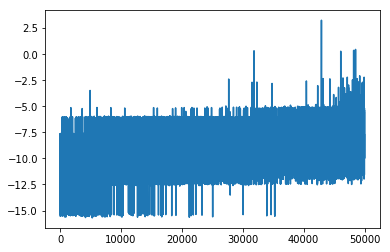

In [9]:
plt.plot(range(episode_count),all_rewards)
plt.show()

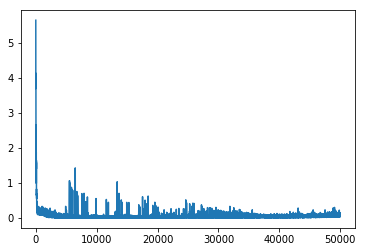

In [10]:
plt.plot(range(len(all_losses)),all_losses)
plt.show()

In [11]:
agent.q_model.save_weights("d:\\iDQM-bike")